## 1. Importations

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import scapy_layers
import scapy.all as S
from scapy.all import rdpcap, TCP, UDP, IP, Padding, Raw, load_layer, Ether, CookedLinux, PcapReader
from scapy.compat import bytes_encode
from scapy.layers import *
load_layer('http')

#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Linear algebra and data processing
import numpy as np
import pandas as pd
import math
import random

# Get version python/keras/tensorflow/sklearn
from platform import python_version
import sklearn
import tensorflow as tf

# Tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

# Loading bar
from tqdm import tqdm

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

# Joblib
import joblib

# Others
import itertools
from scipy import linalg
import matplotlib as mpl

# Folder manipulation
import os
import sys

# Garbage collector
import gc

# For images augmentations
# import cv2

# For regex
import re

# Visualizaton
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Personnal functions
import functions
import scapy_layers

import time

# Create defaultdict
from collections import defaultdict

# Multiprocessing
from multiprocessing import Pool
import multiprocessing as mp

## 2. Informations

In [2]:
print("Keras version : " + keras.__version__)
print("Tensorflow version : " + tf.__version__)
print("Python version : " + python_version())
print("Sklearn version : " + sklearn.__version__)
print("tf.keras.backend.floatx() : ", tf.keras.backend.floatx())

Keras version : 2.6.0
Tensorflow version : 2.6.0
Python version : 3.8.13
Sklearn version : 0.23.2
tf.keras.backend.floatx() :  float32


## 3. Set parameters

In [3]:
HUFFMAN_DIR = "MODELS/HUFFMAN/"
RESULTS_DIR = "RESULTS/"
MODELS_DIR = "MODELS/"
MAIN_DIR = "./DATA/"

PROTO = "DNS"

# Set keras types
tf.keras.backend.set_floatx('float64')

# Context
LOOK_BACK_CONTEXT = 1 # On rajoute +1 car on prend le dernier paquet comme paquet à compresser...
LOOK_AHEAD_CONTEXT = 1 #TIMESTEPS
CONTEXT_SIZE = 2 # Nombre timesteps sur les contexts
CONTEXT_OUTPUT_SIZE = 30 # Size of contexte in model layer
# De preference < 128 car c'est la taille de la
# couche GRU avant

# Packet
LOOK_BACK_PACKET = 8
LOOK_AHEAD_PACKET = 1
QUANTITY_PACKET = 15000 # Check if similar to training !
NUM_SIN = 8
NUM_FEATS = NUM_SIN + 1

# Filter equipment
NB_EQUIP_MAX = 10 # Set to None if no equipment
NB_EQUIP_TRAIN = 5 # Set to None if no equipment
MODE_EQUIP = "train" #"train" # or "test" or None for both
MODEL_MODE_EQUIP = "train"

# Learning parameters
EPOCHS = 20
SHUFFLE = True
ALPHABET_SIZE = 2
BATCH_SIZE = 8 #512 #2048

# Size added to header_length IN BYTES
EXTRA_SIZE = 0 #40 #40 #40
CUSTOM_SIZE = 100 # Take the lead if extra size is define
CHECKSUM = True # True = Keep Checksum

# For evaluation parallelisation
BATCH_PACKET = 1

# For huffman creation
CUT_VALUE = 8 # For array of index possition
KEEP_ERROR = True # Change EXT_NAME, remove KEEP ERROR !
DECIMALS = None # Si None pas de rounding !

# Generated dataset parameters
LEFT_PADDING = True # Padding dataset


# min(LOOK_BACK_CONTEXT, CONTEXT_OUTPUT_SIZE) if CONTEXT_OUTPUT_SIZE == 0
# else LOOK_BACK_CONTEXT == 1 or 2 or 3 or 4...etc
# easy to set LOOK_BACK_CONTEXT == 0
# COS = Context Output Size
# FULL_NAME = f"LOSSLESS_CONTEXT{min(LOOK_BACK_CONTEXT, CONTEXT_OUTPUT_SIZE)}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_COS{CONTEXT_OUTPUT_SIZE}_{PROTO}"
FULL_NAME = f"LOSSLESS_CONTEXT{min(LOOK_BACK_CONTEXT, CONTEXT_OUTPUT_SIZE)}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_{PROTO}"

if (CHECKSUM):
    
    if (CUSTOM_SIZE is not None):
        EXT_NAME = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{MODE_EQUIP}"
    else:
        EXT_NAME = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{MODE_EQUIP}"

else:

    if (CUSTOM_SIZE is not None):
        EXT_NAME = f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{MODE_EQUIP}"
    else:
        EXT_NAME = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{MODE_EQUIP}"
        
        
if (LEFT_PADDING):
    EXT_NAME += f"_LEFT_PADDING"


if (KEEP_ERROR):
    EXT_NAME_HUFFMAN = EXT_NAME + f"_KEEP_ERROR_{CUT_VALUE}_DECIMALS{DECIMALS}"
else:
    EXT_NAME_HUFFMAN = EXT_NAME + f"_{CUT_VALUE}_DECIMALS{DECIMALS}"


print(f"MODEL : {FULL_NAME}{EXT_NAME}")

# Set the Seed for numpy random choice
np.random.seed(42)

MODEL : LOSSLESS_CONTEXT1_PACKET8_SIN8_DNS_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_LEFT_PADDING


In [4]:
LABEL_FONTSIZE = 26
TICK_FONTSIZE = 26
TITLE_FONTSIZE = 26
LEGEND_FONTSIZE = 26
MARKERSIZE = 10

YLIM = [0, 1.1]

COEFF = 0.05 # To increase upper limit

LINEWIDTH = 4
sns.set_style("white")

## 4. Plotting

### 4.1 Code

In [116]:
df_test = pd.read_csv("RESULTS/df_FIELDS_LOSSLESS_CONTEXT1_PACKET8_SIN8_LORA_20_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain.csv")

In [126]:
_, idx_unique = np.unique(df_test.values,
                          return_index=True,
                          axis=0)

In [19]:
FULL_NAME = f"LOSSLESS_CONTEXT{min(LOOK_BACK_CONTEXT, CONTEXT_OUTPUT_SIZE)}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_{PROTO}"

In [36]:
FIELDS_DIR = "RESULTS/FIELDS/"

files = os.listdir(f"{FIELDS_DIR}")
df_all = pd.DataFrame()
num_file_all = []
max_num_file = 0

files_exist = False 

FULL_NAME = f"LOSSLESS_CONTEXT{min(LOOK_BACK_CONTEXT, CONTEXT_OUTPUT_SIZE)}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_{PROTO}"

for f in files:

    # Extract name info in filename
    metaname = f.split('_')[2:-1]
    metaname = "_".join(metaname)

    # If filename is part of {FULL_NAME}{EXT_NAME}
    if (metaname == f"{FULL_NAME}{EXT_NAME}"):
        
        # Extract num files
        num_file = int(f.split('_')[-1].split('.')[0])
        max_num_file = max(num_file, max_num_file)
        print("[DEBUG] filename: ", metaname, 
            " // ", num_file)
    
        # Load dataframe
        df = pd.read_csv(f"{FIELDS_DIR}{f}")
        df = df.rename(columns={"Unnamed: 0": "index_batch"})\
                    .set_index("index_batch")
        df['num_file'] = num_file
        
        # Concat with other dataframe
        df_all = pd.concat(
            [df_all, df], axis=0)
        
        # Remove files
        #os.remove(f"{FIELDS_DIR}{f}")

        # File(s) exist
        files_exist = True

[DEBUG] metaname:  LOSSLESS_CONTEXT1_PACKET8_SIN8_LORA_20_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain
[DEBUG] metaname:  LOSSLESS_CONTEXT1_PACKET8_SIN8_DNS_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain
[DEBUG] metaname:  LOSSLESS_CONTEXT1_PACKET8_SIN8_SMTP_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain
[DEBUG] metaname:  LOSSLESS_CONTEXT1_PACKET8_SIN8_LORA_20_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain
[DEBUG] metaname:  LOSSLESS_CONTEXT1_PACKET8_SIN8_MQTT_IEEE_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain
[DEBUG] metaname:  LOSSLESS_CONTEXT1_PACKET8_SIN8_SMTP_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain
[DEBUG] metaname:  LOSSLESS_CONTEXT1_PACKET8_SIN8_MQTT_IEEE_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain
[DEBUG] metaname:  LOSSLESS_CONTEXT1_PACKET8_SIN8_HTTP_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain
[DEBUG] metaname:  LOSSLESS_CONTEXT1_PACKET8_SIN8_MQTT_IEEE_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain
[DEBUG] metaname:  LOSSLESS_CONTEXT1_PACKET8_SIN8_SMTP_WITH_CHECKSUM_CUSTOM_SIZE

In [ ]:
# ATTENTION: 
# - Appliquer NOUVEAU reducer sur les occlusion MAPs
# - Renommer les fichiers correctement (nouveau nom)
# - UPLOAD les nouveaux fichiers !!!
# - APPLIQUER les changemements de nom (fonction ci dessous)

In [26]:
import os

###################
# FOR RESULTS FOLDER
###################

filenames = os.listdir(RESULTS_DIR)

for f in filenames:
    
    # Check if it's file or directory
    if (os.path.isfile(
        RESULTS_DIR+f)):
        
        print("[DEBUG] f: ", f)
        full_name = f.split('_')
        
        # If it's DataFrame
        if (full_name[1] == "FIELDS"):
            full_name = full_name[0:6]
            last_name = f.split('_')[6:]
        else:
            full_name = full_name[0:5]
            last_name = f.split('_')[5:]
            
        print("[DEBUG] full_name: ", full_name)
            
        # Check full name
        assert ((full_name[-1] == 'SIN8') or 
                (full_name[-1] == 'SIN0'))
        
        # Add information
        full_name.append('COS30')
        
        # Recreate name
        filename = full_name + last_name
        
        # Recreate filename
        filename = "_".join(filename)
        print("[DEBUG] filename: ", filename)
        print("")

[DEBUG] f:  df_LOSSLESS_CONTEXT2_PACKET16_SIN8_HTTP_HUFFMAN_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_KEEP_ERROR_8_DECIMALSNone_COMPRESSION.csv
[DEBUG] full_name:  ['df', 'LOSSLESS', 'CONTEXT2', 'PACKET16', 'SIN8']
[DEBUG] filename:  df_LOSSLESS_CONTEXT2_PACKET16_SIN8_COS30_HTTP_HUFFMAN_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_KEEP_ERROR_8_DECIMALSNone_COMPRESSION.csv

[DEBUG] f:  df_LOSSLESS_CONTEXT2_PACKET16_SIN8_SMTP_HUFFMAN_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_6_DECIMALS2_COMPRESSION.csv
[DEBUG] full_name:  ['df', 'LOSSLESS', 'CONTEXT2', 'PACKET16', 'SIN8']
[DEBUG] filename:  df_LOSSLESS_CONTEXT2_PACKET16_SIN8_COS30_SMTP_HUFFMAN_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_6_DECIMALS2_COMPRESSION.csv

[DEBUG] f:  df_LOSSLESS_CONTEXT2_PACKET16_SIN8_LORA_20_HUFFMAN_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_KEEP_ERROR_16_DECIMALSNone_COMPRESSION.csv
[DEBUG] full_name:  ['df', 'LOSSLESS', 'CONTEXT2', 'PACKET16', 'SIN8']
[DEBUG] filename:  df_LOSSLESS_CONTEXT2_PACKET16

In [23]:
import os 

###################
# FOR MODELS/HUFFMAN/ FOLDER
###################

filenames = os.listdir(MODELS_DIR+"HUFFMAN/")

for f in filenames:
    
    # Check if it's file or directory
    if (os.path.isfile(
        MODELS_DIR+"HUFFMAN/"+f)):
        
        print("[DEBUG] f: ", f)
        full_name = f.split('_')
        
        # If it's DataFrame
        if (full_name[0] == "df"):
            full_name = full_name[0:6]
            last_name = f.split('_')[6:]
        elif (full_name[0] == "arr"):
            full_name = full_name[0:8]
            last_name = f.split('_')[8:]
            
        print("[DEBUG] full_name: ", full_name)
            
        # Check full name
        assert ((full_name[-1] == 'SIN8') or 
                (full_name[-1] == 'SIN0'))
        
        # Add information
        full_name.append('COS30')
        
        # Recreate name
        filename = full_name + last_name
        
        # Recreate filename
        filename = "_".join(filename)
        
        # Apply rename
        #os.rename(MODELS_DIR+f, MODELS_DIR+filename)
        
        print("[DEBUG] filename: ", filename)
        print("")

[DEBUG] f:  df_HUFFMAN_LOSSLESS_CONTEXT2_PACKET16_SIN8_LORA_20_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_KEEP_ERROR_16.csv
[DEBUG] full_name:  ['df', 'HUFFMAN', 'LOSSLESS', 'CONTEXT2', 'PACKET16', 'SIN8']
[DEBUG] filename:  df_HUFFMAN_LOSSLESS_CONTEXT2_PACKET16_SIN8_COS30_LORA_20_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_KEEP_ERROR_16.csv

[DEBUG] f:  arr_index_pos_HUFFMAN_LOSSLESS_CONTEXT2_PACKET16_SIN8_LORA_20_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_KEEP_ERROR_8.npy
[DEBUG] full_name:  ['arr', 'index', 'pos', 'HUFFMAN', 'LOSSLESS', 'CONTEXT2', 'PACKET16', 'SIN8']
[DEBUG] filename:  arr_index_pos_HUFFMAN_LOSSLESS_CONTEXT2_PACKET16_SIN8_COS30_LORA_20_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_KEEP_ERROR_8.npy

[DEBUG] f:  df_HUFFMAN_LOSSLESS_CONTEXT2_PACKET16_SIN8_MQTT_IEEE_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_16.csv
[DEBUG] full_name:  ['df', 'HUFFMAN', 'LOSSLESS', 'CONTEXT2', 'PACKET16', 'SIN8']
[DEBUG] filename:  df_HUFFMAN_LOSSLESS_CONTEXT2_PACKET16_SIN8_COS30_

In [16]:
import os

###################
# FOR MODELS/ FOLDER
###################

filenames = os.listdir(MODELS_DIR)

for f in filenames:
    
    # Check if it's file or directory
    if (os.path.isfile(MODELS_DIR+f) and 
        (f[0] != '.')):
        
        print("[DEBUG] f: ", f)
        full_name = f.split('_')
        
        if (full_name[0] == "ENCODER"):
            full_name = full_name[0:6]
            last_name = f.split('_')[6:]
        else:
            full_name = full_name[0:5]
            last_name = f.split('_')[5:]
        
        # Check full name
        assert ((full_name[-1] == 'SIN8') or 
                (full_name[-1] == 'SIN0'))
        
        # Add information
        full_name.append('COS30')
        
        # Recreate name
        filename = full_name + last_name
        
        # Recreate filename
        filename = "_".join(filename)
        
        # Apply rename
        # os.rename(MODELS_DIR+f, MODELS_DIR+filename)
        
        print("[DEBUG] filename: ", filename)
        print("")

[DEBUG] f:  EMBEDDER_LOSSLESS_CONTEXT2_PACKET8_SIN8_LORA_20_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain.h5
[DEBUG] filename:  EMBEDDER_LOSSLESS_CONTEXT2_PACKET8_SIN8_COS30_LORA_20_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain.h5

[DEBUG] f:  ED_LOSSLESS_CONTEXT2_PACKET32_SIN8_MQTT_IEEE_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain.h5
[DEBUG] filename:  ED_LOSSLESS_CONTEXT2_PACKET32_SIN8_COS30_MQTT_IEEE_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain.h5

[DEBUG] f:  EMBEDDER_LOSSLESS_CONTEXT2_PACKET4_SIN8_LORA_20_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain.h5
[DEBUG] filename:  EMBEDDER_LOSSLESS_CONTEXT2_PACKET4_SIN8_COS30_LORA_20_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain.h5

[DEBUG] f:  ENCODER_CONTEXT_LOSSLESS_CONTEXT2_PACKET16_SIN8_MQTT_IEEE_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain.h5
[DEBUG] filename:  ENCODER_CONTEXT_LOSSLESS_CONTEXT2_PACKET16_SIN8_COS30_MQTT_IEEE_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain.h5

[DEBUG] f:  EMBEDDER_LOSSLESS_CONTEXT2_PACKET16_SIN8_SSH_WITH_CHEC

In [5]:
# GENERATOR UPDATE pour prendre la notion d'index
# sans sequentialité !
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, 
                 list_IDs,
                 
                 look_back_context,
                 look_ahead_context,
                 look_back_packet,
                 look_ahead_packet,
                
                 packets_rank,
                 packets, 
                 headers_length,
                 max_length,
                 
                 indexes_packet,
                 indexes_block,
                 
                 batch_size=32,
                 num_sin=8,
                 alphabet_size=2, 
                 shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        # Liste des index des packets (peut etre que les vals ou trains...)
        self.list_IDs = list_IDs # Index de block !
        self.shuffle = shuffle
        self.on_epoch_end()
        
        # Identification data
        #self.flows_id = flows_id
        self.packets_rank = packets_rank
        self.packets = packets
        self.headers_length = headers_length
        
        # Parameters data
        self.num_sin = num_sin
        self.num_feats = self.num_sin + 1
        self.alphabet_size = alphabet_size
        self.max_length = max_length
        
        self.look_back_context = look_back_context
        self.look_ahead_context = look_ahead_context
        self.look_back_packet = look_back_packet
        self.look_ahead_packet = look_ahead_packet
        
        # Generation des indexes
        nb_batch_block_min = (((self.headers_length*8) - 
                              self.look_back_packet) // self.batch_size) * self.batch_size
        nb_batch_block_max = ((self.headers_length*8) - 
                             self.look_back_packet)
        nb_batch_block = np.maximum(nb_batch_block_min, nb_batch_block_max)
        self.indexes_max_packet = np.cumsum(nb_batch_block)
        self.indexes_min_packet = np.concatenate((np.zeros(1),
                                                  self.indexes_max_packet[0:-1]))
        self.indexes_max_packet = self.indexes_max_packet - 1
        
        # Indexes packet and block pre computed !
        self.indexes_packet = indexes_packet
        self.indexes_block = indexes_block
        
        # Generate sinusoide
        self.sin = np.empty((self.max_length, 0), dtype=np.float64)
        for j in range(1, self.num_sin+1):
            sin_tmp = self.__gen_sin(
                F=j, Fs=self.max_length, phi=0, A=1, 
                mean=0.5, period=j, center=0.5).reshape((self.max_length, 1))
            self.sin = np.concatenate((self.sin, sin_tmp), axis=-1)    
        self.sin_seq = create_windows(
            self.sin, window_shape=self.look_back_packet, 
            end_id=-self.look_ahead_packet)
        
        
    def __gen_sin(self, F, Fs, phi, A, mean, period, center):
        T = (1/F)*period # Period if 10/F = 10 cycles
        Ts = 1./Fs # Period sampling
        N = int(T/Ts) # Number of samples
        t = np.linspace(0, T, N)
        signal = A*np.sin(2*np.pi*F*t + phi) + center
        return signal

    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(
            (self.list_IDs.size /  self.batch_size)))

    
    # /!\ A adapter en fonction de la look_ahead_packet 
    # (par default on dit quel est a UN !)
    def __compute_batch_quantity(self, indexes_packet):
        #(self.headers_length[indexes_packet].sum() * 8)
        pkts_size = (self.headers_length[
            indexes_packet].sum() * 8)
        pkts_size_cut = pkts_size - \
            (indexes_packet.shape[0]*self.look_back_packet)
        return pkts_size_cut # / self.batch_size)
    

    def __getitem__(
        self, index):
        'Generate one batch of data'
        # On met à jour l'index avec le coté random !
        
        # Get index of block
        index_start = self.indexes[
            index] * self.batch_size
        index_end = index_start + self.batch_size
        
        # Get indexes packet and block
        indexes_packet = self.indexes_packet[
            index_start:index_end]
        indexes_block = self.indexes_block[
            index_start:index_end]
        
        # On prend le min et on ajoute !
        # On récupère les données
        ctx, pkt, y = self.__data_generation(
                indexes_packet, indexes_block)

        return [ctx, pkt, y]

    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # On manipule des indexes de block !
        self.indexes = np.arange(
            np.floor(len(self.list_IDs)/self.batch_size)) \
            .astype(int)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def __get_context(
        self, indexes_packet):
        
        ctx = np.zeros(
            (indexes_packet.size, 
             self.look_back_context, 
             self.max_length))
        
        for i in range(ctx.shape[0]):
            rank = indexes_packet[i] #list_IDs[i]
            
            pad_size = max(0, self.look_back_context - \
                self.packets_rank[rank])
            
            pkt_size = self.look_back_context - \
                pad_size
            
            ctx_tmp = np.concatenate(
                    (np.zeros((pad_size, self.max_length)), 
                     self.packets[rank-pkt_size:rank]), axis=0)
            
            ctx_tmp = ctx_tmp.reshape(
                1, self.look_back_context, -1)
                
            ctx[i] = ctx_tmp
        
        # Repeat le contexte en fonction de la header length
        nbs_repeat = ((self.headers_length[indexes_packet]*8) - \
              self.look_back_packet).astype(int)
        ctx_seq = np.repeat(ctx, nbs_repeat, axis=0)
        
        return ctx_seq
    
    
    def __get_packet(self, 
                     indexes_packet, 
                     indexes_block):
        # En fonction de la taille de batch size il faut 
        # penser à recupere un ou plusieurs paquets !
        
        #nb_repeat = ((self.headers_length[indexes_packet]*8) - \
        #      self.look_back_packet).sum().astype(int) #[0]
        nb_repeat = indexes_block.size
        
        pkt_seq = np.zeros(
            (nb_repeat, self.look_back_packet, 
             self.num_feats))
        
        y_seq = np.zeros(
            (nb_repeat, self.alphabet_size))
        
        index_start = int(0)
        for idx_pkt, idx_block in zip(
            indexes_packet, indexes_block):
            
            idx_start = idx_block
            idx_end = idx_block + self.look_back_packet
            
            # Set packet
            pkt = self.packets[
                idx_pkt, :int(self.headers_length[idx_pkt]*8)]
            
            pkt_seq_tmp = pkt[idx_start:idx_end] \
                .reshape(-1, self.look_back_packet, 1)
            
            y_seq_tmp = pkt[idx_end]
            y_seq_tmp = tf.keras.utils.to_categorical(
                y=y_seq_tmp.ravel(), 
                num_classes=self.alphabet_size, 
                dtype='float64')
            
            # Set to packet sequence
            pkt_seq[index_start:index_start+1, :, 0:1] = pkt_seq_tmp
            pkt_seq[index_start:index_start+1, :, 1:] = self.sin_seq[
                idx_start:idx_start+1]
            y_seq[index_start:index_start+1] = y_seq_tmp
            
            index_start += 1
            
        return pkt_seq, y_seq

    
    def __data_generation(
        self, indexes_packet, indexes_block):
        'Generates data containing batch_size samples'      
        # Initialization
        ctx = self.__get_context(
            indexes_packet)
        
        pkt, y = self.__get_packet(
            indexes_packet, indexes_block) # On shuffle les packet et target
        
        # Correct context shape
        ctx = ctx[:pkt.shape[0]]
        
        # On prend des bloque alétoire parmis les paquet
        # pas forcement les blocks selectionné...
        # Moins propre mais + simple...
        indexes = np.arange(0, pkt.shape[0])\
                    .astype(int)
        
        # Shuffle to avoid to always keep the last block non learned !
        ctx = ctx[indexes]
        pkt = pkt[indexes]
        y = y[indexes]
        
        return ctx, pkt, y

In [6]:
def build_model_embedding_lossless(
    input_shape, output_shape, input_dim):
    output_dim = int(output_shape**0.25)
    
    inputs = keras.Input(shape=input_shape)
    
    x = inputs # ADDITION DE header shape et context
    embed = tf.keras.layers.Embedding(input_dim=input_dim, #output_shape,
                                      output_dim=output_dim,
                                      embeddings_initializer="uniform",
                                      embeddings_regularizer=None,
                                      activity_regularizer=None,
                                      embeddings_constraint=None,
                                      mask_zero=False,
                                      input_length=input_shape[-1])
    embed_output = embed(x)
    
    x = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(64, #output_dim, #input_shape[-1],
                                activation='tanh', 
                                return_sequences=False, 
                                return_state=False))(embed_output)
    x = layers.Dense(64, 
                     activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = layers.Dense(output_shape, 
                     activation="softmax")(x)
    model = keras.Model(inputs, x, name="model")
    embedding_model = keras.Model(inputs, embed_output, name="embedding_model")
    
    return model, embedding_model

In [7]:
class CompressorLossless(keras.Model):
    def __init__(self, 
                 encoder_context,
                 ed_lossless,
                 **kwargs):
        super(CompressorLossless, self).__init__(**kwargs)
        self.encoder_context = encoder_context
        self.ed_lossless = ed_lossless
        
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [
            self.loss_tracker,
        ]

    def call(self, data):
        
        inputs = data
        context = data[0]
        packet = data[1]
        target = data[2]
        packet = tf.cast(packet, tf.float64)
        
        x = self.encoder_context(context)
        
        x = tf.expand_dims(x, axis=1)
        x = tf.repeat(x, LOOK_BACK_PACKET, axis=1)
        
        x = tf.concat([x, packet], axis=-1)
        
        x = self.ed_lossless(x)

        loss_reconstruction = tf.reduce_sum(
            keras.losses.binary_crossentropy(target, x),
        )
        loss = loss_reconstruction
        
        self.loss_tracker.update_state(loss)
        
        return x

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        #print("[DEBUG][train_step] data : ", data)
        
        inputs = data
        context = data[0]
        packet = data[1]
        target = data[2]
        packet = tf.cast(packet, tf.float64)
        
        with tf.GradientTape() as tape:

            x = self.encoder_context(context)
            
            x = tf.expand_dims(x, axis=1)
            x = tf.repeat(x, LOOK_BACK_PACKET, axis=1) # shape_packet[1]
            
            x = tf.concat([x, packet], axis=-1)
            
            x = self.ed_lossless(x)
            
            loss_reconstruction = tf.reduce_sum(
                keras.losses.binary_crossentropy(target, x)
            )
            loss = loss_reconstruction

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.loss_tracker.update_state(loss)

        return {
            "tot": self.loss_tracker.result()
        }

In [8]:
def build_model_context_lossless(input_shape, output_size):
    
    encoder_inputs = keras.Input(shape=input_shape)
    
    x = encoder_inputs # ADDITION DE header shape et context
    #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
    #        input_shape[-1], activation=tf.keras.layers.LeakyReLU(alpha=0.1)))(x)
    x = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(128,
                                activation='tanh', 
                                return_sequences=False, 
                                return_state=False))(x)
    #x = layers.Flatten()(x)
    x = layers.Dense(output_size, name="z", 
                     activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    encoder = keras.Model(encoder_inputs, x, name="encoder")
    
    return encoder

In [9]:
def build_model_lossless(
    input_shape, output_shape, input_dim):
    
    output_dim = int(output_shape**0.25)
    
    inputs = keras.Input(shape=input_shape) #_symbol
    inputs_result = inputs #.values
    
    #print("[DEBUG][build_model_lossless] inputs_result shape : ", tf.shape(inputs_result))
    
    inputs_symbol = tf.slice(inputs_result, [0, 0, 0], [-1, -1, 1])
    
    #print("[DEBUG][build_model_lossless] inputs_symbol shape : ", tf.shape(inputs_symbol))
    
    inputs_symbol_shape = [k for k in tf.shape(inputs_symbol)]
    inputs_symbol = tf.reshape(
        inputs_symbol, [inputs_symbol_shape[0], inputs_symbol_shape[1]])
    
    #print("[DEBUG][build_model_lossless] inputs_symbol shape : ", tf.shape(inputs_symbol))
    
    inputs_sin = tf.slice(inputs_result, [0, 0, 1], [-1, -1, -1])

    embed = tf.keras.layers.Embedding(input_dim=input_dim, #output_shape,
                                      output_dim=output_dim,
                                      embeddings_initializer="uniform",
                                      embeddings_regularizer=None,
                                      activity_regularizer=None,
                                      embeddings_constraint=None,
                                      mask_zero=False,
                                      input_length=input_shape[-1])
    embed_output = embed(inputs_symbol)
    embed_output_shape = [k for k in tf.shape(embed_output)]
    #print("embed_output_shape : ", embed_output_shape)
    
    x = tf.concat(
        [embed_output, inputs_sin], axis=-1)
    
    x = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(32, #output_dim, #input_shape[-1],
                                activation='tanh', 
                                return_sequences=False, 
                                return_state=False))(x)
    x = layers.Dense(3, 
                     activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = layers.Dense(output_shape, 
                     activation="softmax")(x)
    model = keras.Model(inputs, x, name="model")
    embedding_model = keras.Model(inputs, embed_output, name="embedding_model")
    
    return model, embedding_model

In [10]:
def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):
    
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data
        
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))
    
    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)
    
    return np.squeeze(window_data, 1)

In [11]:
class ArithmeticCoderBase(object):
    
    # Constructs an arithmetic coder, which initializes the code range.
    def __init__(self, statesize):
        
        self.STATE_SIZE = statesize
        self.MAX_RANGE = 1 << self.STATE_SIZE
        self.MIN_RANGE = (self.MAX_RANGE >> 2) + 2
        self.MAX_TOTAL = self.MIN_RANGE
        self.MASK = self.MAX_RANGE - 1
        self.TOP_MASK = self.MAX_RANGE >> 1
        self.SECOND_MASK = self.TOP_MASK >> 1
        
        self.low = 0
        self.high = self.MASK

    def update(self,  cumul, symbol):
        # State check
        low = self.low
        high = self.high
        range_value = high - low + 1
            
        # Frequency table values check
        total = cumul[-1].item() #np.asscalar(cumul[-1])
        symlow = cumul[symbol].item() #np.asscalar(cumul[symbol])
        symhigh = cumul[symbol+1].item() #np.asscalar(cumul[symbol+1])
        
        # Update range
        newlow  = low + symlow  * range_value // total
        newhigh = low + symhigh * range_value // total - 1
        self.low = newlow
        self.high = newhigh
        # While the highest bits are equal
        while ((self.low ^ self.high) & self.TOP_MASK) == 0:
            self.shift()
            self.low = (self.low << 1) & self.MASK
            self.high = ((self.high << 1) & self.MASK) | 1
        
        # While the second highest bit of low is 1 and the second highest bit of high is 0
        while (self.low & ~self.high & self.SECOND_MASK) != 0:
            self.underflow()
            self.low = (self.low << 1) & (self.MASK >> 1)
            self.high = ((self.high << 1) & (self.MASK >> 1)) | self.TOP_MASK | 1
    
    def shift(self):
        raise NotImplementedError()
    
    def underflow(self):
        raise NotImplementedError()
        
class ArithmeticEncoder(ArithmeticCoderBase):
    
    def __init__(self, statesize, bitout,
                 write_mode=False):
        super(ArithmeticEncoder, self).__init__(statesize)
        self.output = bitout
        self.write_mode = write_mode
        self.num_underflow = 0
        self.data_compress = []
    
    def write(self, cumul, symbol):
        self.update(cumul, symbol)
    
    def finish(self):
        if (self.write_mode):
            self.output.write(1)
        else:
            self.data_compress.append(1)
            
    
    def shift(self):
        bit = self.low >> (self.STATE_SIZE - 1)
        if (self.write_mode):
            self.output.write(bit)
        else:
            self.data_compress.append(bit)
        
        # Write out the saved underflow bits
        for _ in range(self.num_underflow):
            if (self.write_mode):
                self.output.write(bit ^ 1)
            else:
                self.data_compress.append(bit ^ 1)
        self.num_underflow = 0
    
    def underflow(self):
        self.num_underflow += 1


class ArithmeticDecoder(ArithmeticCoderBase):
    
    def __init__(self, statesize, bitin, 
                 data_compress, 
                 write_mode=False):
        super(ArithmeticDecoder, self).__init__(statesize)
        # The underlying bit input stream.
        self.input = bitin
        self.data_compress = data_compress
        self.data_decompress = []
        self.rank = 0
        self.write_mode = write_mode
        # The current raw code bits being buffered, which is always in the range [low, high].
        self.code = 0
        self.temp_read = []
        self.temp = []
        for _ in range(self.STATE_SIZE):
            self.code = self.code << 1 | self.read_code_bit()
    
    def read(self, cumul, alphabet_size):
        
        total = cumul[-1].item() #np.asscalar(cumul[-1])
        range_value = self.high - self.low + 1
        offset = self.code - self.low
        value = ((offset + 1) * total - 1) // range_value
        
        start = 0
        end = alphabet_size
        while end - start > 1:
            middle = (start + end) >> 1
            if cumul[middle] > value:
                end = middle
            else:
                start = middle
        
        symbol = start

        self.update(cumul, symbol)
        self.data_decompress.append(symbol)
        return symbol
    
    
    def shift(self):
        self.code = ((self.code << 1) & self.MASK) | self.read_code_bit()
        
    def underflow(self):
        self.code = (self.code & self.TOP_MASK) | ((self.code << 1) & (self.MASK >> 1)) | self.read_code_bit()
    
    def read_code_bit(self):
        if (self.write_mode):
            temp = self.input.read()
        else:
            try:
                temp = self.data_compress[self.rank]
            except Exception as e:
                temp = -1
            self.rank += 1
        self.temp.append(temp)
        if temp == -1:
            temp = 0
        return temp

class BitInputStream(object):
    
    # Constructs a bit input stream based on the given byte input stream.
    def __init__(self, inp):
        self.input = inp
        self.currentbyte = 0
        self.numbitsremaining = 0

    def read(self):
        if self.currentbyte == -1:
            return -1
        if self.numbitsremaining == 0:
            temp = self.input.read(1)
            if len(temp) == 0:
                self.currentbyte = -1
                return -1
            self.currentbyte = temp[0] if python3 else ord(temp)
            self.numbitsremaining = 8
        assert self.numbitsremaining > 0
        self.numbitsremaining -= 1
        return (self.currentbyte >> self.numbitsremaining) & 1
    
    def read_no_eof(self):
        result = self.read()
        if result != -1:
            return result
        else:
            raise EOFError()
    
    def close(self):
        self.input.close()
        self.currentbyte = -1
        self.numbitsremaining = 0


class BitOutputStream(object):
    
    # Constructs a bit output stream based on the given byte output stream.
    def __init__(self, out):
        self.output = out  # The underlying byte stream to write to
        self.currentbyte = 0  # The accumulated bits for the current byte, always in the range [0x00, 0xFF]
        self.numbitsfilled = 0  # Number of accumulated bits in the current byte, always between 0 and 7 (inclusive)
    
    def write(self, b):
        if b not in (0, 1):
            raise ValueError("Argument must be 0 or 1")
        self.currentbyte = (self.currentbyte << 1) | b
        self.numbitsfilled += 1
        if self.numbitsfilled == 8:
            towrite = bytes((self.currentbyte,)) if python3 else chr(self.currentbyte)
            self.output.write(towrite)
            self.currentbyte = 0
            self.numbitsfilled = 0

    def close(self):
        while self.numbitsfilled != 0:
            self.write(0)
        self.output.close()

In [12]:
def flows_extraction(data_raw):
    
    # EXTRACT FLOWS

    # Set up df_raw
    df_raw = data_raw.copy()

    # Extraction d'un dictonnaire avec flux -> taille
    df_new = df_raw[['flow_id', 'timestamps']].groupby(
                    ['flow_id']).min().rename(
                    columns={'timestamps': 'flow_id_count'})

    # Utilisation de map function pour flux -> taille
    dict_map = df_new.to_dict()['flow_id_count']
    df_raw['flow_count'] = df_raw['flow_id'].map(dict_map)

    # Utilisation de map function pour timestamps + nombre de jour qui correpsond à l'ID
    df_min = df_raw[['flow_id', 'timestamps']].groupby(
        ['flow_id']).min().rename(columns={'timestamps': 'min'})
    df_min['pad'] = df_min.index.values*10000000
        #'min'].map(lambda x : np.random.randint(0, 5000, size=(1,))[0])
    dict_pad = df_min.to_dict()['pad']

    def some_func(a, b):
        #print(dict_pad[a])
        return b+dict_pad[a]

    df_raw['timestamps_update'] = df_raw[['flow_id', 'timestamps']].apply(
        lambda x: some_func(a=x['flow_id'], b=x['timestamps']), axis=1)

    # On sort en fonction de la timestamps (les flux sont autamiquement groupe)
    df_raw = df_raw.sort_values(by=['timestamps_update'], ascending=True)
    indexes_update = df_raw.index.values 

    # J'applique l'insertion pour récuperer les index proprement
    # Mettre les la numerotation des index
    df_raw = df_raw.reset_index(drop=False)

    ## On extrait les index max de chaque flux (voir index result)
    indexes = df_raw.duplicated(subset=['flow_id'], keep='first')
    index_val = df_raw.index[~indexes].values
    index_min = index_val.copy()

    ## On créer les index min de chaque flux (voir index result) ET on fait la diff
    indexes = df_raw.duplicated(subset=['flow_id'], keep='last')
    index_val = df_raw.index[~indexes].values
    index_max = index_val.copy()

    ## On attribue les index_min et les index_max
    df_new = df_raw[['flow_id']].drop_duplicates(
        subset=['flow_id'], keep='first')
    df_new['index_min'] = index_min
    df_new['index_max'] = index_max
    df_new = df_new.set_index('flow_id')

    dict_index_min = df_new[["index_min"]].to_dict()['index_min']
    dict_index_max = df_new[["index_max"]].to_dict()['index_max']
    df_raw['index_min'] = df_raw['flow_id'].map(dict_index_min)
    df_raw['index_max'] = df_raw['flow_id'].map(dict_index_max)
    
    return df_raw

In [13]:
def features_processing(
    df_raw, data_results):

    # Extract part of array
    df_raw_tmp = df_raw[['index', 'index_min', 'header_length']]

    # Extract relative position of packet
    df_raw_tmp['idx_rltv_flow'] = df_raw_tmp.index - \
                    df_raw_tmp['index_min']

    # Extract original size
    if (CUSTOM_SIZE is not None):
        df_raw_tmp['size_uncompress'] = np.fmin(
            CUSTOM_SIZE, df_raw['length_total'])
    else:
        df_raw_tmp['size_uncompress'] = np.fmin(
            (df_raw['header_length']+EXTRA_SIZE), 
            df_raw['length_total'])

    # Extract dict correspondance index <-> uncompressed_size
    dict_index_uncompressed_size = df_raw_tmp[
                    ['index', 'size_uncompress']] \
            .set_index('index')['size_uncompress'] \
            .to_dict()

    # Extract dict correspondance index <-> idx_rltv_flow
    dict_index_index_rltv_flow = df_raw_tmp[
                    ['index', 'idx_rltv_flow']] \
            .set_index('index')['idx_rltv_flow'] \
            .to_dict()

    # Set relative position to flow
    data_results['idx_rltv_flow'] = data_results['idx_unique'] \
                .map(dict_index_index_rltv_flow)

    # Set relative uncompressed size
    data_results['size_uncompress'] = data_results['idx_unique'] \
                .map(dict_index_uncompressed_size)

    # Correct value
    data_results['size_context'] = data_results['idx_rltv_flow']
    cond = (data_results['idx_rltv_flow'] >= LOOK_BACK_CONTEXT)
    data_results.loc[cond, 'size_context'] = LOOK_BACK_CONTEXT #2

    # Compression ratio and space saving
    data_results["compression_ratio"] = (data_results["size_uncompress"]*8) / \
                                            data_results["size_compress"]
    data_results["space_saving"] = 1 - \
            (data_results["size_compress"] / (data_results["size_uncompress"]*8))
    
    return data_results

In [14]:
def features_extraction(
    data_raw, data_results):
    
    # Extract flow indexing
    df_raw = flows_extraction(data_raw)
    
    # Extract features
    data_results = features_processing(
        df_raw, data_results)
    
    return data_results, df_raw

### 4.2 Sensibility analysis

#### 4.2.1 Compression performance no sin / no context + adding context + sin (test data same equipment)

In [30]:
ERROR_BAR = True
PROTO = "HTTP"

COMBINAISONS = [
    [0, 16, 0],
    [0, 16, 8],
    [2, 16, 8],
]

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

for look_back_context, look_back_packet, \
        num_sin in COMBINAISONS:

    full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{look_back_packet}_SIN{num_sin}_{PROTO}"
    data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}{EXT_NAME}_COMPRESSION.csv")

    data_results_tmp["look_back_packet"] = int(look_back_packet)
    data_results_tmp["look_back_context"] = int(look_back_context)
    data_results_tmp["num_sin"] = int(num_sin)
    data_results_tmp["combinaison"] = f"{look_back_context} / {look_back_packet} / {num_sin}"

    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)

In [31]:
# Setthe dict field
DICT_FIELDS = {}

if ('LORA' in PROTO):
    
    # LoRaWAN
    
    ## Mtype
    idx_start = 0
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Mtype"
            
    ## RFU
    idx_start = idx_end
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "RFU"
    
    ## Major
    idx_start = idx_end
    idx_end = idx_start + 2
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Major"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "DevAddr"
        
    ## Fctrl
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Fctrl"
        
    ## FCnt
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FCnt"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FOpts"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"


elif (PROTO in ['HTTP', 'SMTP', 'SSH', 'DNS']):
    
    # IPv4
    
    ## Set IP/HL/ToS
    idx_start = 0
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "IP/HL/ToS"
        
    ## Total length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Total length"
        
    ## Identification
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Id" # entification
        
    ## Indicator/FO
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Indicator/FO"
        
    ## TTL/Protocol
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "TTL/Protocol"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"
        
        
    # data_raw['length_0'] - data_raw['length_1']
    ip_header_length = (data_raw['length_0'] - \
                        data_raw['length_1']) \
                            .value_counts() \
                            .index.max()
    
    if (ip_header_length > 20):
        
        ## Options
        idx_start = idx_end
        idx_end = idx_start + 32
        for i in range(idx_start, idx_end):
            DICT_FIELDS[i] = "Options"
        
    
    print("[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end: ", 
          idx_end)
   # DICT_FIELDS = {v: k for k, v in enumerate(range(500))}
    
elif (PROTO in ["COAP", "MQTT_IEEE"]):
    
    # IPv6
    
    ## Version
    idx_start = 0
    idx_end = idx_start + 4
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Version"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Traffic class"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 20
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Flow label"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Payload length"
        
    ## Next header
    idx_start =  idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Next header"
        
    ## Hop limit
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Hop limit"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"


# Mettre champs TCP / UDP

if (PROTO in ['HTTP', 'SMTP', 'SSH', 'MQTT_IEEE']):
    
    # TCP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst port"
            
    ## Sequence number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Seq. number"
        
    ## ACK number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "ACK number"
        
    ## HL/Flags
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "HL/Flags"
        
    ## Windows
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Windows"
        
    ## CRC
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "CRC"
        
    ## Urgent pointer
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Urgent pointer"
        
    ## Option/Padding
    #idx_start = idx_end
    #idx_end = idx_start + 32
    #for i in range(idx_start, idx_end):
    #    DICT_FIELDS[i] = "Option/Padding"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"
        
    
elif (PROTO in ["DNS", 'COAP']):
    
    # UDP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dest. port"
        
    ## Length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Length"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"

[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end:  160


In [32]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
sizes_context = []
look_back_contexts = []
look_back_packets = []
num_sins = []
combinaisons = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []

for i in range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    for look_back_context, look_back_packet, \
        num_sin in COMBINAISONS:
        
        cond_combinaison = ((data_results['look_back_context'] == look_back_context) &
                            (data_results['look_back_packet'] == look_back_packet) &
                            (data_results['num_sin'] == num_sin))
        data_results_tmp = data_results[
            cond_combinaison]
        
        # IF l'array is empty
        if (data_results_tmp.shape[0] != 0):

            # Compute each compress level

            for col in data_results.columns:
                if ("level_compress" in col):

                    # Add context size info
                    sizes_context.append(i)
                    look_back_contexts.append(look_back_context)
                    look_back_packets.append(look_back_packet)
                    num_sins.append(num_sin)
                    combinaisons.append(
                        f"{look_back_context} / {look_back_packet} / {num_sin}")

                    # Extract bit rank
                    bit_rank = int(col.split("_")[-1])+1
                    bit_ranks.append(
                        bit_rank)

                    # Compute mean compresssion ratio
                    # Compression ratio = uncompressed / compressed
                    # for rank k
                    df_tmp_compression_ratio = bit_rank / \
                        data_results_tmp[col]
                    df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                    bit_rank)

                    ## Remove -1
                    cond = (data_results_tmp[col] != -1)
                    df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                    df_tmp_space_saving = df_tmp_space_saving[cond]

                    compression_ratio.append(
                        df_tmp_compression_ratio.mean())
                    space_saving.append(
                        df_tmp_space_saving.mean())

                    if (df_tmp_compression_ratio.shape[0] != 0):

                        # Compute std compression ratio
                        p = ((1.0-alpha)/2.0)
                        lower_compression_ratio = np.percentile(
                                df_tmp_compression_ratio.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_compression_ratio = np.percentile(
                                 df_tmp_compression_ratio.values, p)

                        # Compute std space saving
                        p = ((1.0-alpha)/2.0)
                        lower_space_saving = np.percentile(
                                df_tmp_space_saving.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_space_saving = np.percentile(
                                 df_tmp_space_saving.values, p)

                    else:
                        # Compression ratio
                        lower_compression_ratio = 0
                        upper_compression_ratio = 0

                        # Space saving
                        lower_space_saving = 0
                        upper_space_saving = 0

                    low_yerror_compression_ratio\
                        .append(lower_compression_ratio)
                    high_yerror_compression_ratio\
                        .append(upper_compression_ratio)

                    low_yerror_space_saving\
                        .append(lower_space_saving)
                    high_yerror_space_saving\
                        .append(upper_space_saving)


# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['size_context'] = sizes_context
df_plot['look_back_context'] = look_back_contexts
df_plot['look_back_packet'] = look_back_packets
df_plot['num_sin'] = num_sins
df_plot['combinaison'] = combinaisons

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

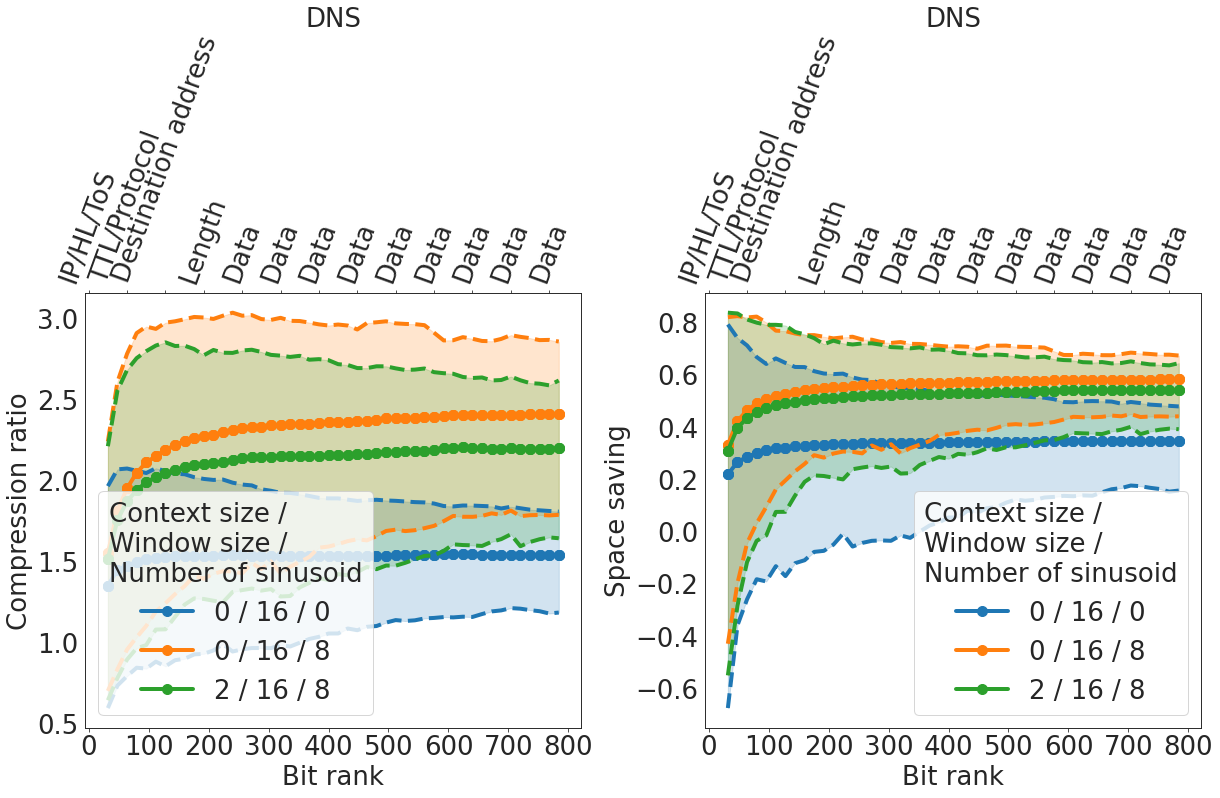

In [33]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 8))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=1.1)

# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['combinaison']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    ax1 = ax
    ax2 = ax1.twiny()

    #err_bar = [[0]*df_plot.shape[0], 
    #           [0]*df_plot.shape[0]]

    
    # SET FIRST AXIS

    
    # Set rank 
    unique_values = df_plot[hue] \
                        .value_counts()\
                        .sort_index()\
                        .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        if (ERROR_BAR):
            
            lower = (df_plot[cond][col]-\
                df_plot[cond]['low_yerror_'+col]).abs()
            upper = (df_plot[cond]['high_yerror_'+col]-\
                df_plot[cond][col]).abs()
            err_bar = [lower, 
                       upper]

            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
            
            # Get color from mean plot
            last_line = ax1.get_lines()[-1]
            color_last_line = last_line.get_color()
            
            # Set error area with alpha
            ax1.fill_between(df_plot[cond]['bit_ranks'],
                                df_plot[cond][col]-lower, 
                                df_plot[cond][col]+upper,
                                alpha=0.2,
                                color=color_last_line)
            
            # Set min and max for error area
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]-lower,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]+upper,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
        else:
            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )

        # Set legend
        #legend = ax1.legend(unique_values,
        #           fontsize=LEGEND_FONTSIZE)
        #for item in legend.legendHandles:
        #    item.set_visible(False)
        legend = ax1.legend(fontsize=LEGEND_FONTSIZE)
        legend.set_title('Context size / \nWindow size / \nNumber of sinusoid', 
                         prop={'size':LEGEND_FONTSIZE})
        

    for item in ax1.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax1.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax1.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax1.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

    # SET SECOND AXIS


    def tick_function(ranks_bit):
        values = []
        for val in ranks_bit:
            values.append(
                DICT_FIELDS[val])
        return values

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    #if (hue is None):
    new_tick_locations = [i for i in range(
        0, idx_end, 64)]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(
        tick_function(new_tick_locations))

    # Set field name
    #ax2 = ax1.twiny()
    ax2.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax2.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(70)

    ax2.grid(False)

#### 4.2.1 Compression performance HISTOGRAM PER packet no sin / no context + adding context + sin (field not threaten)

In [34]:
PROTO = "HTTP"
COMBINAISONS = [
    [0, 16, 0],
    [0, 16, 8],
    [2, 16, 8],
]

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

for look_back_context, look_back_packet, \
        num_sin in COMBINAISONS:

    full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{look_back_packet}_SIN{num_sin}_{PROTO}"
    data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}{EXT_NAME}_COMPRESSION.csv")

    data_results_tmp["look_back_packet"] = int(look_back_packet)
    data_results_tmp["look_back_context"] = int(look_back_context)
    data_results_tmp["num_sin"] = int(num_sin)
    data_results_tmp["combinaison"] = f"{look_back_context} / {look_back_packet} / {num_sin}"

    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)

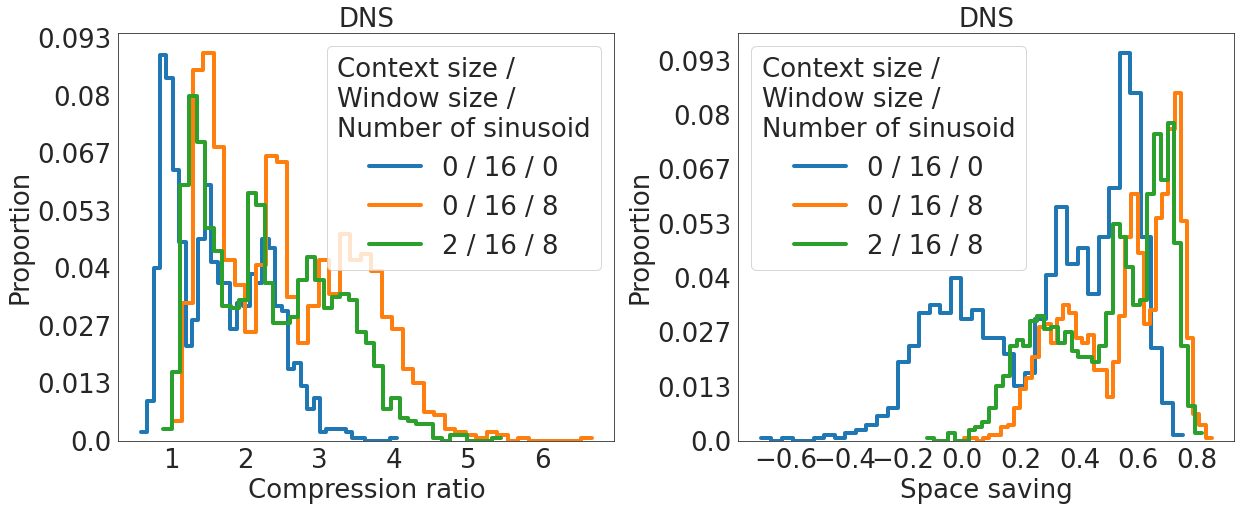

In [35]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)


# Parcourir les axes

df_plot = data_results.copy()

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['combinaison']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"Compression ratio (U/C)", f"Space saving [1-(C/U)]"]
    
    # SET FIRST AXIS

    
    # Set rank 
    unique_values = df_plot[hue] \
                        .value_counts()\
                        .sort_index()\
                        .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        sns.histplot(df_plot[cond][col], 
                     element="step",
                     bins=40,
                     linewidth=LINEWIDTH,
                     fill=False,
                     ax=ax)
        
        #ax.hist(df_plot[cond][col],
        #        density=False,
                #linewidth=LINEWIDTH,
        #        bins=70
        #       )

        # Set legend
        legend = ax.legend(unique_values, 
                  fontsize=LEGEND_FONTSIZE)
        legend.set_title('Context size / \nWindow size / \nNumber of sinusoid',
                         prop={'size':LEGEND_FONTSIZE})
        
        
    # Normalize axis
    yticklabels = ax.get_yticks() 
    yticklabels_update = np.round(
        yticklabels/df_plot[cond][col].shape[0], 3)
        
    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)
        
    # Set normalized labels
    ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        

    # Set label  
    ax.set_ylabel("Proportion", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"{title}", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

#### 4.2.2 Compression performance (test data same equipment)

In [35]:
ERROR_BAR = True
data_results = pd.read_csv(f"./RESULTS/df_{FULL_NAME}{EXT_NAME}_COMPRESSION.csv")
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

In [36]:
data_results, df_raw = features_extraction(
        data_raw=data_raw, 
        data_results=data_results)

In [37]:
# Setthe dict field
DICT_FIELDS = {}

if ('LORA' in PROTO):
    
    # LoRaWAN
    
    ## Mtype
    idx_start = 0
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Mtype"
            
    ## RFU
    idx_start = idx_end
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "RFU"
    
    ## Major
    idx_start = idx_end
    idx_end = idx_start + 2
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Major"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "DevAddr"
        
    ## Fctrl
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Fctrl"
        
    ## FCnt
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FCnt"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FOpts"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"


elif (PROTO in ['HTTP', 'SMTP', 'SSH', 'DNS']):
    
    # IPv4
    
    ## Set IP/HL/ToS
    idx_start = 0
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "IP/HL/ToS"
        
    ## Total length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Total length"
        
    ## Identification
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Id" # entification
        
    ## Indicator/FO
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Indicator/FO"
        
    ## TTL/Protocol
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "TTL/Protocol"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"
        
        
    # data_raw['length_0'] - data_raw['length_1']
    ip_header_length = (data_raw['length_0'] - \
                        data_raw['length_1']) \
                            .value_counts() \
                            .index.max()
    
    if (ip_header_length > 20):
        
        ## Options
        idx_start = idx_end
        idx_end = idx_start + 32
        for i in range(idx_start, idx_end):
            DICT_FIELDS[i] = "Options"
        
    
    print("[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end: ", 
          idx_end)
   # DICT_FIELDS = {v: k for k, v in enumerate(range(500))}
    
elif (PROTO in ["COAP", "MQTT_IEEE"]):
    
    # IPv6
    
    ## Version
    idx_start = 0
    idx_end = idx_start + 4
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Version"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Traffic class"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 20
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Flow label"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Payload length"
        
    ## Next header
    idx_start =  idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Next header"
        
    ## Hop limit
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Hop limit"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"


# Mettre champs TCP / UDP

if (PROTO in ['HTTP', 'SMTP', 'SSH', 'MQTT_IEEE']):
    
    # TCP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst port"
            
    ## Sequence number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Seq. number"
        
    ## ACK number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "ACK number"
        
    ## HL/Flags
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "HL/Flags"
        
    ## Windows
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Windows"
        
    ## CRC
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "CRC"
        
    ## Urgent pointer
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Urgent pointer"
        
    ## Option/Padding
    #idx_start = idx_end
    #idx_end = idx_start + 32
    #for i in range(idx_start, idx_end):
    #    DICT_FIELDS[i] = "Option/Padding"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"
        
    
elif (PROTO in ["DNS", 'COAP']):
    
    # UDP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dest. port"
        
    ## Length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Length"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"

[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end:  160


In [38]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
sizes_context = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []


for i in range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    # IF l'array is empty
    if (data_results_tmp.shape[0] != 0):
        
        # Init first steps
        
        '''bit_ranks.append(0)
        compression_ratio.append(0)
        space_saving.append(0)
        sizes_context.append(i)
        
        low_yerror_compression_ratio.append(0)
        high_yerror_compression_ratio.append(0)
        
        low_yerror_space_saving.append(0)
        high_yerror_space_saving.append(0)'''
        
        # Compute each compress level

        for col in data_results.columns:
            if ("level_compress" in col):

                # Add context size info
                sizes_context.append(i)

                # Extract bit rank
                bit_rank = int(col.split("_")[-1])+1
                bit_ranks.append(
                    bit_rank)

                # Compute mean compresssion ratio
                # Compression ratio = uncompressed / compressed
                # for rank k
                df_tmp_compression_ratio = bit_rank / \
                    data_results_tmp[col]
                df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                bit_rank)

                ## Remove -1
                cond = (data_results_tmp[col] != -1)
                df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                df_tmp_space_saving = df_tmp_space_saving[cond]

                compression_ratio.append(
                    df_tmp_compression_ratio.mean())
                space_saving.append(
                    df_tmp_space_saving.mean())
                
                if (df_tmp_compression_ratio.shape[0] != 0):

                    # Compute std compression ratio
                    p = ((1.0-alpha)/2.0)
                    lower_compression_ratio = np.percentile(
                            df_tmp_compression_ratio.values, p)
                    p = (alpha+((1.0-alpha)/2.0))
                    upper_compression_ratio = np.percentile(
                             df_tmp_compression_ratio.values, p)
                    
                    # Compute std space saving
                    p = ((1.0-alpha)/2.0)
                    lower_space_saving = np.percentile(
                            df_tmp_space_saving.values, p)
                    p = (alpha+((1.0-alpha)/2.0))
                    upper_space_saving = np.percentile(
                             df_tmp_space_saving.values, p)
                    
                else:
                    # Compression ratio
                    lower_compression_ratio = 0
                    upper_compression_ratio = 0
                    
                    # Space saving
                    lower_space_saving = 0
                    upper_space_saving = 0

                low_yerror_compression_ratio\
                    .append(lower_compression_ratio)
                high_yerror_compression_ratio\
                    .append(upper_compression_ratio)
                
                low_yerror_space_saving\
                    .append(lower_space_saving)
                high_yerror_space_saving\
                    .append(upper_space_saving)


# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['size_context'] = sizes_context

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

# Extract difference
'''df_plot_diff = df_plot[
    ['compression_ratio', 
     'space_saving']] \
        .diff(1).fillna(0) \
        .rename(columns={'compression_ratio':'compression_ratio_diff',
                         'space_saving':'space_saving_diff'})
df_plot = pd.concat(
    [df_plot, df_plot_diff], axis=1)'''

"df_plot_diff = df_plot[\n    ['compression_ratio', \n     'space_saving']]         .diff(1).fillna(0)         .rename(columns={'compression_ratio':'compression_ratio_diff',\n                         'space_saving':'space_saving_diff'})\ndf_plot = pd.concat(\n    [df_plot, df_plot_diff], axis=1)"

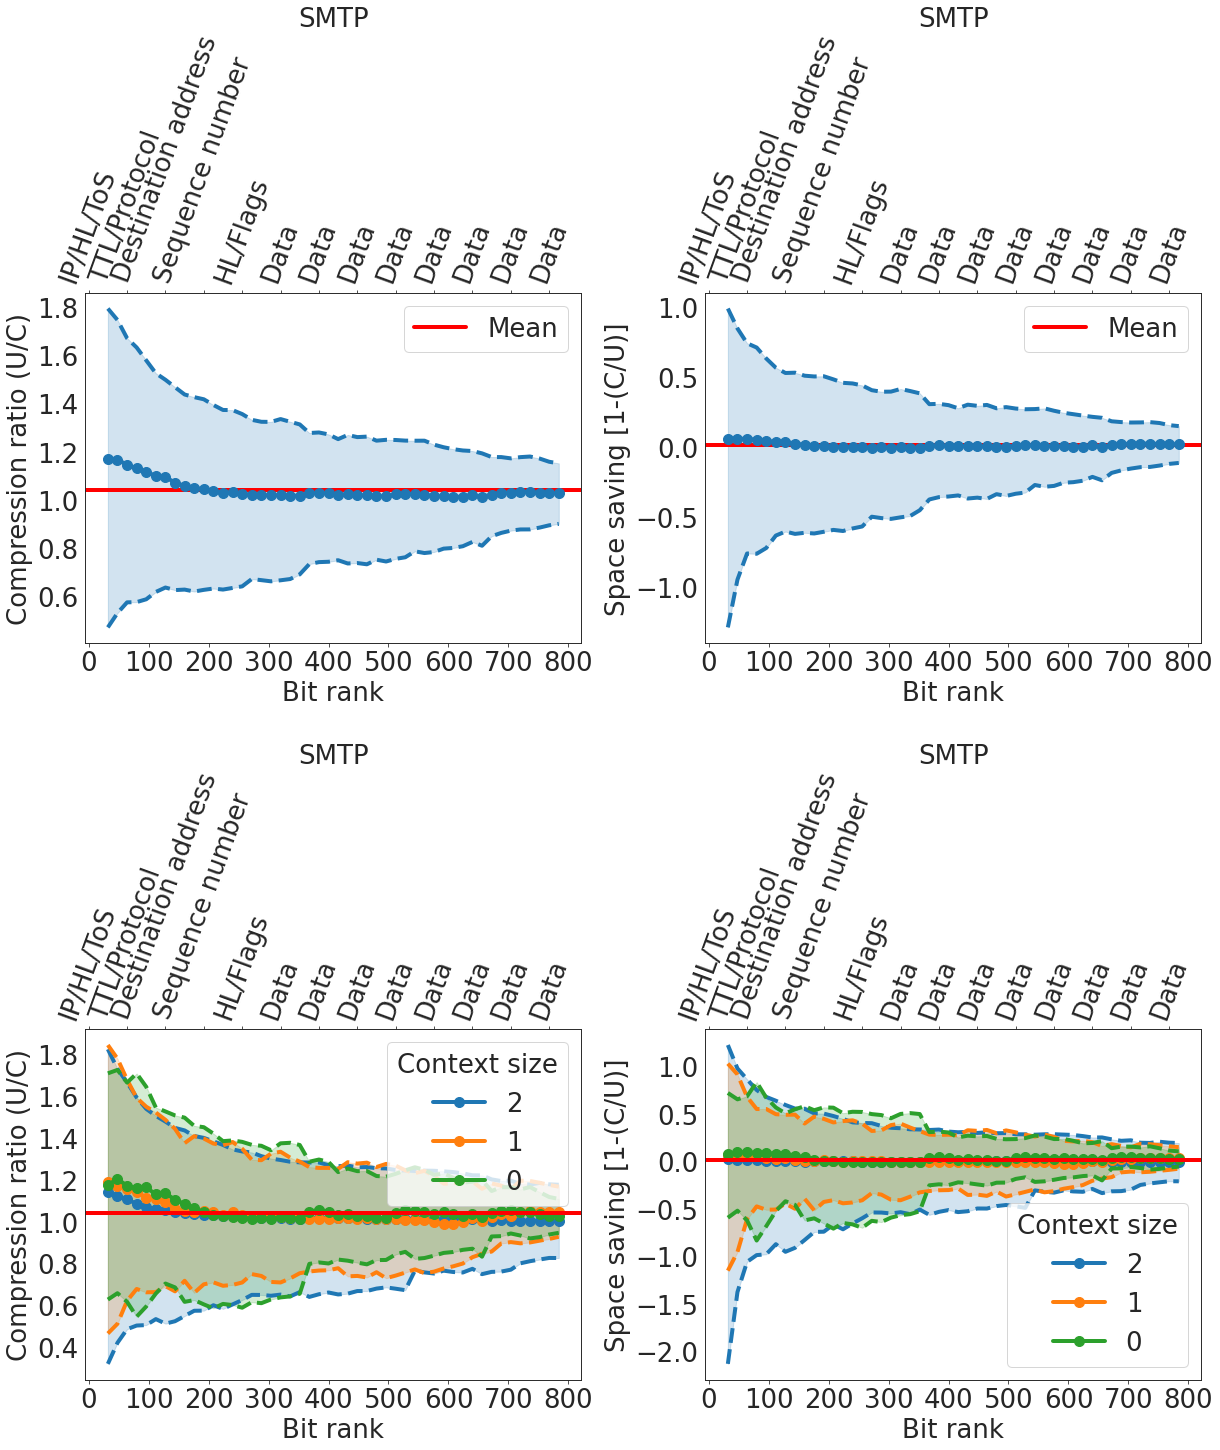

In [39]:
fig, axes = plt.subplots(
    2, 2, figsize=(20, 20))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=1.1)


# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    [None, None, "size_context", "size_context"],
    ['compression_ratio', 'space_saving']*2,
    [f"Compression ratio (U/C)", f"Space saving [1-(C/U)]"]*2):

    ax1 = ax
    ax2 = ax1.twiny()

    '''lower = (df_plot[col]-\
        df_plot['low_yerror_'+col]).abs()
    upper = (df_plot['high_yerror_'+col]-\
        df_plot[col]).abs()
    err_bar = [lower, 
               upper]'''
    
    #err_bar = [(df_plot[col]-df_plot['low_yerror'+col]).abs(), 
    #           (df_plot['high_yerror'+col]-df_plot[col]).abs()]
    #err_bar = [df_plot['low_yerror'], 
    #           df_plot['high_yerror']]
    #err_bar = [[0]*df_plot.shape[0], 
    #           [0]*df_plot.shape[0]]

    
    # SET FIRST AXIS

    
    # Set rank 
    if (hue is None):
        df_plot_tmp = df_plot.groupby("bit_ranks") \
                             .mean() \
                             .reset_index(drop=False)
        
        lower = (df_plot_tmp[col]- \
            df_plot_tmp['low_yerror_'+col]).abs()
        upper = (df_plot_tmp['high_yerror_'+col]- \
            df_plot_tmp[col]).abs()
        err_bar = [lower, 
                   upper]
        
        ax1.axhline(y=df_plot_tmp[col].mean(), 
                    linewidth=LINEWIDTH,
                    color='red',
                    label='Mean')
        if (ERROR_BAR):
            '''ax1.errorbar(df_plot_tmp['bit_ranks'], 
                     df_plot_tmp[col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     fmt='o', yerr=err_bar)'''
            ax1.plot(df_plot_tmp['bit_ranks'], 
                     df_plot_tmp[col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     #label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )

            # Get color from mean plot
            last_line = ax1.get_lines()[-1]
            color_last_line = last_line.get_color()

            # Set error area with alpha
            ax1.fill_between(df_plot_tmp['bit_ranks'],
                                df_plot_tmp[col]-lower, 
                                df_plot_tmp[col]+upper,
                                alpha=0.2,
                                color=color_last_line)

            # Set min and max for error area
            ax1.plot(df_plot_tmp['bit_ranks'],
                    df_plot_tmp[col]-lower,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            ax1.plot(df_plot_tmp['bit_ranks'],
                    df_plot_tmp[col]+upper,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
        else:
            ax1.plot(df_plot_tmp['bit_ranks'], 
                     df_plot_tmp[col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     #label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
        
        # Set legend
        ax1.legend(fontsize=LEGEND_FONTSIZE)
        
    else:
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .index
        
        for val in unique_values:
            cond = (df_plot[hue] == val)
            
            if (ERROR_BAR):

                lower = (df_plot[cond][col]-\
                    df_plot[cond]['low_yerror_'+col]).abs()
                upper = (df_plot[cond]['high_yerror_'+col]-\
                    df_plot[cond][col]).abs()
                err_bar = [lower, 
                           upper]
                
                #err_bar = [[0]*df_plot[cond].shape[0], 
                #           [0]*df_plot[cond].shape[0]]
                '''ax1.errorbar(df_plot[cond]['bit_ranks'], 
                         df_plot[cond][col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         fmt='o', yerr=err_bar)'''
                ax1.plot(df_plot[cond]['bit_ranks'], 
                         df_plot[cond][col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         alpha=1,
                         label=f"{val}",
                         marker='o',
                         #linestyle="--",
                        )

                # Get color from mean plot
                last_line = ax1.get_lines()[-1]
                color_last_line = last_line.get_color()

                # Set error area with alpha
                ax1.fill_between(df_plot[cond]['bit_ranks'],
                                    df_plot[cond][col]-lower, 
                                    df_plot[cond][col]+upper,
                                    alpha=0.2,
                                    color=color_last_line)

                # Set min and max for error area
                ax1.plot(df_plot[cond]['bit_ranks'],
                        df_plot[cond][col]-lower,
                        alpha=1,
                        linestyle='--',
                        linewidth=LINEWIDTH,
                        color=color_last_line)
                ax1.plot(df_plot[cond]['bit_ranks'],
                        df_plot[cond][col]+upper,
                        alpha=1,
                        linestyle='--',
                        linewidth=LINEWIDTH,
                        color=color_last_line)
            else:
                ax1.plot(df_plot[cond]['bit_ranks'], 
                         df_plot[cond][col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         alpha=1,
                         label=f"{val}",
                         marker='o',
                         #linestyle="--",
                        )
            
            # Set legend
            legend = ax1.legend(#unique_values,
                       fontsize=LEGEND_FONTSIZE)
            legend.set_title('Context size', 
                             prop={'size':LEGEND_FONTSIZE})
            
        ax1.axhline(y=df_plot[col].mean(), 
                    linewidth=LINEWIDTH,
                    color='red')
        

    for item in ax1.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax1.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax1.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax1.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax1.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax1.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax1.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax1.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

    # SET SECOND AXIS


    def tick_function(ranks_bit):
        values = []
        for val in ranks_bit:
            values.append(
                DICT_FIELDS[val])
        return values

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    #if (hue is None):
    new_tick_locations = [i for i in range(
        0, idx_end, 64)]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(
        tick_function(new_tick_locations))

    # Set field name
    #ax2 = ax1.twiny()
    ax2.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax2.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(70)

    ax2.grid(False)

#### 4.2.2 Compression performance HISTOGRAM PER packet (field not threaten)

In [174]:
data_results = pd.read_csv(f"./RESULTS/df_{FULL_NAME}{EXT_NAME}_COMPRESSION.csv")
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

In [175]:
data_results, df_raw = features_extraction(
        data_raw=data_raw, 
        data_results=data_results)

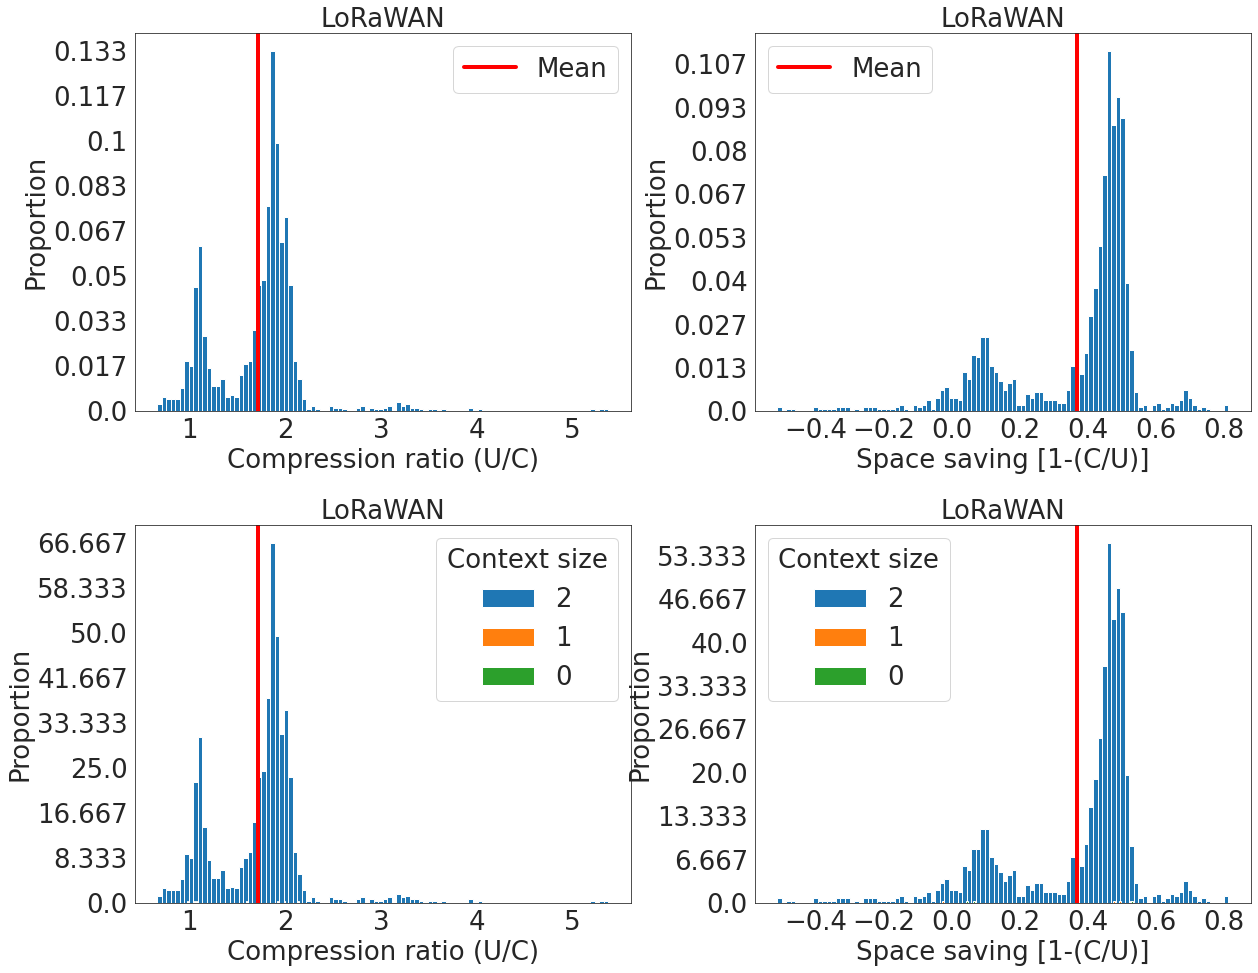

In [176]:
fig, axes = plt.subplots(
    2, 2, figsize=(20, 16))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)


# Parcourir les axes

df_plot = data_results.copy()

for ax, hue, col, title in zip(
    axes.ravel(), 
    [None, None, "size_context", "size_context"],
    ['compression_ratio', 'space_saving']*2,
    [f"Compression ratio (U/C)", f"Space saving [1-(C/U)]"]*2):
    
    # SET FIRST AXIS

    
    # Set rank 
    if (hue is None):
        ax.axvline(x=df_plot[col].mean(), 
                   linewidth=LINEWIDTH,
                   color='red',
                   label='Mean')
        ax.hist(df_plot[col],
                density=False, # Not working...
                #linewidth=LINEWIDTH,
                bins=100)
        
        # Set legend
        ax.legend(fontsize=LEGEND_FONTSIZE)
        
        # Normalize axis
        yticklabels = ax.get_yticks() 
        yticklabels_update = np.round(
            yticklabels/df_plot[col].shape[0], 3)
        
    else:
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .index
        
        for val in unique_values:
            cond = (df_plot[hue] == val)
            
            ax.hist(df_plot[cond][col],
                    density=False, # Not working...
                    #linewidth=LINEWIDTH,
                    bins=100)
            
            # Set legend
            legend = ax.legend(unique_values, 
                      fontsize=LEGEND_FONTSIZE)
            legend.set_title('Context size', 
                             prop={'size':LEGEND_FONTSIZE})
            
        ax.axvline(x=df_plot[col].mean(), 
                   linewidth=LINEWIDTH,
                   color='red')
        
        # Normalize axis
        yticklabels = ax.get_yticks() 
        yticklabels_update = np.round(
            yticklabels/df_plot[cond][col].shape[0], 3)
        
        
    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)
        
    # Set normalized labels
    ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        

    # Set label  
    ax.set_ylabel("Proportion", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"{title}", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

#### 4.2.1 Compression performance (test data OTHERS equipment)

In [79]:
ERROR_BAR = True
data_results = pd.read_csv(f"./RESULTS/df_{FULL_NAME}{EXT_NAME}_COMPRESSION.csv")
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

In [80]:
data_results, df_raw = features_extraction(
        data_raw=data_raw, 
        data_results=data_results)

In [81]:
# Setthe dict field
DICT_FIELDS = {}

if ('LORA' in PROTO):
    
    # LoRaWAN
    
    ## Mtype
    idx_start = 0
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Mtype"
            
    ## RFU
    idx_start = idx_end
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "RFU"
    
    ## Major
    idx_start = idx_end
    idx_end = idx_start + 2
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Major"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "DevAddr"
        
    ## Fctrl
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Fctrl"
        
    ## FCnt
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FCnt"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FOpts"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"


elif (PROTO in ['HTTP', 'SMTP', 'SSH', 'DNS']):
    
    # IPv4
    
    ## Set IP/HL/ToS
    idx_start = 0
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "IP/HL/ToS"
        
    ## Total length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Total length"
        
    ## Identification
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Id" # entification
        
    ## Indicator/FO
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Indicator/FO"
        
    ## TTL/Protocol
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "TTL/Protocol"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"
        
        
    # data_raw['length_0'] - data_raw['length_1']
    ip_header_length = (data_raw['length_0'] - \
                        data_raw['length_1']) \
                            .value_counts() \
                            .index.max()
    
    if (ip_header_length > 20):
        
        ## Options
        idx_start = idx_end
        idx_end = idx_start + 32
        for i in range(idx_start, idx_end):
            DICT_FIELDS[i] = "Options"
        
    
    print("[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end: ", 
          idx_end)
   # DICT_FIELDS = {v: k for k, v in enumerate(range(500))}
    
elif (PROTO in ["COAP", "MQTT_IEEE"]):
    
    # IPv6
    
    ## Version
    idx_start = 0
    idx_end = idx_start + 4
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Version"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Traffic class"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 20
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Flow label"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Payload length"
        
    ## Next header
    idx_start =  idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Next header"
        
    ## Hop limit
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Hop limit"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"


# Mettre champs TCP / UDP

if (PROTO in ['HTTP', 'SMTP', 'SSH', 'MQTT_IEEE']):
    
    # TCP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst port"
            
    ## Sequence number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Seq. number"
        
    ## ACK number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "ACK number"
        
    ## HL/Flags
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "HL/Flags"
        
    ## Windows
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Windows"
        
    ## CRC
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "CRC"
        
    ## Urgent pointer
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Urgent pointer"
        
    ## Option/Padding
    #idx_start = idx_end
    #idx_end = idx_start + 32
    #for i in range(idx_start, idx_end):
    #    DICT_FIELDS[i] = "Option/Padding"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"
        
    
elif (PROTO in ["DNS", 'COAP']):
    
    # UDP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dest. port"
        
    ## Length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Length"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"

In [82]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
sizes_context = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []


for i in range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    # IF l'array is empty
    if (data_results_tmp.shape[0] != 0):
        
        # Init first steps
        
        '''bit_ranks.append(0)
        compression_ratio.append(0)
        space_saving.append(0)
        sizes_context.append(i)
        
        low_yerror_compression_ratio.append(0)
        high_yerror_compression_ratio.append(0)
        
        low_yerror_space_saving.append(0)
        high_yerror_space_saving.append(0)'''
        
        # Compute each compress level

        for col in data_results.columns:
            if ("level_compress" in col):

                # Add context size info
                sizes_context.append(i)

                # Extract bit rank
                bit_rank = int(col.split("_")[-1])+1
                bit_ranks.append(
                    bit_rank)

                # Compute mean compresssion ratio
                # Compression ratio = uncompressed / compressed
                # for rank k
                df_tmp_compression_ratio = bit_rank / \
                    data_results_tmp[col]
                df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                bit_rank)

                ## Remove -1
                cond = (data_results_tmp[col] != -1)
                df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                df_tmp_space_saving = df_tmp_space_saving[cond]

                compression_ratio.append(
                    df_tmp_compression_ratio.mean())
                space_saving.append(
                    df_tmp_space_saving.mean())
                
                if (df_tmp_compression_ratio.shape[0] != 0):

                    # Compute std compression ratio
                    p = ((1.0-alpha)/2.0)
                    lower_compression_ratio = np.percentile(
                            df_tmp_compression_ratio.values, p)
                    p = (alpha+((1.0-alpha)/2.0))
                    upper_compression_ratio = np.percentile(
                             df_tmp_compression_ratio.values, p)
                    
                    # Compute std space saving
                    p = ((1.0-alpha)/2.0)
                    lower_space_saving = np.percentile(
                            df_tmp_space_saving.values, p)
                    p = (alpha+((1.0-alpha)/2.0))
                    upper_space_saving = np.percentile(
                             df_tmp_space_saving.values, p)
                    
                else:
                    # Compression ratio
                    lower_compression_ratio = 0
                    upper_compression_ratio = 0
                    
                    # Space saving
                    lower_space_saving = 0
                    upper_space_saving = 0

                low_yerror_compression_ratio\
                    .append(lower_compression_ratio)
                high_yerror_compression_ratio\
                    .append(upper_compression_ratio)
                
                low_yerror_space_saving\
                    .append(lower_space_saving)
                high_yerror_space_saving\
                    .append(upper_space_saving)


# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['size_context'] = sizes_context

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

# Extract difference
'''df_plot_diff = df_plot[
    ['compression_ratio', 
     'space_saving']] \
        .diff(1).fillna(0) \
        .rename(columns={'compression_ratio':'compression_ratio_diff',
                         'space_saving':'space_saving_diff'})
df_plot = pd.concat(
    [df_plot, df_plot_diff], axis=1)'''

"df_plot_diff = df_plot[\n    ['compression_ratio', \n     'space_saving']]         .diff(1).fillna(0)         .rename(columns={'compression_ratio':'compression_ratio_diff',\n                         'space_saving':'space_saving_diff'})\ndf_plot = pd.concat(\n    [df_plot, df_plot_diff], axis=1)"

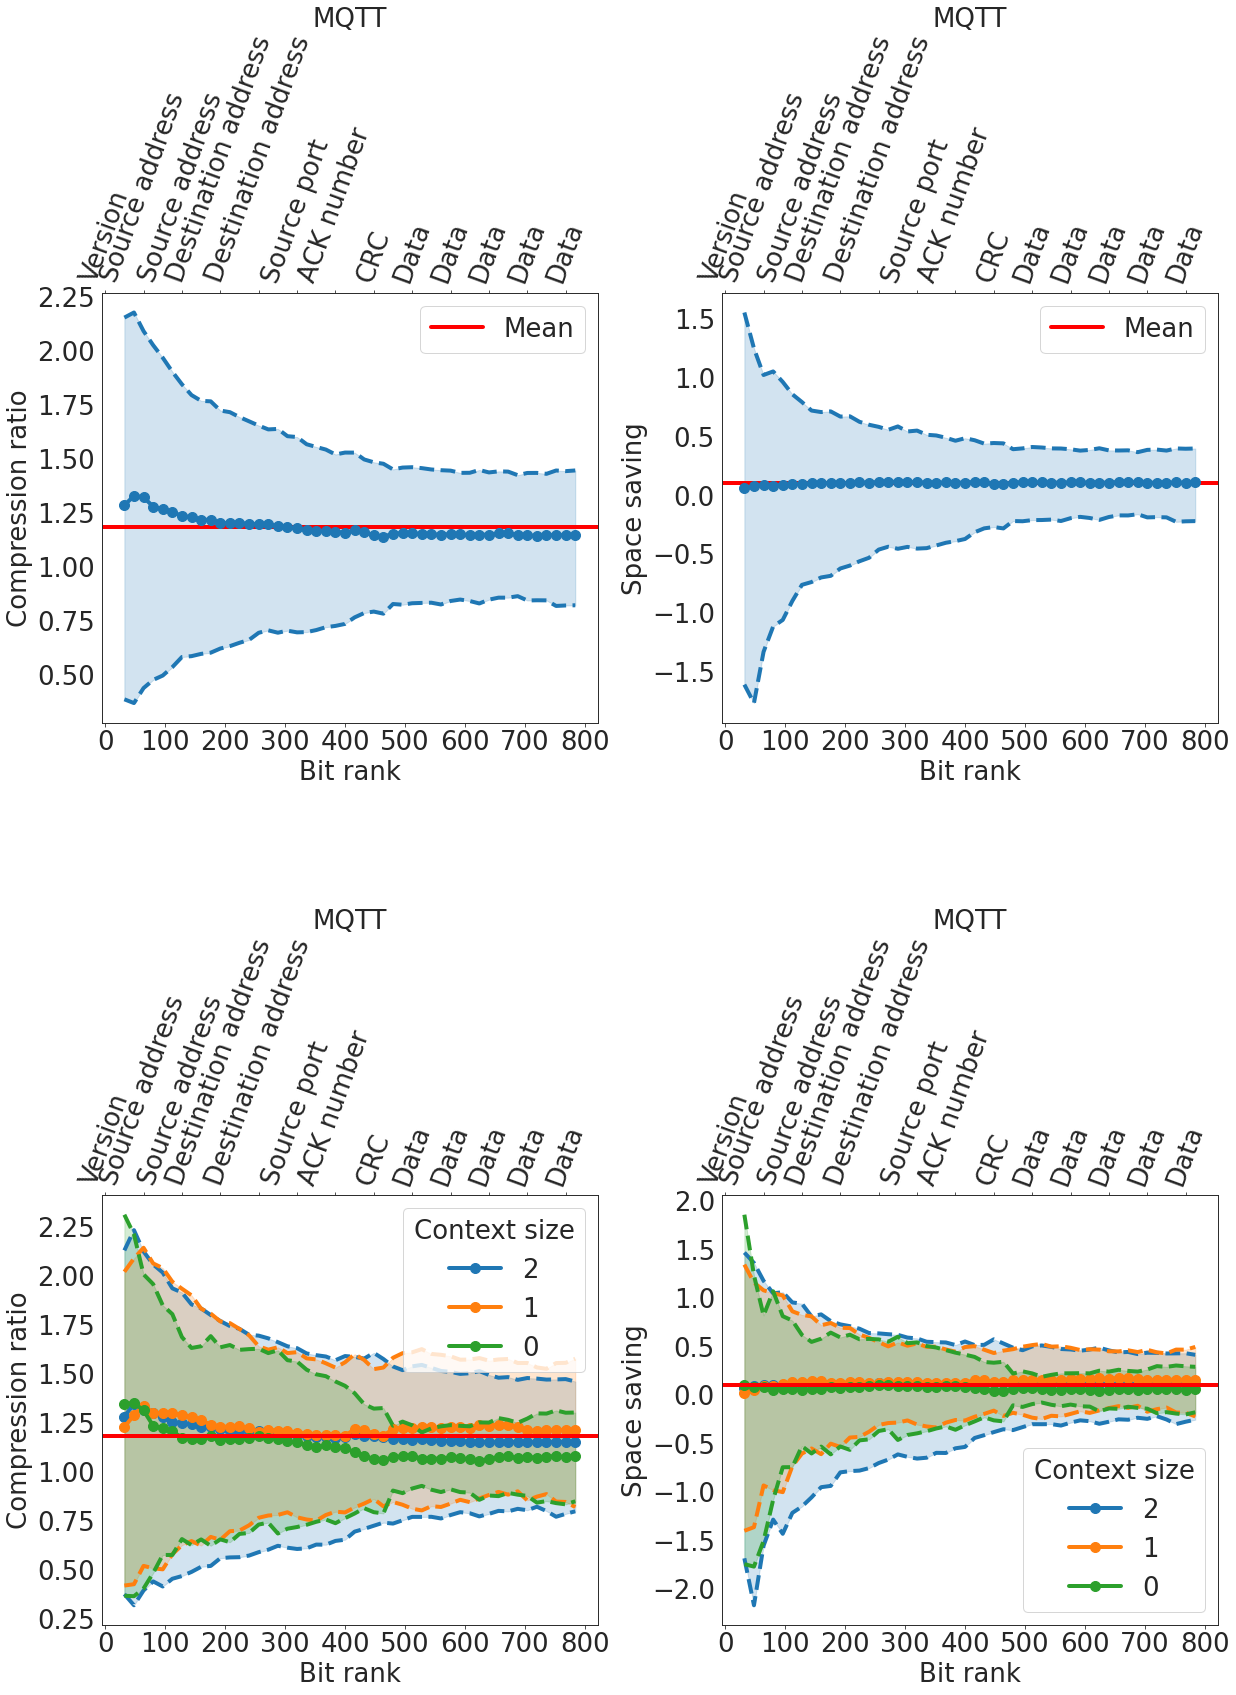

In [83]:
fig, axes = plt.subplots(
    2, 2, figsize=(20, 24.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=1.1)


# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    [None, None, "size_context", "size_context"],
    ['compression_ratio', 'space_saving']*2,
    [f"Compression ratio", f"Space saving"]*2): # f"Compression ratio (U/C)", f"Space saving [1-(C/U)]"]*2

    ax1 = ax
    ax2 = ax1.twiny()

    '''lower = (df_plot[col]-\
        df_plot['low_yerror_'+col]).abs()
    upper = (df_plot['high_yerror_'+col]-\
        df_plot[col]).abs()
    err_bar = [lower, 
               upper]'''
    
    #err_bar = [(df_plot[col]-df_plot['low_yerror'+col]).abs(), 
    #           (df_plot['high_yerror'+col]-df_plot[col]).abs()]
    #err_bar = [df_plot['low_yerror'], 
    #           df_plot['high_yerror']]
    #err_bar = [[0]*df_plot.shape[0], 
    #           [0]*df_plot.shape[0]]

    
    # SET FIRST AXIS

    
    # Set rank 
    if (hue is None):
        df_plot_tmp = df_plot.groupby("bit_ranks") \
                             .mean() \
                             .reset_index(drop=False)
        
        lower = (df_plot_tmp[col]- \
            df_plot_tmp['low_yerror_'+col]).abs()
        upper = (df_plot_tmp['high_yerror_'+col]- \
            df_plot_tmp[col]).abs()
        err_bar = [lower, 
                   upper]
        
        ax1.axhline(y=df_plot_tmp[col].mean(), 
                    linewidth=LINEWIDTH,
                    color='red',
                    label='Mean')
        if (ERROR_BAR):
            '''ax1.errorbar(df_plot_tmp['bit_ranks'], 
                         df_plot_tmp[col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         fmt='o', yerr=err_bar)'''
            ax1.plot(df_plot_tmp['bit_ranks'], 
                     df_plot_tmp[col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     #label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
            
            # Get color from mean plot
            last_line = ax1.get_lines()[-1]
            color_last_line = last_line.get_color()
            
            # Set error area with alpha
            ax1.fill_between(df_plot_tmp['bit_ranks'],
                            df_plot_tmp[col]-lower, 
                            df_plot_tmp[col]+upper,
                            alpha=0.2,
                            color=color_last_line)
            
            # Set min and max for error area
            ax1.plot(df_plot_tmp['bit_ranks'],
                    df_plot_tmp[col]-lower,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            ax1.plot(df_plot_tmp['bit_ranks'],
                    df_plot_tmp[col]+upper,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
        else:
            ax1.plot(df_plot_tmp['bit_ranks'], 
                     df_plot_tmp[col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     #label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
        
        # Set legend
        ax1.legend(fontsize=LEGEND_FONTSIZE)
        
    else:
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .index
        
        for val in unique_values:
            cond = (df_plot[hue] == val)
            
            if (ERROR_BAR):

                lower = (df_plot[cond][col]-\
                    df_plot[cond]['low_yerror_'+col]).abs()
                upper = (df_plot[cond]['high_yerror_'+col]-\
                    df_plot[cond][col]).abs()
                err_bar = [lower, 
                           upper]
                
                #err_bar = [[0]*df_plot[cond].shape[0], 
                #           [0]*df_plot[cond].shape[0]]
                '''ax1.errorbar(df_plot[cond]['bit_ranks'], 
                         df_plot[cond][col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         fmt='o', yerr=err_bar)'''
                ax1.plot(df_plot[cond]['bit_ranks'], 
                         df_plot[cond][col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         alpha=1,
                         label=f"{val}",
                         marker='o',
                         #linestyle="--",
                        )

                # Get color from mean plot
                last_line = ax1.get_lines()[-1]
                color_last_line = last_line.get_color()

                # Set error area with alpha
                ax1.fill_between(df_plot[cond]['bit_ranks'],
                                df_plot[cond][col]-lower, 
                                df_plot[cond][col]+upper,
                                alpha=0.2,
                                color=color_last_line)

                # Set min and max for error area
                ax1.plot(df_plot[cond]['bit_ranks'],
                        df_plot[cond][col]-lower,
                        alpha=1,
                        linestyle='--',
                        linewidth=LINEWIDTH,
                        color=color_last_line)
                ax1.plot(df_plot[cond]['bit_ranks'],
                        df_plot[cond][col]+upper,
                        alpha=1,
                        linestyle='--',
                        linewidth=LINEWIDTH,
                        color=color_last_line)
            else:
                ax1.plot(df_plot[cond]['bit_ranks'], 
                         df_plot[cond][col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         alpha=1,
                         #label=f"{val}",
                         marker='o',
                         #linestyle="--",
                        )
            
            # Set legend
            legend = ax1.legend(#unique_values,
                       fontsize=LEGEND_FONTSIZE)
            legend.set_title('Context size', 
                             prop={'size':LEGEND_FONTSIZE})
            
        ax1.axhline(y=df_plot[col].mean(), 
                    linewidth=LINEWIDTH,
                    color='red')
        

    for item in ax1.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax1.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax1.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax1.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax1.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax1.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax1.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax1.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

    # SET SECOND AXIS


    def tick_function(ranks_bit):
        values = []
        for val in ranks_bit:
            values.append(
                DICT_FIELDS[val])
        return values

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    #if (hue is None):
    new_tick_locations = [i for i in range(
        0, idx_end, 64)]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(
        tick_function(new_tick_locations))

    # Set field name
    #ax2 = ax1.twiny()
    ax2.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax2.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(70)

    ax2.grid(False)

#### 4.2.2 Compression performance HISTOGRAM PER packet (field not threaten) TEST data OTHERS equipment

In [84]:
data_results = pd.read_csv(f"./RESULTS/df_{FULL_NAME}{EXT_NAME}_COMPRESSION.csv")
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

In [85]:
data_results, df_raw = features_extraction(
        data_raw=data_raw, 
        data_results=data_results)

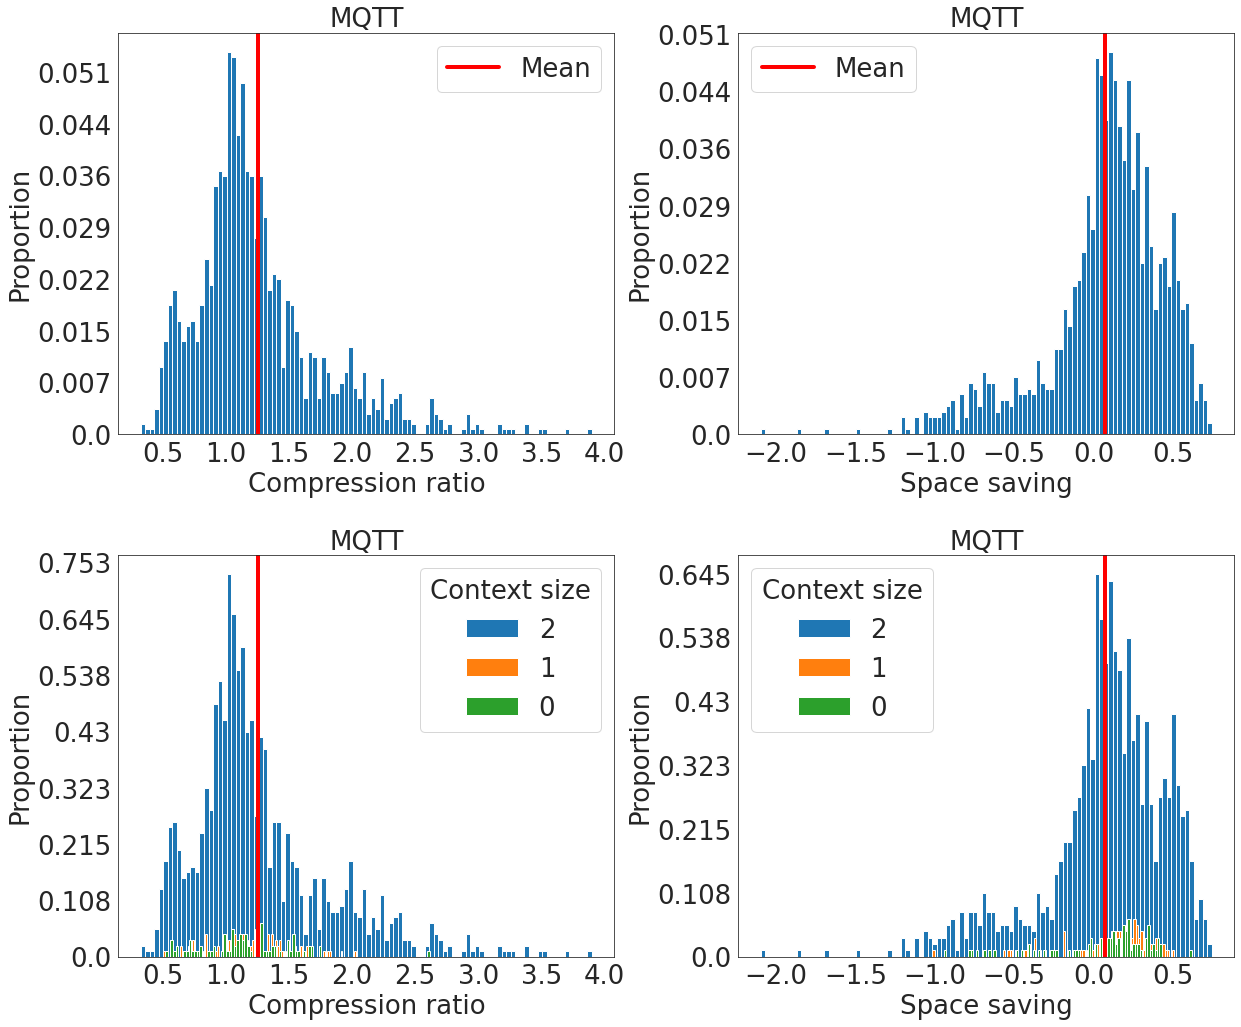

In [86]:
fig, axes = plt.subplots(
    2, 2, figsize=(20, 17))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)


# Parcourir les axes

df_plot = data_results.copy()

for ax, hue, col, title in zip(
    axes.ravel(), 
    [None, None, "size_context", "size_context"],
    ['compression_ratio', 'space_saving']*2,
    [f"Compression ratio", f"Space saving"]*2): # [f"Compression ratio (U/C)", f"Space saving [1-(C/U)]"]
    
    # SET FIRST AXIS

    
    # Set rank 
    if (hue is None):
        ax.axvline(x=df_plot[col].mean(), 
                   linewidth=LINEWIDTH,
                   color='red',
                   label='Mean')
        ax.hist(df_plot[col],
                density=False,
                #linewidth=LINEWIDTH,
                bins=100)
        
        # Set legend
        ax.legend(fontsize=LEGEND_FONTSIZE)
        
        # Normalize axis
        yticklabels = ax.get_yticks() 
        yticklabels_update = np.round(
            yticklabels/df_plot[col].shape[0], 3)
        
    else:
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .index
        
        for val in unique_values:
            cond = (df_plot[hue] == val)
            
            ax.hist(df_plot[cond][col],
                    density=False,
                    #linewidth=LINEWIDTH,
                    bins=100)
            
            # Set legend
            legend = ax.legend(unique_values, 
                      fontsize=LEGEND_FONTSIZE)
            legend.set_title('Context size', 
                             prop={'size':LEGEND_FONTSIZE})
            
        ax.axvline(x=df_plot[col].mean(), 
                   linewidth=LINEWIDTH,
                   color='red')
        
        # Normalize axis
        yticklabels = ax.get_yticks() 
        yticklabels_update = np.round(
            yticklabels/df_plot[cond][col].shape[0], 3)
        
    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)
        
    # Set normalized labels
    ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        
    # Set label  
    ax.set_ylabel("Proportion", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"{title}", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

#### 4.2.2 Occlusion MAP application probability difference analysis

In [232]:
data_fields = pd.read_csv(f"./RESULTS/df_FIELDS_{FULL_NAME}{EXT_NAME}.csv")
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

FileNotFoundError: [Errno 2] No such file or directory: './RESULTS/df_FIELDS_LOSSLESS_CONTEXT2_PACKET16_SIN8_HTTP_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain.csv'

In [148]:
data_results = features_extraction(
        data_raw=data_raw, 
        data_results=data_results)

##### 4.2.2.1 BOXPLOT

(0.0, 1.1)

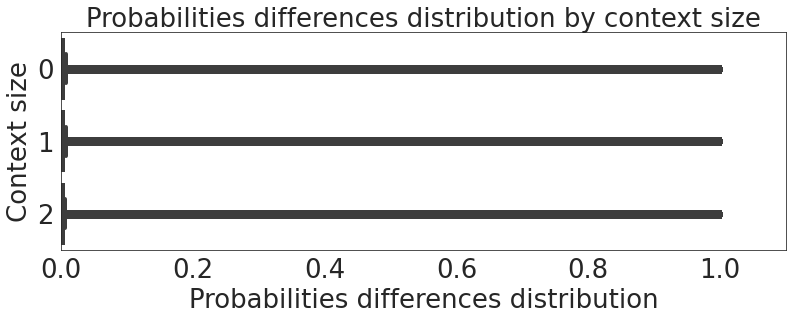

In [151]:
fig, ax = plt.subplots(
    1,  1, 
    figsize=(13, 4))

RANK_PROBA = 40
cols_proba = [f"proba_{i}" for i in range(RANK_PROBA)]
df_plot = pd.DataFrame()

for i in range(
    LOOK_BACK_CONTEXT+1):
    
    if (i == LOOK_BACK_CONTEXT):
        cond_rltv_flow = (
            data_fields["idx_rltv_flow"] >= i)
    else:
        cond_rltv_flow = (
            data_fields["idx_rltv_flow"] == i)
    
    proba_values = data_fields[
        cond_rltv_flow][cols_proba].values.ravel()
    
    # Save values
    df_plot_tmp = pd.DataFrame()
    df_plot_tmp['proba'] = proba_values
    df_plot_tmp['index_rltv_flow'] = str(i)
    
    # Concat values
    df_plot = pd.concat(
        [df_plot, df_plot_tmp], axis=0)

sns.boxplot(x="proba", y="index_rltv_flow", 
            data=df_plot, ax=ax, linewidth=LINEWIDTH)

ax.set_title("Probabilities differences distribution by context size", 
             fontsize=TITLE_FONTSIZE)

ax.set_ylabel("Context size",
              fontsize=TITLE_FONTSIZE)
ax.set_xlabel("Probabilities differences distribution",
              fontsize=TITLE_FONTSIZE)

ax.tick_params(labelsize=TICK_FONTSIZE)

ax.set_xlim([0, 1.1])

##### 4.2.2.2 Histogram

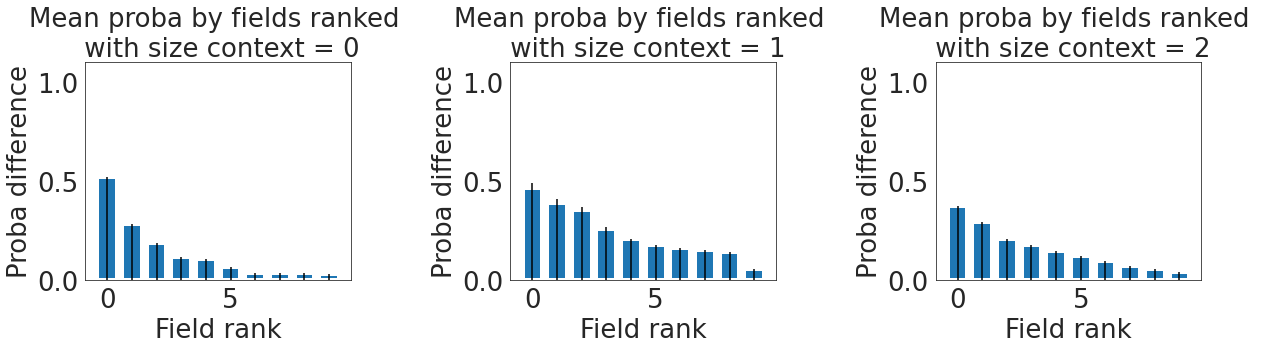

In [56]:
fig, axes = plt.subplots(
    1,  LOOK_BACK_CONTEXT+1, 
    figsize=(20, 4))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.6, 
                    hspace=0.2)

rank_proba = 10
alpha=0.95
cols_proba = [f"proba_{i}" for i in range(rank_proba)]
#err_bar = [[0.1]*rank_proba, 
#           [0.1]*rank_proba]

for i , ax in zip(range(
    LOOK_BACK_CONTEXT+1), 
    axes.ravel()):
    
    if (i == LOOK_BACK_CONTEXT):
        cond_rltv_flow = (
            data_fields["idx_rltv_flow"] >= i)
    else:
        cond_rltv_flow = (
            data_fields["idx_rltv_flow"] == i)
        
    df_tmp = data_fields[
        cond_rltv_flow][cols_proba]
    
    proba_ranks = df_tmp \
        .mean(axis=0)
    
    # Compute std compression ratio
    p = ((1.0-alpha)/2.0) 
    lower = df_tmp.quantile(q=p, axis=0)
    p = (alpha+((1.0-alpha)/2.0))
    upper = df_tmp.quantile(q=p, axis=0)
    
    err_bar = [(proba_ranks-upper).abs(), 
               (df_plot_high_yerror-lower).abs()]
    
    #err_bar = [upper, 
    #           lower]
        
    ax.bar(x=np.arange(0, rank_proba), 
           height=proba_ranks,
           yerr=err_bar, 
           linewidth=LINEWIDTH)
    
    ax.set_title(f"Mean proba by fields ranked \n with size context = {i}", 
                 fontsize=TITLE_FONTSIZE)
    
    ax.set_ylabel("Proba difference",
                  fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Field rank",
                  fontsize=TITLE_FONTSIZE)
    
    ax.tick_params(labelsize=TICK_FONTSIZE)
    
    ax.set_ylim([0, 1.1])

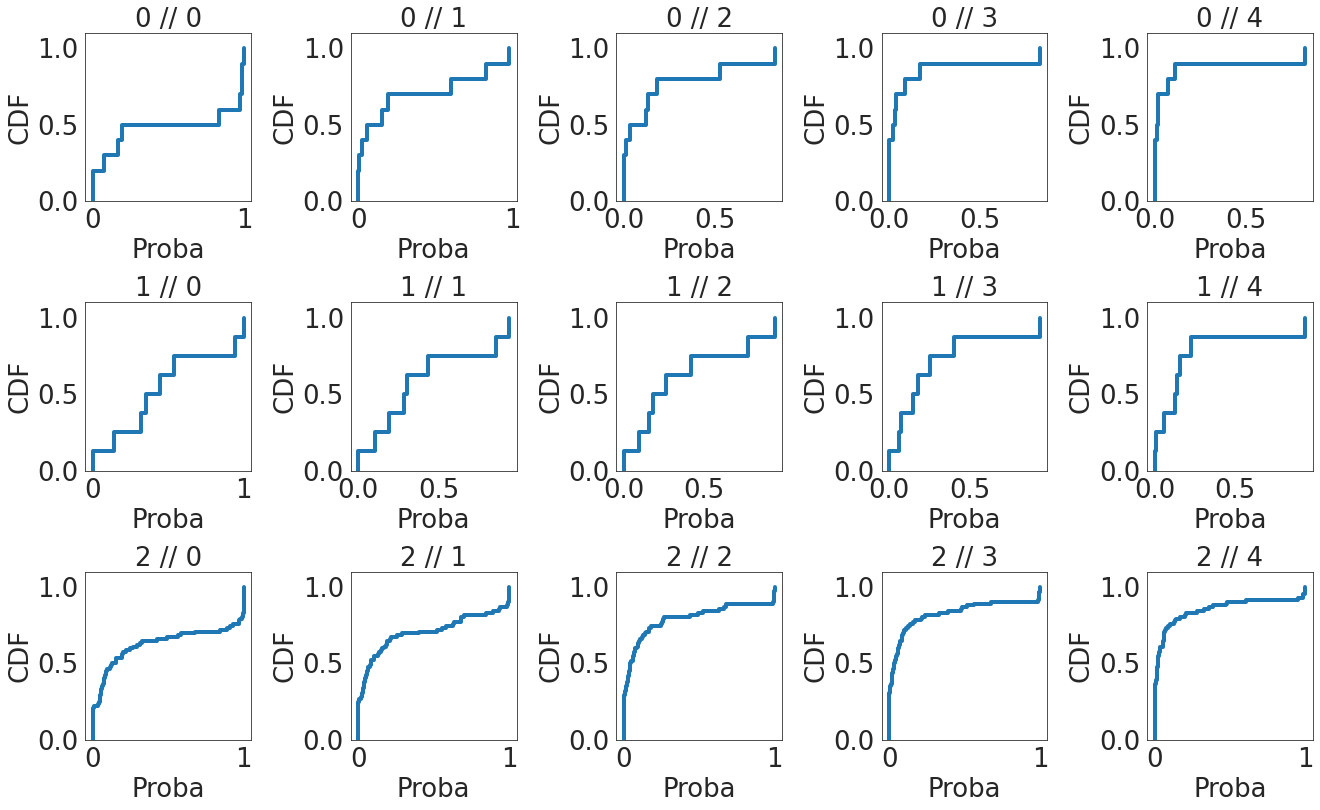

In [57]:
# Exemple de quelques histogramme individuel 

RANK_PROBA = 5

fig, axes = plt.subplots(
    LOOK_BACK_CONTEXT+1,  RANK_PROBA, 
    figsize=(22, 13))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.6, 
                    hspace=0.6)

cols_proba = [f"proba_{i}" for i in range(RANK_PROBA)]
#err_bar = [[0.1]*rank_proba, 
#           [0.1]*rank_proba]

# Parcourir les context
for i in range(
    LOOK_BACK_CONTEXT+1):
    
    # Parcourir les field rank
    for j in range(RANK_PROBA): 
    
        # Extract cond relative to context
        if (i == LOOK_BACK_CONTEXT):
            cond_rltv_flow = (
                data_fields["idx_rltv_flow"] >= i)
        else:
            cond_rltv_flow = (
                data_fields["idx_rltv_flow"] == i)

        df_tmp = data_fields[
            cond_rltv_flow][f"proba_{j}"]
        
        sns.ecdfplot(x=df_tmp.values,
                     ax=axes[i, j], 
                     linewidth=LINEWIDTH)
        #axes[i, j].hist(x=df_tmp.values, 
        #                bins=10,
        #                cumulative=True)

        axes[i, j].set_title(f"{i} // {j}", 
                     fontsize=TITLE_FONTSIZE)

        axes[i, j].set_ylabel("CDF",
                      fontsize=TITLE_FONTSIZE)
        axes[i, j].set_xlabel("Proba",
                      fontsize=TITLE_FONTSIZE)

        axes[i, j].tick_params(labelsize=TICK_FONTSIZE)

        axes[i, j].set_ylim([0, 1.1])

#### 4.4.4 Define empiricaly number fo bit for huffman table (i.e rank important per context size)

In [155]:
data_fields = pd.read_csv(f"{RESULTS_DIR}df_FIELDS_{FULL_NAME}{EXT_NAME}.csv")
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

In [157]:
data_results = features_extraction(
        data_raw=data_raw, 
        data_results=data_results)

In [158]:
MAX_RANK = 40
cols = [f"rank_{i}" for i in range(MAX_RANK)]
indexes_rltv_pkt = data_fields["index_rltv_pkt"]\
                        .value_counts()\
                        .index.astype(int)

index_df = 0
df_results = pd.DataFrame(columns=["index_rltv_pkt",
                                   "size_context",
                                   "count_unique",
                                   "field_rank",
                                   "coeff"])

cols_ranks = [f"field_rank_{i}" for i in range(MAX_RANK)]
df_ranks = pd.DataFrame(columns=cols_ranks+[
                        "index_rltv_pkt", 
                        "size_context", 
                        "rank"])

# Pour chaque position relatif du block
for i in tqdm(
    indexes_rltv_pkt[2:4]):
    
    for z in range(LOOK_BACK_CONTEXT):
        
        if (z == LOOK_BACK_CONTEXT):
            cond_rltv_flow = (
                data_fields["size_context"] >= z)
        else:
            cond_rltv_flow = (
                data_fields["size_context"] == z)
            
        #print("[DEBUG] i // j : ", i, " // ", z)
            
        data_fields_flow = data_fields[cond_rltv_flow]
        cond_rltv_pkt = (data_fields_flow["index_rltv_pkt"] == i)
        #print("[DEBUG] df_fields_flow shape", df_fields_flow.shape)
    
        # Pour chaque columns de la position relative
        for j, col in enumerate(cols):
            
            values = data_fields_flow[
                cond_rltv_pkt][col].values
            unique_values, count = np.unique(
                values, return_counts=True)
            count_sort_ind = np.argsort(-count)
            
            #print("[DEBUG] unique_values : ", unique_values)

            # Extract unique values
            unique_values = unique_values[
                count_sort_ind]
            count = count[count_sort_ind]
            
            #print("[DEBUG] unique_values : ", unique_values)

            # Get all unique values since last rank
            cols_tmp = [f"rank_{k}" for k in range(j+1)]
            values_tmp = data_fields_flow[
                cond_rltv_pkt][cols_tmp].values.ravel()
            
            #print("[DEBUG] values_tmp : ", values_tmp)
            
            unique_values_tmp, count_tmp = np.unique(
                values_tmp, return_counts=True)
            
            #print("[DEBUG] count_tmp.sum() : ", 
            #      count_tmp.sum(), " : ", unique_values_tmp)
            
            #coeff_unique_rank = (
            #    (min(count_tmp.sum(), MAX_RANK) - \ # MAX_RANK i.e. max_field 
            #     unique_values_tmp.size) / min(
            #        count_tmp.sum(), MAX_RANK))
            coeff_unique_rank = \
                (j+1) / unique_values_tmp.size
                
            # Save results for coeff unique 
            df_results.loc[index_df] = [i, # index_rltv_pkt
                                        z, # index_rltv_flow
                                        unique_values.size,
                                        j,
                                        coeff_unique_rank]

            # Update coeff
            index_df += 1

100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


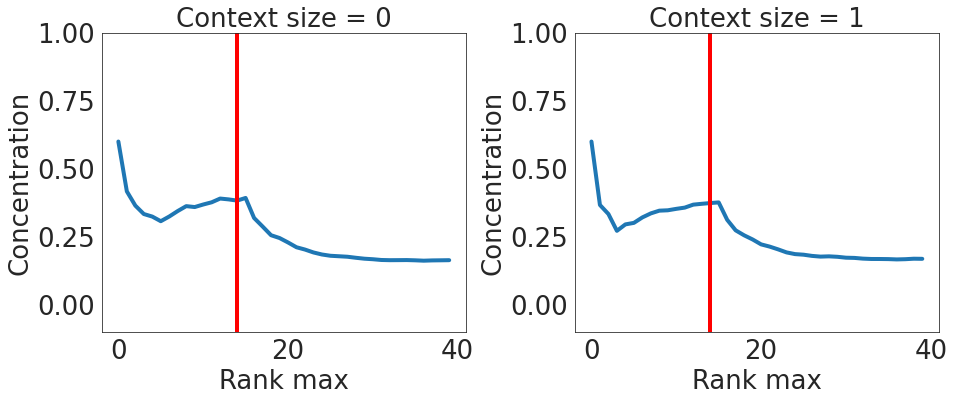

In [162]:
# Extract DF plot
df_plot = df_results.groupby(
    ['size_context', 
     'field_rank']).mean()['coeff']

# On recupère les positions de context importante !
index_rltv_flow = np.unique(
    df_plot.index.get_level_values(
    level=0), return_counts=False)

# Depend about the number of relative flow
if (index_rltv_flow.size == 1):
    
    # Set figure
    fig, ax = plt.subplots(
        1, index_rltv_flow.size, 
        figsize=(7, 5.5))
    
    axvline = [14] * index_rltv_flow.size
    idx_rltv_flow = index_rltv_flow[0]

    _ = sns.lineplot(x=df_plot.loc[(idx_rltv_flow ,)].index, 
                     y=df_plot.loc[(idx_rltv_flow ,)].values, 
                     linewidth=LINEWIDTH, ax=ax)
    ax.axvline(x=axvline[0], 
               linewidth=LINEWIDTH,
               color='red', 
               label='Cut value threshold')
    ax.tick_params(labelsize=TICK_FONTSIZE)
    
    ax.set_ylim([-0.1, 1])
    ax.set_ylabel("Concentration", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Rank max", 
                  fontsize=LABEL_FONTSIZE)
    # f"Index rltv flow {idx_rltv_flow}" => context size
    ax.set_title(f"Context size",
                 fontsize=TITLE_FONTSIZE)
    
else:
    
    # Set figure
    fig, axes = plt.subplots(
        1, index_rltv_flow.size, 
        figsize=(15, 5.5))

    #left  = 0.125  # the left side of the subplots of the figure
    #right = 0.9    # the right side of the subplots of the figure
    #bottom = 0.1   # the bottom of the subplots of the figure
    #top = 0.9      # the top of the subplots of the figure
    #wspace = 0.2   # the amount of width reserved for blank space between subplots
    #hspace = 0.2   # the amount of height reserved for white space between subplots
    fig.subplots_adjust(wspace=0.3, 
                        hspace=0.6)
    
    axvline = [14] * index_rltv_flow.size
    for i, ax in enumerate(
        axes.ravel()):

        idx_rltv_flow = index_rltv_flow[i]

        _ = sns.lineplot(x=df_plot.loc[(idx_rltv_flow ,)].index, 
                         y=df_plot.loc[(idx_rltv_flow ,)].values, 
                         linewidth=LINEWIDTH,
                         ax=ax)
        ax.axvline(x=axvline[i], 
                   linewidth=LINEWIDTH,
                   color='red', 
                   label='Cut value threshold')
        ax.tick_params(labelsize=TICK_FONTSIZE)
    
        ax.set_ylim([-0.1, 1])
        ax.set_ylabel("Concentration", 
                      fontsize=LABEL_FONTSIZE)
        ax.set_xlabel("Rank max", 
                      fontsize=LABEL_FONTSIZE)
        # f"Index rltv flow {idx_rltv_flow}" => context size
        ax.set_title(f"Context size = {int(idx_rltv_flow)}",
                     fontsize=TITLE_FONTSIZE)

#### 4.4.5 Compression performance nb bits for Huffman table (LINEPLOT)

In [21]:
ERROR_BAR = True
CUT_VALUES = [4, 8, 12, 16, 20, 28] #, 32, 36, 44]

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

for k_e in [True, False]:
    for c_val in CUT_VALUES:
        
        # Change extension name        
        if (k_e):
            ext_name_huffman =  "_HUFFMAN" + EXT_NAME + f"_KEEP_ERROR_{c_val}_DECIMALSNone"
            filename = (f"{RESULTS_DIR}df_{FULL_NAME}{ext_name_huffman}"
                        f"_COMPRESSION.csv")
        else:
            ext_name_huffman = "_HUFFMAN" + EXT_NAME + f"_{c_val}_DECIMALSNone"
            filename = (f"{RESULTS_DIR}df_{FULL_NAME}{ext_name_huffman}"
                        f"_COMPRESSION.csv")

        data_results_tmp = pd.read_csv(filename)
        
        data_results_tmp = features_extraction(
            data_raw=data_raw, 
            data_results=data_results_tmp)
        
        # Set values specific to huffman
        data_results_tmp["cut_values"] = c_val
        data_results_tmp["keep_error"] = k_e
        
        # Concat to array
        data_results = pd.concat(
            [data_results, 
             data_results_tmp], axis=0)

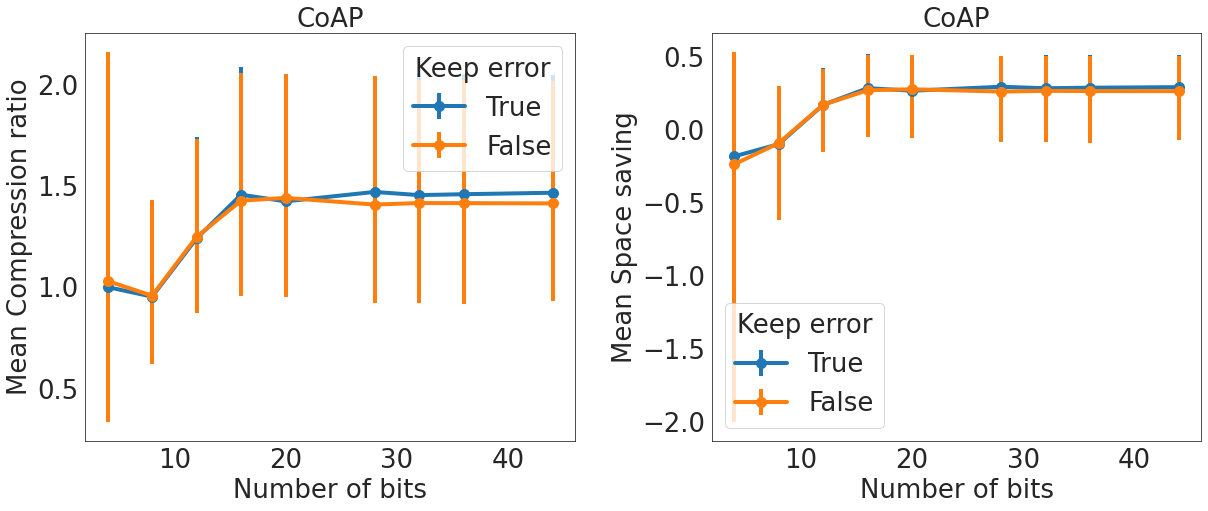

In [41]:
# Change linewidth lengend 
from matplotlib.legend_handler import HandlerLine2D

# Plot MEAN and STD
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
alpha=0.95

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.28, 
                    hspace=0.35)

# Parcourir les axes

for ax, col, title in zip(
    axes.ravel(),
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): #[f"compression ratio (U/C)", f"space saving [1-(C/U)]"]
    
    for k_e in [True, False]:
        
        # Extract k_e
        cond = (data_results['keep_error'] == k_e)
        
        # Get MEAN
    
        df_plot_mean = data_results[cond]\
            .groupby(["cut_values"])\
             .mean().reset_index()
        
        # Create ERROR BAR
    
        p = ((1.0-alpha)/2.0) 
        df_plot_low_yerror = data_results[cond]\
                .groupby(["cut_values"])\
                 .quantile(p)\
                 .reset_index()[col]
        
        p = (alpha+((1.0-alpha)/2.0))
        df_plot_high_yerror = data_results[cond]\
                 .groupby(["cut_values"])\
                 .quantile(p) \
                 .reset_index()[col]
        err_bar = [(df_plot_mean[col]-df_plot_low_yerror).abs(), 
                   (df_plot_high_yerror-df_plot_mean[col]).abs()]
        
        # Plot error 
        
        if (ERROR_BAR):
            ax.errorbar(df_plot_mean['cut_values'], 
                        df_plot_mean[col],
                        linewidth=LINEWIDTH,
                        markersize=MARKERSIZE, # Size of point
                        fmt='o-', yerr=err_bar)
        else:
            ax.scatter(df_plot_mean['cut_values'], 
                         df_plot_mean[col],
                         linewidth=LINEWIDTH)
        
    ax.set_ylabel(f"Mean {title}",
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Number of bits",
                  fontsize=LABEL_FONTSIZE)
    ax.tick_params(labelsize=TICK_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(LINEWIDTH)
    
for ax in axes.ravel():
    
    # Set legend
    legend = ax.legend(
        ["True", "False"],
        fontsize=LEGEND_FONTSIZE,
        handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
    legend.set_title('Keep error', 
                     prop={'size':LEGEND_FONTSIZE})

#### 4.4.5 Compression performance nb bits for Huffman table (BOXPLOT)

In [72]:
CUT_VALUES = [2, 4, 6, 8, 10]#, 12, 16] # 20, 32, 36, 44]
PROTO = 'SMTP'
USE_DCH = True
USE_BASELINE = True
LEFT_PADDING = True

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

# Add baseline in comparaison
if (USE_BASELINE):
    
    # Add baseline
    CUT_VALUES.insert(0, "Base.")
    
    look_back_context = 1
    look_back_packet = 8
    full_name = f"LOSSLESS_PACKET{look_back_packet}_{PROTO}"
    ext_name = "_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_DECIMALSNone"
    if (LEFT_PADDING):
        ext_name += "_LEFT_PADDING"
    data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}_BASELINE_NAIVE{ext_name}_COMPRESSION.csv")
    
    # Set values specific to huffman
    data_results_tmp["cut_values"] = "Base."
    data_results_tmp["keep_error"] = True
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
    
# Add baseline in comparaison
if (USE_DCH):
    
    # Add baseline
    CUT_VALUES.insert(1, "DCH")
    
    look_back_context = 2
    look_back_packet = 16
    full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{look_back_packet}_SIN{NUM_SIN}_{PROTO}"
    ext_name = '_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_LEFT_PADDING'
    data_results_tmp = pd.read_csv(f"./RESULTS/DEEP_LEARNING/df_{full_name}{ext_name}_COMPRESSION.csv")
    
    data_results_tmp["cut_values"] = "DCH"
    data_results_tmp["keep_error"] = True
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)


for k_e in [True]: #, False]:
    for c_val in CUT_VALUES[2:]:
        
        full_name = f'LOSSLESS_CONTEXT2_PACKET16_SIN8_{PROTO}'
        
        # Change extension name        
        if (k_e):
            ext_name_huffman =  "_HUFFMAN" + '_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain' + f"_KEEP_ERROR_{c_val}_DECIMALSNone"
        else:
            ext_name_huffman = "_HUFFMAN" + '_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain' + f"_{c_val}_DECIMALSNone"
            
        if (LEFT_PADDING):
            ext_name_huffman += "_SELECTIVE_OPTIMAL_LEFT_PADDING" 
        else:
            ext_name_huffman += "_SELECTIVE_OPTIMAL" 
            
        filename = (f"./RESULTS/HUFFMAN/DEEP_LEARNING/df_{full_name}{ext_name_huffman}"
                    f"_COMPRESSION.csv")

        data_results_tmp = pd.read_csv(filename)
        
        data_results_tmp, _ = features_extraction(
            data_raw=data_raw, 
            data_results=data_results_tmp)
        
        # Set values specific to huffman
        data_results_tmp["cut_values"] = c_val
        data_results_tmp["keep_error"] = k_e
        
        # Concat to array
        data_results = pd.concat(
            [data_results, 
             data_results_tmp], axis=0)

'for ax in axes.ravel():\n    \n    # Set legend\n    legend = ax.legend(\n        #["True", "False"],\n        fontsize=LEGEND_FONTSIZE,\n        loc="upper right")#,\n        #handler_map={plt.Line2D : HandlerLine2D(update_func=update)})\n        \n    #legend.set_title(\'Keep error\', \n    #                 prop={\'size\':LEGEND_FONTSIZE})'

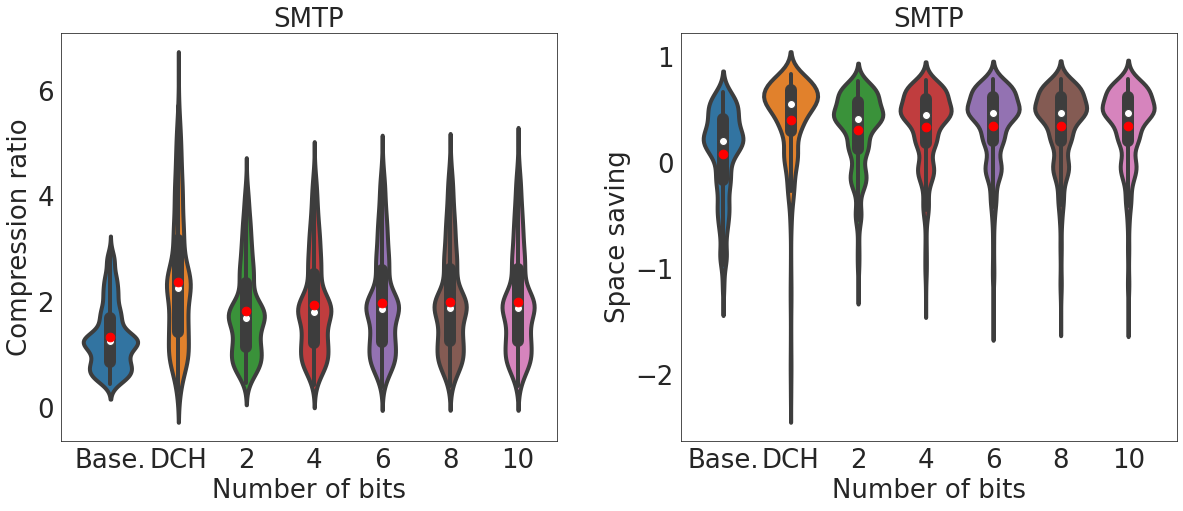

In [73]:
# Plot MEAN and STD
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
alpha=0.95

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

# Parcourir les axes

for ax, col, title in zip(
    axes.ravel(),
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): #[f"compression ratio (U/C)", f"space saving [1-(C/U)]"]
    
    #for k_e in [True, False]:
        
        # Extract k_e
        #cond = (data_results['keep_error'] == k_e)
        
        # Get MEAN
    
        #df_plot_mean = data_results[cond]\
        #    .groupby(["cut_values"])\
        #     .mean().reset_index()

    # Plot error 
    '''sns.boxplot(x='cut_values', 
                y=col, data=data_results, 
                hue='keep_error',
                showmeans=True,
                meanprops={"marker": "o",
                           "markerfacecolor":"red",
                           "markeredgecolor": "red",
                           "markersize": "10"},
                linewidth=LINEWIDTH,
                ax=ax)'''
    
    # Stats
    means = data_results.groupby('cut_values')[col]\
                        .mean().loc[CUT_VALUES]
    
    #{“box”, “quartile”, “point”, “stick”, None}
    sns.violinplot(x='cut_values', 
                   y=col, 
                   data=data_results, 
                   #hue='keep_error',
                   showmeans=True,
                   meanprops={"marker": "o",
                               "markerfacecolor":"red",
                               "markeredgecolor": "red",
                               "markersize": "10"},
                   linewidth=LINEWIDTH,
                   inner="box",
                   #inner=None,
                   ax=ax)
    
    ax.scatter(x=range(len(means)), 
               y=means, c="red",
               s=75,
               zorder=100)
    
    #plt.setp(ax.collections, alpha=.3)
    
    # Set man marker
    #ax.scatter(x=range(len(means)), 
    #           y=means, c="white",
    #           s=75)
    #sns.pointplot(x='cut_values', 
    #              y=col, 
    #              color='red',
    #              markers='o',
    #              data=data_results, 
    #              estimator=np.mean,
    #              ax=ax)
    #ax.scatter(x=range(len(Modes)),y=Modes)
 
    ax.set_ylabel(f"{title}",
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Number of bits",
                  fontsize=LABEL_FONTSIZE)
    ax.tick_params(labelsize=TICK_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(LINEWIDTH)
    
'''for ax in axes.ravel():
    
    # Set legend
    legend = ax.legend(
        #["True", "False"],
        fontsize=LEGEND_FONTSIZE,
        loc="upper right")#,
        #handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
        
    #legend.set_title('Keep error', 
    #                 prop={'size':LEGEND_FONTSIZE})'''

In [22]:
# Setthe dict field
DICT_FIELDS = {}

if ('LORA' in PROTO):
    
    # LoRaWAN
    
    ## Mtype
    idx_start = 0
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Mtype"
            
    ## RFU
    idx_start = idx_end
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "RFU"
    
    ## Major
    idx_start = idx_end
    idx_end = idx_start + 2
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Major"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "DevAddr"
        
    ## Fctrl
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Fctrl"
        
    ## FCnt
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FCnt"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FOpts"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"


elif (PROTO in ['HTTP', 'SMTP', 'SSH', 'DNS']):
    
    # IPv4
    
    ## Set IP/HL/ToS
    idx_start = 0
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "IP/HL/ToS"
        
    ## Total length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Total length"
        
    ## Identification
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Id" # entification
        
    ## Indicator/FO
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Indicator/FO"
        
    ## TTL/Protocol
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "TTL/Protocol"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"
        
        
    # data_raw['length_0'] - data_raw['length_1']
    ip_header_length = (data_raw['length_0'] - \
                        data_raw['length_1']) \
                            .value_counts() \
                            .index.max()
    
    if (ip_header_length > 20):
        
        ## Options
        idx_start = idx_end
        idx_end = idx_start + 32
        for i in range(idx_start, idx_end):
            DICT_FIELDS[i] = "Options"
        
    
    print("[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end: ", 
          idx_end)
   # DICT_FIELDS = {v: k for k, v in enumerate(range(500))}
    
elif (PROTO in ["COAP", "MQTT_IEEE"]):
    
    # IPv6
    
    ## Version
    idx_start = 0
    idx_end = idx_start + 4
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Version"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Traffic class"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 20
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Flow label"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Payload length"
        
    ## Next header
    idx_start =  idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Next header"
        
    ## Hop limit
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Hop limit"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"


# Mettre champs TCP / UDP

if (PROTO in ['HTTP', 'SMTP', 'SSH', 'MQTT_IEEE']):
    
    # TCP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst port"
            
    ## Sequence number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Seq. number"
        
    ## ACK number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "ACK number"
        
    ## HL/Flags
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "HL/Flags"
        
    ## Windows
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Windows"
        
    ## CRC
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "CRC"
        
    ## Urgent pointer
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Urgent pointer"
        
    ## Option/Padding
    #idx_start = idx_end
    #idx_end = idx_start + 32
    #for i in range(idx_start, idx_end):
    #    DICT_FIELDS[i] = "Option/Padding"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"
        
    
elif (PROTO in ["DNS", 'COAP']):
    
    # UDP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dest. port"
        
    ## Length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Length"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"

[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end:  160


In [36]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
sizes_context = []
cut_values = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []

for i in range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    for j in CUT_VALUES:
        
        cond_look_back_context = (data_results[
            'cut_values'] == j)
        data_results_tmp = data_results[
            cond_look_back_context]
        
        # IF l'array is empty
        if (data_results_tmp.shape[0] != 0):

            # Init first steps

            '''bit_ranks.append(0)
            compression_ratio.append(0)
            space_saving.append(0)
            sizes_context.append(i)
            look_back_contexts.append(j)

            low_yerror_compression_ratio.append(0)
            high_yerror_compression_ratio.append(0)

            low_yerror_space_saving.append(0)
            high_yerror_space_saving.append(0)'''

            # Compute each compress level

            for col in data_results.columns:
                if ("level_compress" in col):

                    # Add context size info
                    sizes_context.append(i)
                    cut_values.append(j)

                    # Extract bit rank
                    bit_rank = int(col.split("_")[-1])+1
                    bit_ranks.append(
                        bit_rank)

                    # Compute mean compresssion ratio
                    # Compression ratio = uncompressed / compressed
                    # for rank k
                    df_tmp_compression_ratio = bit_rank / \
                        data_results_tmp[col]
                    df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                    bit_rank)

                    ## Remove -1
                    cond = (data_results_tmp[col] != -1)
                    df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                    df_tmp_space_saving = df_tmp_space_saving[cond]
                    
                    #print("[DEBUG] np.isinf(df_tmp_compression_ratio).any(): ",
                    #         np.isinf(df_tmp_compression_ratio).any())
                    #if (np.isinf(df_tmp_compression_ratio).any()):
                    #    print("[DEBUG][if] data_results_tmp[col].value_counts(): ", 
                    #          data_results_tmp[col].value_counts())
                    
                    # Replace inf values
                    if (np.isinf(df_tmp_compression_ratio).any()):
                    
                        ## Index with inf values
                        cond = (df_tmp_compression_ratio \
                                    .isin([np.inf, -np.inf]))
                        indexes_inf = df_tmp_compression_ratio[cond].index

                        ## Get right values
                        values_new = data_results_tmp[
                            "headers_length"].iloc[indexes_inf]

                        ## Set the right values
                        df_tmp_compression_ratio \
                            .iloc[indexes_inf] = values_new.values

                    compression_ratio.append(
                        df_tmp_compression_ratio.mean())
                    space_saving.append(
                        df_tmp_space_saving.mean())

                    if (df_tmp_compression_ratio.shape[0] != 0):

                        # Compute std compression ratio
                        p = ((1.0-alpha)/2.0)
                        lower_compression_ratio = np.percentile(
                                df_tmp_compression_ratio.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_compression_ratio = np.percentile(
                                 df_tmp_compression_ratio.values, p)

                        # Compute std space saving
                        p = ((1.0-alpha)/2.0)
                        lower_space_saving = np.percentile(
                                df_tmp_space_saving.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_space_saving = np.percentile(
                                 df_tmp_space_saving.values, p)

                    else:
                        # Compression ratio
                        lower_compression_ratio = 0
                        upper_compression_ratio = 0

                        # Space saving
                        lower_space_saving = 0
                        upper_space_saving = 0

                    low_yerror_compression_ratio\
                        .append(lower_compression_ratio)
                    high_yerror_compression_ratio\
                        .append(upper_compression_ratio)

                    low_yerror_space_saving\
                        .append(lower_space_saving)
                    high_yerror_space_saving\
                        .append(upper_space_saving)


# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['size_context'] = sizes_context
df_plot['cut_values'] = cut_values

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

# Extract difference

'''df_plot_diff = df_plot[
    ['compression_ratio', 
     'space_saving']] \
        .diff(1).fillna(0) \
        .rename(columns={'compression_ratio':'compression_ratio_diff',
                         'space_saving':'space_saving_diff'})
df_plot = pd.concat(
    [df_plot, df_plot_diff], axis=1)'''

"df_plot_diff = df_plot[\n    ['compression_ratio', \n     'space_saving']]         .diff(1).fillna(0)         .rename(columns={'compression_ratio':'compression_ratio_diff',\n                         'space_saving':'space_saving_diff'})\ndf_plot = pd.concat(\n    [df_plot, df_plot_diff], axis=1)"

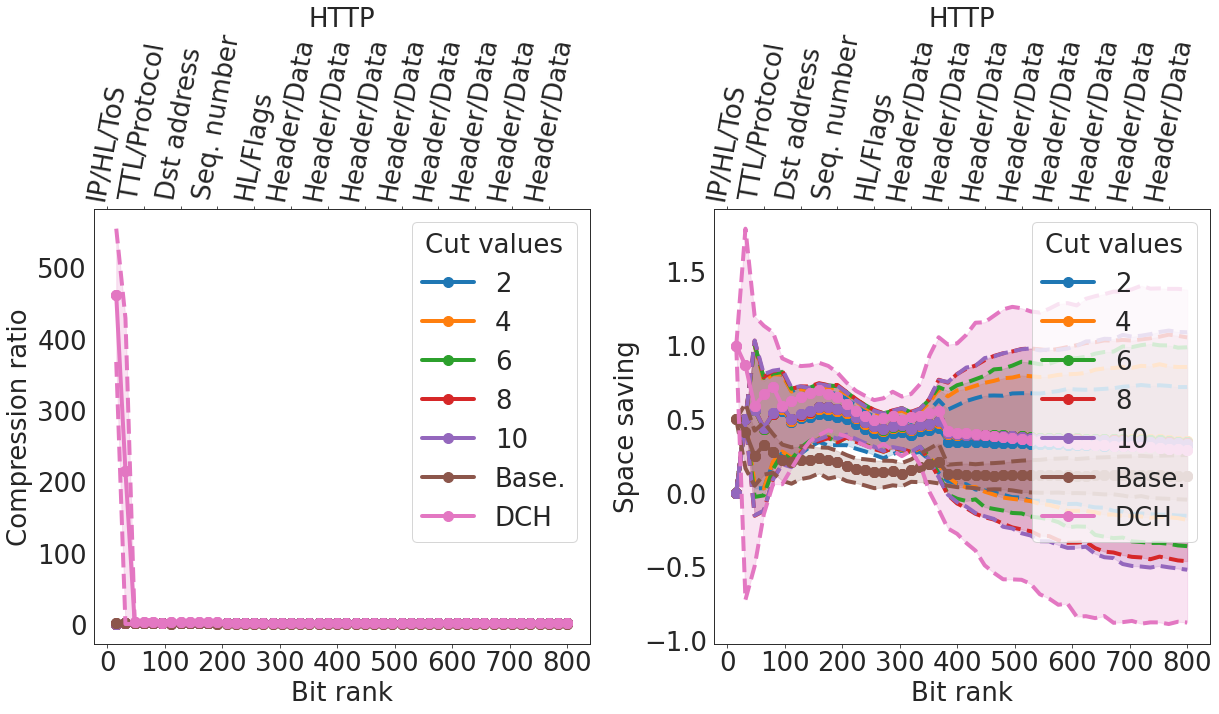

In [43]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 8))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=1.1)

# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['cut_values']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    ax1 = ax
    ax2 = ax1.twiny()

    #err_bar = [[0]*df_plot.shape[0], 
    #           [0]*df_plot.shape[0]]

    
    # SET FIRST AXIS

    
    # Check if we use baseline
    if (USE_BASELINE):
        
        # Define condition
        cond = ((df_plot[hue] != "Base.") & 
                (df_plot[hue] != "DCH"))
        
        # Set rank 
        unique_values = df_plot[cond][hue] \
                            .astype(int) \
                            .value_counts()\
                            .sort_index()\
                            .index
        
        unique_values = \
            list(unique_values) + \
                ["Base.", 'DCH']
    else:
        
        # Set rank 
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .sort_index()\
                            .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        if (ERROR_BAR):
            
            lower = (df_plot[cond][col]-\
                df_plot[cond]['low_yerror_'+col]).abs()
            upper = (df_plot[cond]['high_yerror_'+col]-\
                df_plot[cond][col]).abs()
            err_bar = [lower, 
                       upper]
            #err_bar = [(df_plot[cond][col]-df_plot[cond]['low_yerror']).abs(), 
            #           (df_plot[cond]['high_yerror']-df_plot[cond][col]).abs()]
            #err_bar = [[0]*df_plot[cond].shape[0], 
            #           [0]*df_plot[cond].shape[0]]

            '''ax1.errorbar(df_plot[cond]['bit_ranks'], 
                         df_plot[cond][col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         fmt='o', yerr=err_bar)'''
            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
            
            # Get color from mean plot
            last_line = ax1.get_lines()[-1]
            color_last_line = last_line.get_color()
            
            # Set error area with alpha
            ax1.fill_between(df_plot[cond]['bit_ranks'],
                                df_plot[cond][col]-lower, 
                                df_plot[cond][col]+upper,
                                alpha=0.2,
                                color=color_last_line)
            
            # Set min and max for error area
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]-lower,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]+upper,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
        else:
            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )

        # Set legend
        #legend = ax1.legend(unique_values,
        #           fontsize=LEGEND_FONTSIZE)
        #for item in legend.legendHandles:
        #    item.set_visible(False)
        legend = ax1.legend(fontsize=LEGEND_FONTSIZE)
        legend.set_title('Cut values', 
                         prop={'size':LEGEND_FONTSIZE})
        

    for item in ax1.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax1.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax1.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax1.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

    # SET SECOND AXIS


    def tick_function(ranks_bit):
        values = []
        for val in ranks_bit:
            values.append(
                DICT_FIELDS[val])
        return values

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    #if (hue is None):
    new_tick_locations = [i for i in range(
        0, idx_end, 64)]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(
        tick_function(new_tick_locations))

    # Set field name
    #ax2 = ax1.twiny()
    ax2.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax2.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(80)

    ax2.grid(False)

#### 4.4.5 Compression performance per DECIMALS precision for Huffman table (LINEPLOT)

In [341]:
DECIMALS = [1, 2, 4, 9]
CUT_VALUES = [4, 8, 12, 16, 20, 28, 32, 36, 44] #, 64, 128]

LOOK_BACK_CONTEXT = 1
LOOK_BACK_PACKET = 8
PROTO = "HTTP"

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

# Keep error always False
#for k_e in [False]:
    
for c_val in tqdm(CUT_VALUES):

    for dec in tqdm(DECIMALS):

        full_name = f"LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_{PROTO}_HUFFMAN"
        ext_name_huffman = EXT_NAME + f"_{c_val}_DECIMALS{dec}"

        data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}{ext_name_huffman}_COMPRESSION.csv")

        # Set values specific to huffman
        data_results_tmp["cut_values"] = c_val
        data_results_tmp["keep_error"] = False
        data_results_tmp["decimals"] = dec

        data_results_tmp, _ = features_extraction(
            data_raw=data_raw, 
            data_results=data_results_tmp)

        data_results = pd.concat(
            [data_results, data_results_tmp], axis=0)

100%|██████████| 9/9 [03:38<00:00, 24.31s/it]


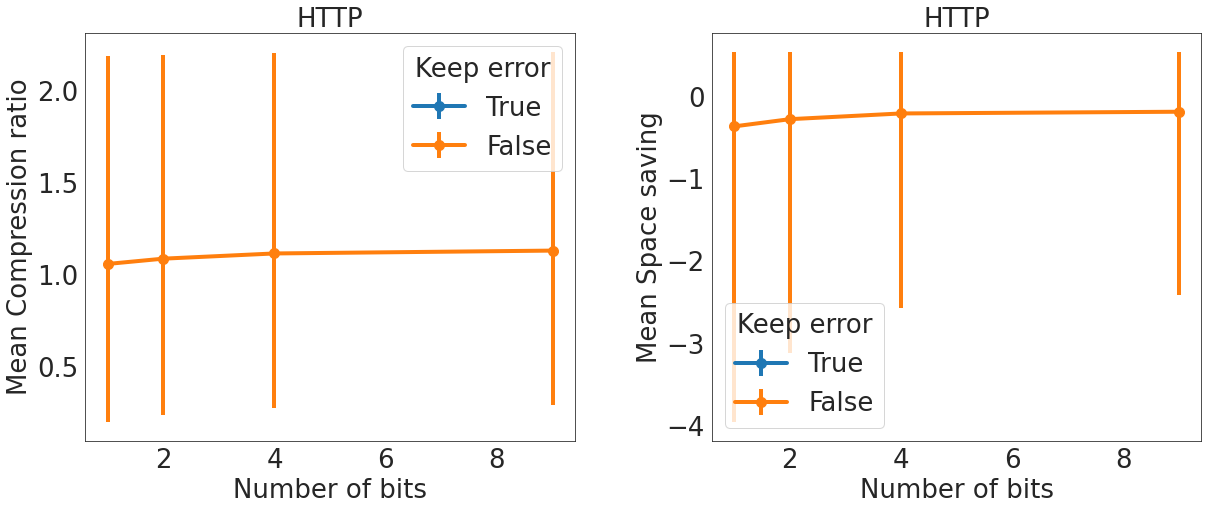

In [345]:
# Change linewidth lengend 
from matplotlib.legend_handler import HandlerLine2D

# Plot MEAN and STD
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
alpha=0.95

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

# Parcourir les axes

for ax, col, title in zip(
    axes.ravel(),
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): #[f"compression ratio (U/C)", f"space saving [1-(C/U)]"]
    
    for k_e in [True, False]:
        
        # Extract k_e
        cond = (data_results['keep_error'] == k_e)
        
        # Get MEAN
    
        df_plot_mean = data_results[cond]\
            .groupby(["decimals"])\
             .mean().reset_index()
        
        # Create ERROR BAR
    
        p = ((1.0-alpha)/2.0) 
        df_plot_low_yerror = data_results[cond]\
                .groupby(["decimals"])\
                 .quantile(p)\
                 .reset_index()[col]
        
        p = (alpha+((1.0-alpha)/2.0))
        df_plot_high_yerror = data_results[cond]\
                 .groupby(["decimals"])\
                 .quantile(p) \
                 .reset_index()[col]
        err_bar = [(df_plot_mean[col]-df_plot_low_yerror).abs(), 
                   (df_plot_high_yerror-df_plot_mean[col]).abs()]
        
        # Plot error 
        
        if (ERROR_BAR):
            ax.errorbar(df_plot_mean['decimals'], 
                        df_plot_mean[col],
                        linewidth=LINEWIDTH,
                        markersize=MARKERSIZE, # Size of point
                        fmt='o-', yerr=err_bar)
        else:
            ax.scatter(df_plot_mean['decimals'], 
                         df_plot_mean[col],
                         linewidth=LINEWIDTH)
        
    ax.set_ylabel(f"Mean {title}",
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Number of bits",
                  fontsize=LABEL_FONTSIZE)
    ax.tick_params(labelsize=TICK_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(LINEWIDTH)
    
for ax in axes.ravel():
    
    # Set legend
    legend = ax.legend(
        ["True", "False"],
        fontsize=LEGEND_FONTSIZE,
        handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
    legend.set_title('Keep error', 
                     prop={'size':LEGEND_FONTSIZE})

#### 4.4.5 Compression performance per DECIMALS precision for Huffman table (BOXPLOT)

In [90]:
DECIMALS = [1, 2, 4, 9]
CUT_VALUES = [6] #, 64, 128]

PROTO = "LORA_20"

LOOK_BACK_CONTEXT = 2
LOOK_BACK_PACKET = 16
data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

# Keep error
for k_e in [True]:#, False]:
    
    for c_val in tqdm(CUT_VALUES):

        for dec in tqdm(DECIMALS):
            
            full_name = f'LOSSLESS_CONTEXT2_PACKET16_SIN8_{PROTO}'
        
            # Change extension name        
            if (k_e):
                ext_name_huffman =  "_HUFFMAN" + '_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain' + f"_KEEP_ERROR_{c_val}_DECIMALSNone"
            else:
                ext_name_huffman = "_HUFFMAN" + '_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain' + f"_{c_val}_DECIMALS{dec}"

            if (LEFT_PADDING):
                ext_name_huffman += "_SELECTIVE_OPTIMAL_LEFT_PADDING" 
            else:
                ext_name_huffman += "_SELECTIVE_OPTIMAL" 

            filename = (f"./RESULTS/HUFFMAN/DEEP_LEARNING/df_{full_name}{ext_name_huffman}"
                        f"_COMPRESSION.csv")

            '''full_name = f"LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_{PROTO}_HUFFMAN"
            
            if (k_e):
                ext_name_huffman = EXT_NAME + f"_KEEP_ERROR_{c_val}_DECIMALS{dec}"
            else:
                ext_name_huffman = EXT_NAME + f"_{c_val}_DECIMALS{dec}"

            data_results_tmp = pd.read_csv(f"./RESULTS/HUFFMAN/DEEP_LEARNING/df_{full_name}{ext_name_huffman}_SELECTIVE_OPTIMAL_LEFT_PADDING_COMPRESSION.csv")'''

            data_results_tmp = pd.read_csv(f"{filename}")
            
            # Set values specific to huffman
            data_results_tmp["cut_values"] = c_val
            data_results_tmp["keep_error"] = k_e
            data_results_tmp["decimals"] = dec

            data_results_tmp, _ = features_extraction(
                data_raw=data_raw, 
                data_results=data_results_tmp)

            data_results = pd.concat(
                [data_results, data_results_tmp], axis=0)

100%|██████████| 1/1 [00:45<00:00, 45.79s/it]


'for ax in axes.ravel():\n    \n    # Set legend\n    legend = ax.legend(\n        #["True", "False"],\n        fontsize=LEGEND_FONTSIZE, #,\n        loc="upper right")\n        #handler_map={plt.Line2D : HandlerLine2D(update_func=update)})\n    #legend.set_title(\'Keep error\', \n    #                 prop={\'size\':LEGEND_FONTSIZE})'

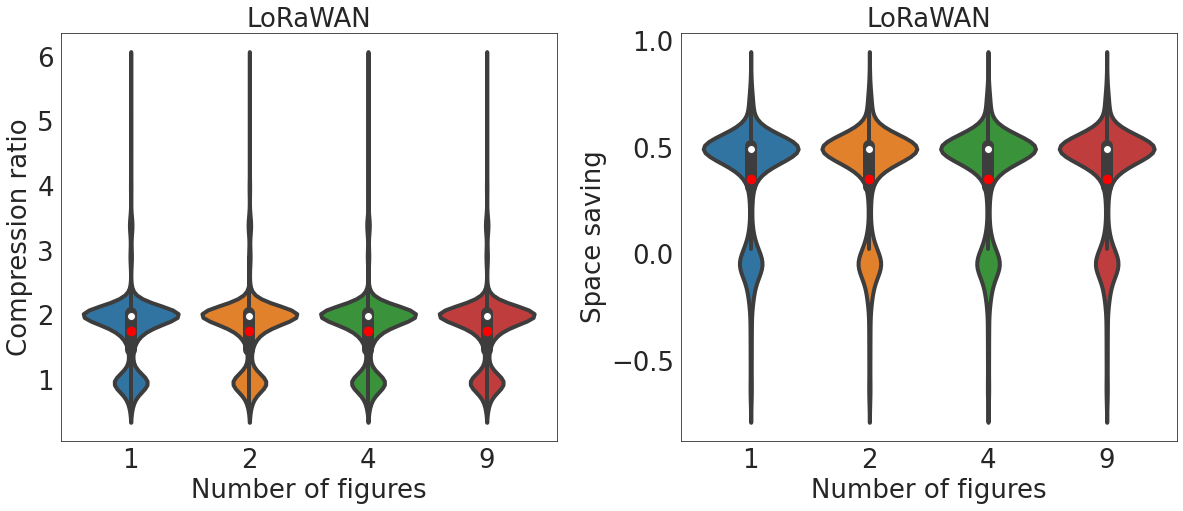

In [91]:
# Plot MEAN and STD
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
alpha=0.95

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

# Parcourir les axes

for ax, col, title in zip(
    axes.ravel(),
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): #[f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    # Plot error 
    '''sns.boxplot(x='decimals', 
                y=col, data=data_results, 
                hue='keep_error',
                showmeans=True,
                meanprops={"marker": "o",
                           "markerfacecolor":"red",
                           "markeredgecolor": "red",
                           "markersize": "10"},
                linewidth=LINEWIDTH,
                ax=ax)'''
    
    means = data_results.groupby('decimals')[col]\
                        .mean().loc[DECIMALS]
    #modes = data_results.groupby('cut_values')[col]\
    #                    .agg(lambda x: pd.Series.mode(x)[0])
    
    #{“box”, “quartile”, “point”, “stick”, None}
    sns.violinplot(x='decimals', 
                   y=col, data=data_results, 
                   #hue='keep_error',
                   showmeans=True,
                   meanprops={"marker": "o",
                               "markerfacecolor":"red",
                               "markeredgecolor": "red",
                               "markersize": "10"},
                   linewidth=LINEWIDTH,
                   ax=ax)
    
    ax.scatter(x=range(len(means)), 
               y=means, c="red",
               s=75,
               zorder=100)
        
    ax.set_ylabel(f"{title}",
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Number of figures",
                  fontsize=LABEL_FONTSIZE)
    ax.tick_params(labelsize=TICK_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(LINEWIDTH)
    
'''for ax in axes.ravel():
    
    # Set legend
    legend = ax.legend(
        #["True", "False"],
        fontsize=LEGEND_FONTSIZE, #,
        loc="upper right")
        #handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
    #legend.set_title('Keep error', 
    #                 prop={'size':LEGEND_FONTSIZE})'''

#### 4.3 Compression performance nb bits for Huffman table (ON TEST DATA !)

In [ ]:
ERROR_BAR = True
CUT_VALUES = [4, 8, 16, 32, 64]

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

for k_e in [True]:
    for c_val in CUT_VALUES:
        
        # Change extension name        
        if (k_e):
            ext_name_huffman =  "_HUFFMAN" + EXT_NAME + f"_KEEP_ERROR_{c_val}"
            filename = (f"{RESULTS_DIR}df_{FULL_NAME}{ext_name_huffman}"
                        f"_COMPRESSION.csv")
        else:
            ext_name_huffman = "_HUFFMAN" + EXT_NAME + f"_{c_val}"
            filename = (f"{RESULTS_DIR}df_{FULL_NAME}{ext_name_huffman}"
                        f"_COMPRESSION.csv")

        data_results_tmp = pd.read_csv(filename)
        
        data_results_tmp = features_extraction(
            data_raw=data_raw, 
            data_results=data_results_tmp)
        
        # Set values specific to huffman
        data_results_tmp["cut_values"] = c_val
        data_results_tmp["keep_error"] = k_e
        
        # Concat to array
        data_results = pd.concat(
            [data_results, 
             data_results_tmp], axis=0)

In [ ]:
# Change linewidth lengend 
from matplotlib.legend_handler import HandlerLine2D

# Plot MEAN and STD
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
alpha=0.95

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.28, 
                    hspace=0.35)

# Parcourir les axes

for ax, col, title in zip(
    axes.ravel(),
    ['compression_ratio', 'space_saving'],
    [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]):
    
    for k_e in [True, False]:
        
        # Get MEAN
    
        df_plot_mean = data_results[cond]\
            .groupby(["cut_values"])\
             .mean().reset_index()
        
        # Create ERROR BAR
        
        cond = (data_results["keep_error"] == k_e)
    
        p = ((1.0-alpha)/2.0) 
        df_plot_low_yerror = data_results[cond]\
                .groupby(["cut_values"])\
                 .quantile(p)\
                 .reset_index()[col]
        
        p = (alpha+((1.0-alpha)/2.0))
        df_plot_high_yerror = data_results[cond]\
                 .groupby(["cut_values"])\
                 .quantile(p) \
                 .reset_index()[col]
        err_bar = [(df_plot_mean[col]-df_plot_low_yerror).abs(), 
                   (df_plot_high_yerror-df_plot_mean[col]).abs()]
        
        # Plot error 
        
        if (ERROR_BAR):
            ax.errorbar(df_plot_mean['cut_values'], 
                        df_plot_mean[col],
                        linewidth=LINEWIDTH,
                        markersize=MARKERSIZE, # Size of point
                        fmt='o-', yerr=err_bar)
        else:
            ax1.scatter(df_plot_mean['cut_values'], 
                         df_plot_mean[col],
                         linewidth=LINEWIDTH)
        
    ax.set_ylabel(f"Mean {title}",
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Number of bits",
                  fontsize=LABEL_FONTSIZE)
    ax.tick_params(labelsize=TICK_FONTSIZE)
    ax.set_title(f"{PROTO}", #"Mean compression ratio in function of bit for huffman table",
                fontsize=TITLE_FONTSIZE)

def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(LINEWIDTH)
    
for ax in axes.ravel():
    
    # Set legend
    legend = ax.legend(
        ["True", "False"],
        fontsize=LEGEND_FONTSIZE,
        handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
    legend.set_title('Keep error', 
                     prop={'size':LEGEND_FONTSIZE})

#### 4.3 Performance compression by varying context size

In [66]:
ERROR_BAR = True
LOOK_BACK_CONTEXTS = [0, 1, 2, 3] # 4
USE_BASELINE = True
PROTO = "LORA_20"
LOOK_BACK_PACKET = 16

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

for look_back_context in LOOK_BACK_CONTEXTS:
    
    full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_{PROTO}"
    ext_name = '_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_LEFT_PADDING'
    data_results_tmp = pd.read_csv(f"./RESULTS/DEEP_LEARNING/df_{full_name}{ext_name}_COMPRESSION.csv")
    
    data_results_tmp["look_back_context"] = int(look_back_context)
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
    
# Add baseline in comparaison
if (USE_BASELINE):
    
    # Add baseline
    LOOK_BACK_CONTEXTS.append("Baseline")
    
    LOOK_BACK_PACKET = 8
    full_name = f"LOSSLESS_PACKET{LOOK_BACK_PACKET}_{PROTO}"
    ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain"
    data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}_BASELINE_NAIVE{ext_name}_DECIMALSNone_LEFT_PADDING_COMPRESSION.csv")
    
    data_results_tmp["look_back_context"] = "Baseline"
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
    
# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

In [67]:
# Setthe dict field
DICT_FIELDS = {}

if ('LORA' in PROTO):
    
    # LoRaWAN
    
    ## Mtype
    idx_start = 0
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Mtype"
            
    ## RFU
    idx_start = idx_end
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "RFU"
    
    ## Major
    idx_start = idx_end
    idx_end = idx_start + 2
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Major"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "DevAddr"
        
    ## Fctrl
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Fctrl"
        
    ## FCnt
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FCnt"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FOpts"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"


elif (PROTO in ['HTTP', 'SMTP', 'SSH', 'DNS']):
    
    # IPv4
    
    ## Set IP/HL/ToS
    idx_start = 0
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "IP/HL/ToS"
        
    ## Total length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Total length"
        
    ## Identification
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Id" # entification
        
    ## Indicator/FO
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Indicator/FO"
        
    ## TTL/Protocol
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "TTL/Protocol"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"
        
        
    # data_raw['length_0'] - data_raw['length_1']
    ip_header_length = (data_raw['length_0'] - \
                        data_raw['length_1']) \
                            .value_counts() \
                            .index.max()
    
    if (ip_header_length > 20):
        
        ## Options
        idx_start = idx_end
        idx_end = idx_start + 32
        for i in range(idx_start, idx_end):
            DICT_FIELDS[i] = "Options"
        
    
    print("[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end: ", 
          idx_end)
   # DICT_FIELDS = {v: k for k, v in enumerate(range(500))}
    
elif (PROTO in ["COAP", "MQTT_IEEE"]):
    
    # IPv6
    
    ## Version
    idx_start = 0
    idx_end = idx_start + 4
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Version"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Traffic class"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 20
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Flow label"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Payload length"
        
    ## Next header
    idx_start =  idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Next header"
        
    ## Hop limit
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Hop limit"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"


# Mettre champs TCP / UDP

if (PROTO in ['HTTP', 'SMTP', 'SSH', 'MQTT_IEEE']):
    
    # TCP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst port"
            
    ## Sequence number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Seq. number"
        
    ## ACK number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "ACK number"
        
    ## HL/Flags
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "HL/Flags"
        
    ## Windows
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Windows"
        
    ## CRC
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "CRC"
        
    ## Urgent pointer
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Urgent pointer"
        
    ## Option/Padding
    #idx_start = idx_end
    #idx_end = idx_start + 32
    #for i in range(idx_start, idx_end):
    #    DICT_FIELDS[i] = "Option/Padding"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"
        
    
elif (PROTO in ["DNS", 'COAP']):
    
    # UDP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dest. port"
        
    ## Length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Length"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"

In [68]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
sizes_context = []
look_back_contexts = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []

for i in range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    for j in LOOK_BACK_CONTEXTS:
        
        cond_look_back_context = (data_results[
            'look_back_context'] == j)
        data_results_tmp = data_results[
            cond_look_back_context]
        
        # IF l'array is empty
        if (data_results_tmp.shape[0] != 0):

            # Init first steps

            '''bit_ranks.append(0)
            compression_ratio.append(0)
            space_saving.append(0)
            sizes_context.append(i)
            look_back_contexts.append(j)

            low_yerror_compression_ratio.append(0)
            high_yerror_compression_ratio.append(0)

            low_yerror_space_saving.append(0)
            high_yerror_space_saving.append(0)'''

            # Compute each compress level

            for col in data_results.columns:
                if ("level_compress" in col):

                    # Add context size info
                    sizes_context.append(i)
                    look_back_contexts.append(j)

                    # Extract bit rank
                    bit_rank = int(col.split("_")[-1])+1
                    bit_ranks.append(
                        bit_rank)

                    # Compute mean compresssion ratio
                    # Compression ratio = uncompressed / compressed
                    # for rank k
                    df_tmp_compression_ratio = bit_rank / \
                        data_results_tmp[col]
                    df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                    bit_rank)

                    ## Remove -1
                    cond = (data_results_tmp[col] != -1)
                    df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                    df_tmp_space_saving = df_tmp_space_saving[cond]
                    
                    #print("[DEBUG] np.isinf(df_tmp_compression_ratio).any(): ",
                    #         np.isinf(df_tmp_compression_ratio).any())
                    #if (np.isinf(df_tmp_compression_ratio).any()):
                    #    print("[DEBUG][if] data_results_tmp[col].value_counts(): ", 
                    #          data_results_tmp[col].value_counts())
                    
                    # Replace inf values
                    if (np.isinf(df_tmp_compression_ratio).any()):
                    
                        ## Index with inf values
                        cond = (df_tmp_compression_ratio \
                                    .isin([np.inf, -np.inf]))
                        indexes_inf = df_tmp_compression_ratio[cond].index

                        ## Get right values
                        values_new = data_results_tmp[
                            "headers_length"].iloc[indexes_inf]

                        ## Set the right values
                        df_tmp_compression_ratio \
                            .iloc[indexes_inf] = values_new.values

                    compression_ratio.append(
                        df_tmp_compression_ratio.mean())
                    space_saving.append(
                        df_tmp_space_saving.mean())

                    if (df_tmp_compression_ratio.shape[0] != 0):

                        # Compute std compression ratio
                        p = ((1.0-alpha)/2.0)
                        lower_compression_ratio = np.percentile(
                                df_tmp_compression_ratio.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_compression_ratio = np.percentile(
                                 df_tmp_compression_ratio.values, p)

                        # Compute std space saving
                        p = ((1.0-alpha)/2.0)
                        lower_space_saving = np.percentile(
                                df_tmp_space_saving.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_space_saving = np.percentile(
                                 df_tmp_space_saving.values, p)

                    else:
                        # Compression ratio
                        lower_compression_ratio = 0
                        upper_compression_ratio = 0

                        # Space saving
                        lower_space_saving = 0
                        upper_space_saving = 0

                    low_yerror_compression_ratio\
                        .append(lower_compression_ratio)
                    high_yerror_compression_ratio\
                        .append(upper_compression_ratio)

                    low_yerror_space_saving\
                        .append(lower_space_saving)
                    high_yerror_space_saving\
                        .append(upper_space_saving)


# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['size_context'] = sizes_context
df_plot['look_back_context'] = look_back_contexts

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

# Extract difference

'''df_plot_diff = df_plot[
    ['compression_ratio', 
     'space_saving']] \
        .diff(1).fillna(0) \
        .rename(columns={'compression_ratio':'compression_ratio_diff',
                         'space_saving':'space_saving_diff'})
df_plot = pd.concat(
    [df_plot, df_plot_diff], axis=1)'''

"df_plot_diff = df_plot[\n    ['compression_ratio', \n     'space_saving']]         .diff(1).fillna(0)         .rename(columns={'compression_ratio':'compression_ratio_diff',\n                         'space_saving':'space_saving_diff'})\ndf_plot = pd.concat(\n    [df_plot, df_plot_diff], axis=1)"

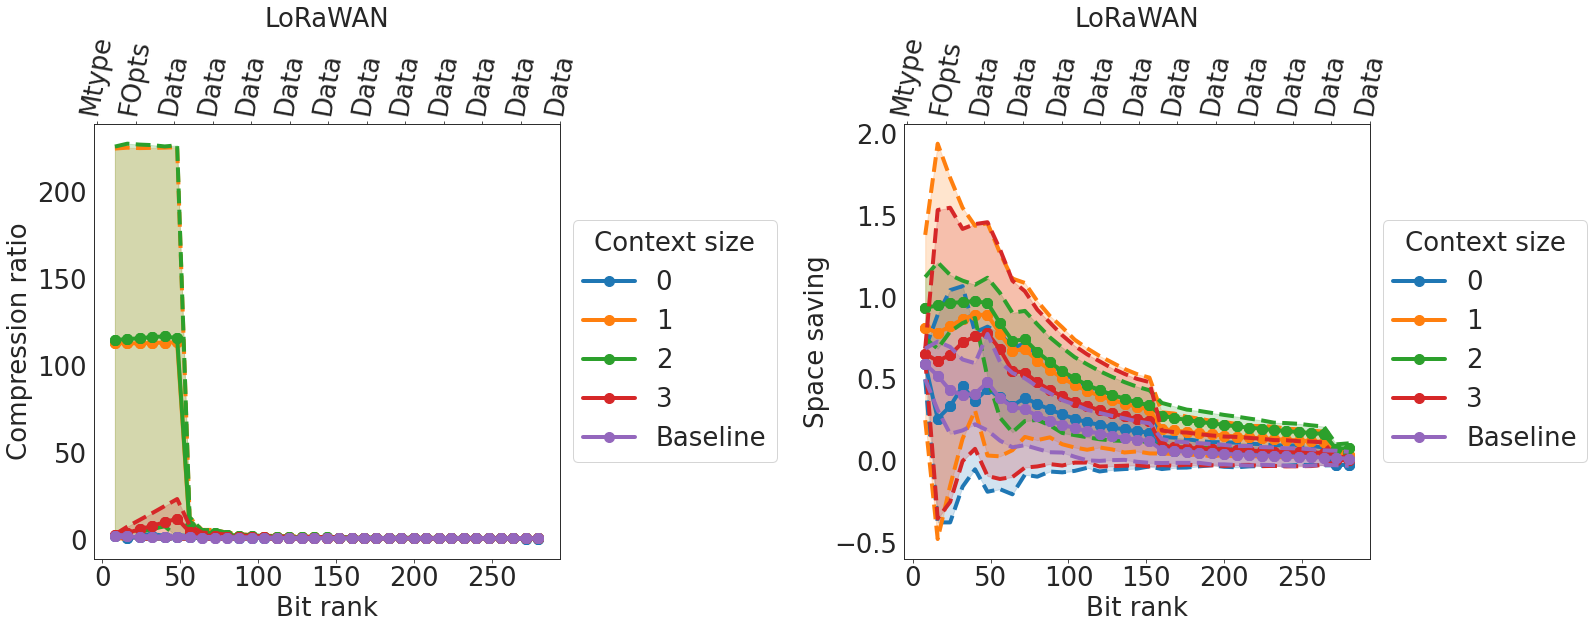

In [69]:
fig, axes = plt.subplots(
    1, 2, figsize=(20*2, 8))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
#fig.subplots_adjust(wspace=0.25, 
#                    hspace=1.1)
fig.subplots_adjust(wspace=-0.43, 
                    hspace=1.1)

# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['look_back_context']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    ax1 = ax
    ax2 = ax1.twiny()

    #err_bar = [[0]*df_plot.shape[0], 
    #           [0]*df_plot.shape[0]]

    
    # SET FIRST AXIS

    
    # Check if we use baseline
    if (USE_BASELINE):
        
        # Define condition
        cond = (df_plot[hue] != "Baseline")
        
        # Set rank 
        unique_values = df_plot[cond][hue] \
                            .astype(int) \
                            .value_counts()\
                            .sort_index()\
                            .index
        
        unique_values = \
            list(unique_values) + \
                ["Baseline"]
    else:
        
        # Set rank 
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .sort_index()\
                            .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        if (ERROR_BAR):
            
            lower = (df_plot[cond][col]-\
                df_plot[cond]['low_yerror_'+col]).abs()
            upper = (df_plot[cond]['high_yerror_'+col]-\
                df_plot[cond][col]).abs()
            err_bar = [lower, 
                       upper]
            #err_bar = [(df_plot[cond][col]-df_plot[cond]['low_yerror']).abs(), 
            #           (df_plot[cond]['high_yerror']-df_plot[cond][col]).abs()]
            #err_bar = [[0]*df_plot[cond].shape[0], 
            #           [0]*df_plot[cond].shape[0]]

            '''ax1.errorbar(df_plot[cond]['bit_ranks'], 
                         df_plot[cond][col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         fmt='o', yerr=err_bar)'''
            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
            
            # Get color from mean plot
            last_line = ax1.get_lines()[-1]
            color_last_line = last_line.get_color()
            
            # Set error area with alpha
            ax1.fill_between(df_plot[cond]['bit_ranks'],
                                df_plot[cond][col]-lower, 
                                df_plot[cond][col]+upper,
                                alpha=0.2,
                                color=color_last_line)
            
            # Set min and max for error area
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]-lower,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]+upper,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
        else:
            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
           
        # Parameter for outside legend
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Set legend
        #legend = ax1.legend(unique_values,
        #           fontsize=LEGEND_FONTSIZE)
        #for item in legend.legendHandles:
        #    item.set_visible(False)
        legend = ax1.legend(fontsize=LEGEND_FONTSIZE,
                           # Parameter for outside legend
                           loc='center left',
                           bbox_to_anchor=(1, 0.5),
                           frameon=True)
        legend.set_title('Context size', 
                         prop={'size':LEGEND_FONTSIZE})
        

    for item in ax1.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax1.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax1.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax1.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

    # SET SECOND AXIS


    def tick_function(ranks_bit):
        values = []
        for val in ranks_bit:
            values.append(
                DICT_FIELDS[val])
        return values

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    #if (hue is None):
    new_tick_locations = [i for i in range(
        0, idx_end, 64)]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(
        tick_function(new_tick_locations))

    # Set field name
    #ax2 = ax1.twiny()
    ax2.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax2.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(80)

    ax2.grid(False)

#### 4.2.2 Compression performance HISTOGRAM PER packet (field not threaten)

In [65]:
LOOK_BACK_CONTEXTS = [0, 1, 2, 3] # 4
PROTO = 'COAP'
LOOK_BACK_PACKET = 16
USE_BASELINE = True

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}_SAVE.csv")


# Add baseline in comparaison
if (USE_BASELINE):
    
    # Add baseline
    LOOK_BACK_CONTEXTS.insert(0, "Bas.")
    
    look_back_context = 1
    look_back_packet = 8
    full_name = f"LOSSLESS_PACKET{look_back_packet}_{PROTO}"
    ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain"
    data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}_BASELINE_NAIVE{ext_name}_DECIMALSNone_LEFT_PADDING_COMPRESSION.csv")
    
    data_results_tmp["look_back_context"] = "Bas."
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
    
print("[DEBUG] Baseline results loaded !")

if ((PROTO == "MQTT_IEEE") or 
    (PROTO == "COAP")):

    # Add 6LowPAN
    LOOK_BACK_CONTEXTS.insert(1, "6LoWPAN")

    #look_back_context = 1
    look_back_packet = 8
    full_name = f"LOSSLESS_PACKET{look_back_packet}_{PROTO}"
    ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain"
    data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}_BASELINE_NAIVE{ext_name}_DECIMALSNone_LEFT_PADDING_COMPRESSION.csv")

    data_results_tmp["look_back_context"] = "6LoWPAN"

    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    # We keep only two bytes in case of link local
    data_results_tmp['size_compress'] = (data_results_tmp['size_uncompress'] - 38)*8
    
    # Re compute compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]*8) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / (data_results_tmp["size_uncompress"]*8))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    

print("[DEBUG] 6LoWPAN results loaded !")
    
if ((PROTO == "MQTT_IEEE") or 
    (PROTO == "COAP")):
    look_back_contexts_tmp = LOOK_BACK_CONTEXTS[2:]
else:
    look_back_contexts_tmp = LOOK_BACK_CONTEXTS[1:]
    
for look_back_context in look_back_contexts_tmp:
    
    full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_{PROTO}"
    ext_name = '_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_LEFT_PADDING'
    data_results_tmp = pd.read_csv(f"./RESULTS/DEEP_LEARNING/df_{full_name}{ext_name}_COMPRESSION.csv")
    
    data_results_tmp["look_back_context"] = int(look_back_context)
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)


print("[DEBUG] PROTO results loaded !")

# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

[DEBUG] Baseline results loaded !
[DEBUG] 6LoWPAN results loaded !
[DEBUG] PROTO results loaded !


In [66]:
data_raw_new = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

# Filter size
cond = (data_results["size_uncompress"] >= \
            data_raw_new['length_total'].min())
data_results = data_results[cond]

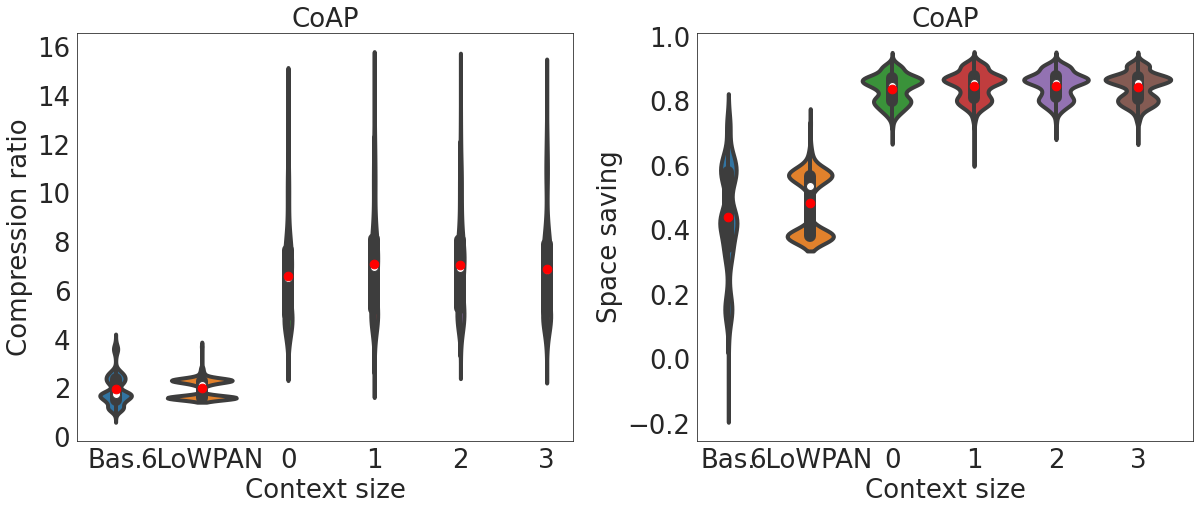

In [67]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)


# Parcourir les axes

df_plot = data_results.copy()

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['look_back_context']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"Compression ratio (U/C)", f"Space saving [1-(C/U)]"]
    
    # SET FIRST AXIS

    
    # Check if we use baseline
    '''if (USE_BASELINE):
        
        # Define condition
        cond = (df_plot[hue] != "Baseline")
        
        # Set rank 
        unique_values = df_plot[cond][hue] \
                            .astype(int) \
                            .value_counts()\
                            .sort_index()\
                            .index
        
        unique_values = \
            list(unique_values) + \
                ["Baseline"]
    else:
        
        # Set rank 
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .sort_index()\
                            .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        sns.histplot(df_plot[cond][col], 
                     element="step",
                     stat='probability',
                     bins=40,
                     linewidth=LINEWIDTH,
                     fill=False,
                     ax=ax)

        #ax.hist(df_plot[cond][col],
        #        density=False,
                #linewidth=LINEWIDTH,
        #        bins=70
        #       )

        # Set legend
        legend = ax.legend(unique_values, 
                  fontsize=LEGEND_FONTSIZE)
        legend.set_title('Context size', 
                         prop={'size':LEGEND_FONTSIZE})'''
        
        
    means = data_results.groupby('look_back_context')[col]\
                        .mean().loc[LOOK_BACK_CONTEXTS]
    #modes = data_results.groupby('cut_values')[col]\
    #                    .agg(lambda x: pd.Series.mode(x)[0])

    #{“box”, “quartile”, “point”, “stick”, None}
    sns.violinplot(x='look_back_context', 
                   y=col, 
                   data=data_results, 
                   #hue='keep_error',
                   showmeans=True,
                   meanprops={"marker": "o",
                               "markerfacecolor":"red",
                               "markeredgecolor": "red",
                               "markersize": "10"},
                   linewidth=LINEWIDTH,
                   ax=ax)

    ax.scatter(x=range(len(means)), 
               y=means, c="red",
               s=75,
               zorder=100)
        
        
    # Normalize axis
    '''yticklabels = ax.get_yticks() 
    yticklabels_update = np.round(
        yticklabels/df_plot[cond][col].shape[0], 3)'''
        
    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)
        
    # Set normalized labels
    #ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        

    # Set label  
    ax.set_ylabel(f"{title}", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Context size", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

#### 4.3.1 Performance compression by varying windows size

In [102]:
ERROR_BAR = True
LOOK_BACK_PACKETS = [2, 4, 8, 16, 32]
LOOK_BACK_CONTEXT = 2
USE_BASELINE = True
PROTO = "LORA_20"


data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

for look_back_packet in LOOK_BACK_PACKETS:
    
    full_name = f"LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{look_back_packet}_SIN{NUM_SIN}_{PROTO}"
    ext_name = '_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_LEFT_PADDING'
    data_results_tmp = pd.read_csv(f"./RESULTS/DEEP_LEARNING/df_{full_name}{ext_name}_COMPRESSION.csv")
    
    data_results_tmp["look_back_packet"] = int(look_back_packet)
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    

# Add baseline in comparaison
if (USE_BASELINE):
    
    # Add baseline
    LOOK_BACK_PACKETS.append("Baseline")
    
    look_back_context = 1
    look_back_packet = 8
    full_name = f"LOSSLESS_PACKET{look_back_packet}_{PROTO}"
    ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain"
    data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}_BASELINE_NAIVE{ext_name}_DECIMALSNone_LEFT_PADDING_COMPRESSION.csv")
    
    data_results_tmp["look_back_packet"] = "Baseline"
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
    
# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

In [103]:
# Setthe dict field
DICT_FIELDS = {}

if ('LORA' in PROTO):
    
    # LoRaWAN
    
    ## Mtype
    idx_start = 0
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Mtype"
            
    ## RFU
    idx_start = idx_end
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "RFU"
    
    ## Major
    idx_start = idx_end
    idx_end = idx_start + 2
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Major"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "DevAddr"
        
    ## Fctrl
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Fctrl"
        
    ## FCnt
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FCnt"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FOpts"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"


elif (PROTO in ['HTTP', 'SMTP', 'SSH', 'DNS']):
    
    # IPv4
    
    ## Set IP/HL/ToS
    idx_start = 0
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "IP/HL/ToS"
        
    ## Total length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Total length"
        
    ## Identification
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Id" # entification
        
    ## Indicator/FO
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Indicator/FO"
        
    ## TTL/Protocol
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "TTL/Protocol"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"
        
        
    # data_raw['length_0'] - data_raw['length_1']
    ip_header_length = (data_raw['length_0'] - \
                        data_raw['length_1']) \
                            .value_counts() \
                            .index.max()
    
    if (ip_header_length > 20):
        
        ## Options
        idx_start = idx_end
        idx_end = idx_start + 32
        for i in range(idx_start, idx_end):
            DICT_FIELDS[i] = "Options"
        
    
    print("[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end: ", 
          idx_end)
   # DICT_FIELDS = {v: k for k, v in enumerate(range(500))}
    
elif (PROTO in ["COAP", "MQTT_IEEE"]):
    
    # IPv6
    
    ## Version
    idx_start = 0
    idx_end = idx_start + 4
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Version"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Traffic class"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 20
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Flow label"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Payload length"
        
    ## Next header
    idx_start =  idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Next header"
        
    ## Hop limit
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Hop limit"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"


# Mettre champs TCP / UDP

if (PROTO in ['HTTP', 'SMTP', 'SSH', 'MQTT_IEEE']):
    
    # TCP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst port"
            
    ## Sequence number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Seq. number"
        
    ## ACK number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "ACK number"
        
    ## HL/Flags
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "HL/Flags"
        
    ## Windows
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Windows"
        
    ## CRC
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "CRC"
        
    ## Urgent pointer
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Urgent pointer"
        
    ## Option/Padding
    #idx_start = idx_end
    #idx_end = idx_start + 32
    #for i in range(idx_start, idx_end):
    #    DICT_FIELDS[i] = "Option/Padding"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"
        
    
elif (PROTO in ["DNS", 'COAP']):
    
    # UDP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dest. port"
        
    ## Length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Length"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"

In [104]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
sizes_context = []
look_back_packets = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []

for i in range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    for j in LOOK_BACK_PACKETS:
        
        cond_look_back_packet = (data_results[
            'look_back_packet'] == j)
        data_results_tmp = data_results[
            cond_look_back_packet]
        
        # IF l'array is empty
        if (data_results_tmp.shape[0] != 0):

            # Init first steps

            '''bit_ranks.append(0)
            compression_ratio.append(0)
            space_saving.append(0)
            sizes_context.append(i)
            look_back_contexts.append(j)

            low_yerror_compression_ratio.append(0)
            high_yerror_compression_ratio.append(0)

            low_yerror_space_saving.append(0)
            high_yerror_space_saving.append(0)'''

            # Compute each compress level

            for col in data_results.columns:
                if ("level_compress" in col):

                    # Add context size info
                    sizes_context.append(i)
                    look_back_packets.append(j)

                    # Extract bit rank
                    bit_rank = int(col.split("_")[-1])+1
                    bit_ranks.append(
                        bit_rank)

                    # Compute mean compresssion ratio
                    # Compression ratio = uncompressed / compressed
                    # for rank k
                    df_tmp_compression_ratio = bit_rank / \
                        data_results_tmp[col]
                    df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                    bit_rank)

                    ## Remove -1
                    cond = (data_results_tmp[col] != -1)
                    df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                    df_tmp_space_saving = df_tmp_space_saving[cond]
                    
                    #print("[DEBUG] np.isinf(df_tmp_compression_ratio).any(): ",
                    #         np.isinf(df_tmp_compression_ratio).any())
                    #if (np.isinf(df_tmp_compression_ratio).any()):
                    #    print("[DEBUG][if] data_results_tmp[col].value_counts(): ", 
                    #          data_results_tmp[col].value_counts())
                    
                    # Replace inf values
                    if (np.isinf(df_tmp_compression_ratio).any()):
                    
                        ## Index with inf values
                        cond = (df_tmp_compression_ratio \
                                    .isin([np.inf, -np.inf]))
                        indexes_inf = df_tmp_compression_ratio[cond].index

                        ## Get right values
                        values_new = data_results_tmp[
                            "headers_length"].iloc[indexes_inf]

                        ## Set the right values
                        df_tmp_compression_ratio \
                            .iloc[indexes_inf] = values_new.values

                    compression_ratio.append(
                        df_tmp_compression_ratio.mean())
                    space_saving.append(
                        df_tmp_space_saving.mean())

                    if (df_tmp_compression_ratio.shape[0] != 0):

                        # Compute std compression ratio
                        p = ((1.0-alpha)/2.0)
                        lower_compression_ratio = np.percentile(
                                df_tmp_compression_ratio.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_compression_ratio = np.percentile(
                                 df_tmp_compression_ratio.values, p)

                        # Compute std space saving
                        p = ((1.0-alpha)/2.0)
                        lower_space_saving = np.percentile(
                                df_tmp_space_saving.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_space_saving = np.percentile(
                                 df_tmp_space_saving.values, p)

                    else:
                        # Compression ratio
                        lower_compression_ratio = 0
                        upper_compression_ratio = 0

                        # Space saving
                        lower_space_saving = 0
                        upper_space_saving = 0

                    low_yerror_compression_ratio\
                        .append(lower_compression_ratio)
                    high_yerror_compression_ratio\
                        .append(upper_compression_ratio)

                    low_yerror_space_saving\
                        .append(lower_space_saving)
                    high_yerror_space_saving\
                        .append(upper_space_saving)


# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['size_context'] = sizes_context
df_plot['look_back_packet'] = look_back_packets

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

# Extract difference

'''df_plot_diff = df_plot[
    ['compression_ratio', 
     'space_saving']] \
        .diff(1).fillna(0) \
        .rename(columns={'compression_ratio':'compression_ratio_diff',
                         'space_saving':'space_saving_diff'})
df_plot = pd.concat(
    [df_plot, df_plot_diff], axis=1)'''

"df_plot_diff = df_plot[\n    ['compression_ratio', \n     'space_saving']]         .diff(1).fillna(0)         .rename(columns={'compression_ratio':'compression_ratio_diff',\n                         'space_saving':'space_saving_diff'})\ndf_plot = pd.concat(\n    [df_plot, df_plot_diff], axis=1)"

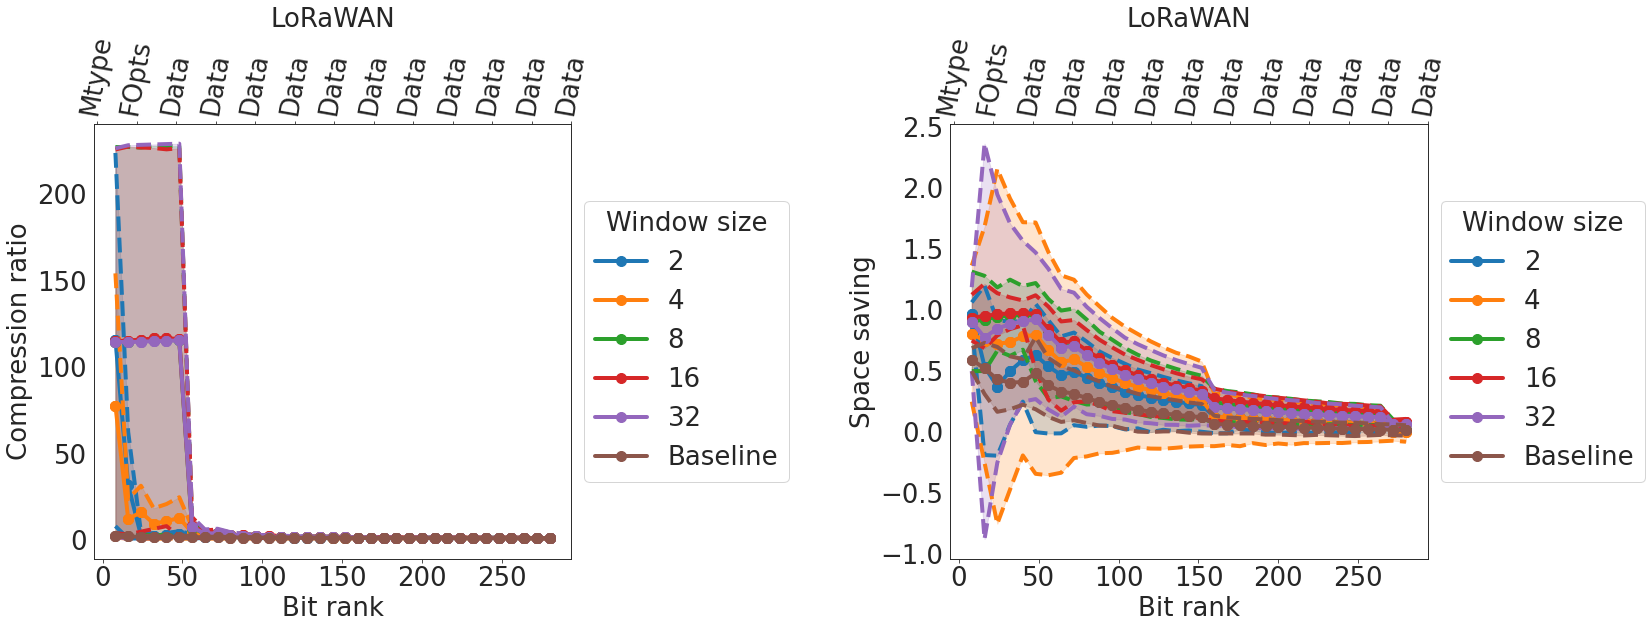

In [105]:
fig, axes = plt.subplots(
    1, 2, figsize=(20*2.4, 8))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
#fig.subplots_adjust(wspace=0.25, 
#                    hspace=1.1)
fig.subplots_adjust(wspace=-0.53, #-0.53, 
                    hspace=1.1)

# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['look_back_packet']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    ax1 = ax
    ax2 = ax1.twiny()

    #err_bar = [df_plot['low_yerror'], 
    #           df_plot['low_yerror']]
    #err_bar = [[0]*df_plot.shape[0], 
    #           [0]*df_plot.shape[0]]

    
    # SET FIRST AXIS

    
    # Check if we use baseline
    if (USE_BASELINE):
        
        # Define condition
        cond = (df_plot[hue] != "Baseline")
        
        # Set rank 
        unique_values = df_plot[cond][hue] \
                            .astype(int) \
                            .value_counts()\
                            .sort_index()\
                            .index
        
        unique_values = \
            list(unique_values) + \
                ["Baseline"]
    else:
        
        # Set rank 
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .sort_index()\
                            .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        if (ERROR_BAR):
            lower = (df_plot[cond][col]-\
                df_plot[cond]['low_yerror_'+col]).abs()
            upper = (df_plot[cond]['high_yerror_'+col]-\
                df_plot[cond][col]).abs()
            err_bar = [lower, 
                       upper]
            #err_bar = [(df_plot[cond][col]-df_plot[cond]['low_yerror']).abs(), 
            #           (df_plot[cond]['high_yerror']-df_plot[cond][col]).abs()]
            #err_bar = [[0]*df_plot[cond].shape[0], 
            #           [0]*df_plot[cond].shape[0]]
            '''ax1.errorbar(df_plot[cond]['bit_ranks'], 
                         df_plot[cond][col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         fmt='o', yerr=err_bar)'''
            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
            
            # Get color from mean plot
            last_line = ax1.get_lines()[-1]
            color_last_line = last_line.get_color()
            
            # Set error area with alpha
            ax1.fill_between(df_plot[cond]['bit_ranks'],
                             df_plot[cond][col]-lower, 
                             df_plot[cond][col]+upper,
                             alpha=0.2,
                             color=color_last_line)
            
            # Set min and max for error area
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]-lower,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]+upper,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            
        else:
            ax1.scatter(df_plot[cond]['bit_ranks'], 
                        df_plot[cond][col],
                        linewidth=LINEWIDTH)
            
        # Parameter for outside legend
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Set legend
        legend = ax1.legend(fontsize=LEGEND_FONTSIZE,
                           # Parameter for outside legend
                           loc='center left',
                           bbox_to_anchor=(1, 0.5),
                           frameon=True)
        legend.set_title('Window size', 
                         prop={'size':LEGEND_FONTSIZE})
        

    for item in ax1.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax1.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax1.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax1.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

    # SET SECOND AXIS


    def tick_function(ranks_bit):
        values = []
        for val in ranks_bit:
            values.append(
                DICT_FIELDS[val])
        return values

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    #if (hue is None):
    new_tick_locations = [i for i in range(
        0, idx_end, 64)]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(
        tick_function(new_tick_locations))

    # Set field name
    #ax2 = ax1.twiny()
    ax2.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax2.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(80)

    ax2.grid(False)

#### 4.2.2 Compression performance HISTOGRAM PER packet (field not threaten)

In [62]:
LOOK_BACK_PACKETS = [4, 8, 16, 32] #[2, 4, 8, 16, 32]
LOOK_BACK_CONTEXT = 2
USE_BASELINE = True
PROTO = "MQTT_IEEE"

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

# Add baseline in comparaison
if (USE_BASELINE):
    
    # Add baseline
    LOOK_BACK_PACKETS.insert(0, "Bas.")
    
    look_back_context = 1
    look_back_packet = 8
    full_name = f"LOSSLESS_PACKET{look_back_packet}_{PROTO}"
    ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain"
    data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}_BASELINE_NAIVE{ext_name}_DECIMALSNone_LEFT_PADDING_COMPRESSION.csv")
    
    data_results_tmp["look_back_packet"] = "Bas."
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
print("[DEBUG] Baseline results loaded !")

if ((PROTO == "MQTT_IEEE") or 
    (PROTO == "COAP")):

    # Add 6LowPAN
    LOOK_BACK_PACKETS.insert(1, "6LoWPAN")

    look_back_context = 1
    look_back_packet = 8
    full_name = f"LOSSLESS_PACKET{look_back_packet}_{PROTO}"
    ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain"
    data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}_BASELINE_NAIVE{ext_name}_DECIMALSNone_LEFT_PADDING_COMPRESSION.csv")

    data_results_tmp["look_back_packet"] = "6LoWPAN"

    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    # We keep only two bytes in case of link local
    data_results_tmp['size_compress'] = (data_results_tmp['size_uncompress'] - 38)*8
    
    # Re compute compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]*8) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / (data_results_tmp["size_uncompress"]*8))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)

print("[DEBUG] 6LoWPAN results loaded !")
    
if ((PROTO == "MQTT_IEEE") or 
    (PROTO == "COAP")):
    look_back_packets_tmp = LOOK_BACK_PACKETS[2:]
else:
    look_back_packets_tmp = LOOK_BACK_PACKETS[1:]
    
for look_back_packet in look_back_packets_tmp:
    
    look_back_context = 2
    #look_back_packet = 16
    full_name = f"LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{look_back_packet}_SIN{NUM_SIN}_{PROTO}"
    ext_name = '_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_LEFT_PADDING'
    data_results_tmp = pd.read_csv(f"./RESULTS/DEEP_LEARNING/df_{full_name}{ext_name}_COMPRESSION.csv")
    
    data_results_tmp["look_back_packet"] = int(look_back_packet)
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
print("[DEBUG] PROTO results loaded !")
    
# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

[DEBUG] Baseline results loaded !



KeyboardInterrupt



In [87]:
data_raw_new = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

# Filter size
cond = (data_results["size_uncompress"] >= \
            data_raw_new['length_total'].min())
data_results = data_results[cond]

In [ ]:
# FOR MQTT

# Load data
data_test = pd.read_csv("DATA/df_raw_MQTT_IEEE_SAVE.csv")
arr_test = np.load("DATA/arr_MQTT_IEEE_bit_SAVE.npy", mmap_mode='r')

# Remove Dot3
cond = (data_test['layers_0'] == "Ether")
data_test = data_test[cond]#.reset_index(drop=True)

# Get only IP packet
cond = (data_test['layers_1'] == "IP")
data_test = data_test[cond]#.reset_index(drop=True)

# Get only IP packet
cond = (data_test['layers_2'] == "TCP")
data_test = data_test[cond]#.reset_index(drop=True)

idx = data_test.index
print("arr_test.shape : ", arr_test.shape)
arr_test = arr_test[idx]
print("arr_test.shape AFTER : ", arr_test.shape)
print("data_test.shape AFTER : ", data_test.shape)

# Save data
#data_test.to_csv("DATA/df_raw_MQTT_IEEE.csv", index=False)
#np.save(file="DATA/arr_MQTT_IEEE_bit.npy", arr=arr_test)

In [ ]:
# FOR MQTT

# Load data
data_test = pd.read_csv("DATA/PROCESS/df_process_MQTT_IEEE_SAVE.csv")
arr_test = np.load("DATA/PROCESS/arr_process_MQTT_IEEE_bit_SAVE.npy", mmap_mode='r')

# Get only IP packet
cond = (data_test['layers_0'] == "IP")
data_test = data_test[cond]#.reset_index(drop=True)

# Get only IP packet
cond = (data_test['layers_1'] == "TCP")
data_test = data_test[cond]#.reset_index(drop=True)

idx = data_test.index
print("arr_test.shape : ", arr_test.shape)
arr_test = arr_test[idx]
print("arr_test.shape AFTER : ", arr_test.shape)
print("data_test.shape AFTER : ", data_test.shape)

# Save data
#data_test.to_csv("DATA/PROCESS/df_process_MQTT_IEEE.csv", index=False)
#np.save(file="DATA/PROCESS/arr_process_MQTT_IEEE_bit.npy", arr=arr_test)

In [ ]:
# FOR COAP

# Load data
data_test = pd.read_csv("DATA/df_raw_COAP_SAVE.csv")
arr_test = np.load("DATA/arr_COAP_bit_SAVE.npy", mmap_mode='r')

# Remove IPv6
cond = (data_test['layers_0'] == "IPv6")
data_test = data_test[cond]#.reset_index(drop=True)

# Remove IPv6
cond = (data_test['layers_1'] == "UDP")
data_test = data_test[cond]#.reset_index(drop=True)

# Remove IPv6
cond = (data_test['layers_2'] == "CoAP")
data_test = data_test[cond]#.reset_index(drop=True)

idx = data_test.index
print("arr_test.shape : ", arr_test.shape)
arr_test = arr_test[idx]
print("arr_test.shape AFTER : ", arr_test.shape)
print("data_test.shape AFTER : ", data_test.shape)

# Save data
#data_test.to_csv("DATA/df_raw_COAP.csv", index=False)
#np.save(file="DATA/arr_COAP_bit.npy", arr=arr_test)

In [ ]:
# FOR COAP

# Load data
data_test = pd.read_csv("DATA/PROCESS/df_process_COAP_SAVE.csv")
arr_test = np.load("DATA/PROCESS/arr_process_COAP_bit_SAVE.npy", mmap_mode='r')

# Get only IP packet
cond = (data_test['layers_0'] == "IPv6")
data_test = data_test[cond]#.reset_index(drop=True)

# Get only IP packet
cond = (data_test['layers_1'] == "UDP")
data_test = data_test[cond]#.reset_index(drop=True)

# Remove others
cond = (data_test['layers_2'] == "CoAP")
data_test = data_test[cond]#.reset_index(drop=True)

idx = data_test.index
print("arr_test.shape : ", arr_test.shape)
arr_test = arr_test[idx]
print("arr_test.shape AFTER : ", arr_test.shape)
print("data_test.shape AFTER : ", data_test.shape)

# Save data
#data_test.to_csv("DATA/PROCESS/df_process_COAP.csv", index=False)
#np.save(file="DATA/PROCESS/arr_process_COAP_bit.npy", arr=arr_test)

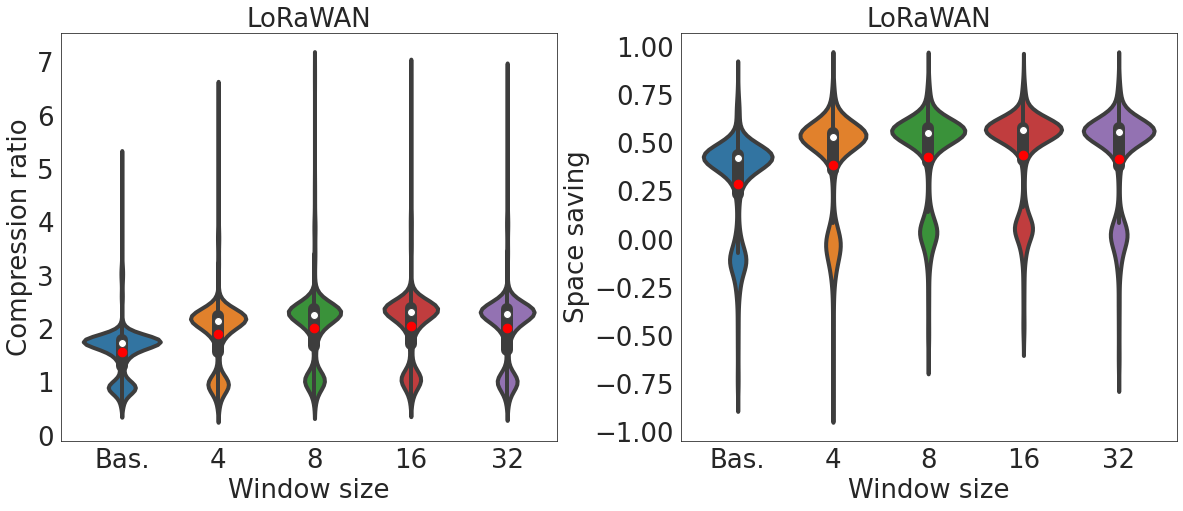

In [39]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)


# Parcourir les axes

df_plot = data_results.copy()

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['look_back_packet']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]
    
    # SET FIRST AXIS

    
    # Check if we use baseline
    '''if (USE_BASELINE):
        
        # Define condition
        cond = (df_plot[hue] != "Baseline")
        
        # Set rank 
        unique_values = df_plot[cond][hue] \
                            .astype(int) \
                            .value_counts()\
                            .sort_index()\
                            .index
        
        unique_values = \
            list(unique_values) + \
                ["Baseline"]
    else:
        
        # Set rank 
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .sort_index()\
                            .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        sns.histplot(df_plot[cond][col], 
                     element="step",
                     stat='probability',
                     bins=40,
                     linewidth=LINEWIDTH,
                     fill=False,
                     ax=ax)
        #ax.hist(df_plot[cond][col],
        #        density=False,
                #linewidth=LINEWIDTH,
        #        bins=70
        #       )

        # Set legend
        legend = ax.legend(unique_values, 
                  fontsize=LEGEND_FONTSIZE)
        legend.set_title('Window size', 
                         prop={'size':LEGEND_FONTSIZE})'''
                                                   
    means = data_results.groupby('look_back_packet')[col]\
                        .mean().loc[LOOK_BACK_PACKETS]
    #modes = data_results.groupby('cut_values')[col]\
    #                    .agg(lambda x: pd.Series.mode(x)[0])

    #{“box”, “quartile”, “point”, “stick”, None}
    sns.violinplot(x='look_back_packet', 
                   y=col, 
                   data=data_results, 
                   #hue='keep_error',
                   showmeans=True,
                   meanprops={"marker": "o",
                               "markerfacecolor":"red",
                               "markeredgecolor": "red",
                               "markersize": "10"},
                   linewidth=LINEWIDTH,
                   ax=ax)

    ax.scatter(x=range(len(means)), 
               y=means, c="red",
               s=75,
               zorder=100)
        
        
    # Normalize axis
    '''yticklabels = ax.get_yticks() 
    yticklabels_update = np.round(
        yticklabels/df_plot[cond][col].shape[0], 3)'''
        
    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)
        
    # Set normalized labels
    #ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        

    # Set label  
    ax.set_ylabel(f"{title}", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Window size", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

#### 4.4 Compression performance HISTOGRAM PER packet TRAIN vs TEST equipment

In [169]:
MODE_EQUIPS = []

PROTO = "LORA_20"
USE_BASELINE = True

look_back_context = 1
look_back_packet = 8
# PROTO = 'DNS' # /!| THE MODIFICATION OF PROTO IS DONE HERE !!!

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

for mode_equip in ['train', 'test']:
    
    # Add baseline
    MODE_EQUIPS.append(f"DCH ({mode_equip})")
    
    full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{look_back_packet}_SIN{NUM_SIN}_{PROTO}"
    
    if (CHECKSUM):
        if (CUSTOM_SIZE is not None):
            ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
        else:
            ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"
    else:
        if (CUSTOM_SIZE is not None):
            ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
        else:
            ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"
    
    data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}{ext_name}_COMPRESSION.csv")
    
    data_results_tmp["mode_equip"] = f"DCH ({mode_equip})"
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    

# Add baseline in comparaison
if (USE_BASELINE):
    
    look_back_context = 1
    look_back_packet = 8
    
    for mode_equip in ['train', 'test']:
        
        # Add baseline
        MODE_EQUIPS.append(f"Baseline ({mode_equip})")
    
        full_name = f"LOSSLESS_PACKET{look_back_packet}_{PROTO}"

        if (CHECKSUM):
            if (CUSTOM_SIZE is not None):
                ext_name = f"_BASELINE_NAIVE_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
            else:
                ext_name = f"_BASELINE_NAIVE_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"
        else:
            if (CUSTOM_SIZE is not None):
                ext_name= f"_BASELINE_NAIVE_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
            else:
                ext_name = f"_BASELINE_NAIVE_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"

        data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}{ext_name}_DECIMALSNone_COMPRESSION.csv")

        data_results_tmp["mode_equip"] = f"Baseline ({mode_equip})"

        data_results_tmp, _ = features_extraction(
            data_raw=data_raw, 
            data_results=data_results_tmp)

        data_results = pd.concat(
            [data_results, data_results_tmp], axis=0)
        
# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

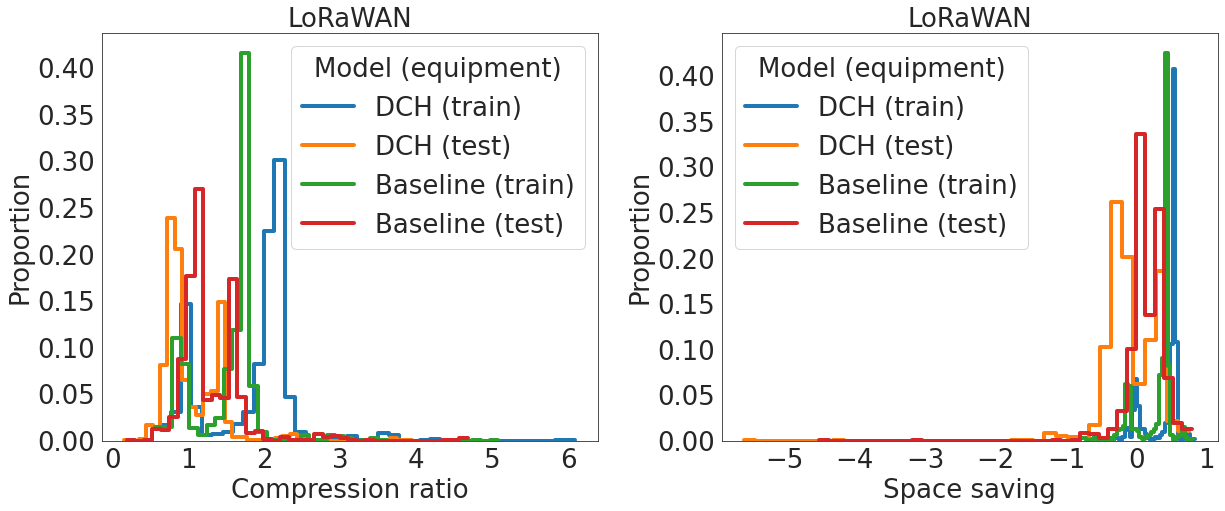

In [170]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)


# Parcourir les axes

df_plot = data_results.copy()

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['mode_equip']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]
    
    # SET FIRST AXIS

    
    # Set rank 
    #unique_values = df_plot[hue] \
    #                    .value_counts()\
    #                    .sort_index()\
    #                    .index

    for val in MODE_EQUIPS: #unique_values:
        cond = (df_plot[hue] == val)

        sns.histplot(df_plot[cond][col], 
                     element="step",
                     stat='probability',
                     bins=40,
                     linewidth=LINEWIDTH,
                     fill=False,
                     ax=ax)
        #ax.hist(df_plot[cond][col],
        #        density=False,
                #linewidth=LINEWIDTH,
        #        bins=70
        #       )

    # Set legend
    legend = ax.legend([val for val in MODE_EQUIPS], 
                       fontsize=LEGEND_FONTSIZE)
    legend.set_title('Model (equipment)', 
                     prop={'size':LEGEND_FONTSIZE})
        
        
    # Normalize axis
    '''yticklabels = ax.get_yticks() 
    yticklabels_update = np.round(
        yticklabels/df_plot[cond][col].shape[0], 3)'''
        
    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)
        
    # Set normalized labels
    #ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        

    # Set label  
    ax.set_ylabel("Proportion", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"{title}", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

#### 4.4 Performance compression TRAIN vs TEST equipment

In [139]:
ERROR_BAR = True
MODE_EQUIPS = []
USE_BASELINE = True

look_back_context = 2
look_back_packet = 16
PROTO = 'DNS' # /!| THE MODIFICATION OF PROTO IS DONE HERE !!!

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

for mode_equip in ['train', 'test']:
    
    # Add baseline
    MODE_EQUIPS.append(f"DCH ({mode_equip})")
    
    full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{look_back_packet}_SIN{NUM_SIN}_{PROTO}"
    
    if (CHECKSUM):
        if (CUSTOM_SIZE is not None):
            ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
        else:
            ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"
    else:
        if (CUSTOM_SIZE is not None):
            ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
        else:
            ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"
    
    data_results_tmp = pd.read_csv(f"./RESULTS/DEEP_LEARNING/df_{full_name}{ext_name}_LEFT_PADDING_COMPRESSION.csv")
    
    data_results_tmp["mode_equip"] = f"DCH ({mode_equip})"
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    

# Add baseline in comparaison
if (USE_BASELINE):
    
    look_back_context = 1
    look_back_packet = 8
    
    for mode_equip in ['train', 'test']:
        
        # Add baseline
        MODE_EQUIPS.append(f"Baseline ({mode_equip})")
    
        full_name = f"LOSSLESS_PACKET{look_back_packet}_{PROTO}"

        if (CHECKSUM):
            if (CUSTOM_SIZE is not None):
                ext_name = f"_BASELINE_NAIVE_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
            else:
                ext_name = f"_BASELINE_NAIVE_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"
        else:
            if (CUSTOM_SIZE is not None):
                ext_name= f"_BASELINE_NAIVE_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
            else:
                ext_name = f"_BASELINE_NAIVE_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"

        data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}{ext_name}_DECIMALSNone_LEFT_PADDING_COMPRESSION.csv")

        data_results_tmp["mode_equip"] = f"Baseline ({mode_equip})"

        data_results_tmp, _ = features_extraction(
            data_raw=data_raw, 
            data_results=data_results_tmp)

        data_results = pd.concat(
            [data_results, data_results_tmp], axis=0)
        
        
# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

In [140]:
# Setthe dict field
DICT_FIELDS = {}

if ('LORA' in PROTO):
    
    # LoRaWAN
    
    ## Mtype
    idx_start = 0
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Mtype"
            
    ## RFU
    idx_start = idx_end
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "RFU"
    
    ## Major
    idx_start = idx_end
    idx_end = idx_start + 2
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Major"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "DevAddr"
        
    ## Fctrl
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Fctrl"
        
    ## FCnt
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FCnt"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FOpts"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"


elif (PROTO in ['HTTP', 'SMTP', 'SSH', 'DNS']):
    
    # IPv4
    
    ## Set IP/HL/ToS
    idx_start = 0
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "IP/HL/ToS"
        
    ## Total length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Total length"
        
    ## Identification
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Id" # entification
        
    ## Indicator/FO
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Indicator/FO"
        
    ## TTL/Protocol
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "TTL/Protocol"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"
        
        
    # data_raw['length_0'] - data_raw['length_1']
    ip_header_length = (data_raw['length_0'] - \
                        data_raw['length_1']) \
                            .value_counts() \
                            .index.max()
    
    if (ip_header_length > 20):
        
        ## Options
        idx_start = idx_end
        idx_end = idx_start + 32
        for i in range(idx_start, idx_end):
            DICT_FIELDS[i] = "Options"
        
    
    print("[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end: ", 
          idx_end)
   # DICT_FIELDS = {v: k for k, v in enumerate(range(500))}
    
elif (PROTO in ["COAP", "MQTT_IEEE"]):
    
    # IPv6
    
    ## Version
    idx_start = 0
    idx_end = idx_start + 4
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Version"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Traffic class"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 20
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Flow label"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Payload length"
        
    ## Next header
    idx_start =  idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Next header"
        
    ## Hop limit
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Hop limit"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"


# Mettre champs TCP / UDP

if (PROTO in ['HTTP', 'SMTP', 'SSH', 'MQTT_IEEE']):
    
    # TCP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst port"
            
    ## Sequence number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Seq. number"
        
    ## ACK number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "ACK number"
        
    ## HL/Flags
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "HL/Flags"
        
    ## Windows
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Windows"
        
    ## CRC
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "CRC"
        
    ## Urgent pointer
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Urgent pointer"
        
    ## Option/Padding
    #idx_start = idx_end
    #idx_end = idx_start + 32
    #for i in range(idx_start, idx_end):
    #    DICT_FIELDS[i] = "Option/Padding"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"
        
    
elif (PROTO in ["DNS", 'COAP']):
    
    # UDP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dest. port"
        
    ## Length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Length"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"

[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end:  160


In [141]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
mode_equips = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []

for i in range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    for j in MODE_EQUIPS:
        
        cond_mode_equip = (data_results[
            'mode_equip'] == j)
        data_results_tmp = data_results[
            cond_mode_equip]
        
        # IF l'array is empty
        if (data_results_tmp.shape[0] != 0):

            # Init first steps

            '''bit_ranks.append(0)
            compression_ratio.append(0)
            space_saving.append(0)
            look_back_packets.append(j)

            low_yerror_compression_ratio.append(0)
            high_yerror_compression_ratio.append(0)

            low_yerror_space_saving.append(0)
            high_yerror_space_saving.append(0)'''

            # Compute each compress level

            for col in data_results.columns:
                if ("level_compress" in col):

                    # Add context size info
                    mode_equips.append(j)

                    # Extract bit rank
                    bit_rank = int(col.split("_")[-1])+1
                    bit_ranks.append(
                        bit_rank)

                    # Compute mean compresssion ratio
                    # Compression ratio = uncompressed / compressed
                    # for rank k
                    df_tmp_compression_ratio = bit_rank / \
                        data_results_tmp[col]
                    df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                    bit_rank)

                    ## Remove -1
                    cond = (data_results_tmp[col] != -1)
                    df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                    df_tmp_space_saving = df_tmp_space_saving[cond]
                    
                    #print("[DEBUG] np.isinf(df_tmp_compression_ratio).any(): ",
                    #         np.isinf(df_tmp_compression_ratio).any())
                    #if (np.isinf(df_tmp_compression_ratio).any()):
                    #    print("[DEBUG][if] data_results_tmp[col].value_counts(): ", 
                    #          data_results_tmp[col].value_counts())
                    
                    # Replace inf values
                    if (np.isinf(df_tmp_compression_ratio).any()):
                    
                        ## Index with inf values
                        cond = (df_tmp_compression_ratio \
                                    .isin([np.inf, -np.inf]))
                        indexes_inf = df_tmp_compression_ratio[cond].index

                        ## Get right values
                        values_new = data_results_tmp[
                            "headers_length"].iloc[indexes_inf]

                        ## Set the right values
                        df_tmp_compression_ratio \
                            .iloc[indexes_inf] = values_new.values

                    compression_ratio.append(
                        df_tmp_compression_ratio.mean())
                    space_saving.append(
                        df_tmp_space_saving.mean())

                    if (df_tmp_compression_ratio.shape[0] != 0):

                        # Compute std compression ratio
                        p = ((1.0-alpha)/2.0)
                        lower_compression_ratio = np.percentile(
                                df_tmp_compression_ratio.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_compression_ratio = np.percentile(
                                 df_tmp_compression_ratio.values, p)

                        # Compute std space saving
                        p = ((1.0-alpha)/2.0)
                        lower_space_saving = np.percentile(
                                df_tmp_space_saving.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_space_saving = np.percentile(
                                 df_tmp_space_saving.values, p)

                    else:
                        # Compression ratio
                        lower_compression_ratio = 0
                        upper_compression_ratio = 0

                        # Space saving
                        lower_space_saving = 0
                        upper_space_saving = 0

                    low_yerror_compression_ratio\
                        .append(lower_compression_ratio)
                    high_yerror_compression_ratio\
                        .append(upper_compression_ratio)

                    low_yerror_space_saving\
                        .append(lower_space_saving)
                    high_yerror_space_saving\
                        .append(upper_space_saving)


# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['mode_equip'] = mode_equips

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

# Extract difference

'''df_plot_diff = df_plot[
    ['compression_ratio', 
     'space_saving']] \
        .diff(1).fillna(0) \
        .rename(columns={'compression_ratio':'compression_ratio_diff',
                         'space_saving':'space_saving_diff'})
df_plot = pd.concat(
    [df_plot, df_plot_diff], axis=1)'''

"df_plot_diff = df_plot[\n    ['compression_ratio', \n     'space_saving']]         .diff(1).fillna(0)         .rename(columns={'compression_ratio':'compression_ratio_diff',\n                         'space_saving':'space_saving_diff'})\ndf_plot = pd.concat(\n    [df_plot, df_plot_diff], axis=1)"

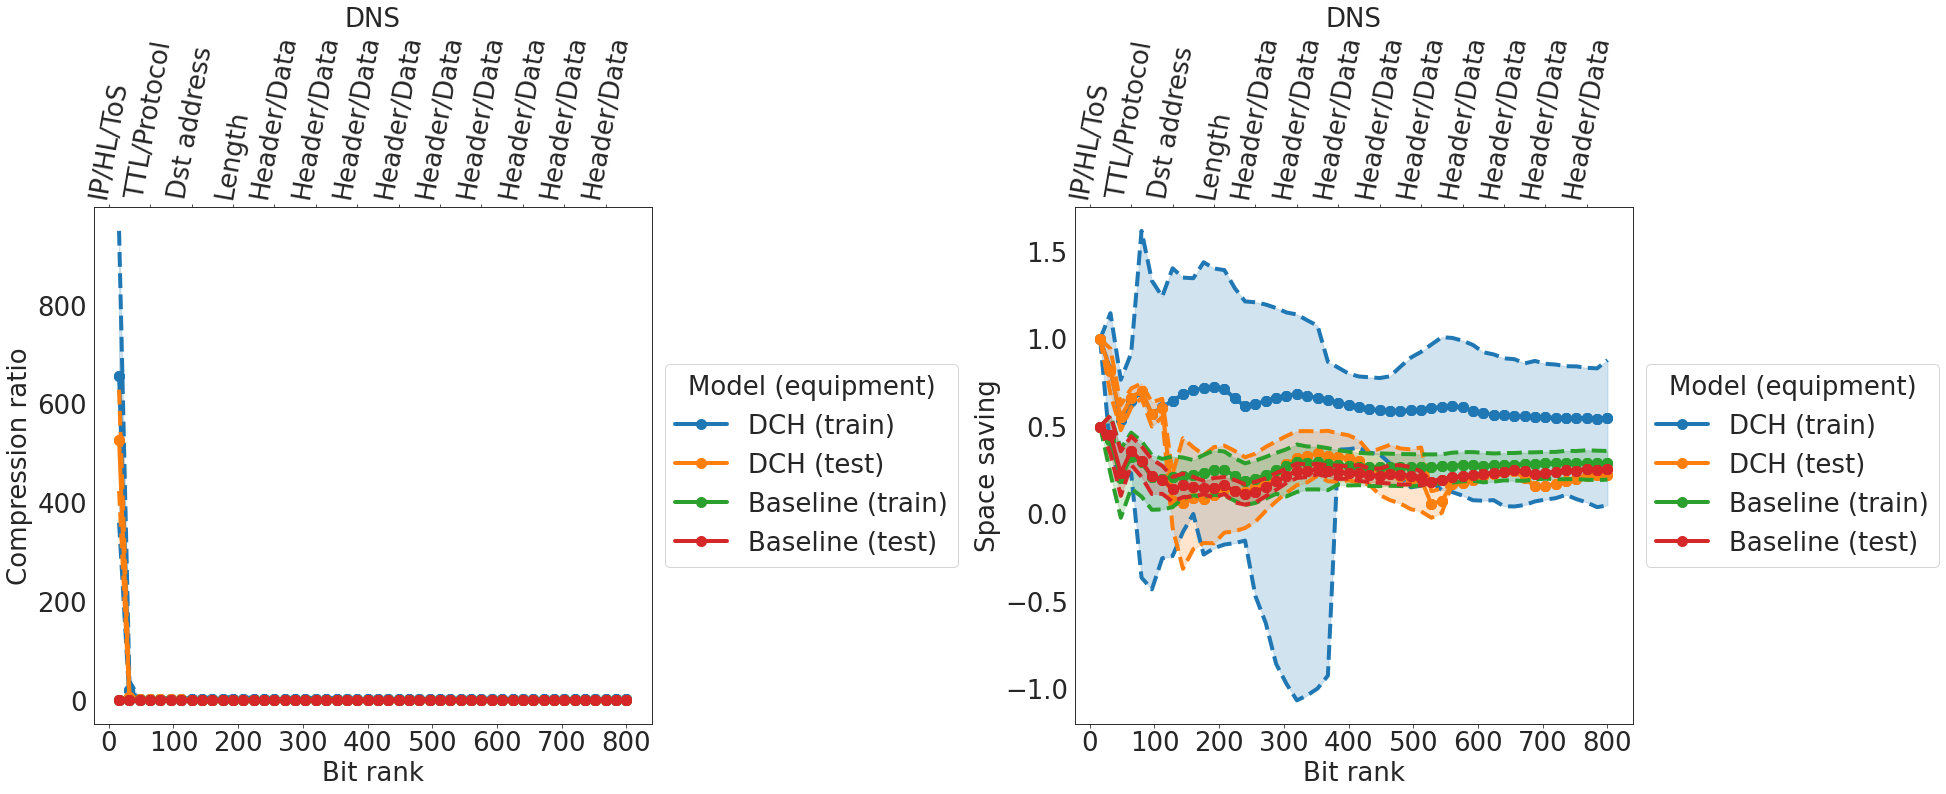

In [142]:
fig, axes = plt.subplots(
    1, 2, figsize=(20*2.1, 9.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
#fig.subplots_adjust(wspace=0.25, 
#                    hspace=1.1)
fig.subplots_adjust(wspace=-0.28, 
                    hspace=1.1)

# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['mode_equip']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    ax1 = ax
    ax2 = ax1.twiny()

    #err_bar = [df_plot['low_yerror'], 
    #           df_plot['low_yerror']]
    #err_bar = [[0]*df_plot.shape[0], 
    #           [0]*df_plot.shape[0]]

    
    # SET FIRST AXIS

    
    # Set rank 
    #unique_values = df_plot[hue] \
    #                    .value_counts()\
    #                    .sort_index()\
    #                    .index

    for val in MODE_EQUIPS: #unique_values:
        cond = (df_plot[hue] == val)

        if (ERROR_BAR):
            lower = (df_plot[cond][col]-\
                df_plot[cond]['low_yerror_'+col]).abs()
            upper = (df_plot[cond]['high_yerror_'+col]-\
                df_plot[cond][col]).abs()
            err_bar = [lower, 
                       upper]
            #err_bar = [(df_plot[cond][col]-df_plot[cond]['low_yerror']).abs(), 
            #           (df_plot[cond]['high_yerror']-df_plot[cond][col]).abs()]
            #err_bar = [[0]*df_plot[cond].shape[0], 
            #           [0]*df_plot[cond].shape[0]]
            '''ax1.errorbar(df_plot[cond]['bit_ranks'], 
                         df_plot[cond][col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         fmt='o', yerr=err_bar)'''
            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
            
            # Get color from mean plot
            last_line = ax1.get_lines()[-1]
            color_last_line = last_line.get_color()
            
            # Set error area with alpha
            ax1.fill_between(df_plot[cond]['bit_ranks'],
                             df_plot[cond][col]-lower, 
                             df_plot[cond][col]+upper,
                             alpha=0.2,
                             color=color_last_line)
            
            # Set min and max for error area
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]-lower,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]+upper,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            
        else:
            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
            
        # Parameter for outside legend
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Set legend
        legend = ax1.legend(fontsize=LEGEND_FONTSIZE,
                           # Parameter for outside legend
                           loc='center left',
                           bbox_to_anchor=(1, 0.5),
                           frameon=True)
        legend.set_title('Model (equipment)', 
                         prop={'size':LEGEND_FONTSIZE})
        

    for item in ax1.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax1.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax1.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax1.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

    # SET SECOND AXIS


    def tick_function(ranks_bit):
        values = []
        for val in ranks_bit:
            values.append(
                DICT_FIELDS[val])
        return values

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    #if (hue is None):
    new_tick_locations = [i for i in range(
        0, idx_end, 64)]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(
        tick_function(new_tick_locations))

    # Set field name
    #ax2 = ax1.twiny()
    ax2.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax2.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(80)

    ax2.grid(False)

#### 4.5 Compression performance HISTOGRAM PER packet SHUFFLE / no SHUFFLE VS BASELINE / BASELINE NAIVE equipment

In [26]:
ERROR_BAR = True
MODELS_TYPE = ["Shuffle", "No Shuffle", 
              "Baseline", "Baseline Naive"]

look_back_context = 1
look_back_packet = 8
mode_equip = 'train'
PROTO = 'HTTP' # /!| THE MODIFICATION OF PROTO IS DONE HERE !!!

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")


if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
    else:
        ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"
else:
    if (CUSTOM_SIZE is not None):
        ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
    else:
        ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"


# LOAD SHUFFLE MODEL RESULTS


full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{look_back_packet}_SIN{NUM_SIN}_{PROTO}"
data_results_tmp = pd.read_csv(f"./RESULTS/DEEP_LEARNING/df_{full_name}{ext_name}_COMPRESSION.csv")

data_results_tmp["model_type"] = "Shuffle"

data_results_tmp, _ = features_extraction(
    data_raw=data_raw, 
    data_results=data_results_tmp)

data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

In [20]:
ERROR_BAR = True
MODELS_TYPE = ["Shuffle", "No Shuffle", 
              "Baseline", "Baseline Naive"]

look_back_context = 1
look_back_packet = 8
mode_equip = 'train'
PROTO = 'LORA_20' # /!| THE MODIFICATION OF PROTO IS DONE HERE !!!

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")


if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
    else:
        ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"
else:
    if (CUSTOM_SIZE is not None):
        ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
    else:
        ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"


# LOAD SHUFFLE MODEL RESULTS


full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{look_back_packet}_SIN{NUM_SIN}_{PROTO}"
data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}{ext_name}_COMPRESSION.csv")

data_results_tmp["model_type"] = "Shuffle"

data_results_tmp, _ = features_extraction(
    data_raw=data_raw, 
    data_results=data_results_tmp)

data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)


# LOAD NO SHUFFLE MODEL RESULTS


full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{look_back_packet}_SIN{NUM_SIN}_{PROTO}"
data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}{ext_name}_COMPRESSION_NO_SHUFFLE.csv")

data_results_tmp["model_type"] = "No Shuffle"

data_results_tmp, _ = features_extraction(
    data_raw=data_raw, 
    data_results=data_results_tmp)

data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)


# LOAD BASELINE MODEL RESULTS


full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{look_back_packet}_SIN{NUM_SIN}_{PROTO}"
data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}_BASELINE{EXT_NAME}_DECIMALSNone_COMPRESSION.csv")

data_results_tmp["model_type"] = "Baseline"

data_results_tmp, _ = features_extraction(
    data_raw=data_raw, 
    data_results=data_results_tmp)

data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)


# LOAD BASELINE NAIVE MODEL RESULTS


full_name = f"LOSSLESS_PACKET{look_back_packet}_{PROTO}"
data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}_BASELINE_NAIVE{EXT_NAME}_DECIMALSNone_COMPRESSION.csv")

data_results_tmp["model_type"] = "Baseline Naive"

data_results_tmp, _ = features_extraction(
    data_raw=data_raw, 
    data_results=data_results_tmp)

data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

In [24]:
# Setthe dict field
DICT_FIELDS = {}

if ('LORA' in PROTO):
    
    # LoRaWAN
    
    ## Mtype
    idx_start = 0
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Mtype"
            
    ## RFU
    idx_start = idx_end
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "RFU"
    
    ## Major
    idx_start = idx_end
    idx_end = idx_start + 2
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Major"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "DevAddr"
        
    ## Fctrl
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Fctrl"
        
    ## FCnt
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FCnt"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FOpts"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"


elif (PROTO in ['HTTP', 'SMTP', 'SSH', 'DNS']):
    
    # IPv4
    
    ## Set IP/HL/ToS
    idx_start = 0
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "IP/HL/ToS"
        
    ## Total length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Total length"
        
    ## Identification
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Id" # entification
        
    ## Indicator/FO
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Indicator/FO"
        
    ## TTL/Protocol
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "TTL/Protocol"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"
        
        
    # data_raw['length_0'] - data_raw['length_1']
    ip_header_length = (data_raw['length_0'] - \
                        data_raw['length_1']) \
                            .value_counts() \
                            .index.max()
    
    if (ip_header_length > 20):
        
        ## Options
        idx_start = idx_end
        idx_end = idx_start + 32
        for i in range(idx_start, idx_end):
            DICT_FIELDS[i] = "Options"
        
    
    print("[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end: ", 
          idx_end)
   # DICT_FIELDS = {v: k for k, v in enumerate(range(500))}
    
elif (PROTO in ["COAP", "MQTT_IEEE"]):
    
    # IPv6
    
    ## Version
    idx_start = 0
    idx_end = idx_start + 4
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Version"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Traffic class"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 20
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Flow label"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Payload length"
        
    ## Next header
    idx_start =  idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Next header"
        
    ## Hop limit
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Hop limit"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst address"


# Mettre champs TCP / UDP

if (PROTO in ['HTTP', 'SMTP', 'SSH', 'MQTT_IEEE']):
    
    # TCP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dst port"
            
    ## Sequence number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Seq. number"
        
    ## ACK number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "ACK number"
        
    ## HL/Flags
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "HL/Flags"
        
    ## Windows
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Windows"
        
    ## CRC
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "CRC"
        
    ## Urgent pointer
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Urgent pointer"
        
    ## Option/Padding
    #idx_start = idx_end
    #idx_end = idx_start + 32
    #for i in range(idx_start, idx_end):
    #    DICT_FIELDS[i] = "Option/Padding"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"
        
    
elif (PROTO in ["DNS", 'COAP']):
    
    # UDP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Src port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Dest. port"
        
    ## Length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Length"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Header/Data"

In [25]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
models_type = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []

for i in range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    for j in MODELS_TYPE:
        
        cond_mode_equip = (data_results[
            'model_type'] == j)
        data_results_tmp = data_results[
            cond_mode_equip]
        
        # IF l'array is empty
        if (data_results_tmp.shape[0] != 0):

            # Init first steps

            '''bit_ranks.append(0)
            compression_ratio.append(0)
            space_saving.append(0)
            look_back_packets.append(j)

            low_yerror_compression_ratio.append(0)
            high_yerror_compression_ratio.append(0)

            low_yerror_space_saving.append(0)
            high_yerror_space_saving.append(0)'''

            # Compute each compress level

            for col in data_results.columns:
                if ("level_compress" in col):

                    # Add context size info
                    models_type.append(j)

                    # Extract bit rank
                    bit_rank = int(col.split("_")[-1])+1
                    bit_ranks.append(
                        bit_rank)

                    # Compute mean compresssion ratio
                    # Compression ratio = uncompressed / compressed
                    # for rank k
                    df_tmp_compression_ratio = bit_rank / \
                        data_results_tmp[col]
                    df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                    bit_rank)

                    ## Remove -1
                    cond = (data_results_tmp[col] != -1)
                    df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                    df_tmp_space_saving = df_tmp_space_saving[cond]

                    compression_ratio.append(
                        df_tmp_compression_ratio.mean())
                    space_saving.append(
                        df_tmp_space_saving.mean())

                    if (df_tmp_compression_ratio.shape[0] != 0):

                        # Compute std compression ratio
                        p = ((1.0-alpha)/2.0)
                        lower_compression_ratio = np.percentile(
                                df_tmp_compression_ratio.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_compression_ratio = np.percentile(
                                 df_tmp_compression_ratio.values, p)

                        # Compute std space saving
                        p = ((1.0-alpha)/2.0)
                        lower_space_saving = np.percentile(
                                df_tmp_space_saving.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_space_saving = np.percentile(
                                 df_tmp_space_saving.values, p)

                    else:
                        # Compression ratio
                        lower_compression_ratio = 0
                        upper_compression_ratio = 0

                        # Space saving
                        lower_space_saving = 0
                        upper_space_saving = 0

                    low_yerror_compression_ratio\
                        .append(lower_compression_ratio)
                    high_yerror_compression_ratio\
                        .append(upper_compression_ratio)

                    low_yerror_space_saving\
                        .append(lower_space_saving)
                    high_yerror_space_saving\
                        .append(upper_space_saving)


# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['model_type'] = models_type

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

# Extract difference

'''df_plot_diff = df_plot[
    ['compression_ratio', 
     'space_saving']] \
        .diff(1).fillna(0) \
        .rename(columns={'compression_ratio':'compression_ratio_diff',
                         'space_saving':'space_saving_diff'})
df_plot = pd.concat(
    [df_plot, df_plot_diff], axis=1)'''

"df_plot_diff = df_plot[\n    ['compression_ratio', \n     'space_saving']]         .diff(1).fillna(0)         .rename(columns={'compression_ratio':'compression_ratio_diff',\n                         'space_saving':'space_saving_diff'})\ndf_plot = pd.concat(\n    [df_plot, df_plot_diff], axis=1)"

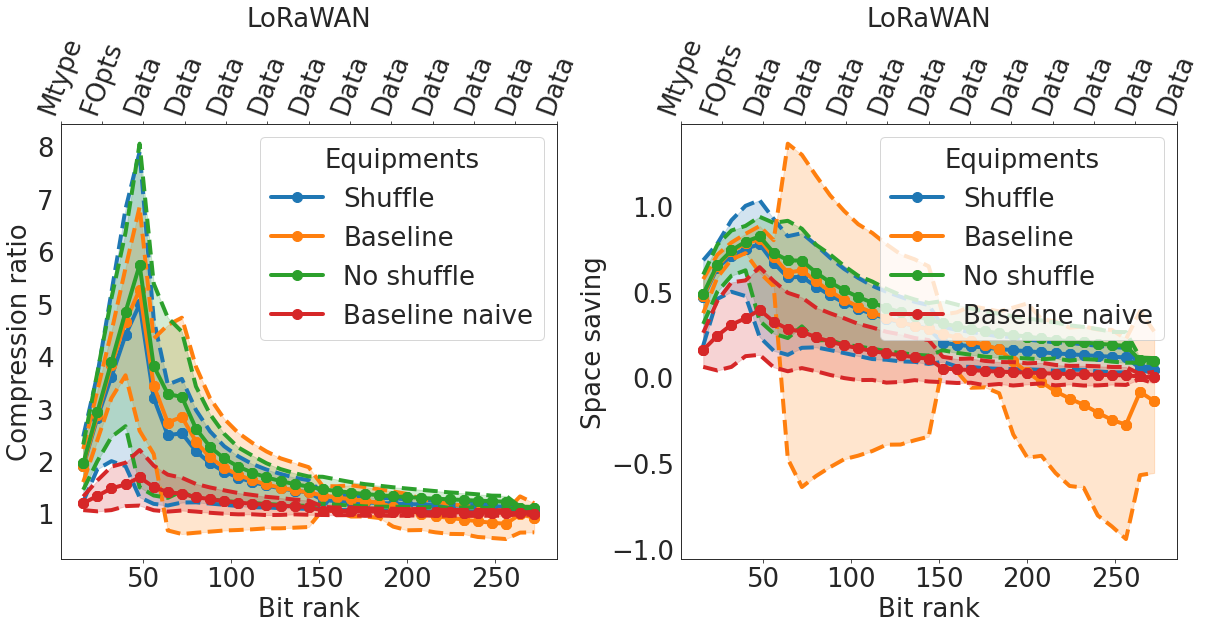

In [26]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 8))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=1.1)

# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['model_type']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    ax1 = ax
    ax2 = ax1.twiny()

    #err_bar = [df_plot['low_yerror'], 
    #           df_plot['low_yerror']]
    #err_bar = [[0]*df_plot.shape[0], 
    #           [0]*df_plot.shape[0]]

    
    # SET FIRST AXIS

    
    # Set rank 
    unique_values = df_plot[hue] \
                        .value_counts()\
                        .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        if (ERROR_BAR):
            lower = (df_plot[cond][col]-\
                df_plot[cond]['low_yerror_'+col]).abs()
            upper = (df_plot[cond]['high_yerror_'+col]-\
                df_plot[cond][col]).abs()
            err_bar = [lower, 
                       upper]
            #err_bar = [(df_plot[cond][col]-df_plot[cond]['low_yerror']).abs(), 
            #           (df_plot[cond]['high_yerror']-df_plot[cond][col]).abs()]
            #err_bar = [[0]*df_plot[cond].shape[0], 
            #           [0]*df_plot[cond].shape[0]]
            '''ax1.errorbar(df_plot[cond]['bit_ranks'], 
                         df_plot[cond][col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         fmt='o', yerr=err_bar)'''
            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val.capitalize()}",
                     marker='o',
                     #linestyle="--",
                    )
            
            # Get color from mean plot
            last_line = ax1.get_lines()[-1]
            color_last_line = last_line.get_color()
            
            # Set error area with alpha
            ax1.fill_between(df_plot[cond]['bit_ranks'],
                             df_plot[cond][col]-lower, 
                             df_plot[cond][col]+upper,
                             alpha=0.2,
                             color=color_last_line)
            
            # Set min and max for error area
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]-lower,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]+upper,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            
        else:
            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val.capitalize()}",
                     marker='o',
                     #linestyle="--",
                    )

        # Set legend
        legend = ax1.legend(fontsize=LEGEND_FONTSIZE)
        legend.set_title('Equipments', 
                         prop={'size':LEGEND_FONTSIZE})
        

    for item in ax1.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax1.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax1.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax1.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

    # SET SECOND AXIS


    def tick_function(ranks_bit):
        values = []
        for val in ranks_bit:
            values.append(
                DICT_FIELDS[val])
        return values

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    #if (hue is None):
    new_tick_locations = [i for i in range(
        0, idx_end, 64)]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(
        tick_function(new_tick_locations))

    # Set field name
    #ax2 = ax1.twiny()
    ax2.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax2.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(70)

    ax2.grid(False)

#### 4.6 Performance compression SHUFFLE / no SHUFFLE VS BASELINE / BASELINE NAIVE equipment

In [48]:
ERROR_BAR = True

look_back_context = 1
look_back_packet = 8
mode_equip = 'train'
PROTO = 'HTTP' # /!| THE MODIFICATION OF PROTO IS DONE HERE !!!

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")


if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
    else:
        ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"
else:
    if (CUSTOM_SIZE is not None):
        ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{mode_equip}"
    else:
        ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{mode_equip}"


# LOAD SHUFFLE MODEL RESULTS


full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{look_back_packet}_SIN{NUM_SIN}_{PROTO}"
data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}{ext_name}_COMPRESSION.csv")

data_results_tmp["model_type"] = "Shuffle"

data_results_tmp, _ = features_extraction(
    data_raw=data_raw, 
    data_results=data_results_tmp)

data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)


# LOAD NO SHUFFLE MODEL RESULTS


full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{look_back_packet}_SIN{NUM_SIN}_{PROTO}"
data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}{ext_name}_COMPRESSION_NO_SHUFFLE.csv")

data_results_tmp["model_type"] = "No Shuffle"

data_results_tmp, _ = features_extraction(
    data_raw=data_raw, 
    data_results=data_results_tmp)

data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)


# LOAD BASELINE MODEL RESULTS


full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{look_back_packet}_SIN{NUM_SIN}_{PROTO}"
data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}_BASELINE{EXT_NAME}_DECIMALSNone_COMPRESSION.csv")

data_results_tmp["model_type"] = "Baseline"

data_results_tmp, _ = features_extraction(
    data_raw=data_raw, 
    data_results=data_results_tmp)

data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)


# LOAD BASELINE NAIVE MODEL RESULTS


full_name = f"LOSSLESS_PACKET{look_back_packet}_{PROTO}"
data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}_BASELINE_NAIVE{EXT_NAME}_DECIMALSNone_COMPRESSION.csv")

data_results_tmp["model_type"] = "Baseline Naive"

data_results_tmp, _ = features_extraction(
    data_raw=data_raw, 
    data_results=data_results_tmp)

data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)


# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

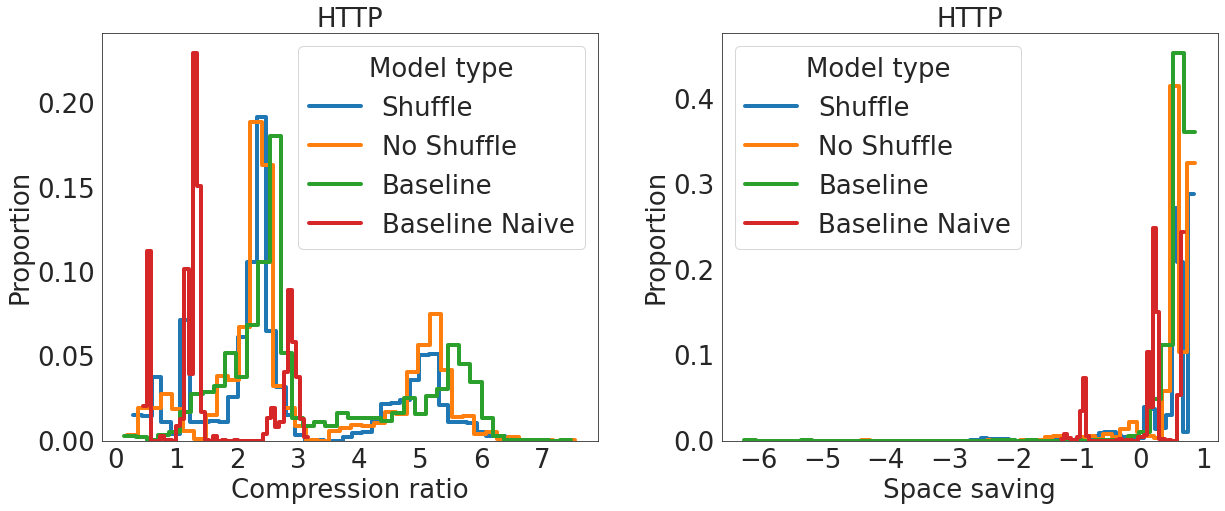

In [49]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)


# Parcourir les axes

df_plot = data_results.copy()

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['model_type']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]
    
    # SET FIRST AXIS

    
    # Set rank 
    unique_values = df_plot[hue] \
                        .value_counts()\
                        .index

    for val in unique_values:
        cond = (df_plot[hue] == val)
        
        sns.histplot(df_plot[cond][col], 
                     element="step",
                     stat='probability',
                     bins=40,
                     linewidth=LINEWIDTH,
                     fill=False,
                     ax=ax)
        #ax.hist(df_plot[cond][col],
        #        density=False,
                #linewidth=LINEWIDTH,
        #        bins=70
        #       )

    # Set legend
    legend = ax.legend([val for val in unique_values], 
                       fontsize=LEGEND_FONTSIZE)
    legend.set_title('Model type', 
                     prop={'size':LEGEND_FONTSIZE})
        
        
    # Normalize axis
    '''yticklabels = ax.get_yticks() 
    yticklabels_update = np.round(
        yticklabels/df_plot[cond][col].shape[0], 3)'''
        
    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)
        
    # Set normalized labels
    #ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        

    # Set label  
    ax.set_ylabel("Proportion", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"{title}", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

#### 4.7 Performance compression SELECTIVE / no SELECTIVE / OPTIMAL / no OPTIMAL / KEEP ERROR or not

In [25]:
LOOK_BACK_PACKETS = 8 #[2, 4, 8, 16, 32]
LOOK_BACK_CONTEXT = 1

OPTIMALS = [True, False]
SELECTIVES = [True, False]

USE_BASELINE = True
PROTO = "LORA_20"

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

for optimal in OPTIMALS:
    
    for selective in SELECTIVES:
    
        full_name = f"LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_{PROTO}_HUFFMAN{EXT_NAME}_KEEP_ERROR_4_DECIMALSNone"
        
        if (selective):
            full_name = full_name + "_SELECTIVE"
        
        if (optimal):
            full_name = full_name + "_OPTIMAL"
        
        data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}_COMPRESSION.csv")
        
        data_results_tmp["selective/optimal"] = \
            str(selective)+"/"+str(optimal)
        #data_results_tmp["selective"] = selective

        data_results_tmp, _ = features_extraction(
            data_raw=data_raw, 
            data_results=data_results_tmp)

        data_results = pd.concat(
            [data_results, data_results_tmp], axis=0)
    
    
# Add baseline in comparaison
if (USE_BASELINE):
    
    look_back_context = 1
    look_back_packet = 8
    full_name = f"LOSSLESS_PACKET{look_back_packet}_{PROTO}"
    data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}_BASELINE_NAIVE{EXT_NAME}_DECIMALSNone_COMPRESSION.csv")
    
    data_results_tmp["selective/optimal"] = "Baseline"
    
    data_results_tmp, _ = features_extraction(
        data_raw=data_raw, 
        data_results=data_results_tmp)
    
    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

FileNotFoundError: [Errno 2] No such file or directory: './RESULTS/df_LOSSLESS_CONTEXT1_PACKET8_SIN8_LORA_20_HUFFMAN_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_KEEP_ERROR_4_DECIMALSNone_SELECTIVE_OPTIMAL_COMPRESSION.csv'

In [54]:
full_name = f"LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_{PROTO}_HUFFMAN{EXT_NAME}_2_DECIMALSNone"

if (selective):
    full_name = full_name + "_SELECTIVE"

if (optimal):
    full_name = full_name + "_OPTIMAL"

data_results_tmp = pd.read_csv(f"./RESULTS/df_{full_name}_COMPRESSION.csv")

data_results_tmp["selective/optimal"] = \
    str(selective)+"/"+str(optimal)+"NO_ERROR"
#data_results_tmp["selective"] = selective

data_results_tmp, _ = features_extraction(
    data_raw=data_raw, 
    data_results=data_results_tmp)

data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

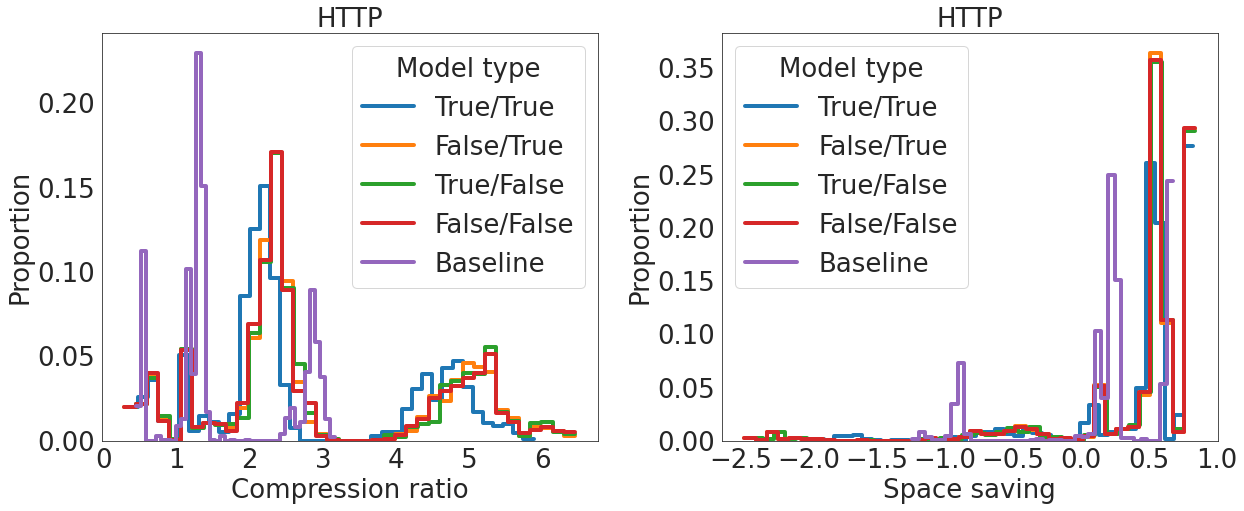

In [18]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)


# Parcourir les axes

df_plot = data_results.copy()

for ax, hue, col, title in zip(
    axes.ravel(), 
    ["selective/optimal"]*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]
    
    # SET FIRST AXIS

    
    # Set rank 
    unique_values = df_plot[hue] \
                        .value_counts()\
                        .index

    for val in unique_values:
        cond = (df_plot[hue] == val)
        
        sns.histplot(df_plot[cond][col], 
                     element="step",
                     stat='probability',
                     bins=40,
                     linewidth=LINEWIDTH,
                     fill=False,
                     ax=ax)
        #ax.hist(df_plot[cond][col],
        #        density=False,
                #linewidth=LINEWIDTH,
        #        bins=70
        #       )

    # Set legend
    legend = ax.legend([val for val in unique_values], 
                       fontsize=LEGEND_FONTSIZE)
    legend.set_title('Model type', 
                     prop={'size':LEGEND_FONTSIZE})
        
        
    # Normalize axis
    '''yticklabels = ax.get_yticks() 
    yticklabels_update = np.round(
        yticklabels/df_plot[cond][col].shape[0], 3)'''
        
    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)
        
    # Set normalized labels
    #ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        

    # Set label  
    ax.set_ylabel("Proportion", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"{title}", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

#### 4.4.5 Number of entry function of nb bits for Huffman table

In [33]:
ERROR_BAR = True
CUT_VALUES = [2, 4, 6, 8, 10, 12, 16, 20]
PROTOS = ['HTTP', 'SMTP', 'DNS', 'LORA_20', 'MQTT_IEEE', 'COAP'] #['random', 'checksum34', 'fixed_flow', 
                # "fixed", 'inversion', 'counter'#, 'combinaison'
                #]

LOOK_BACK_CONTEXT = 2
LOOK_BACK_PACKET = 16
LEFT_PADDING = True
NB_BITS = 8 #16*2

# Options for huffman table
# construction
OPTIMAL = True
SELECTIVE = True
USE_BASELINE = False

data_results = pd.DataFrame()
index_results = 0


# CHANGE DATAFRAME FORMAT 
def my_func(x, max_length=8):
    value = str(x)
    length = len(value)
    value_extend = "0"*(max_length-length)
    value = value_extend + value
    return value

for proto in PROTOS:

    for cut_value in tqdm(CUT_VALUES):

        for optimal in [True]:

            # Load HUFFMAN
            # df_HUFFMAN_LOSSLESS_CONTEXT2_PACKET16_SIN8_COAP_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_KEEP_ERROR_6_SELECTIVE_OPTIMAL_LEFT_PADDING.csv

            if (CHECKSUM):
                if (CUSTOM_SIZE is not None):
                    ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIPtrain_KEEP_ERROR_{cut_value}"
                else:
                    ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIPtrain_KEEP_ERROR_{cut_value}"
            else:
                if (CUSTOM_SIZE is not None):
                    ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIPtrain_KEEP_ERROR_{cut_value}"
                else:
                    ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIPtrain_KEEP_ERROR_{cut_value}"

            if (SELECTIVE):
                ext_name = ext_name + "_SELECTIVE"

            if (optimal):
                ext_name = ext_name + "_OPTIMAL"

            if (LEFT_PADDING):
                ext_name = ext_name + "_LEFT_PADDING"

            full_name = f"HUFFMAN_LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_{proto}"
            df_huffman_tmp = pd.read_csv(f"./MODELS/HUFFMAN/DEEP_LEARNING/df_{full_name}{ext_name}.csv", 
                                         dtype={"key": str})

            df_huffman_tmp['key'] = df_huffman_tmp['key'].map(
                lambda x : my_func(x, max_length=cut_value))
            df_huffman_groupby = df_huffman_tmp.groupby(
                ['ctx', 'pos', 'key']).mean()

            # Save results

            data_results.loc[index_results, "nb_value"] = \
                df_huffman_groupby.shape[0]
            data_results.loc[index_results, "cut_value"] = \
                int(cut_value)
            data_results.loc[index_results, "max_cut_value"] = \
                (2**int(cut_value))*NB_BITS*(LOOK_BACK_CONTEXT+1)
            data_results.loc[index_results, "proto"] = \
                proto
            data_results.loc[index_results, "optimal"] = \
                optimal

            # Add index

            index_results += 1
    
# Compute percentage
data_results["percent_nb_value"] = \
    (data_results["nb_value"] / data_results["max_cut_value"]) / 100

In [38]:
# Compute percentage
data_results["percent_nb_value"] = \
    (data_results["nb_value"] / data_results["max_cut_value"]) / 100

In [37]:
(2**int(cut_value))*NB_BITS*(LOOK_BACK_CONTEXT+1)

25165824

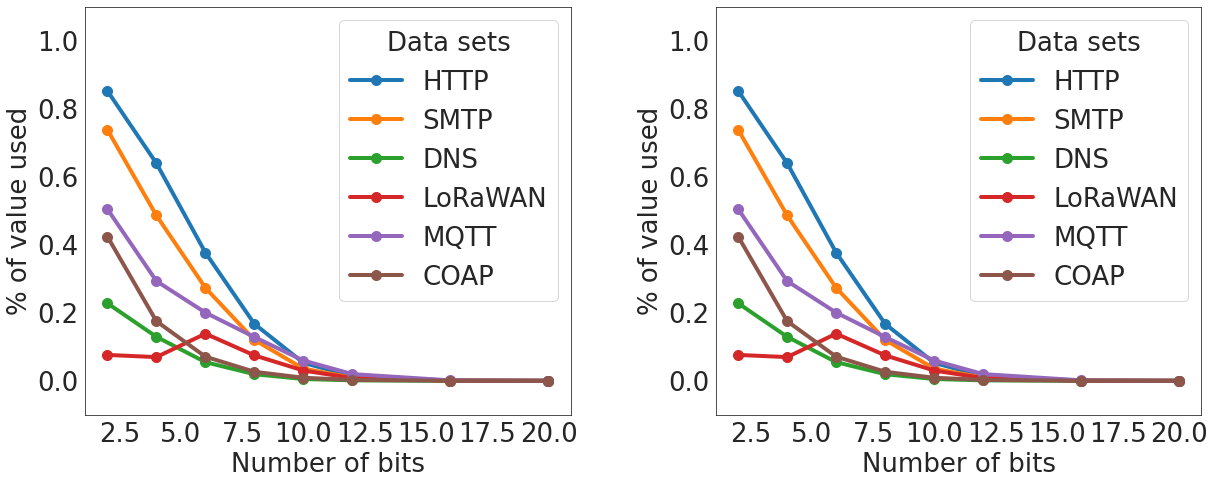

In [39]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
ax = axes[0]

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.3, 
                    hspace=1.1)

df_plot = data_results.copy()

# Parcourir les axes
#hue = "optimal"
#col = 'percent_nb_value'
#title = MODE_DATASET

for ax, col, hue in zip(
    axes.ravel(),
    ['percent_nb_value']*2,
    ["proto"]*2
    #['compression_ratio', 'space_saving'],
    #[f"Compression ratio", f"Space saving"]
): #[f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    #ax1 = ax
    #ax2 = ax1.twiny()

    # SET FIRST AXIS
    
    # Set rank 
    #unique_values = df_plot[hue] \
    #                    .value_counts() \
    #                    .sort_index() \
    #                    .index
            
    for val in PROTOS: #unique_values:

        cond = (df_plot[hue] == val)

        # Set rank 
        ax.plot(df_plot[cond]['cut_value'].astype(int), 
                 df_plot[cond][col],
                 linewidth=LINEWIDTH,
                 markersize=MARKERSIZE, # Size of point
                 alpha=1,
                 label=f"{val}",
                 marker='o',
                 #linestyle="--",
                )

    # Set legend
    protos = []
    for proto in PROTOS:
        if (proto == "LORA_20"):
            protos.append("LoRaWAN")
        elif (proto == "MQTT_IEEE"):
            protos.append("MQTT")
        elif (proto == "COAP"):
            protos.append("CoAP")
        else:
            protos.append(proto)
        #else:
        #    mode_datasets.append(mode_d\
        #                        .replace("_", " ")\
        #                        .capitalize())
        
    legend = ax.legend(protos, 
                       fontsize=LEGEND_FONTSIZE)
    legend.set_title('Data sets', 
                     prop={'size':LEGEND_FONTSIZE})


    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax.set_ylabel('Compression ratio', 
                   fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"Number of bits", 
                   fontsize=LABEL_FONTSIZE)

    # Set axis limit
    '''lower_ylimit = df_plot[
        ['huffman_table', 
         'freqs_array_compress']].min().min()
    upper_ylimit = df_plot[
        ['huffman_table', 
         'freqs_array_compress']].max().max()
    upper_ylimit = upper_ylimit + \
        upper_ylimit*0.1'''

    #print("[DEBUG] lower_ylimit: ", lower_ylimit)
    #print("[DEBUG] upper_ylimit: ", upper_ylimit)

    ax.set_ylim([-0.1, 1.1])

    # Set title
    '''if (MODE_DATASET == "checksum34"):
        title = "Checksum"
    else:
        title = MODE_DATASET\
                .replace("_", " ")\
                .capitalize()

    ax.set_title(f"{title}", 
                fontsize=TITLE_FONTSIZE)'''

### 4.8 INTERPRETATION

#### 4.8.1 Performance compression MODE_DATASET

In [16]:
ERROR_BAR = True
MODES_DATASET = ['random', 'checksum34', 'fixed_flow', "fixed", 'inversion', 'counter']

LOOK_BACK_CONTEXT = 1
LOOK_BACK_PACKET = 8
LEFT_PADDING = True

data_results = pd.DataFrame()

for mode_d in MODES_DATASET:

    if (CHECKSUM):
        if (CUSTOM_SIZE is not None):
            ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{mode_d}"
        else:
            ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{mode_d}"
    else:
        if (CUSTOM_SIZE is not None):
            ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{mode_d}"
        else:
            ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{mode_d}"
            
    if (LEFT_PADDING):
        ext_name = ext_name + "_LEFT_PADDING"

    full_name = f"LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}"
    data_results_tmp = pd.read_csv(f"./RESULTS/INTERPRETATION/df_{full_name}{ext_name}_COMPRESSION.csv")

    if (mode_d == "checksum34"):
        data_results_tmp["mode_dataset"] = \
            "checksum"
    else:
        data_results_tmp["mode_dataset"] = \
            mode_d.replace("_", " ")
        
    data_results_tmp['size_uncompress'] = \
            data_results_tmp['headers_length']

    # Correct value
    data_results_tmp['size_context'] = \
        data_results_tmp['packets_rank']
    cond = (data_results_tmp['packets_rank'] >= LOOK_BACK_CONTEXT)
    data_results_tmp.loc[cond, 'size_context'] = LOOK_BACK_CONTEXT

    # Compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / \
                 (data_results_tmp["size_uncompress"]))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

FileNotFoundError: [Errno 2] No such file or directory: './RESULTS/INTERPRETATION/df_LOSSLESS_CONTEXT1_PACKET8_SIN8_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_DATASETchecksum34_LEFT_PADDING_COMPRESSION.csv'

In [29]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
mode_dataset = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []

for i in range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    for j in MODES_DATASET:
        
        cond_mode_equip = (data_results[
            'mode_dataset'] == j.replace("_", " "))
        data_results_tmp = data_results[
            cond_mode_equip]
        
        # IF l'array is empty
        if (data_results_tmp.shape[0] != 0):

            # Compute each compress level

            for col in data_results.columns:
                if ("level_compress" in col):

                    # Add context size info
                    mode_dataset.append(j.replace("_", " "))

                    # Extract bit rank
                    bit_rank = int(col.split("_")[-1])+1
                    bit_ranks.append(
                        bit_rank)

                    # Compute mean compresssion ratio
                    # Compression ratio = uncompressed / compressed
                    # for rank k
                    df_tmp_compression_ratio = bit_rank / \
                        data_results_tmp[col]
                    df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                    bit_rank)

                    ## Remove -1
                    cond = (data_results_tmp[col] != -1)
                    df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                    df_tmp_space_saving = df_tmp_space_saving[cond]
                    
                    #print("[DEBUG] np.isinf(df_tmp_compression_ratio).any(): ",
                    #         np.isinf(df_tmp_compression_ratio).any())
                    #if (np.isinf(df_tmp_compression_ratio).any()):
                    #    print("[DEBUG][if] data_results_tmp[col].value_counts(): ", 
                    #          data_results_tmp[col].value_counts())
                    
                    # Replace inf values
                    if (np.isinf(df_tmp_compression_ratio).any()):
                    
                        ## Index with inf values
                        cond = (df_tmp_compression_ratio \
                                    .isin([np.inf, -np.inf]))
                        indexes_inf = df_tmp_compression_ratio[cond].index

                        ## Get right values
                        values_new = data_results_tmp[
                            "headers_length"].iloc[indexes_inf]

                        ## Set the right values
                        df_tmp_compression_ratio \
                            .iloc[indexes_inf] = values_new.values

                    compression_ratio.append(
                        df_tmp_compression_ratio.mean())
                    space_saving.append(
                        df_tmp_space_saving.mean())

                    if (df_tmp_compression_ratio.shape[0] != 0):

                        # Compute std compression ratio
                        p = ((1.0-alpha)/2.0)
                        lower_compression_ratio = np.percentile(
                                df_tmp_compression_ratio.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_compression_ratio = np.percentile(
                                 df_tmp_compression_ratio.values, p)

                        # Compute std space saving
                        p = ((1.0-alpha)/2.0)
                        lower_space_saving = np.percentile(
                                df_tmp_space_saving.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_space_saving = np.percentile(
                                 df_tmp_space_saving.values, p)

                    else:
                        # Compression ratio
                        lower_compression_ratio = 0
                        upper_compression_ratio = 0

                        # Space saving
                        lower_space_saving = 0
                        upper_space_saving = 0

                    low_yerror_compression_ratio\
                        .append(lower_compression_ratio)
                    high_yerror_compression_ratio\
                        .append(upper_compression_ratio)

                    low_yerror_space_saving\
                        .append(lower_space_saving)
                    high_yerror_space_saving\
                        .append(upper_space_saving)


# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['mode_dataset'] = mode_dataset

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

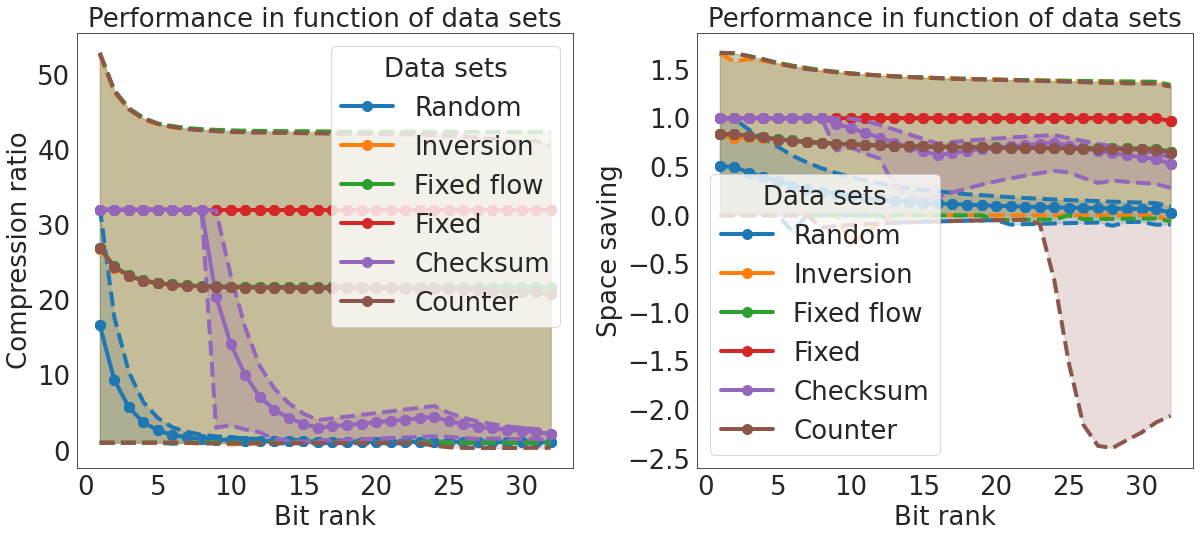

In [30]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 8))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=1.1)

# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['mode_dataset']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    ax1 = ax
    #ax2 = ax1.twiny()

    #err_bar = [df_plot['low_yerror'], 
    #           df_plot['low_yerror']]
    #err_bar = [[0]*df_plot.shape[0], 
    #           [0]*df_plot.shape[0]]

    
    # SET FIRST AXIS

    
    # Set rank 
    unique_values = df_plot[hue] \
                        .value_counts()\
                        .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        if (ERROR_BAR):
            lower = (df_plot[cond][col]-\
                df_plot[cond]['low_yerror_'+col]).abs()
            upper = (df_plot[cond]['high_yerror_'+col]-\
                df_plot[cond][col]).abs()
            err_bar = [lower, 
                       upper]

            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val.capitalize()}",
                     marker='o',
                     #linestyle="--",
                    )
            
            # Get color from mean plot
            last_line = ax1.get_lines()[-1]
            color_last_line = last_line.get_color()
            
            # Set error area with alpha
            ax1.fill_between(df_plot[cond]['bit_ranks'],
                             df_plot[cond][col]-lower, 
                             df_plot[cond][col]+upper,
                             alpha=0.2,
                             color=color_last_line)
            
            # Set min and max for error area
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]-lower,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            ax1.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]+upper,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            
        else:
            ax1.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val.capitalize()}",
                     marker='o',
                     #linestyle="--",
                    )

        # Set legend
        legend = ax1.legend(fontsize=LEGEND_FONTSIZE)
        legend.set_title('Data sets', 
                         prop={'size':LEGEND_FONTSIZE})
        

    for item in ax1.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax1.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    # Set label  
    ax1.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax1.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    ax.set_title(f"Performance in function of data sets", 
              fontsize=TITLE_FONTSIZE)

    # SET SECOND AXIS


    #ax2.set_xlim(ax1.get_xlim())

    # Set field name
    #ax2 = ax1.twiny()
    #ax2.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    #for item in ax2.get_xticklabels():
    #    item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(70)

    #ax2.grid(False)

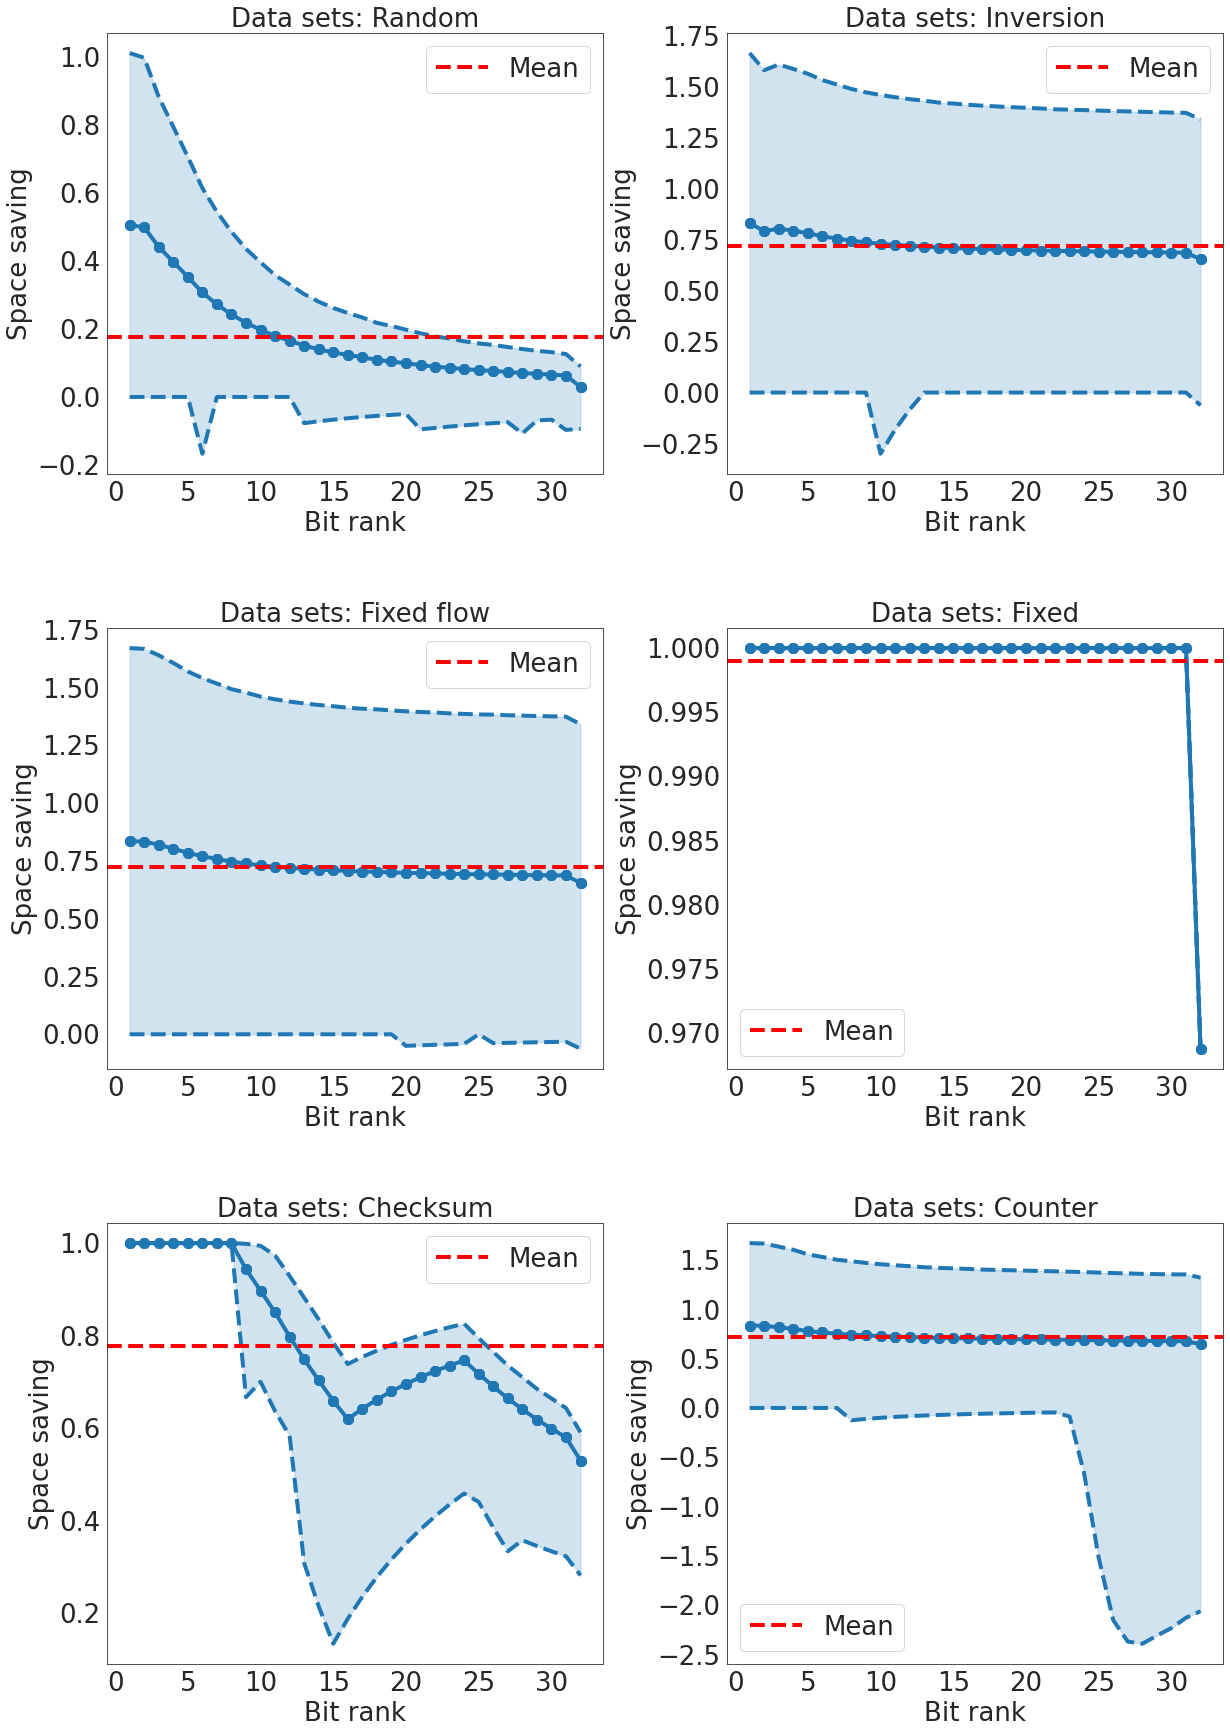

In [32]:
hue = "mode_dataset"
col = 'space_saving'
title = f"Space saving"

# Set rank 
unique_values = df_plot[hue] \
                    .value_counts()\
                    .index

fig, axes = plt.subplots(
    3, 2, 
    figsize=(20, 30))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

for ax, val in zip(
    axes.ravel(), unique_values):
    
    cond = (df_plot[hue] == val)

    if (ERROR_BAR):
        lower = (df_plot[cond][col]-\
            df_plot[cond]['low_yerror_'+col]).abs()
        upper = (df_plot[cond]['high_yerror_'+col]-\
            df_plot[cond][col]).abs()
        err_bar = [lower, 
                   upper]

        ax.plot(df_plot[cond]['bit_ranks'], 
                 df_plot[cond][col],
                 linewidth=LINEWIDTH,
                 markersize=MARKERSIZE, # Size of point
                 alpha=1,
                 #label=f"{val.capitalize()}",
                 marker='o',
                 #linestyle="--",
                )

        # Get color from mean plot
        last_line = ax.get_lines()[-1]
        color_last_line = last_line.get_color()

        # Set error area with alpha
        ax.fill_between(df_plot[cond]['bit_ranks'],
                         df_plot[cond][col]-lower, 
                         df_plot[cond][col]+upper,
                         alpha=0.2,
                         color=color_last_line)

        # Set min and max for error area
        ax.plot(df_plot[cond]['bit_ranks'],
                df_plot[cond][col]-lower,
                alpha=1,
                linestyle='--',
                linewidth=LINEWIDTH,
                color=color_last_line)
        ax.plot(df_plot[cond]['bit_ranks'],
                df_plot[cond][col]+upper,
                alpha=1,
                linestyle='--',
                linewidth=LINEWIDTH,
                color=color_last_line)

    else:
        ax.plot(df_plot[cond]['bit_ranks'], 
                 df_plot[cond][col],
                 linewidth=LINEWIDTH,
                 markersize=MARKERSIZE, # Size of point
                 alpha=1,
                 label=f"{val.capitalize()}",
                 marker='o',
                 #linestyle="--",
                )

    #legend.set_title('Data sets', 
    #                 prop={'size':LEGEND_FONTSIZE})

    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        
    # Set mean
    ax.axhline(y=df_plot[cond][col].mean(), 
               color="red", label="Mean",
               linestyle="--",
               linewidth=LINEWIDTH)
    
    # Set legend
    legend = ax.legend(fontsize=LEGEND_FONTSIZE)

    # Set label  
    ax.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)
    #ax.set_ylim([0, 1.1])

    # Set title
    ax.set_title(f"Data sets: {val.capitalize()}", 
                  fontsize=TITLE_FONTSIZE)
    
#axes.ravel()[-1].remove()

#### 4.8.2 Compression performance HISTOGRAM PER packet MODE_DATASET

In [28]:
ERROR_BAR = True
MODES_DATASET = ['random', 'checksum34', 'fixed_flow', 
                 "fixed", 'inversion', 'counter']

LOOK_BACK_CONTEXT = 1
LOOK_BACK_PACKET = 8
LEFT_PADDING = True

data_results = pd.DataFrame()

for mode_d in MODES_DATASET:

    if (CHECKSUM):
        if (CUSTOM_SIZE is not None):
            ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{mode_d}"
        else:
            ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{mode_d}"
    else:
        if (CUSTOM_SIZE is not None):
            ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{mode_d}"
        else:
            ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{mode_d}"
            
    if (LEFT_PADDING):
        ext_name = ext_name + "_LEFT_PADDING"

    full_name = f"LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}"
    data_results_tmp = pd.read_csv(f"./RESULTS/INTERPRETATION/df_{full_name}{ext_name}_COMPRESSION.csv")

    if (mode_d == "checksum34"):
        data_results_tmp["mode_dataset"] = \
            "checksum"
    else:
        data_results_tmp["mode_dataset"] = \
            mode_d.replace("_", " ")
        
    data_results_tmp['size_uncompress'] = \
            data_results_tmp['headers_length']

    # Correct value
    data_results_tmp['size_context'] = \
        data_results_tmp['packets_rank']
    cond = (data_results_tmp['packets_rank'] >= LOOK_BACK_CONTEXT)
    data_results_tmp.loc[cond, 'size_context'] = LOOK_BACK_CONTEXT

    # Compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / \
                 (data_results_tmp["size_uncompress"]))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

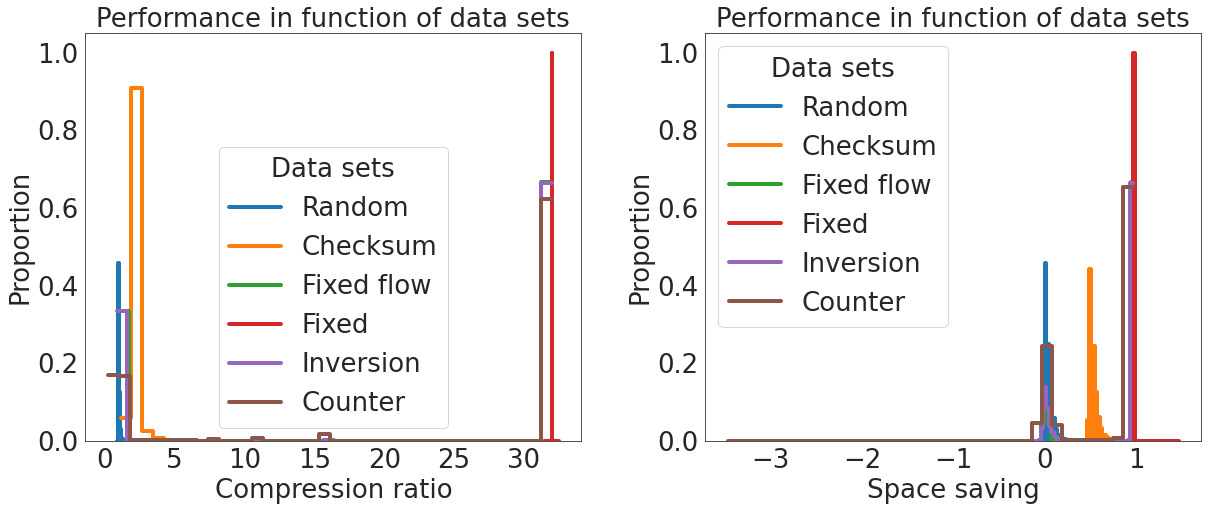

In [34]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)


# Parcourir les axes

df_plot = data_results.copy()

for ax, hue, col, title in zip(
    axes.ravel(), 
    ["mode_dataset"]*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]
    
    # SET FIRST AXIS

    
    # Set rank 
    unique_values = df_plot[hue] \
                        .value_counts()\
                        .index

    for val in unique_values:
        cond = (df_plot[hue] == val)
        
        sns.histplot(df_plot[cond][col], 
                     element="step",
                     stat='probability',
                     bins=40,
                     linewidth=LINEWIDTH,
                     fill=False,
                     label=f"{val.capitalize()}",
                     ax=ax)
        #ax.hist(df_plot[cond][col],
        #        density=False,
                #linewidth=LINEWIDTH,
        #        bins=70
        #       )

    # Set legend
    #legend = ax.legend([val for val in unique_values], 
    #                   fontsize=LEGEND_FONTSIZE)
    legend = ax.legend(fontsize=LEGEND_FONTSIZE)
    legend.set_title('Data sets', 
                     prop={'size':LEGEND_FONTSIZE})
    
        
    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)
        
    # Set normalized labels
    #ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        

    # Set label  
    ax.set_ylabel("Proportion", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"{title}", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    ax.set_title(f"Performance in function of data sets", 
                  fontsize=TITLE_FONTSIZE)

'for ax in axes.ravel():\n    \n    # Set legend\n    legend = ax.legend(\n        #["True", "False"],\n        fontsize=LEGEND_FONTSIZE, #,\n        loc="upper right")\n        #handler_map={plt.Line2D : HandlerLine2D(update_func=update)})\n    #legend.set_title(\'Keep error\', \n    #                 prop={\'size\':LEGEND_FONTSIZE})'

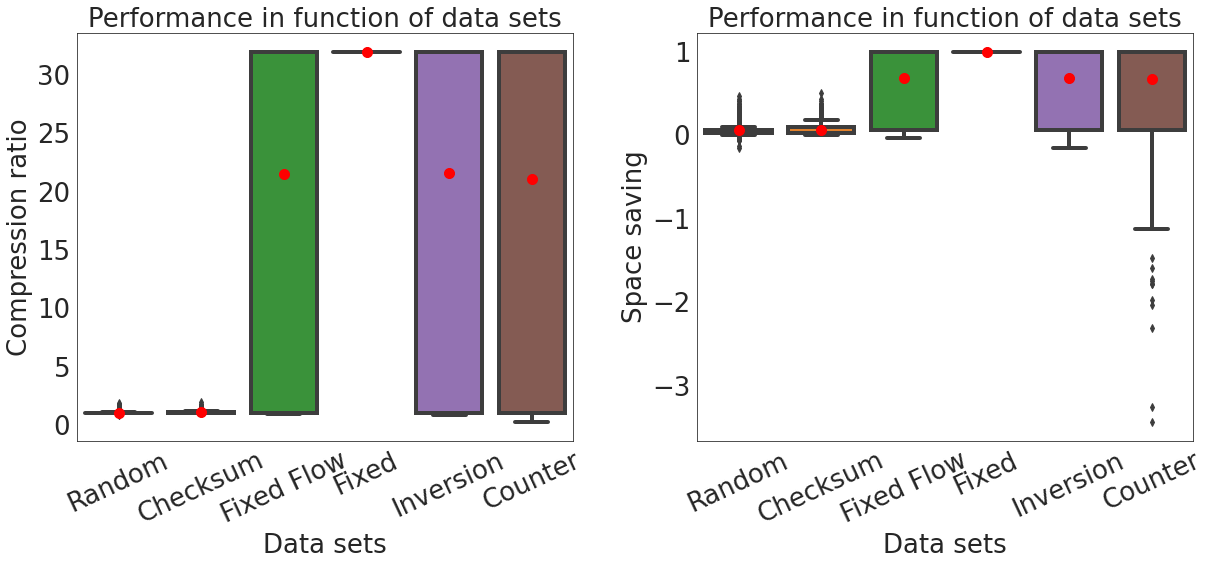

In [32]:
# Plot MEAN and STD
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
alpha=0.95

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)


modes_dataset = []
for mode_d in MODES_DATASET:
    if (mode_d == "checksum34"):
        modes_dataset.append("checksum")
    else:
        modes_dataset.append(
            mode_d.replace("_", " "))

#modes_dataset = [mode_d.replace("_", " ") 
#                 for mode_d in MODES_DATASET]

# Parcourir les axes

for ax, col, title in zip(
    axes.ravel(),
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): #[f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    # Plot error 
    '''sns.boxplot(x='decimals', 
                y=col, data=data_results, 
                hue='keep_error',
                showmeans=True,
                meanprops={"marker": "o",
                           "markerfacecolor":"red",
                           "markeredgecolor": "red",
                           "markersize": "10"},
                linewidth=LINEWIDTH,
                ax=ax)'''
    
    means = data_results\
        .groupby('mode_dataset')[col]\
        .mean()\
        .loc[modes_dataset]
    #modes = data_results.groupby('cut_values')[col]\
    #                    .agg(lambda x: pd.Series.mode(x)[0])
    
    #{“box”, “quartile”, “point”, “stick”, None}
    '''sns.violinplot(x="mode_dataset", 
                   y=col, data=data_results, 
                   #hue='keep_error',
                   showmeans=True,
                   meanprops={"marker": "o",
                               "markerfacecolor":"red",
                               "markeredgecolor": "red",
                               "markersize": "10"},
                   linewidth=LINEWIDTH,
                   ax=ax)'''
    
    sns.boxplot(x="mode_dataset", 
               y=col, data=data_results, 
               #hue='keep_error',
               showmeans=True,
               meanprops={"marker": "o",
                           "markerfacecolor":"red",
                           "markeredgecolor": "red",
                           "markersize": "10"},
               linewidth=LINEWIDTH,
               ax=ax)
    
    ax.scatter(x=range(len(means)), 
               y=means, c="red",
               s=75,
               zorder=100)
        
    ax.set_ylabel(f"{title}",
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Data sets",
                  fontsize=LABEL_FONTSIZE)
    
    
    #ax.tick_params(labelsize=TICK_FONTSIZE)
    
    # SET SECOND AXIS


    def tick_function(ranks_bit):
        values = []
        for val in ranks_bit:
            values.append(
                DICT_FIELDS[val])
        return values

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    
    # Update tick label in upper case
    labels = [item.get_text().title() for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)

    # Set field name
    #ax2 = ax1.twiny()
    ax.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(25)

    # Set title
    ax.set_title(f"Performance in function of data sets", 
                  fontsize=TITLE_FONTSIZE)

def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(LINEWIDTH)
    
'''for ax in axes.ravel():
    
    # Set legend
    legend = ax.legend(
        #["True", "False"],
        fontsize=LEGEND_FONTSIZE, #,
        loc="upper right")
        #handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
    #legend.set_title('Keep error', 
    #                 prop={'size':LEGEND_FONTSIZE})'''

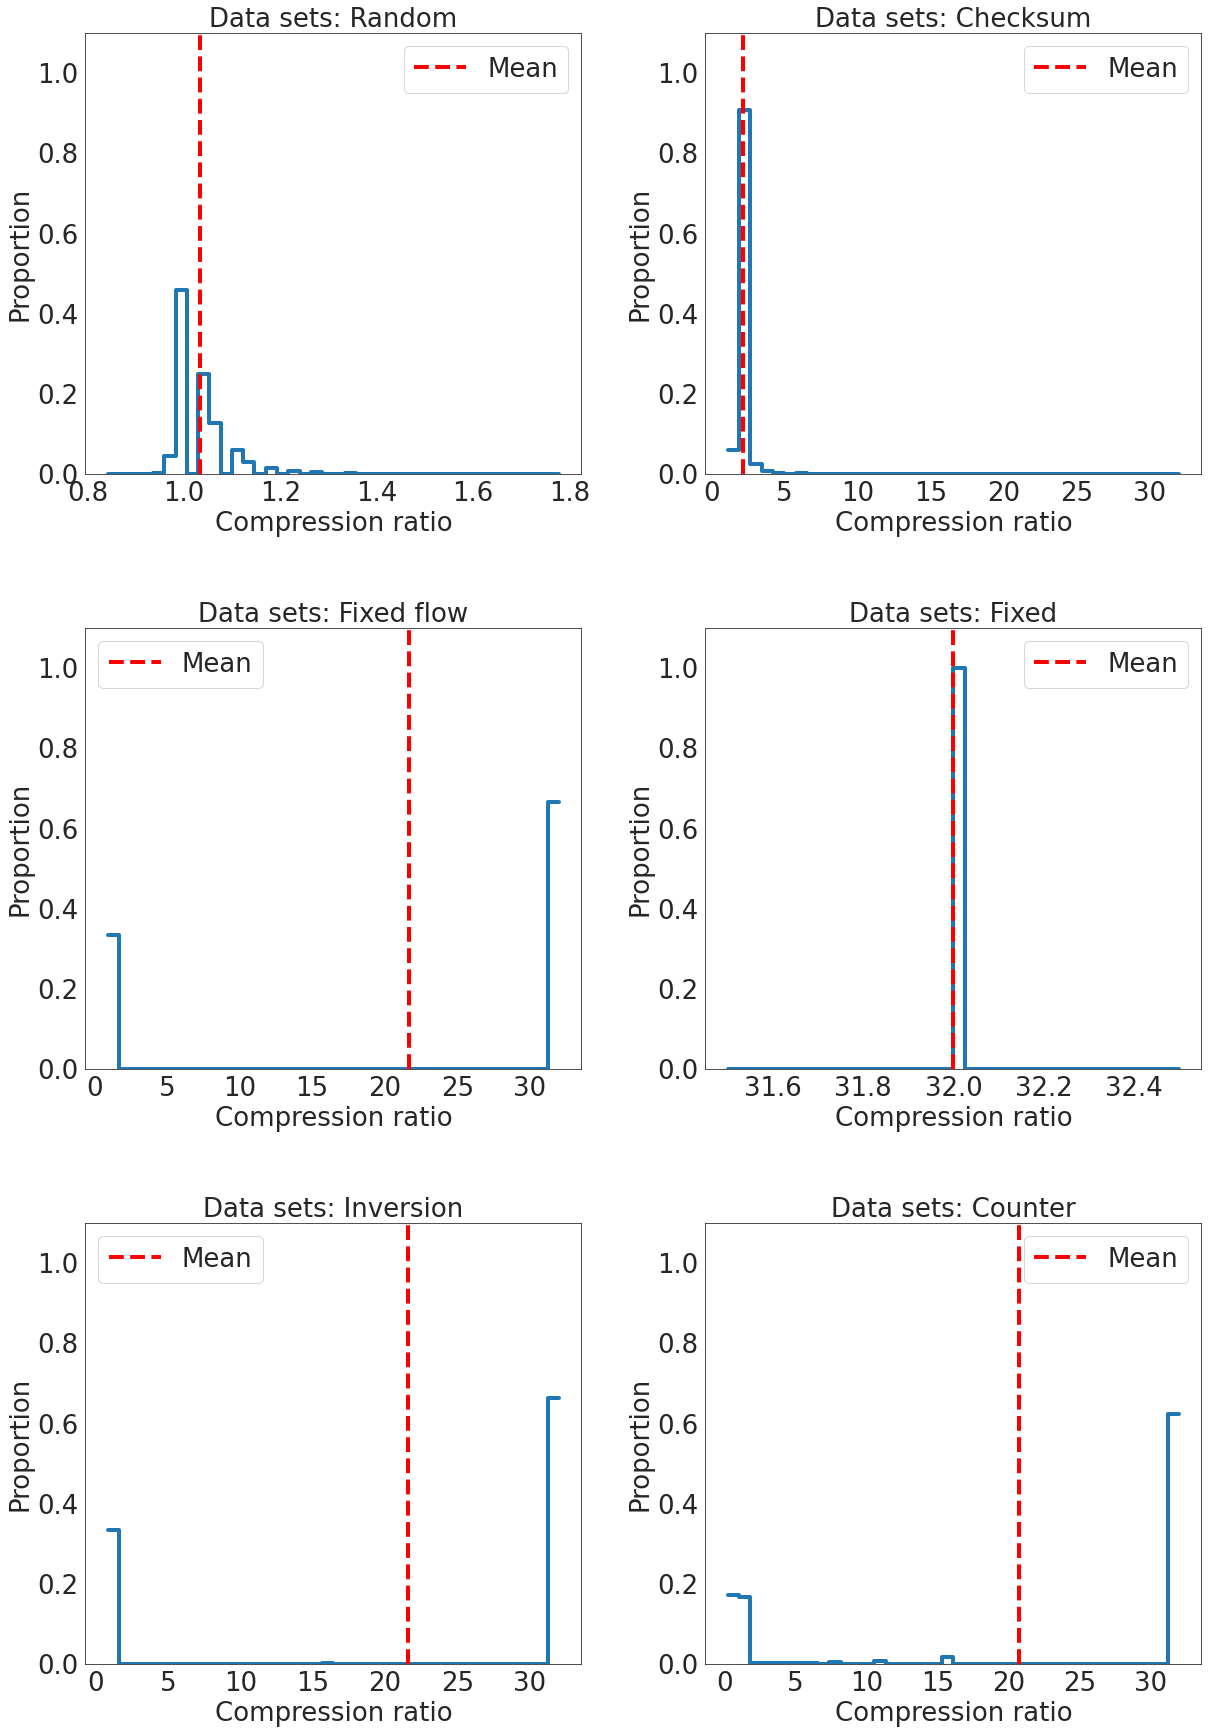

In [38]:
# Parcourir les axes

df_plot = data_results.copy()

#for hue, col, title in zip(
#    ["mode_dataset"]*2,
#    ['compression_ratio', 'space_saving'],
#    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]
    
# SET FIRST AXIS

hue = "mode_dataset"
col = 'compression_ratio'
title = f"Compression ratio"


# Set rank 
unique_values = df_plot[hue] \
                    .value_counts()\
                    .index

fig, axes = plt.subplots(
    3, 2, 
    figsize=(20, 30))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

for ax, val in zip(axes.ravel(), unique_values):
    cond = (df_plot[hue] == val)

    sns.histplot(df_plot[cond][col], 
                 element="step",
                 stat='probability',
                 bins=40,
                 linewidth=LINEWIDTH,
                 fill=False,
                 ax=ax)
    
    # Set mean
    ax.axvline(x=df_plot[cond][col].mean(), 
               color="red", label="Mean",
               linestyle="--",
               linewidth=LINEWIDTH)

    # Set legend
    legend = ax.legend(fontsize=LEGEND_FONTSIZE)
    #legend.set_title('Data sets', 
    #                 prop={'size':LEGEND_FONTSIZE})


    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)

    # Set normalized labels
    #ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    # Set label  
    ax.set_ylabel("Proportion", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"{title}", 
                   fontsize=LABEL_FONTSIZE)
    
    # Set title
    ax.set_ylim([0, 1.1])

    # Set title
    ax.set_title(f"Data sets: {val.capitalize()}", 
                  fontsize=TITLE_FONTSIZE)
    
#axes.ravel()[-1].remove()

#### 4.8.2 Performance compression MODE_DATASET by varying context size

In [167]:
ERROR_BAR = True
LOOK_BACK_CONTEXTS = [0, 1, 2]
MODE_DATASET = 'combinaison' #['random', 'checksum', 'checksum34', 'fixed_flow', 
               #  "fixed", 'inversion', 'counter', 'combinaison']

LOOK_BACK_PACKET = 16
LEFT_PADDING = True
USE_BASELINE = True


# Set EXT_NAME
if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"
else:
    if (CUSTOM_SIZE is not None):
        ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"

if (LEFT_PADDING):
    ext_name = ext_name + "_LEFT_PADDING"

# Data results
data_results = pd.DataFrame()

for look_back_context in LOOK_BACK_CONTEXTS:

    full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}"
    data_results_tmp = pd.read_csv(f"./RESULTS/INTERPRETATION/df_{full_name}{ext_name}_COMPRESSION.csv")

    data_results_tmp["look_back_context"] = int(look_back_context)
    data_results_tmp["mode_dataset"] = MODE_DATASET
    data_results_tmp['size_uncompress'] = \
            data_results_tmp['headers_length']

    # Correct value
    data_results_tmp['size_context'] = \
        data_results_tmp['packets_rank']
    cond = (data_results_tmp['packets_rank'] >= look_back_context)
    data_results_tmp.loc[cond, 'size_context'] = look_back_context

    # Compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / \
                 (data_results_tmp["size_uncompress"]))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
    
# Reset EXT_NAME
if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"
else:
    if (CUSTOM_SIZE is not None):
        ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"    

    
# Add baseline in comparaison
if (USE_BASELINE):
    
    # Add baseline
    LOOK_BACK_CONTEXTS.append("Baseline")
    
    LOOK_BACK_PACKET = 8
    full_name = f"LOSSLESS_PACKET{LOOK_BACK_PACKET}_BASELINE_NAIVE"
    
    if (LEFT_PADDING):
        data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}{ext_name}_DECIMALSNone_LEFT_PADDING_COMPRESSION.csv")
    else:
        data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}{ext_name}_DECIMALSNone_COMPRESSION.csv")
    
    data_results_tmp["look_back_context"] = "Baseline"
    data_results_tmp["mode_dataset"] = MODE_DATASET
    data_results_tmp['size_uncompress'] = \
            data_results_tmp['headers_length']

    # Correct value
    data_results_tmp['size_context'] = \
        data_results_tmp['packets_rank']
    cond = (data_results_tmp['packets_rank'] >= look_back_context)
    data_results_tmp.loc[cond, 'size_context'] = look_back_context

    # Compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / \
                 (data_results_tmp["size_uncompress"]))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
    
# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

In [168]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
sizes_context = []
look_back_contexts = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []

for i in range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    for j in LOOK_BACK_CONTEXTS:
        
        cond_look_back_context = (data_results[
            'look_back_context'] == j)
        data_results_tmp = data_results[
            cond_look_back_context]
        
        # IF l'array is empty
        if (data_results_tmp.shape[0] != 0):

            # Init first steps

            '''bit_ranks.append(0)
            compression_ratio.append(0)
            space_saving.append(0)
            sizes_context.append(i)
            look_back_contexts.append(j)

            low_yerror_compression_ratio.append(0)
            high_yerror_compression_ratio.append(0)

            low_yerror_space_saving.append(0)
            high_yerror_space_saving.append(0)'''

            # Compute each compress level

            for col in data_results.columns:
                if ("level_compress" in col):

                    # Add context size info
                    sizes_context.append(i)
                    look_back_contexts.append(j)

                    # Extract bit rank
                    bit_rank = int(col.split("_")[-1])+1
                    bit_ranks.append(
                        bit_rank)

                    # Compute mean compresssion ratio
                    # Compression ratio = uncompressed / compressed
                    # for rank k
                    df_tmp_compression_ratio = bit_rank / \
                        data_results_tmp[col]
                    df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                    bit_rank)

                    ## Remove -1
                    cond = (data_results_tmp[col] != -1)
                    df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                    df_tmp_space_saving = df_tmp_space_saving[cond]
                    
                    #print("[DEBUG] np.isinf(df_tmp_compression_ratio).any(): ",
                    #         np.isinf(df_tmp_compression_ratio).any())
                    #if (np.isinf(df_tmp_compression_ratio).any()):
                    #    print("[DEBUG][if] data_results_tmp[col].value_counts(): ", 
                    #          data_results_tmp[col].value_counts())
                    
                    # Replace inf values
                    if (np.isinf(df_tmp_compression_ratio).any()):
                    
                        ## Index with inf values
                        cond = (df_tmp_compression_ratio \
                                    .isin([np.inf, -np.inf]))
                        indexes_inf = df_tmp_compression_ratio[cond].index

                        ## Get right values
                        values_new = data_results_tmp[
                            "headers_length"].iloc[indexes_inf]

                        ## Set the right values
                        df_tmp_compression_ratio \
                            .iloc[indexes_inf] = values_new.values

                    compression_ratio.append(
                        df_tmp_compression_ratio.mean())
                    space_saving.append(
                        df_tmp_space_saving.mean())

                    if (df_tmp_compression_ratio.shape[0] != 0):

                        # Compute std compression ratio
                        p = ((1.0-alpha)/2.0)
                        lower_compression_ratio = np.percentile(
                                df_tmp_compression_ratio.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_compression_ratio = np.percentile(
                                 df_tmp_compression_ratio.values, p)

                        # Compute std space saving
                        p = ((1.0-alpha)/2.0)
                        lower_space_saving = np.percentile(
                                df_tmp_space_saving.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_space_saving = np.percentile(
                                 df_tmp_space_saving.values, p)

                    else:
                        # Compression ratio
                        lower_compression_ratio = 0
                        upper_compression_ratio = 0

                        # Space saving
                        lower_space_saving = 0
                        upper_space_saving = 0

                    low_yerror_compression_ratio\
                        .append(lower_compression_ratio)
                    high_yerror_compression_ratio\
                        .append(upper_compression_ratio)

                    low_yerror_space_saving\
                        .append(lower_space_saving)
                    high_yerror_space_saving\
                        .append(upper_space_saving)


# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['size_context'] = sizes_context
df_plot['look_back_context'] = look_back_contexts

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

# Extract difference

'''df_plot_diff = df_plot[
    ['compression_ratio', 
     'space_saving']] \
        .diff(1).fillna(0) \
        .rename(columns={'compression_ratio':'compression_ratio_diff',
                         'space_saving':'space_saving_diff'})
df_plot = pd.concat(
    [df_plot, df_plot_diff], axis=1)'''

"df_plot_diff = df_plot[\n    ['compression_ratio', \n     'space_saving']]         .diff(1).fillna(0)         .rename(columns={'compression_ratio':'compression_ratio_diff',\n                         'space_saving':'space_saving_diff'})\ndf_plot = pd.concat(\n    [df_plot, df_plot_diff], axis=1)"

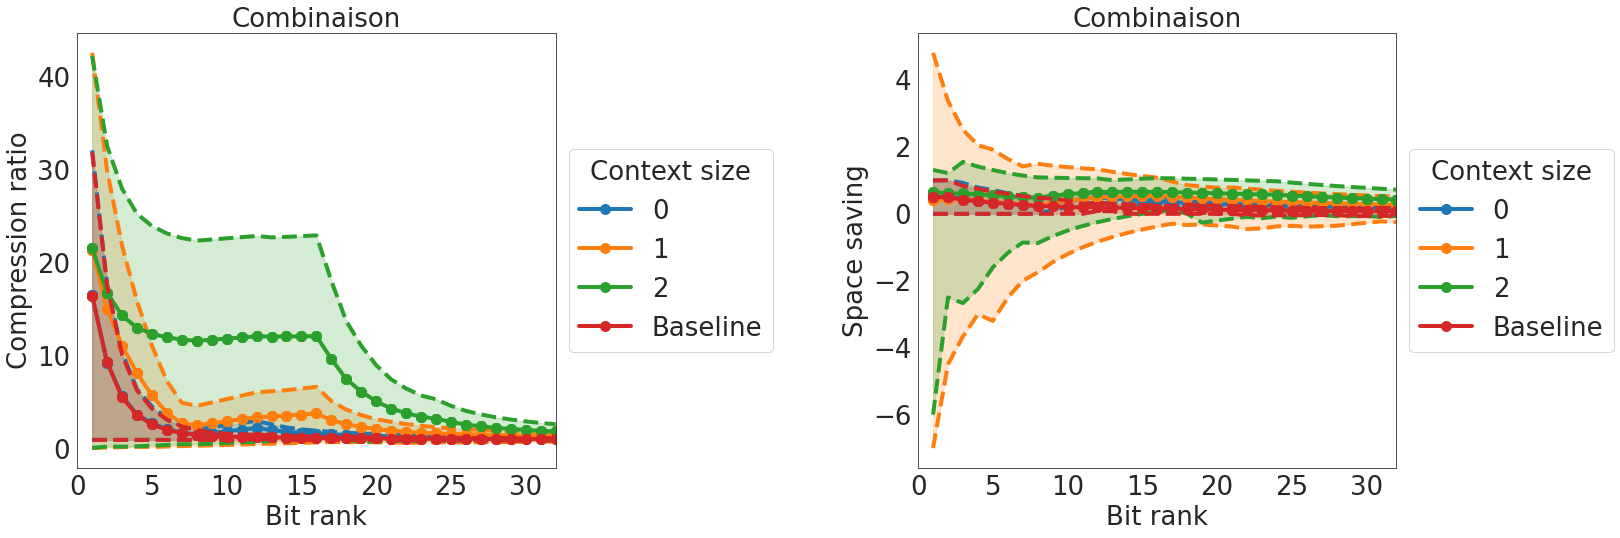

In [169]:
fig, axes = plt.subplots(
    1, 2, figsize=(20*1.8, 8))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
#fig.subplots_adjust(wspace=0.25, 
#                    hspace=1.1)
fig.subplots_adjust(wspace=-0.28, 
                    hspace=1.1)

# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['look_back_context']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    ax1 = ax
    #ax2 = ax1.twiny()

    #err_bar = [[0]*df_plot.shape[0], 
    #           [0]*df_plot.shape[0]]

    
    # SET FIRST AXIS

    
    # Check if we use baseline
    if (USE_BASELINE):
        
        # Define condition
        cond = (df_plot[hue] != "Baseline")
        
        # Set rank 
        unique_values = df_plot[cond][hue] \
                            .astype(int) \
                            .value_counts()\
                            .sort_index()\
                            .index
        
        unique_values = \
            list(unique_values) + \
                ["Baseline"]
    else:
        
        # Set rank 
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .sort_index()\
                            .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        if (ERROR_BAR):
            
            lower = (df_plot[cond][col]-\
                df_plot[cond]['low_yerror_'+col]).abs()
            upper = (df_plot[cond]['high_yerror_'+col]-\
                df_plot[cond][col]).abs()
            err_bar = [lower, 
                       upper]
            #err_bar = [(df_plot[cond][col]-df_plot[cond]['low_yerror']).abs(), 
            #           (df_plot[cond]['high_yerror']-df_plot[cond][col]).abs()]
            #err_bar = [[0]*df_plot[cond].shape[0], 
            #           [0]*df_plot[cond].shape[0]]

            ax.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
            
            # Get color from mean plot
            last_line = ax1.get_lines()[-1]
            color_last_line = last_line.get_color()
            
            # Set error area with alpha
            ax.fill_between(df_plot[cond]['bit_ranks'],
                            df_plot[cond][col]-lower, 
                            df_plot[cond][col]+upper,
                            alpha=0.2,
                            color=color_last_line)
            
            # Set min and max for error area
            ax.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]-lower,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            ax.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]+upper,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
        else:
            ax.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
            
        # Parameter for outside legend
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Set legend
        #legend = ax1.legend(unique_values,
        #           fontsize=LEGEND_FONTSIZE)
        #for item in legend.legendHandles:
        #    item.set_visible(False)
        legend = ax.legend(fontsize=LEGEND_FONTSIZE,
                           # Parameter for outside legend
                           loc='center left',
                           bbox_to_anchor=(1, 0.5),
                           frameon=True)
        legend.set_title('Context size', 
                         prop={'size':LEGEND_FONTSIZE})
        

    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)
    ax.set_xlim([0, 32])

    # Set title
    if (MODE_DATASET == "checksum34"):
        title = "Checksum"
    else:
        title = MODE_DATASET.replace("_", " ").capitalize()
        
    ax.set_title(f"{title}", 
                fontsize=TITLE_FONTSIZE)

#### 4.8.3 Performance compression HISTOGRAM MODE_DATASET by varying context size

In [153]:
ERROR_BAR = True
LOOK_BACK_CONTEXTS = [0, 1, 2]
MODE_DATASET = 'checksum34' #['random', 'checksum', 'checksum34', 'fixed_flow', 
                        #  "fixed", 'inversion', 'counter', 'combinaison']

LOOK_BACK_PACKET = 16
LEFT_PADDING = True
USE_BASELINE = True

data_results = pd.DataFrame()


# Reset EXT_NAME
if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"
else:
    if (CUSTOM_SIZE is not None):
        ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"    

    
# Add baseline in comparaison
if (USE_BASELINE):
    
    # Add baseline
    LOOK_BACK_CONTEXTS.insert(0, "Baseline")
    
    LOOK_BACK_PACKET = 8
    full_name = f"LOSSLESS_PACKET{LOOK_BACK_PACKET}_BASELINE_NAIVE"
    
    if (LEFT_PADDING):
        data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}{ext_name}_DECIMALSNone_LEFT_PADDING_COMPRESSION.csv")
    else:
        data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}{ext_name}_DECIMALSNone_COMPRESSION.csv")
    
    data_results_tmp["look_back_context"] = "Baseline"
    data_results_tmp["mode_dataset"] = MODE_DATASET
    data_results_tmp['size_uncompress'] = \
            data_results_tmp['headers_length']

    # Correct value
    data_results_tmp['size_context'] = \
        data_results_tmp['packets_rank']
    #cond = (data_results_tmp['packets_rank'] >= int(look_back_context))
    #data_results_tmp.loc[cond, 'size_context'] = int(look_back_context)

    # Compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / \
                 (data_results_tmp["size_uncompress"]))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
    

LOOK_BACK_PACKET = 16
for look_back_context in LOOK_BACK_CONTEXTS[1:]:

    if (CHECKSUM):
        if (CUSTOM_SIZE is not None):
            ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
        else:
            ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        if (CUSTOM_SIZE is not None):
            ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
        else:
            ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"

    if (LEFT_PADDING):
        ext_name = ext_name + "_LEFT_PADDING"

    full_name = f"LOSSLESS_CONTEXT{look_back_context}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}"
    data_results_tmp = pd.read_csv(f"./RESULTS/INTERPRETATION/df_{full_name}{ext_name}_COMPRESSION.csv")

    data_results_tmp["look_back_context"] = int(look_back_context)
    data_results_tmp["mode_dataset"] = MODE_DATASET
    data_results_tmp['size_uncompress'] = \
            data_results_tmp['headers_length']

    # Correct value
    data_results_tmp['size_context'] = \
        data_results_tmp['packets_rank']
    cond = (data_results_tmp['packets_rank'] >= int(look_back_context))
    data_results_tmp.loc[cond, 'size_context'] = int(look_back_context)

    # Compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / \
                 (data_results_tmp["size_uncompress"]))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    

# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

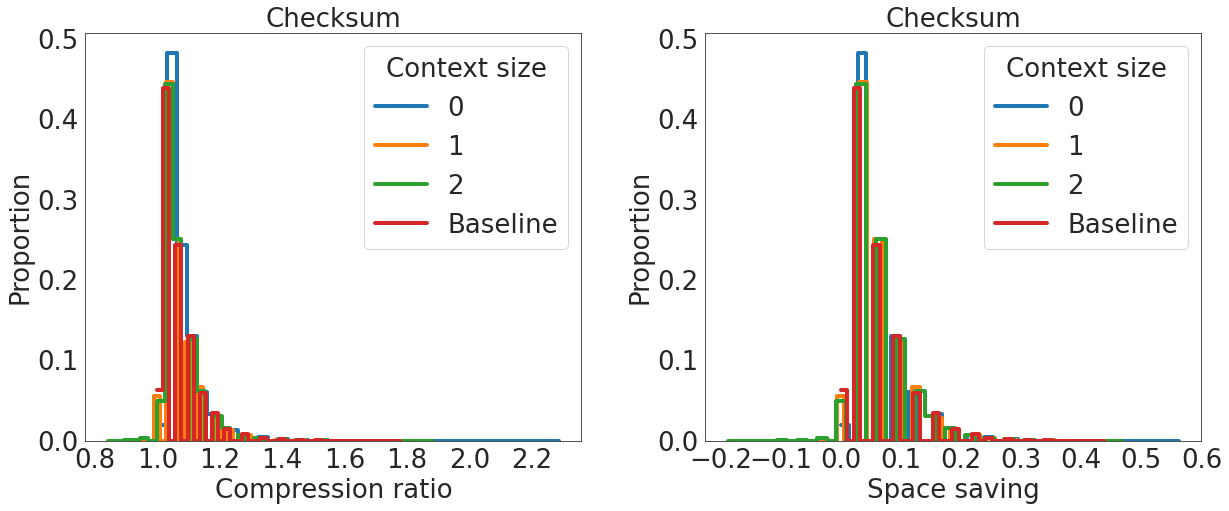

In [154]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)


# Parcourir les axes

df_plot = data_results.copy()

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['look_back_context']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"Compression ratio (U/C)", f"Space saving [1-(C/U)]"]
    
    # SET FIRST AXIS
    
    # Check if we use baseline
    if (USE_BASELINE):
        
        # Define condition
        cond = (df_plot[hue] != "Baseline")
        
        # Set rank 
        unique_values = df_plot[cond][hue] \
                            .astype(int) \
                            .value_counts()\
                            .sort_index()\
                            .index
        
        unique_values = \
            list(unique_values) + \
                ["Baseline"]
    else:
        
        # Set rank 
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .sort_index()\
                            .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        sns.histplot(df_plot[cond][col], 
                     element="step",
                     stat='probability',
                     bins=40,
                     linewidth=LINEWIDTH,
                     fill=False,
                     ax=ax)
        
        #ax.hist(df_plot[cond][col],
        #        density=False,
                #linewidth=LINEWIDTH,
        #        bins=70
        #       )

        # Set legend
        legend = ax.legend(unique_values, 
                  fontsize=LEGEND_FONTSIZE)
        legend.set_title('Context size', 
                         prop={'size':LEGEND_FONTSIZE})
        
        
    # Normalize axis
    '''yticklabels = ax.get_yticks() 
    yticklabels_update = np.round(
        yticklabels/df_plot[cond][col].shape[0], 3)'''
        
    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)
        
    # Set normalized labels
    #ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        

    # Set label  
    ax.set_ylabel("Proportion", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"{title}", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if (MODE_DATASET == "checksum34"):
        title = "Checksum"
    else:
        title = MODE_DATASET.replace("_", " ").capitalize()
    ax.set_title(f"{title}", 
                fontsize=TITLE_FONTSIZE)

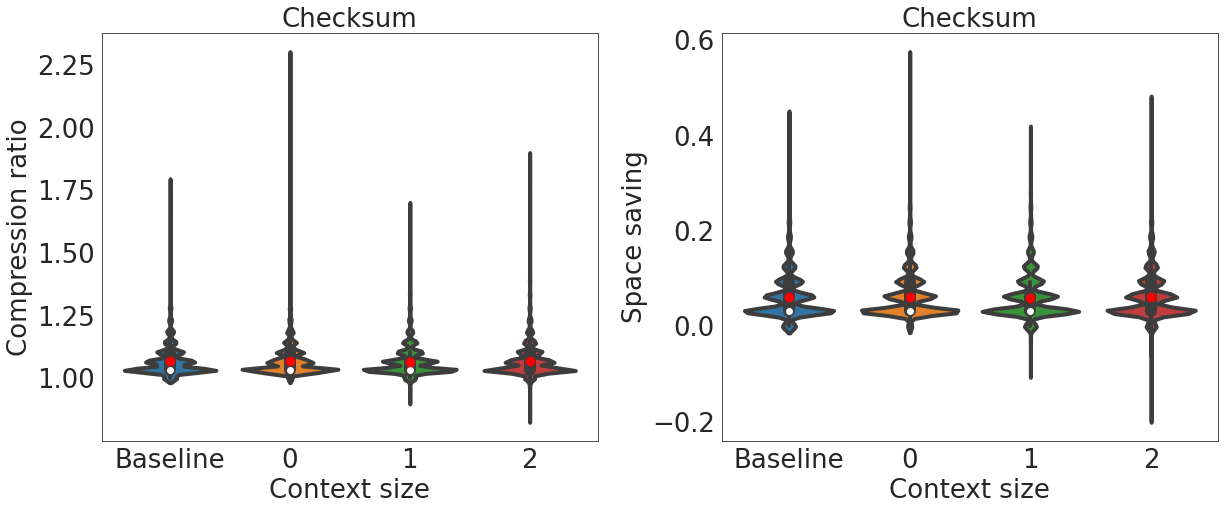

In [155]:
# Plot MEAN and STD
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
alpha=0.95

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)


#modes_dataset = [mode_d.replace("_", " ") 
#                 for mode_d in MODES_DATASET]

# Parcourir les axes

for ax, col, title in zip(
    axes.ravel(),
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): #[f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    # Plot error 
    '''sns.boxplot(x='decimals', 
                y=col, data=data_results, 
                hue='keep_error',
                showmeans=True,
                meanprops={"marker": "o",
                           "markerfacecolor":"red",
                           "markeredgecolor": "red",
                           "markersize": "10"},
                linewidth=LINEWIDTH,
                ax=ax)'''
    
    means = data_results\
        .groupby('look_back_context')[col]\
        .mean()\
        .loc[LOOK_BACK_CONTEXTS]
    #modes = data_results.groupby('cut_values')[col]\
    #                    .agg(lambda x: pd.Series.mode(x)[0])
    
    #{“box”, “quartile”, “point”, “stick”, None}
    sns.violinplot(x="look_back_context", 
                   y=col, data=data_results, 
                   #hue='keep_error',
                   showmeans=True,
                   meanprops={"marker": "o",
                               "markerfacecolor":"red",
                               "markeredgecolor": "red",
                               "markersize": "10"},
                   linewidth=LINEWIDTH,
                   ax=ax)
    
    '''sns.boxplot(x="look_back_context", 
                   y=col, data=data_results, 
                   #hue='keep_error',
                   showmeans=True,
                   meanprops={"marker": "o",
                               "markerfacecolor":"red",
                               "markeredgecolor": "red",
                               "markersize": "10"},
                   linewidth=LINEWIDTH,
                   ax=ax)'''
    
    ax.scatter(x=range(len(means)), 
               y=means, c="red",
               s=75,
               zorder=100)
        
    ax.set_ylabel(f"{title}",
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Context size",
                  fontsize=LABEL_FONTSIZE)
    
    
    #ax.tick_params(labelsize=TICK_FONTSIZE)
    
    # SET SECOND AXIS

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    
    # Update tick label in upper case
    labels = [item.get_text().title() for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)

    # Set field name
    #ax2 = ax1.twiny()
    ax.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(25)

    # Set title
    if (MODE_DATASET == "checksum34"):
        title = "Checksum"
    else:
        title = MODE_DATASET.replace("_", " ").capitalize()
        
    ax.set_title(f"{title}", 
                fontsize=TITLE_FONTSIZE)

#### 4.8.4 Performance compression MODE_DATASET by varying widnows size

In [195]:
ERROR_BAR = True
LOOK_BACK_PACKETS = [2, 4, 8, 16]
MODE_DATASET = 'combinaison' #['random', 'checksum', 'checksum34', 'fixed_flow', 
               #  "fixed", 'inversion', 'counter', 'combinaison']

LOOK_BACK_CONTEXT = 2
LEFT_PADDING = True
USE_BASELINE = True

data_results = pd.DataFrame()

for look_back_packet in LOOK_BACK_PACKETS:

    if (CHECKSUM):
        if (CUSTOM_SIZE is not None):
            ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
        else:
            ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        if (CUSTOM_SIZE is not None):
            ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
        else:
            ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"

    if (LEFT_PADDING):
        ext_name = ext_name + "_LEFT_PADDING"

    full_name = f"LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{look_back_packet}_SIN{NUM_SIN}"
    data_results_tmp = pd.read_csv(f"./RESULTS/INTERPRETATION/df_{full_name}{ext_name}_COMPRESSION.csv")

    data_results_tmp["look_back_packet"] = int(look_back_packet)
    data_results_tmp["mode_dataset"] = MODE_DATASET
    data_results_tmp['size_uncompress'] = \
            data_results_tmp['headers_length']

    # Correct value
    data_results_tmp['size_context'] = \
        data_results_tmp['packets_rank']
    cond = (data_results_tmp['packets_rank'] >= LOOK_BACK_CONTEXT)
    data_results_tmp.loc[cond, 'size_context'] = LOOK_BACK_CONTEXT

    # Compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / \
                 (data_results_tmp["size_uncompress"]))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
    
# Reset EXT_NAME
if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"
else:
    if (CUSTOM_SIZE is not None):
        ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"    

    
# Add baseline in comparaison
if (USE_BASELINE):
    
    # Add baseline
    LOOK_BACK_PACKETS.append("Baseline")
    
    LOOK_BACK_PACKET = 8
    full_name = f"LOSSLESS_PACKET{LOOK_BACK_PACKET}_BASELINE_NAIVE"
    
    if (LEFT_PADDING):
        data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}{ext_name}_DECIMALSNone_LEFT_PADDING_COMPRESSION.csv")
    else:
        data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}{ext_name}_DECIMALSNone_COMPRESSION.csv")
    
    data_results_tmp["look_back_packet"] = "Baseline"
    data_results_tmp["mode_dataset"] = MODE_DATASET
    data_results_tmp['size_uncompress'] = \
            data_results_tmp['headers_length']

    # Correct value
    data_results_tmp['size_context'] = \
        data_results_tmp['packets_rank']
    cond = (data_results_tmp['packets_rank'] >= look_back_context)
    data_results_tmp.loc[cond, 'size_context'] = look_back_context

    # Compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / \
                 (data_results_tmp["size_uncompress"]))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
    
# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

In [196]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
sizes_context = []
look_back_packets = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []

for i in range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    for j in LOOK_BACK_PACKETS:
        
        cond_look_back_packet = (data_results[
            'look_back_packet'] == j)
        data_results_tmp = data_results[
            cond_look_back_packet]
        
        # IF l'array is empty
        if (data_results_tmp.shape[0] != 0):

            # Init first steps

            '''bit_ranks.append(0)
            compression_ratio.append(0)
            space_saving.append(0)
            sizes_context.append(i)
            look_back_contexts.append(j)

            low_yerror_compression_ratio.append(0)
            high_yerror_compression_ratio.append(0)

            low_yerror_space_saving.append(0)
            high_yerror_space_saving.append(0)'''

            # Compute each compress level

            for col in data_results.columns:
                if ("level_compress" in col):

                    # Add context size info
                    sizes_context.append(i)
                    look_back_packets.append(j)

                    # Extract bit rank
                    bit_rank = int(col.split("_")[-1])+1
                    bit_ranks.append(
                        bit_rank)

                    # Compute mean compresssion ratio
                    # Compression ratio = uncompressed / compressed
                    # for rank k
                    df_tmp_compression_ratio = bit_rank / \
                        data_results_tmp[col]
                    df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                    bit_rank)

                    ## Remove -1
                    cond = (data_results_tmp[col] != -1)
                    df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                    df_tmp_space_saving = df_tmp_space_saving[cond]
                    
                    #print("[DEBUG] np.isinf(df_tmp_compression_ratio).any(): ",
                    #         np.isinf(df_tmp_compression_ratio).any())
                    #if (np.isinf(df_tmp_compression_ratio).any()):
                    #    print("[DEBUG][if] data_results_tmp[col].value_counts(): ", 
                    #          data_results_tmp[col].value_counts())
                    
                    # Replace inf values
                    if (np.isinf(df_tmp_compression_ratio).any()):
                    
                        ## Index with inf values
                        cond = (df_tmp_compression_ratio \
                                    .isin([np.inf, -np.inf]))
                        indexes_inf = df_tmp_compression_ratio[cond].index

                        ## Get right values
                        values_new = data_results_tmp[
                            "headers_length"].iloc[indexes_inf]

                        ## Set the right values
                        df_tmp_compression_ratio \
                            .iloc[indexes_inf] = values_new.values

                    compression_ratio.append(
                        df_tmp_compression_ratio.mean())
                    space_saving.append(
                        df_tmp_space_saving.mean())

                    if (df_tmp_compression_ratio.shape[0] != 0):

                        # Compute std compression ratio
                        p = ((1.0-alpha)/2.0)
                        lower_compression_ratio = np.percentile(
                                df_tmp_compression_ratio.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_compression_ratio = np.percentile(
                                 df_tmp_compression_ratio.values, p)

                        # Compute std space saving
                        p = ((1.0-alpha)/2.0)
                        lower_space_saving = np.percentile(
                                df_tmp_space_saving.values, p)
                        p = (alpha+((1.0-alpha)/2.0))
                        upper_space_saving = np.percentile(
                                 df_tmp_space_saving.values, p)

                    else:
                        # Compression ratio
                        lower_compression_ratio = 0
                        upper_compression_ratio = 0

                        # Space saving
                        lower_space_saving = 0
                        upper_space_saving = 0

                    low_yerror_compression_ratio\
                        .append(lower_compression_ratio)
                    high_yerror_compression_ratio\
                        .append(upper_compression_ratio)

                    low_yerror_space_saving\
                        .append(lower_space_saving)
                    high_yerror_space_saving\
                        .append(upper_space_saving)


# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['size_context'] = sizes_context
df_plot['look_back_packet'] = look_back_packets

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

# Extract difference

'''df_plot_diff = df_plot[
    ['compression_ratio', 
     'space_saving']] \
        .diff(1).fillna(0) \
        .rename(columns={'compression_ratio':'compression_ratio_diff',
                         'space_saving':'space_saving_diff'})
df_plot = pd.concat(
    [df_plot, df_plot_diff], axis=1)'''

"df_plot_diff = df_plot[\n    ['compression_ratio', \n     'space_saving']]         .diff(1).fillna(0)         .rename(columns={'compression_ratio':'compression_ratio_diff',\n                         'space_saving':'space_saving_diff'})\ndf_plot = pd.concat(\n    [df_plot, df_plot_diff], axis=1)"

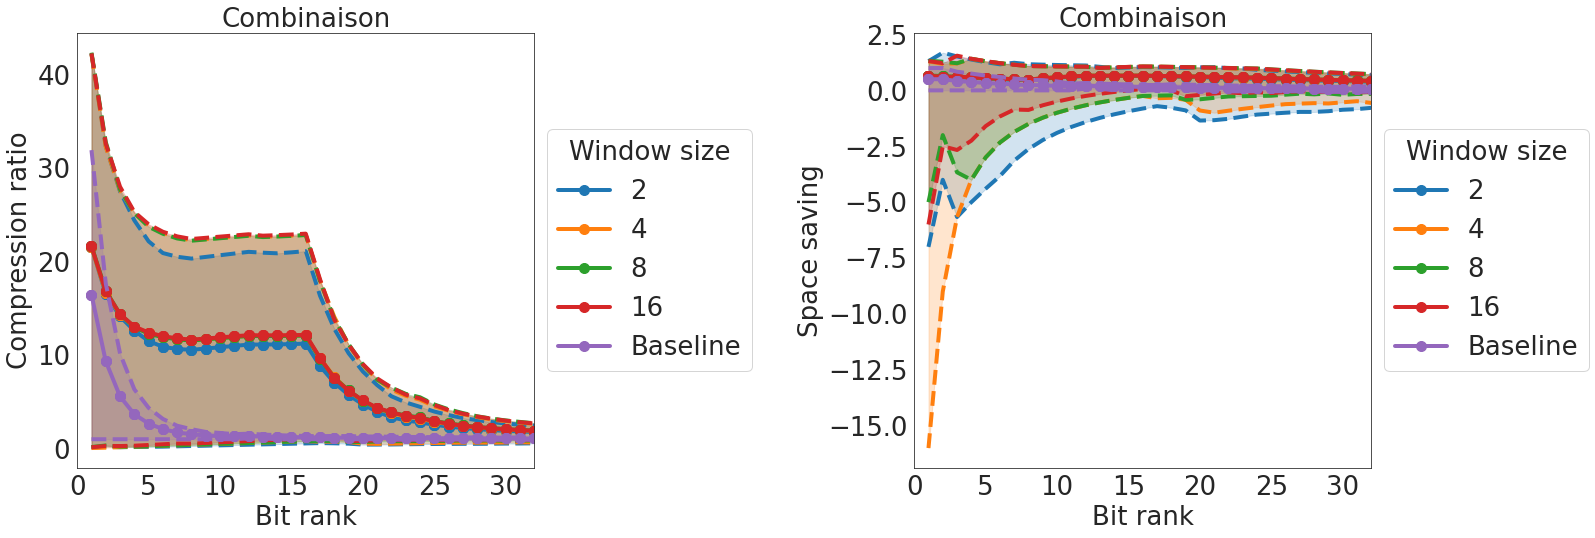

In [197]:
fig, axes = plt.subplots(
    1, 2, figsize=(20*2, 8))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
#fig.subplots_adjust(wspace=0.25, 
#                    hspace=1.1)
fig.subplots_adjust(wspace=-0.4, 
                    hspace=1.1)

# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['look_back_packet']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    ax1 = ax
    #ax2 = ax1.twiny()

    #err_bar = [[0]*df_plot.shape[0], 
    #           [0]*df_plot.shape[0]]

    
    # SET FIRST AXIS

    
    # Check if we use baseline
    if (USE_BASELINE):
        
        # Define condition
        cond = (df_plot[hue] != "Baseline")
        
        # Set rank 
        unique_values = df_plot[cond][hue] \
                            .astype(int) \
                            .value_counts()\
                            .sort_index()\
                            .index
        
        unique_values = \
            list(unique_values) + \
                ["Baseline"]
    else:
        
        # Set rank 
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .sort_index()\
                            .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        if (ERROR_BAR):
            
            lower = (df_plot[cond][col]-\
                df_plot[cond]['low_yerror_'+col]).abs()
            upper = (df_plot[cond]['high_yerror_'+col]-\
                df_plot[cond][col]).abs()
            err_bar = [lower, 
                       upper]
            #err_bar = [(df_plot[cond][col]-df_plot[cond]['low_yerror']).abs(), 
            #           (df_plot[cond]['high_yerror']-df_plot[cond][col]).abs()]
            #err_bar = [[0]*df_plot[cond].shape[0], 
            #           [0]*df_plot[cond].shape[0]]

            ax.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
            
            # Get color from mean plot
            last_line = ax1.get_lines()[-1]
            color_last_line = last_line.get_color()
            
            # Set error area with alpha
            ax.fill_between(df_plot[cond]['bit_ranks'],
                            df_plot[cond][col]-lower, 
                            df_plot[cond][col]+upper,
                            alpha=0.2,
                            color=color_last_line)
            
            # Set min and max for error area
            ax.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]-lower,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
            ax.plot(df_plot[cond]['bit_ranks'],
                    df_plot[cond][col]+upper,
                    alpha=1,
                    linestyle='--',
                    linewidth=LINEWIDTH,
                    color=color_last_line)
        else:
            ax.plot(df_plot[cond]['bit_ranks'], 
                     df_plot[cond][col],
                     linewidth=LINEWIDTH,
                     markersize=MARKERSIZE, # Size of point
                     alpha=1,
                     label=f"{val}",
                     marker='o',
                     #linestyle="--",
                    )
            
        # Parameter for outside legend
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Set legend
        #legend = ax1.legend(unique_values,
        #           fontsize=LEGEND_FONTSIZE)
        #for item in legend.legendHandles:
        #    item.set_visible(False)
        legend = ax.legend(fontsize=LEGEND_FONTSIZE,
                           # Parameter for outside legend
                           loc='center left',
                           bbox_to_anchor=(1, 0.5),
                           frameon=True)
        legend.set_title('Window size', 
                         prop={'size':LEGEND_FONTSIZE})
        

    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)
    ax.set_xlim([0, 32])

    # Set title
    if (MODE_DATASET == "checksum34"):
        title = "Checksum"
    else:
        title = MODE_DATASET.replace("_", " ").capitalize()
        
    ax.set_title(f"{title}", 
                fontsize=TITLE_FONTSIZE)

#### 4.8.3 Performance compression HISTOGRAM MODE_DATASET by varying windows size

In [18]:
ERROR_BAR = True
LOOK_BACK_PACKETS = [2, 4, 8, 16]
MODE_DATASET = 'checksum34' #['random', 'checksum', 'checksum34', 'fixed_flow', 
               #  "fixed", 'inversion', 'counter', 'combinaison']

LOOK_BACK_CONTEXT = 2
LEFT_PADDING = True
USE_BASELINE = True

data_results = pd.DataFrame()


# Reset EXT_NAME
if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"
else:
    if (CUSTOM_SIZE is not None):
        ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"    

    
# Add baseline in comparaison
if (USE_BASELINE):
    
    # Add baseline
    LOOK_BACK_PACKETS.insert(0, "Baseline")
    
    LOOK_BACK_PACKET = 8
    full_name = f"LOSSLESS_PACKET{LOOK_BACK_PACKET}_BASELINE_NAIVE"
    
    if (LEFT_PADDING):
        data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}{ext_name}_DECIMALSNone_LEFT_PADDING_COMPRESSION.csv")
    else:
        data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}{ext_name}_DECIMALSNone_COMPRESSION.csv")
    
    data_results_tmp["look_back_packet"] = "Baseline"
    data_results_tmp["mode_dataset"] = MODE_DATASET
    data_results_tmp['size_uncompress'] = \
            data_results_tmp['headers_length']

    # Correct value
    data_results_tmp['size_context'] = \
        data_results_tmp['packets_rank']
    cond = (data_results_tmp['packets_rank'] >= LOOK_BACK_CONTEXT)
    data_results_tmp.loc[cond, 'size_context'] = LOOK_BACK_CONTEXT

    # Compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / \
                 (data_results_tmp["size_uncompress"]))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    

for look_back_packet in LOOK_BACK_PACKETS[1:]:

    if (CHECKSUM):
        if (CUSTOM_SIZE is not None):
            ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
        else:
            ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        if (CUSTOM_SIZE is not None):
            ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
        else:
            ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"

    if (LEFT_PADDING):
        ext_name = ext_name + "_LEFT_PADDING"

    full_name = f"LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{look_back_packet}_SIN{NUM_SIN}"
    data_results_tmp = pd.read_csv(f"./RESULTS/INTERPRETATION/df_{full_name}{ext_name}_COMPRESSION.csv")

    data_results_tmp["look_back_packet"] = int(look_back_packet)
    data_results_tmp["mode_dataset"] = MODE_DATASET
    data_results_tmp['size_uncompress'] = \
            data_results_tmp['headers_length']

    # Correct value
    data_results_tmp['size_context'] = \
        data_results_tmp['packets_rank']
    cond = (data_results_tmp['packets_rank'] >= LOOK_BACK_CONTEXT)
    data_results_tmp.loc[cond, 'size_context'] = LOOK_BACK_CONTEXT

    # Compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / \
                 (data_results_tmp["size_uncompress"]))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    
    
# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

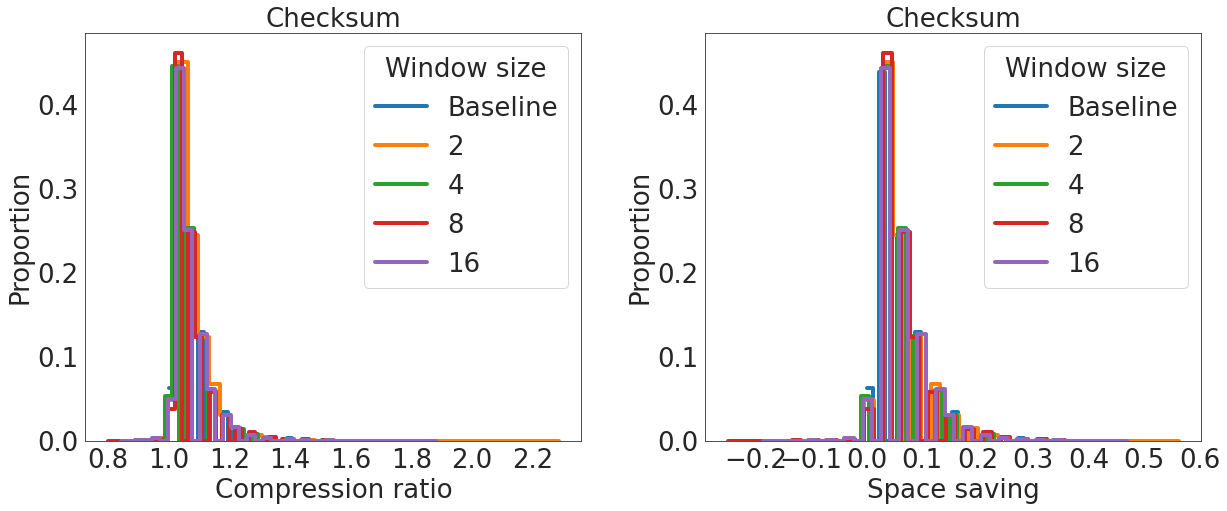

In [142]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)


# Parcourir les axes

df_plot = data_results.copy()

for ax, hue, col, title in zip(
    axes.ravel(), 
    ['look_back_packet']*2,
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): # [f"Compression ratio (U/C)", f"Space saving [1-(C/U)]"]
    
    # SET FIRST AXIS
    
    # Check if we use baseline
    '''if (USE_BASELINE):
        
        # Define condition
        cond = (df_plot[hue] != "Baseline")
        
        # Set rank 
        unique_values = df_plot[cond][hue] \
                            .astype(int) \
                            .value_counts()\
                            .sort_index()\
                            .index
        
        unique_values = \
            list(unique_values) + \
                ["Baseline"]
    else:'''
        
    # Set rank 
    unique_values = df_plot[hue] \
                        .value_counts()\
                        .index
                        #.sort_index()\
                        #.index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        sns.histplot(df_plot[cond][col], 
                     element="step",
                     stat='probability',
                     bins=40,
                     linewidth=LINEWIDTH,
                     fill=False,
                     ax=ax)
        
        #ax.hist(df_plot[cond][col],
        #        density=False,
                #linewidth=LINEWIDTH,
        #        bins=70
        #       )

        # Set legend
        legend = ax.legend(unique_values, 
                  fontsize=LEGEND_FONTSIZE)
        legend.set_title('Window size', 
                         prop={'size':LEGEND_FONTSIZE})
        
        
    # Normalize axis
    '''yticklabels = ax.get_yticks() 
    yticklabels_update = np.round(
        yticklabels/df_plot[cond][col].shape[0], 3)'''
        
    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)
        
    # Set normalized labels
    #ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        

    # Set label  
    ax.set_ylabel("Proportion", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"{title}", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if (MODE_DATASET == "checksum34"):
        title = "Checksum"
    else:
        title = MODE_DATASET.replace("_", " ").capitalize()
    ax.set_title(f"{title}", 
                fontsize=TITLE_FONTSIZE)

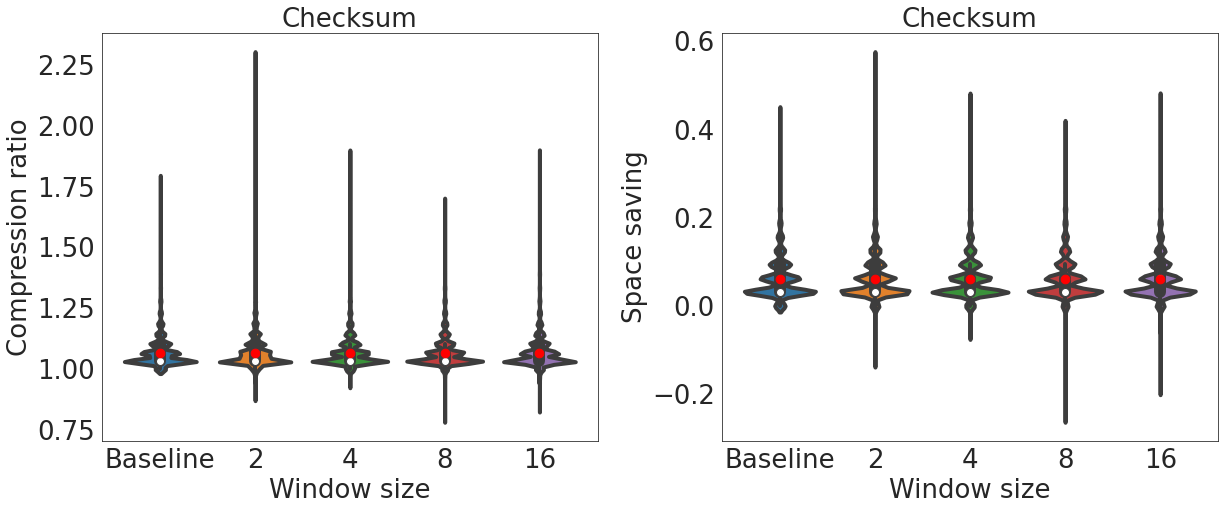

In [19]:
# Plot MEAN and STD
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
alpha=0.95

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)


#modes_dataset = [mode_d.replace("_", " ") 
#                 for mode_d in MODES_DATASET]

# Parcourir les axes

for ax, col, title in zip(
    axes.ravel(),
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): #[f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    # Plot error 
    '''sns.boxplot(x='decimals', 
                y=col, data=data_results, 
                hue='keep_error',
                showmeans=True,
                meanprops={"marker": "o",
                           "markerfacecolor":"red",
                           "markeredgecolor": "red",
                           "markersize": "10"},
                linewidth=LINEWIDTH,
                ax=ax)'''
    
    means = data_results\
        .groupby('look_back_packet')[col]\
        .mean()\
        .loc[LOOK_BACK_PACKETS]
    #modes = data_results.groupby('cut_values')[col]\
    #                    .agg(lambda x: pd.Series.mode(x)[0])
    
    #{“box”, “quartile”, “point”, “stick”, None}
    sns.violinplot(x="look_back_packet", 
                   y=col, data=data_results, 
                   #hue='keep_error',
                   showmeans=True,
                   meanprops={"marker": "o",
                               "markerfacecolor":"red",
                               "markeredgecolor": "red",
                               "markersize": "10"},
                   linewidth=LINEWIDTH,
                   ax=ax)
    
    ax.scatter(x=range(len(means)), 
               y=means, c="red",
               s=75,
               zorder=100)
        
    ax.set_ylabel(f"{title}",
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Window size",
                  fontsize=LABEL_FONTSIZE)
    
    
    #ax.tick_params(labelsize=TICK_FONTSIZE)
    
    # SET SECOND AXIS

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    
    # Update tick label in upper case
    labels = [item.get_text().title() for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)

    # Set field name
    #ax2 = ax1.twiny()
    ax.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(25)

    # Set title
    if (MODE_DATASET == "checksum34"):
        title = "Checksum"
    else:
        title = MODE_DATASET.replace("_", " ").capitalize()
    ax.set_title(f"{title}", 
                fontsize=TITLE_FONTSIZE)

#### 4.4.5 Number of entry function of nb bits for Huffman table

In [15]:
ERROR_BAR = True
CUT_VALUES = [2, 4, 6, 8, 10, 12, 16, 20]
MODE_DATASETS = ["fixed", 'combinaison', 'checksum34'] #['random', 'checksum34', 'fixed_flow', 
                # "fixed", 'inversion', 'counter'#, 'combinaison'
                #]

LOOK_BACK_CONTEXT = 1
LOOK_BACK_PACKET = 8
LEFT_PADDING = True
NB_BITS = 16*2

# Options for huffman table
# construction
OPTIMAL = False
SELECTIVE = True
USE_BASELINE = False

data_results = pd.DataFrame()
index_results = 0


# CHANGE DATAFRAME FORMAT 
def my_func(x, max_length=8):
    value = str(x)
    length = len(value)
    value_extend = "0"*(max_length-length)
    value = value_extend + value
    return value

for mode_d in MODE_DATASETS:

    for cut_value in CUT_VALUES:

        for optimal in [True, False]:

            # Load HUFFMAN

            if (CHECKSUM):
                if (CUSTOM_SIZE is not None):
                    ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{mode_d}_KEEP_ERROR_{cut_value}"
                else:
                    ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{mode_d}_KEEP_ERROR_{cut_value}"
            else:
                if (CUSTOM_SIZE is not None):
                    ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{mode_d}_KEEP_ERROR_{cut_value}"
                else:
                    ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{mode_d}_KEEP_ERROR_{cut_value}"

            if (SELECTIVE):
                ext_name = ext_name + "_SELECTIVE"

            if (optimal):
                ext_name = ext_name + "_OPTIMAL"

            if (LEFT_PADDING):
                ext_name = ext_name + "_LEFT_PADDING"

            full_name = f"HUFFMAN_LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}"
            df_huffman_tmp = pd.read_csv(f"./MODELS/HUFFMAN/INTERPRETATION/df_{full_name}{ext_name}.csv", 
                                         dtype={"key": str})

            df_huffman_tmp['key'] = df_huffman_tmp['key'].map(
                lambda x : my_func(x, max_length=cut_value))
            df_huffman_groupby = df_huffman_tmp.groupby(
                ['ctx', 'pos', 'key']).mean()

            # Save results

            data_results.loc[index_results, "nb_value"] = \
                df_huffman_groupby.shape[0]
            data_results.loc[index_results, "cut_value"] = \
                int(cut_value)
            data_results.loc[index_results, "max_cut_value"] = \
                (2**int(cut_value))*NB_BITS*(LOOK_BACK_CONTEXT+1)
            data_results.loc[index_results, "mode_dataset"] = \
                mode_d
            data_results.loc[index_results, "optimal"] = \
                optimal

            # Add index

            index_results += 1
    
# Compute percentage
data_results["percent_nb_value"] = \
    data_results["nb_value"] / data_results["max_cut_value"]

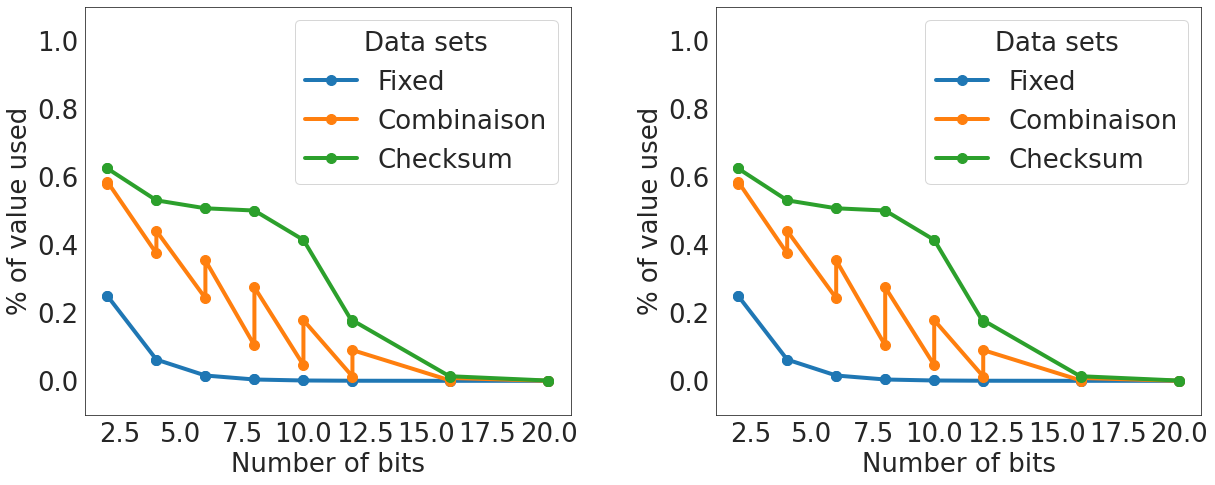

In [16]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
ax = axes[0]

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.3, 
                    hspace=1.1)

df_plot = data_results.copy()

# Parcourir les axes
#hue = "optimal"
#col = 'percent_nb_value'
#title = MODE_DATASET

for ax, col, hue in zip(
    axes.ravel(),
    ['percent_nb_value']*2,
    ["mode_dataset"]*2
    #['compression_ratio', 'space_saving'],
    #[f"Compression ratio", f"Space saving"]
): #[f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    #ax1 = ax
    #ax2 = ax1.twiny()

    # SET FIRST AXIS
    
    # Set rank 
    #unique_values = df_plot[hue] \
    #                    .value_counts() \
    #                    .sort_index() \
    #                    .index
            
    for val in MODE_DATASETS: #unique_values:

        cond = (df_plot[hue] == val)

        # Set rank 
        ax.plot(df_plot[cond]['cut_value'].astype(int), 
                 df_plot[cond][col],
                 linewidth=LINEWIDTH,
                 markersize=MARKERSIZE, # Size of point
                 alpha=1,
                 label=f"{val}",
                 marker='o',
                 #linestyle="--",
                )

    # Set legend
    mode_datasets = []
    for mode_d in MODE_DATASETS:
        if (mode_d == "checksum34"):
            mode_datasets.append("Checksum")
        else:
            mode_datasets.append(mode_d\
                                .replace("_", " ")\
                                .capitalize())
        
    legend = ax.legend(mode_datasets, 
                       fontsize=LEGEND_FONTSIZE)
    legend.set_title('Data sets', 
                     prop={'size':LEGEND_FONTSIZE})


    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax.set_ylabel('% of value used', 
                   fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"Number of bits", 
                   fontsize=LABEL_FONTSIZE)

    # Set axis limit
    '''lower_ylimit = df_plot[
        ['huffman_table', 
         'freqs_array_compress']].min().min()
    upper_ylimit = df_plot[
        ['huffman_table', 
         'freqs_array_compress']].max().max()
    upper_ylimit = upper_ylimit + \
        upper_ylimit*0.1'''

    #print("[DEBUG] lower_ylimit: ", lower_ylimit)
    #print("[DEBUG] upper_ylimit: ", upper_ylimit)

    ax.set_ylim([-0.1, 1.1])

    # Set title
    '''if (MODE_DATASET == "checksum34"):
        title = "Checksum"
    else:
        title = MODE_DATASET\
                .replace("_", " ")\
                .capitalize()

    ax.set_title(f"{title}", 
                fontsize=TITLE_FONTSIZE)'''

#### 4.4.5 Compression performance nb bits for Huffman table (BOXPLOT)

In [15]:
CUT_VALUES = [2, 4, 6, 8, 10]#, 10, 12, 16] # 20, 32, 36, 44]
MODE_DATASET = 'checksum34' #['random', 'checksum', 'checksum34', 'fixed_flow', 
               #  "fixed", 'inversion', 'counter', 'combinaison']
USE_BASELINE = True

LOOK_BACK_CONTEXT = 1
LOOK_BACK_PACKET = 8
DECIMALS = "None"

# Options for huffman table
# construction
OPTIMAL = True
SELECTIVE = True

data_results = pd.DataFrame()

# Add baseline in comparaison
if (USE_BASELINE):
    
    # Add baseline
    CUT_VALUES.insert(0, "Base.")
    
    full_name = f'LOSSLESS_PACKET{LOOK_BACK_PACKET}'
    
    if (CHECKSUM):
        if (CUSTOM_SIZE is not None):
            ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}_DECIMALS{DECIMALS}"
        else:
            ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}_DECIMALS{DECIMALS}"
    else:
        if (CUSTOM_SIZE is not None):
            ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}_DECIMALS{DECIMALS}"
        else:
            ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}_DECIMALS{DECIMALS}"
            
    if (LEFT_PADDING):
        ext_name = ext_name + "_LEFT_PADDING"
    
    data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}_BASELINE_NAIVE{ext_name}_COMPRESSION.csv")
    
    # Set values specific to huffman
    data_results_tmp["cut_values"] = "Base."
    data_results_tmp["keep_error"] = True

    data_results_tmp["mode_dataset"] = MODE_DATASET
    data_results_tmp['size_uncompress'] = \
            data_results_tmp['headers_length']

    # Correct value
    data_results_tmp['size_context'] = \
        data_results_tmp['packets_rank']
    cond = (data_results_tmp['packets_rank'] >= LOOK_BACK_CONTEXT)
    data_results_tmp.loc[cond, 'size_context'] = LOOK_BACK_CONTEXT

    # Compression ratio and space saving
    data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                            data_results_tmp["size_compress"]
    data_results_tmp["space_saving"] = 1 - \
            (data_results_tmp["size_compress"] / \
                 (data_results_tmp["size_uncompress"]))

    data_results = pd.concat(
        [data_results, data_results_tmp], axis=0)
    

for k_e in [True]: #, False]:
    
    for optimal in [True]: #, False]:
    
        for c_val in CUT_VALUES[1:]:

            full_name = f'LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN8'

            if (CHECKSUM):
                if (CUSTOM_SIZE is not None):
                    ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}_KEEP_ERROR_{c_val}"
                else:
                    ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}_KEEP_ERROR_{c_val}"
            else:
                if (CUSTOM_SIZE is not None):
                    ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}_KEEP_ERROR_{c_val}"
                else:
                    ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}_KEEP_ERROR_{c_val}"

            # Change extension name        
            if (k_e):
                ext_name_huffman =  "_HUFFMAN" + ext_name + f"_DECIMALSNone"
            else:
                ext_name_huffman = "_HUFFMAN" + ext_name + f"_DECIMALSNone"

            if (SELECTIVE):
                ext_name_huffman += "_SELECTIVE"

            if (optimal):
                ext_name_huffman += "_OPTIMAL"

            if (LEFT_PADDING):
                ext_name_huffman += "_LEFT_PADDING"

            filename = (f"RESULTS/HUFFMAN/INTERPRETATION/df_{full_name}{ext_name_huffman}"
                            f"_COMPRESSION.csv")

            data_results_tmp = pd.read_csv(filename)

            # Set values specific to huffman
            data_results_tmp["cut_values"] = c_val
            data_results_tmp["keep_error"] = k_e
            data_results_tmp["optimal"] = optimal

            data_results_tmp["mode_dataset"] = MODE_DATASET
            data_results_tmp['size_uncompress'] = \
                    data_results_tmp['headers_length']

            # Correct value
            data_results_tmp['size_context'] = \
                data_results_tmp['packets_rank']
            cond = (data_results_tmp['packets_rank'] >= LOOK_BACK_CONTEXT)
            data_results_tmp.loc[cond, 'size_context'] = LOOK_BACK_CONTEXT

            # Compression ratio and space saving
            data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                                    data_results_tmp["size_compress"]
            data_results_tmp["space_saving"] = 1 - \
                    (data_results_tmp["size_compress"] / \
                         (data_results_tmp["size_uncompress"]))

            data_results = pd.concat(
                [data_results, data_results_tmp], axis=0)

In [19]:
cond = (data_results['packets_rank'] >= 1)
data_results = data_results[cond].reset_index(drop=True)

'for ax in axes.ravel():\n    \n    # Set legend\n    legend = ax.legend(\n        #["True", "False"],\n        fontsize=LEGEND_FONTSIZE,\n        #loc="upper right"\n    )#,\n        #handler_map={plt.Line2D : HandlerLine2D(update_func=update)})\n        \n    legend.set_title(\'Threshold\', \n                     prop={\'size\':LEGEND_FONTSIZE})'

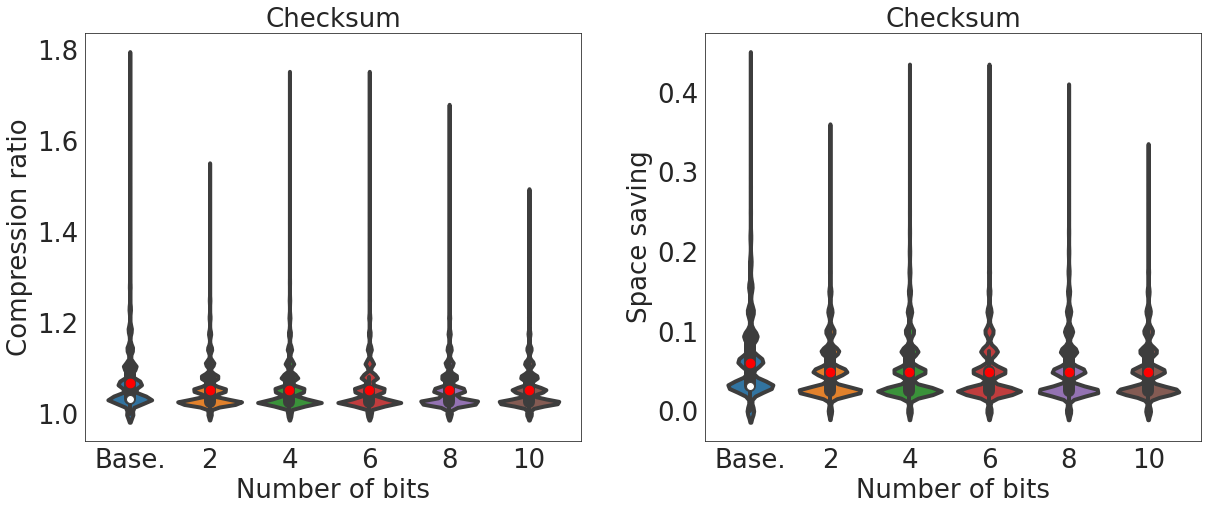

In [16]:
# Plot MEAN and STD
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
alpha=0.95

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

# Parcourir les axes

for ax, col, hue, title in zip(
    axes.ravel(),
    ['compression_ratio', 'space_saving'],
    ["optimal"]*2,
    [f"Compression ratio", f"Space saving"]): #[f"compression ratio (U/C)", f"space saving [1-(C/U)]"]
    
    #for k_e in [True, False]:
        
        # Extract k_e
        #cond = (data_results['keep_error'] == k_e)
        
        # Get MEAN
    
        #df_plot_mean = data_results[cond]\
        #    .groupby(["cut_values"])\
        #     .mean().reset_index()

    # Plot error 
    '''sns.boxplot(x='cut_values', 
                y=col, data=data_results, 
                hue='keep_error',
                showmeans=True,
                meanprops={"marker": "o",
                           "markerfacecolor":"red",
                           "markeredgecolor": "red",
                           "markersize": "10"},
                linewidth=LINEWIDTH,
                ax=ax)'''
    
    # Stats
    means = data_results.groupby('cut_values')[col]\
                        .mean().loc[CUT_VALUES]
    
    #{“box”, “quartile”, “point”, “stick”, None}
    sns.violinplot(x='cut_values', 
                   y=col, 
                   data=data_results, 
                   #hue=hue,
                   split=True,
                   showmeans=True,
                   meanprops={"marker": "o",
                               "markerfacecolor":"red",
                               "markeredgecolor": "red",
                               "markersize": "10"},
                   linewidth=LINEWIDTH,
                   inner="box",
                   #inner=None,
                   ax=ax)
    
    ax.scatter(x=range(len(means)), 
               y=means, c="red",
               s=75,
               zorder=100)
    
    #plt.setp(ax.collections, alpha=.3)
    
    # Set man marker
    #ax.scatter(x=range(len(means)), 
    #           y=means, c="white",
    #           s=75)
    #sns.pointplot(x='cut_values', 
    #              y=col, 
    #              color='red',
    #              markers='o',
    #              data=data_results, 
    #              estimator=np.mean,
    #              ax=ax)
    #ax.scatter(x=range(len(Modes)),y=Modes)
 
    ax.set_ylabel(f"{title}",
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Number of bits",
                  fontsize=LABEL_FONTSIZE)
    ax.tick_params(labelsize=TICK_FONTSIZE)

    # Set title
    if (MODE_DATASET == "checksum34"):
        title = "Checksum"
    else:
        title = MODE_DATASET\
                .replace("_", " ")\
                .capitalize()
        
    ax.set_title(f"{title}", 
                fontsize=TITLE_FONTSIZE)

#def update(handle, orig):
#    handle.update_from(orig)
#    handle.set_linewidth(LINEWIDTH)
    
'''for ax in axes.ravel():
    
    # Set legend
    legend = ax.legend(
        #["True", "False"],
        fontsize=LEGEND_FONTSIZE,
        #loc="upper right"
    )#,
        #handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
        
    legend.set_title('Threshold', 
                     prop={'size':LEGEND_FONTSIZE})'''

#### 4.4.6 Compression performance per DECIMALS precision for Huffman table (BOXPLOT)

In [81]:
DECIMALS = [1, 2, 4, 9]
CUT_VALUE = 4

MODE_DATASET = 'random' #['random', 'checksum', 'checksum34', 'fixed_flow', 
               #  "fixed", 'inversion', 'counter', 'combinaison']

LOOK_BACK_CONTEXT = 1
LOOK_BACK_PACKET = 8

# Options for huffman table
# construction
OPTIMAL = True
SELECTIVE = True

data_results = pd.DataFrame()

# Keep error
for k_e in [True]:#, False]:
    
    #for optimal in tqdm([True, False]):

    for dec in tqdm(DECIMALS):

        full_name = f"LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_HUFFMAN"
        
        if (CHECKSUM):
            if (CUSTOM_SIZE is not None):
                full_name += f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
            else:
                full_name += f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"
        else:
            if (CUSTOM_SIZE is not None):
                full_name += f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
            else:
                full_name += f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"

        if (k_e):
            ext_name_huffman = f"_KEEP_ERROR_{CUT_VALUE}_DECIMALS{dec}"
        else:
            ext_name_huffman = f"_{CUT_VALUE}_DECIMALS{dec}"
            
        if (SELECTIVE):
            ext_name_huffman += "_SELECTIVE"
            
        if (OPTIMAL):
            ext_name_huffman += "_OPTIMAL"
            
        if (LEFT_PADDING):
            ext_name_huffman += "_LEFT_PADDING"

        data_results_tmp = pd.read_csv(f"./RESULTS/HUFFMAN/INTERPRETATION/df_{full_name}{ext_name_huffman}_COMPRESSION.csv")

        # Set values specific to huffman
        data_results_tmp["cut_values"] = c_val
        data_results_tmp["keep_error"] = k_e
        data_results_tmp["decimals"] = dec

        data_results_tmp["mode_dataset"] = MODE_DATASET
        data_results_tmp['size_uncompress'] = \
                data_results_tmp['headers_length']

        # Correct value
        data_results_tmp['size_context'] = \
            data_results_tmp['packets_rank']
        cond = (data_results_tmp['packets_rank'] >= LOOK_BACK_CONTEXT)
        data_results_tmp.loc[cond, 'size_context'] = LOOK_BACK_CONTEXT

        # Compression ratio and space saving
        data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                                data_results_tmp["size_compress"]
        data_results_tmp["space_saving"] = 1 - \
                (data_results_tmp["size_compress"] / \
                     (data_results_tmp["size_uncompress"]))

        data_results = pd.concat(
            [data_results, data_results_tmp], axis=0)

100%|██████████| 4/4 [00:00<00:00, 11.98it/s]


In [68]:
cond = (data_results['packets_rank'] >= 1)
data_results = data_results[cond].reset_index(drop=True)

'for ax in axes.ravel():\n    \n    # Set legend\n    legend = ax.legend(\n        #["True", "False"],\n        fontsize=LEGEND_FONTSIZE, #,\n        loc="upper right")\n        #handler_map={plt.Line2D : HandlerLine2D(update_func=update)})\n    #legend.set_title(\'Keep error\', \n    #                 prop={\'size\':LEGEND_FONTSIZE})'

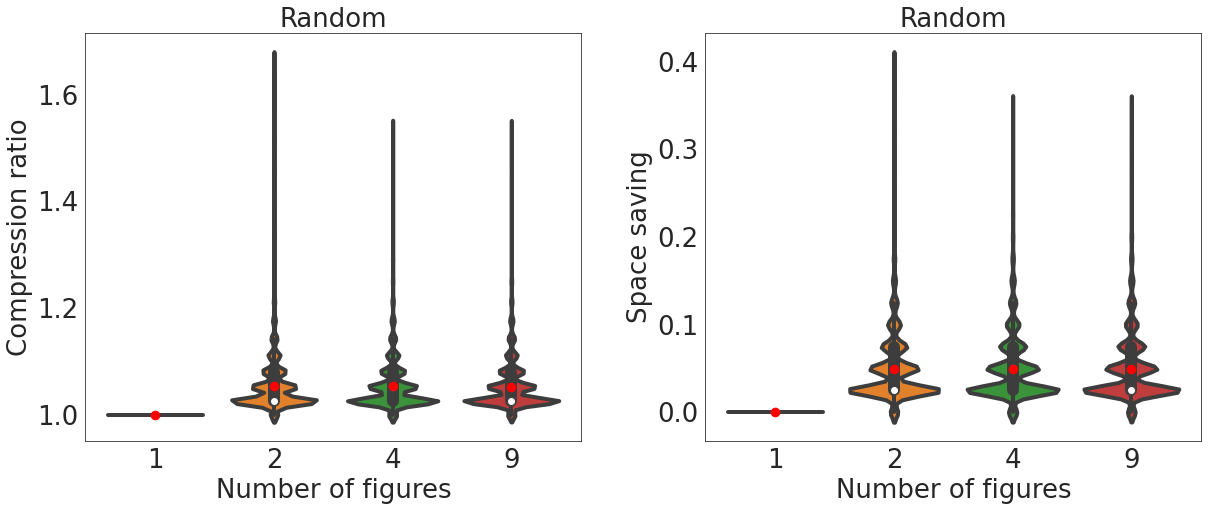

In [82]:
# Plot MEAN and STD
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
alpha=0.95

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

# Parcourir les axes

for ax, col, title in zip(
    axes.ravel(),
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): #[f"compression ratio (U/C)", f"space saving [1-(C/U)]"]

    # Plot error 
    '''sns.boxplot(x='decimals', 
                y=col, data=data_results, 
                hue='keep_error',
                showmeans=True,
                meanprops={"marker": "o",
                           "markerfacecolor":"red",
                           "markeredgecolor": "red",
                           "markersize": "10"},
                linewidth=LINEWIDTH,
                ax=ax)'''
    
    means = data_results.groupby('decimals')[col]\
                        .mean().loc[DECIMALS]
    #modes = data_results.groupby('cut_values')[col]\
    #                    .agg(lambda x: pd.Series.mode(x)[0])
    
    #{“box”, “quartile”, “point”, “stick”, None}
    sns.violinplot(x='decimals', 
                   y=col, data=data_results, 
                   #hue='keep_error',
                   showmeans=True,
                   meanprops={"marker": "o",
                               "markerfacecolor":"red",
                               "markeredgecolor": "red",
                               "markersize": "10"},
                   linewidth=LINEWIDTH,
                   ax=ax)
    
    ax.scatter(x=range(len(means)), 
               y=means, c="red",
               s=75,
               zorder=100)
        
    ax.set_ylabel(f"{title}",
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Number of figures",
                  fontsize=LABEL_FONTSIZE)
    ax.tick_params(labelsize=TICK_FONTSIZE)

    # Set title
    if (MODE_DATASET == "checksum34"):
        title = "Checksum"
    else:
        title = MODE_DATASET\
                .replace("_", " ")\
                .capitalize()
        
    ax.set_title(f"{title}", 
                fontsize=TITLE_FONTSIZE)
    
'''for ax in axes.ravel():
    
    # Set legend
    legend = ax.legend(
        #["True", "False"],
        fontsize=LEGEND_FONTSIZE, #,
        loc="upper right")
        #handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
    #legend.set_title('Keep error', 
    #                 prop={'size':LEGEND_FONTSIZE})'''

### 4.8.3 Tableau interpretation

In [51]:
# Parameters

CUT_VALUE = 8 #[2, 4, 6, 8, 10]#, 10, 12, 16] # 20, 32, 36, 44]
MODE_DATASET = 'fixed_flow' #['random', 'checksum', 'checksum34', 'fixed_flow', 
               #  "fixed", 'inversion', 'counter', 'combinaison']
USE_BASELINE = True

LOOK_BACK_CONTEXT = 0 # 2
LOOK_BACK_PACKET = 16
NUM_SIN = 0
DECIMALS = "None"

# Options for huffman table
# construction
OPTIMAL = True
SELECTIVE = True
LEFT_PADDING = False

KEEP_ERROR = True
ERROR_BAR = True

#data_results = pd.DataFrame()

In [127]:
# Add baseline in comparaison
full_name = f'LOSSLESS_PACKET{LOOK_BACK_PACKET}'

if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}_DECIMALS{DECIMALS}"
    else:
        ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}_DECIMALS{DECIMALS}"
else:
    if (CUSTOM_SIZE is not None):
        ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}_DECIMALS{DECIMALS}"
    else:
        ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}_DECIMALS{DECIMALS}"

if (LEFT_PADDING):
    ext_name = ext_name + "_LEFT_PADDING"

data_results_tmp = pd.read_csv(f"./RESULTS/BASELINE_NAIVE/df_{full_name}_BASELINE_NAIVE{ext_name}_COMPRESSION.csv")

# Set values specific to huffman
data_results_tmp["cut_values"] = "Base."
data_results_tmp["keep_error"] = True

#data_results_tmp["mode_dataset"] = MODE_DATASET
data_results_tmp['size_uncompress'] = \
        data_results_tmp['headers_length']

# Correct value
data_results_tmp['size_context'] = \
    data_results_tmp['packets_rank']
cond = (data_results_tmp['packets_rank'] >= LOOK_BACK_CONTEXT)
data_results_tmp.loc[cond, 'size_context'] = LOOK_BACK_CONTEXT

# Compression ratio and space saving
data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                        data_results_tmp["size_compress"]
data_results_tmp["space_saving"] = 1 - \
        (data_results_tmp["size_compress"] / \
             (data_results_tmp["size_uncompress"]))

data_results = data_results_tmp.copy()

In [52]:
# Load DCH prediction

if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"
else:
    if (CUSTOM_SIZE is not None):
        ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"

if (LEFT_PADDING):
    ext_name = ext_name + "_LEFT_PADDING"

full_name = f"LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}"
data_results_tmp = pd.read_csv(f"./RESULTS/INTERPRETATION/df_{full_name}{ext_name}_COMPRESSION.csv")

data_results_tmp["look_back_packet"] = int(LOOK_BACK_PACKET)
data_results_tmp["mode_dataset"] = MODE_DATASET
data_results_tmp['size_uncompress'] = \
        data_results_tmp['headers_length']

# Correct value
data_results_tmp['size_context'] = \
    data_results_tmp['packets_rank']
cond = (data_results_tmp['packets_rank'] >= LOOK_BACK_CONTEXT)
data_results_tmp.loc[cond, 'size_context'] = LOOK_BACK_CONTEXT

# Compression ratio and space saving
data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                        data_results_tmp["size_compress"]
data_results_tmp["space_saving"] = 1 - \
        (data_results_tmp["size_compress"] / \
             (data_results_tmp["size_uncompress"]))

data_results = data_results_tmp.copy()
    
    
# Replace inf
is_inf = data_results['compression_ratio']\
            .isin([np.inf, -np.inf])
data_results.loc[is_inf.values, "compression_ratio"] = \
    data_results.loc[is_inf.values, "headers_length"]

In [237]:
# Custom huffman table
full_name = f'LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}'

if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}_KEEP_ERROR_{CUT_VALUE}"
    else:
        ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}_KEEP_ERROR_{CUT_VALUE}"
else:
    if (CUSTOM_SIZE is not None):
        ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}_KEEP_ERROR_{CUT_VALUE}"
    else:
        ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}_KEEP_ERROR_{CUT_VALUE}"

# Change extension name        
if (KEEP_ERROR):
    ext_name_huffman =  "_HUFFMAN" + ext_name + f"_DECIMALSNone"
else:
    ext_name_huffman = "_HUFFMAN" + ext_name + f"_DECIMALSNone"

if (SELECTIVE):
    ext_name_huffman += "_SELECTIVE"

if (OPTIMAL):
    ext_name_huffman += "_OPTIMAL"

if (LEFT_PADDING):
    ext_name_huffman += "_LEFT_PADDING"

filename = (f"RESULTS/HUFFMAN/INTERPRETATION/df_{full_name}{ext_name_huffman}"
                f"_COMPRESSION.csv")

data_results_tmp = pd.read_csv(filename)

# Set values specific to huffman
data_results_tmp["cut_values"] = CUT_VALUE
data_results_tmp["keep_error"] = KEEP_ERROR
data_results_tmp["optimal"] = OPTIMAL

data_results_tmp["mode_dataset"] = MODE_DATASET
data_results_tmp['size_uncompress'] = \
        data_results_tmp['headers_length']

# Correct value
data_results_tmp['size_context'] = \
    data_results_tmp['packets_rank']
cond = (data_results_tmp['packets_rank'] >= LOOK_BACK_CONTEXT)
data_results_tmp.loc[cond, 'size_context'] = LOOK_BACK_CONTEXT

# Compression ratio and space saving
data_results_tmp["compression_ratio"] = (data_results_tmp["size_uncompress"]) / \
                                        data_results_tmp["size_compress"]
data_results_tmp["space_saving"] = 1 - \
        (data_results_tmp["size_compress"] / \
             (data_results_tmp["size_uncompress"]))

data_results = data_results_tmp.copy()

In [53]:
data_results['space_saving'].mean()

0.0622109375

### 4.8.4 Heatmap MODE_DATASET

In [33]:
#############################################
# SET PARAMETERS
#############################################


RESULTS_DIR = "RESULTS/FIELDS/INTERPRETATION/PARTS/"
MODELS_DIR = "MODELS/INTERPRETATION/"
MAIN_DIR = "./DATA/"

# Set keras types
tf.keras.backend.set_floatx('float64')

# Context
LOOK_BACK_CONTEXT = 1 # On rajoute +1 car on prend le dernier paquet comme paquet à compresser...
LOOK_AHEAD_CONTEXT = 1 #TIMESTEPS
CONTEXT_SIZE = LOOK_BACK_CONTEXT # Nombre timesteps sur les contexts
CONTEXT_OUTPUT_SIZE = 30 # Size of contexte in model layer
# De preference < 128 car c'est la taille de la
# couche GRU avant

# Packet
LOOK_BACK_PACKET = 8
LOOK_AHEAD_PACKET = 1
NUM_SIN = 8
NUM_FEATS = NUM_SIN + 1

# Learning parameters
SHUFFLE = False # For test generator
ALPHABET_SIZE = 2
BATCH_SIZE = 1 # For test generator

# Size added to header_length IN BYTES
EXTRA_SIZE = 0
CUSTOM_SIZE = 100 # Take the lead if extra size is define
CHECKSUM = True # True = Keep Checksum

# For Occlusion Map
NUM_RANK_FIELDS = 32+8 # Num of rank used for occlusion
KEEP_POS = False # Keep Sinusoide as a field ?
QUANTITY_BATCH = None # Num of batch used in total 
# If None all batch in train set is used
START_IDX = 0
END_IDX = 500
RANGE_IDX = 2500

# Generated dataset parameters
MAX_PACKET_RANK = 3 # Max rank support for packet
NB_BITS = 16*2 # Multiple for field inversion
NB_ROWS = 4000*MAX_PACKET_RANK # Multiple for the flow id NB_ROWS = x * MAX_PACKET_RANK
MODE_DATASET = "checksum34" # "random", "checksum", "checksum34", "fixed", "inversion", 
                            # "counter", "fixed_flow", "combinaison"
LEFT_PADDING = True # Padding dataset


# Name
# min(LOOK_BACK_CONTEXT, CONTEXT_OUTPUT_SIZE) if CONTEXT_OUTPUT_SIZE == 0
# else LOOK_BACK_CONTEXT == 1 or 2 or 3 or 4...etc
# easy to set LOOK_BACK_CONTEXT == 0
FULL_NAME = f"LOSSLESS_CONTEXT{min(LOOK_BACK_CONTEXT, CONTEXT_OUTPUT_SIZE)}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}"


if (CHECKSUM):

    if (CUSTOM_SIZE is not None):
        EXT_NAME = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        EXT_NAME = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"

else:

    if (CUSTOM_SIZE is not None):
        EXT_NAME = f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        EXT_NAME = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"


# If padding on dataset
if (LEFT_PADDING):
    EXT_NAME += f"_LEFT_PADDING"


print(f"MODEL : {FULL_NAME}{EXT_NAME}")

# Set the Seed for numpy random choice
np.random.seed(42)

MODEL : LOSSLESS_CONTEXT1_PACKET8_SIN8_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_DATASETchecksum34_LEFT_PADDING


In [34]:
# PREPARE DATA





# For checksum AND combinaison !
# From : https://www.thegeekstuff.com/2012/05/ip-header-checksum/

def sum_checksum(
    array_bit_a, array_bit_b):
    
    # Array must have the same length
    assert len(array_bit_a) == len(array_bit_b)
    
    # Sum of array
    array_bit_sum = np.zeros(
        (len(array_bit_a)), dtype=int)
    
    # For addition
    carry = 0
    
    # For each bit
    for i in reversed(range(len(array_bit_a))):
        
        # Get value
        value_a = array_bit_a[i]
        value_b = array_bit_b[i]
        sum_value = value_a + value_b + carry
        
        # Apply sum
        if (sum_value == 0):
            carry = 0
            array_bit_sum[i] = 0
        elif (sum_value == 1):
            carry = 0
            array_bit_sum[i] = 1
        elif (sum_value == 2):
            carry = 1
            array_bit_sum[i] = 0
        elif (sum_value == 3):
            carry = 1
            array_bit_sum[i] = 1
            
    # If the result is above origianl length
    if (carry):
        array_bit_tmp = np.zeros(
            (len(array_bit_a)), dtype=int)
        array_bit_tmp[-1] = 1
        array_bit_sum = sum_checksum(
            array_bit_sum, array_bit_tmp)
            
    return array_bit_sum
    

def complement_chekcsum(array):
    array_complement = \
        (array - 1)*(-1)
    return array_complement

def checksum(array, size=8):
    
    # Check array size is above 
    # checksum field size
    assert array.size >= size
    
    # Reshape to good size
    multiple = array.size / size
    
    # multiple == 1 therefore array.size = size
    # So we add with 0 we need to pad
    if ((array.size % size == 0) and 
        (multiple != 1)):
        array_reshape = \
            array.reshape((-1, size))
    else:
        
        # Compute coeff and get 
        # missing bit
        if (multiple == 1):
            coeff = 2
        else:
            coeff = np.ceil(array.size / size)
            
        # Compute nb_bits
        nb_bit = int(coeff*size - array.size)
        
        # Add zeros for padding
        array_tmp = np.concatenate(
            (array, np.zeros((nb_bit,)))) 

        # Reshape array
        array_reshape = \
            array_tmp.reshape((-1, size))
        
    
    # For each bytes
    for i in range(
        0, array_reshape.shape[0], 2):
        
        # Get first value
        if (i == 0):
            array_bit_a = array_reshape[i]
            array_bit_b = array_reshape[i+1]
        else:
            array_bit_a = array_bit_sum
            array_bit_b = array_reshape[i]
        
        # Apply sum
        array_bit_sum = sum_checksum(
            array_bit_a=array_bit_a, 
            array_bit_b=array_bit_b)
        
    # Apply complement
    array_bit_checksum = \
        complement_chekcsum(
            array=array_bit_sum)
        
    return array_bit_checksum



## int_to_bin
def int_to_bin(x, size=8):
    val = str(bin(x))[2:]
    s = len(val)
    gap = size - s

    if (gap < 0):
        raise "Error size limit too short"
        #size = max(s, size)

    gap_val = '0'*gap
    return gap_val+val



# Generate with another seed ! (for evaluation)
# "random", "checksum", "fixed", "inversion", "counter"

if (MODE_DATASET == "random"):

    # Reset the seed
    np.random.seed(43)

    arr_raw = \
        np.random.randint(
            0, 2, size=(NB_ROWS, NB_BITS))


elif ("checksum" in MODE_DATASET):

    # Reset the seed
    np.random.seed(43)


    if (MODE_DATASET == "checksum34"):
        # Checksum over 3 bytes
        CHECKSUM_LENGTH = 8
        
        # Create array of int
        arr_raw = np.random.randint(
            0, 2, 
            size=(NB_ROWS, int(NB_BITS*(3/4))),
            dtype=int)
        
    else:
        # Checksum classic over 16 bits
        CHECKSUM_LENGTH = 16
        
        # Create array of int
        arr_raw = np.random.randint(
            0, 2, 
            size=(NB_ROWS, int(NB_BITS*(2/4))),
            dtype=int)


    # Compute checksum
    arr_checksums = np.apply_along_axis(
        checksum, axis=1, 
        size=CHECKSUM_LENGTH,
        arr=arr_raw)
    arr_checksums = arr_checksums.astype(int)

    # Concatenate array
    arr_raw = np.concatenate(
        (arr_raw, arr_checksums), 
        axis=1)
    arr_raw = arr_raw.astype(int)


elif (MODE_DATASET == "fixed"):

    arr_raw = \
        np.ones((NB_ROWS, NB_BITS))
    arr_raw = arr_raw * \
        np.random.randint(
            0, 2, size=(1, NB_BITS))


elif (MODE_DATASET == "inversion"):

    # Reset the seed
    np.random.seed(43)

    ## Define array
    arr_raw = \
        np.zeros((NB_ROWS, NB_BITS))

    ## For each flow define random values

    # For each flow
    for i in range(
        0, NB_ROWS, MAX_PACKET_RANK):
        
        arr_raw_tmp_a = \
            np.random.randint(
                0, 2, size=(1, int(NB_BITS/2)))
        arr_raw_tmp_b = \
            np.random.randint(
                0, 2, size=(1, int(NB_BITS/2)))
        
        for j in range(MAX_PACKET_RANK):
            
            # Invert for next round
            if (j % 2 == 0):
                arr_raw_tmp = np.concatenate(
                    (arr_raw_tmp_b, arr_raw_tmp_a), 
                    axis=1)
            else:
                arr_raw_tmp = np.concatenate(
                        (arr_raw_tmp_a, arr_raw_tmp_b), 
                        axis=1)
            
            # Set to array
            if (i+j < NB_ROWS):
                arr_raw[i+j, :] = arr_raw_tmp


elif (MODE_DATASET == "counter"):

    # Reset the seed
    np.random.seed(43)
    
    ## int_to_bin
    def int_to_bin(x, size=8):
        val = str(bin(x))[2:]
        s = len(val)
        gap = size - s
        
        if (gap < 0):
            raise "Error size limit too short"
            #size = max(s, size)
        
        gap_val = '0'*gap
        return gap_val+val


    ## Define array
    arr_raw = \
        np.zeros((NB_ROWS, NB_BITS))


    # For each flow
    for i in range(
        0, NB_ROWS, 
        MAX_PACKET_RANK):
        
        # Generate number
        value = \
            np.random.randint(
                0, (2**NB_BITS)-MAX_PACKET_RANK, 
                size=(1,))[0]
        
        # For each flow rank
        for j in range(
            MAX_PACKET_RANK):
        
            ## Convert number to binary
            value_bin = int_to_bin(
                value, size=NB_BITS)
        
            ## Create array from binary
            ## values
            value_bin_array = \
                [int(bit) for bit in value_bin]
            
            # Set to array
            if (i+j < NB_ROWS):
                arr_raw[i+j, :] = value_bin_array
            
            # Add + 1
            value = value + 1


elif (MODE_DATASET == "fixed_flow"):

    # Reset the seed
    np.random.seed(43)

    ## Define array
    arr_raw = \
        np.zeros((NB_ROWS, NB_BITS))


    ## For each flow define random values

    # For each flow
    for i in range(
        0, NB_ROWS, MAX_PACKET_RANK):

        arr_raw_tmp = \
            np.random.randint(
                0, 2, size=(1, NB_BITS))

        for j in range(MAX_PACKET_RANK):

            # Set to array
            if (i+j < NB_ROWS):
                arr_raw[i+j, :] = arr_raw_tmp


elif (MODE_DATASET == "combinaison"):

    # Reset the seed
    np.random.seed(43)

    # Checksum over 3 bytes
    CHECKSUM_LENGTH = 8

    ## Define array
    arr_raw = \
        np.zeros((NB_ROWS, NB_BITS))

    # Generate fixed values
    arr_raw_fixed_tmp = \
            np.random.randint(
                0, 2, size=(1, int(NB_BITS/8)))

    ## For each flow define random values

    # For each flow
    for i in range(
        0, NB_ROWS, MAX_PACKET_RANK):

        # Generate number for compteur
        value = \
            np.random.randint(
                0, (2**int(NB_BITS/4))-MAX_PACKET_RANK, 
                size=(1,))[0]

        #arr_raw_cmp_tmp = \
        #    np.random.randint(
        #        0, 2, size=(1, int(NB_BITS/4)))
        
        ## Generate fixed flow
        arr_raw_fixed_flow_tmp = \
            np.random.randint(
                0, 2, size=(1, int(NB_BITS/8)))

        for j in range(MAX_PACKET_RANK):

            ## Convert number to binary
            value_bin = int_to_bin(
                    value, size=int(NB_BITS/4))

            ## Create array from binary
            ## values
            value_bin_array = \
                [int(bit) for bit in value_bin]
            value_bin_array = \
                np.array(value_bin_array)\
                .reshape(-1, int(NB_BITS/4))

            # Set to array
            #if (i+j < NB_ROWS):
            #    arr_raw[i+j, :] = value_bin_array        

            # Generate random part
            arr_raw_random_tmp = \
                np.random.randint(
                    0, 2, size=(1, int(NB_BITS/4)))

            # Generate fixed et fixed flow

            ## Concat fixed bytes
            arr_raw_fixed_all_tmp = \
                np.concatenate(
                    (arr_raw_fixed_tmp, 
                     arr_raw_fixed_flow_tmp), 
                    axis=1)

            # Invert for next round
            if (j % 2 == 0):

                # Apply concatenation
                arr_raw_tmp = np.concatenate(
                    (arr_raw_random_tmp, 
                     arr_raw_fixed_all_tmp,
                     value_bin_array, #arr_raw_cmp_tmp
                    ), 
                    axis=1)

            else:

                # Apply concatenation
                arr_raw_tmp = np.concatenate(
                    (value_bin_array, #arr_raw_cmp_tmp,
                     arr_raw_fixed_all_tmp,
                     arr_raw_random_tmp), 
                    axis=1)

            #print("[DEBUG] arr_raw_tmp.shape: ", 
            #          arr_raw_tmp.shape)

            # Compute checkusm
            arr_raw_ckecksum_tmp = \
                np.apply_along_axis(
                    checksum, axis=1, 
                    size=CHECKSUM_LENGTH,
                    arr=arr_raw_tmp)

            #print("[DEBUG] arr_raw_ckecksum_tmp.shape: ", 
            #          arr_raw_ckecksum_tmp.shape)

            # Concat all bytes
            arr_raw_tmp = np.concatenate(
                (arr_raw_tmp, 
                 arr_raw_ckecksum_tmp), 
                axis=1)

            # Set to array
            if (i+j < NB_ROWS):
                arr_raw[i+j, :] = arr_raw_tmp

            # Add + 1
            value = value + 1

    # Convert to int
    arr_raw = arr_raw.astype(int)


# Print two lines to see similarity or not 
print("[DEBUG] arr_raw[:3]: ", arr_raw[:3])
print("[DEBUG] arr_raw.shape: ", arr_raw.shape)


# Add padding
if (LEFT_PADDING):

    arr_raw_padding = \
        np.zeros((NB_ROWS, LOOK_BACK_PACKET))

    arr_raw = np.concatenate(
        (arr_raw_padding, arr_raw), 
        axis=1)

[DEBUG] arr_raw[:3]:  [[0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0]
 [0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0]
 [1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 1]]
[DEBUG] arr_raw.shape:  (12000, 32)


In [35]:
# DEFINE VARIABLES FOR GENERATOR



## Set packet_rank
packets_rank_tmp = np.arange(0, MAX_PACKET_RANK)
packets_rank = \
    np.repeat([packets_rank_tmp], 
              int(NB_ROWS/MAX_PACKET_RANK), axis=0).ravel()

## Set packets
packets = arr_raw

## Set headers 
if (LEFT_PADDING):
    headers_length = np.repeat(
        [(NB_BITS+LOOK_BACK_PACKET) / 8], 
        NB_ROWS, 
        axis=0)
else:
    headers_length = np.repeat(
        [NB_BITS/8], 
        NB_ROWS, 
        axis=0)

## Set max length
max_length = packets.shape[-1]

# Define block length
if (LEFT_PADDING):
    block_length = np.repeat(
        [NB_BITS], 
        NB_ROWS, axis=0)
else:
    block_length = np.repeat(
        [NB_BITS-LOOK_BACK_PACKET], 
        NB_ROWS, axis=0)

# Get the list of block
cumsum_block = np.cumsum(
    block_length)
max_block = cumsum_block.max()

# Set ranks for each packet
indexes_flow_packet = np.repeat(
    packets_rank, 
    (headers_length*8 - LOOK_BACK_PACKET).astype(int), axis=0)
    
# Set all indexes
list_IDs = np.arange(
    max_block, dtype=int)
indexes_packet = np.repeat(
    np.arange(0, block_length.size, dtype=int), 
    block_length, axis=0)

# Valuer du début de chaque bloc
#  de chaque paquet
cumsum_block_tmp = np.zeros(
    cumsum_block.size, dtype=int)
cumsum_block_tmp[1:] = cumsum_block[:-1]

indexes_block = np.repeat(
    cumsum_block_tmp, 
    block_length, axis=0)
indexes_block = list_IDs - indexes_block

In [36]:
# CREATE GENERATOR





# On shuffle pour etre sur que les adresses sont toutes couvertes
# étape de CHECK COVERAGE ne devitn plus nécessaire

idx = np.arange(0, list_IDs.size, dtype=int)
train_idx, val_idx, _, _ = sklearn.model_selection.train_test_split(
    idx, idx, random_state=42, 
    test_size=0.1, shuffle=SHUFFLE) # SHUFFLE

# indexes_flow_train_undersample

indexes_flow_packet_train = indexes_flow_packet[train_idx]
indexes_flow_packet_val = indexes_flow_packet[val_idx]

list_IDs_train = list_IDs[train_idx]
list_IDs_val = list_IDs[val_idx]

indexes_packet_train = indexes_packet[train_idx]
indexes_packet_val = indexes_packet[val_idx]

indexes_block_train = indexes_block[train_idx]
indexes_block_val = indexes_block[val_idx]

In [37]:
# LOAD MODEL




encoder_context = tf.keras.models.load_model(f"{MODELS_DIR}ENCODER_CONTEXT_{FULL_NAME}{EXT_NAME}.h5", 
                                              custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
ed_lossless = tf.keras.models.load_model(f"{MODELS_DIR}ED_{FULL_NAME}{EXT_NAME}.h5", 
                                          custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
embedder = tf.keras.models.load_model(f"{MODELS_DIR}EMBEDDER_{FULL_NAME}{EXT_NAME}.h5", 
                                      custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
model = CompressorLossless(encoder_context=encoder_context, 
                           ed_lossless=ed_lossless)

In [38]:
# SET PARAMETERS FOR OCCLUSION MAP




# Initialisation d'un array avec meme diension pour stocker :
# Le ranking de chaque field
columns_fields = [f"rank_{i}" for i in range(NUM_RANK_FIELDS)]
columns_probas = [f"proba_{i}" for i in range(NUM_RANK_FIELDS)]
df_fields = pd.DataFrame(
    columns=columns_fields+columns_probas)


# Get masks
block_length = int(LOOK_BACK_PACKET)
ctx_length = int(NB_BITS*LOOK_BACK_CONTEXT)
pos_length = int(LOOK_BACK_PACKET)

total_length = int(block_length + \
    ctx_length + pos_length)
mask = np.eye(total_length)
idx_mask = np.arange(0, mask.shape[0])


# Batch to reach
if (QUANTITY_BATCH is None):
    QUANTITY_BATCH = int(list_IDs_train.size)
   
idx_batchs = np.arange(
    0, list_IDs_train.size) 
idx_batchs = np.random.choice(
    idx_batchs, QUANTITY_BATCH)

# Undersampling
indexes_flow_packet_train_undersample = \
    indexes_flow_packet_train#[idx_batchs]

list_IDs_train_undersample = \
    list_IDs_train#[idx_batchs]

indexes_packet_train_undersample = \
    indexes_packet_train#[idx_batchs]

indexes_block_train_undersample = \
    indexes_block_train#[idx_batchs]

In [39]:
# GENERATOR UPDATE pour prendre la notion d'index
# sans sequentialité !
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, 
                 list_IDs,
                 
                 look_back_context,
                 look_ahead_context,
                 look_back_packet,
                 look_ahead_packet,
                
                 packets_rank,
                 packets, 
                 headers_length,
                 max_length,
                 
                 indexes_packet,
                 indexes_block,
                 
                 left_padding=False,
                 batch_size=32,
                 num_sin=8,
                 alphabet_size=2, 
                 shuffle=True):
        'Initialization'
        self.left_padding = left_padding
        self.batch_size = batch_size
        # Liste des index des packets (peut etre que les vals ou trains...)
        self.list_IDs = list_IDs # Index de block !
        self.shuffle = shuffle
        self.on_epoch_end()
        
        # Identification data
        #self.flows_id = flows_id
        self.packets_rank = packets_rank
        self.packets = packets
        self.headers_length = headers_length
        
        # Parameters data
        self.num_sin = num_sin
        self.num_feats = self.num_sin + 1
        self.alphabet_size = alphabet_size
        self.max_length = max_length
        
        self.look_back_context = look_back_context
        self.look_ahead_context = look_ahead_context
        self.look_back_packet = look_back_packet
        self.look_ahead_packet = look_ahead_packet
        
        # Generation des indexes
        nb_batch_block_min = (((self.headers_length*8) - 
                              self.look_back_packet) // self.batch_size) * self.batch_size
        nb_batch_block_max = ((self.headers_length*8) - 
                             self.look_back_packet)
        nb_batch_block = np.maximum(nb_batch_block_min, nb_batch_block_max)
        self.indexes_max_packet = np.cumsum(nb_batch_block)
        self.indexes_min_packet = np.concatenate((np.zeros(1),
                                                  self.indexes_max_packet[0:-1]))
        self.indexes_max_packet = self.indexes_max_packet - 1
        
        # Indexes packet and block pre computed !
        self.indexes_packet = indexes_packet
        self.indexes_block = indexes_block
        
        # Generate sinusoide
        self.sin = np.empty((self.max_length, 0), dtype=np.float64)
        for j in range(1, self.num_sin+1):
            sin_tmp = self.__gen_sin(
                F=j, Fs=self.max_length, phi=0, A=1, 
                mean=0.5, period=j, center=0.5).reshape((self.max_length, 1))
            self.sin = np.concatenate((self.sin, sin_tmp), axis=-1)    
        self.sin_seq = create_windows(
            self.sin, window_shape=self.look_back_packet, 
            end_id=-self.look_ahead_packet)
        
        
    def __gen_sin(self, F, Fs, phi, A, mean, period, center):
        T = (1/F)*period # Period if 10/F = 10 cycles
        Ts = 1./Fs # Period sampling
        N = int(T/Ts) # Number of samples
        t = np.linspace(0, T, N)
        signal = A*np.sin(2*np.pi*F*t + phi) + center
        return signal

    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(
            (self.list_IDs.size /  self.batch_size)))

    
    # /!\ A adapter en fonction de la look_ahead_packet 
    # (par default on dit quel est a UN !)
    def __compute_batch_quantity(self, indexes_packet):
        #(self.headers_length[indexes_packet].sum() * 8)
        pkts_size = (self.headers_length[
            indexes_packet].sum() * 8)
        pkts_size_cut = pkts_size - \
            (indexes_packet.shape[0]*self.look_back_packet)
        return pkts_size_cut # / self.batch_size)
    

    def __getitem__(
        self, index):
        'Generate one batch of data'
        # On met à jour l'index avec le coté random !
        
        # Get index of block
        index_start = self.indexes[
            index] * self.batch_size
        index_end = index_start + self.batch_size
        
        # Get indexes packet and block
        indexes_packet = self.indexes_packet[
            index_start:index_end]
        indexes_block = self.indexes_block[
            index_start:index_end]
        
        # On prend le min et on ajoute !
        # On récupère les données
        ctx, pkt, y = self.__data_generation(
                indexes_packet, indexes_block)
        
        if (self.left_padding):
            return [ctx[:, :, self.look_back_packet:], pkt, y]
        else:
            return [ctx, pkt, y]

    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # On manipule des indexes de block !
        self.indexes = np.arange(
            np.floor(len(self.list_IDs)/self.batch_size)) \
            .astype(int)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def __get_context(
        self, indexes_packet):
        
        ctx = np.zeros(
            (indexes_packet.size, 
             self.look_back_context, 
             self.max_length))
        
        for i in range(ctx.shape[0]):
            rank = indexes_packet[i] #list_IDs[i]
            
            pad_size = max(0, self.look_back_context - \
                self.packets_rank[rank])
            
            pkt_size = self.look_back_context - \
                pad_size
            
            ctx_tmp = np.concatenate(
                    (np.zeros((pad_size, self.max_length)), 
                     self.packets[rank-pkt_size:rank]), axis=0)
            
            ctx_tmp = ctx_tmp.reshape(
                1, self.look_back_context, -1)
                
            ctx[i] = ctx_tmp
        
        # Repeat le contexte en fonction de la header length
        nbs_repeat = ((self.headers_length[indexes_packet]*8) - \
              self.look_back_packet).astype(int)
        ctx_seq = np.repeat(ctx, nbs_repeat, axis=0)
        
        return ctx_seq
    
    
    def __get_packet(self, 
                     indexes_packet, 
                     indexes_block):
        # En fonction de la taille de batch size il faut 
        # penser à recupere un ou plusieurs paquets !
        
        #nb_repeat = ((self.headers_length[indexes_packet]*8) - \
        #      self.look_back_packet).sum().astype(int) #[0]
        nb_repeat = indexes_block.size
        
        pkt_seq = np.zeros(
            (nb_repeat, self.look_back_packet, 
             self.num_feats))
        
        y_seq = np.zeros(
            (nb_repeat, self.alphabet_size))
        
        index_start = int(0)
        for idx_pkt, idx_block in zip(
            indexes_packet, indexes_block):
            
            idx_start = idx_block
            idx_end = idx_block + self.look_back_packet
            
            # Set packet
            pkt = self.packets[
                idx_pkt, :int(self.headers_length[idx_pkt]*8)]
            
            pkt_seq_tmp = pkt[idx_start:idx_end] \
                .reshape(-1, self.look_back_packet, 1)
            
            y_seq_tmp = pkt[idx_end]
            y_seq_tmp = tf.keras.utils.to_categorical(
                y=y_seq_tmp.ravel(), 
                num_classes=self.alphabet_size, 
                dtype='float64')
            
            # Set to packet sequence
            pkt_seq[index_start:index_start+1, :, 0:1] = pkt_seq_tmp
            pkt_seq[index_start:index_start+1, :, 1:] = self.sin_seq[
                idx_start:idx_start+1]
            y_seq[index_start:index_start+1] = y_seq_tmp
            
            index_start += 1
            
        return pkt_seq, y_seq

    
    def __data_generation(
        self, indexes_packet, indexes_block):
        'Generates data containing batch_size samples'      
        # Initialization
        ctx = self.__get_context(
            indexes_packet)
        
        pkt, y = self.__get_packet(
            indexes_packet, indexes_block) # On shuffle les packet et target
        
        # Correct context shape
        ctx = ctx[:pkt.shape[0]]
        
        # On prend des bloque alétoire parmis les paquet
        # pas forcement les blocks selectionné...
        # Moins propre mais + simple...
        indexes = np.arange(0, pkt.shape[0])\
                    .astype(int)
        
        # Shuffle to avoid to always keep the last block non learned !
        ctx = ctx[indexes]
        pkt = pkt[indexes]
        y = y[indexes]
        
        return ctx, pkt, y

In [40]:
# SET GENERATOR





# Set parameters
params = {'look_back_context': LOOK_BACK_CONTEXT,
          'look_ahead_context': LOOK_AHEAD_CONTEXT, # Par default on ne sais qu'avec 1
          'look_back_packet': LOOK_BACK_PACKET,
          'look_ahead_packet': LOOK_AHEAD_PACKET, # Par default on ne sais qu'avec 1
         
          'packets_rank': packets_rank,
          'packets': packets,
          'headers_length': headers_length,
          'max_length': max_length,
         
          'left_padding': LEFT_PADDING,
          'batch_size': 1, #BATCH_SIZE,
          'num_sin': NUM_SIN,
          'alphabet_size': ALPHABET_SIZE, 
          'shuffle': False} # SHUFFLE

# Generators
generator = DataGenerator(
    list_IDs=list_IDs_train_undersample,
    indexes_packet=indexes_packet_train_undersample,
    indexes_block=indexes_block_train_undersample,
    **params)

In [41]:
'''print("[DEBUG] indexes[START_IDX:END_IDX]: ", 
      len(indexes[START_IDX:END_IDX]))
print("[DEBUG] list_IDs_train_undersample[START_IDX:END_IDX]: ", 
      list_IDs_train_undersample[START_IDX:END_IDX].shape)
print("[DEBUG] indexes_packet_train_undersample[START_IDX:END_IDX]: ", 
      indexes_packet_train_undersample[START_IDX:END_IDX].shape)
print("[DEBUG] indexes_block_train_undersample[START_IDX:END_IDX]: ",
     indexes_block_train_undersample[START_IDX:END_IDX].shape)
print("[DEBUG] indexes_flow_packet_train_undersample[START_IDX:END_IDX]: ",
     indexes_flow_packet_train_undersample[START_IDX:END_IDX].shape)'''

'print("[DEBUG] indexes[START_IDX:END_IDX]: ", \n      len(indexes[START_IDX:END_IDX]))\nprint("[DEBUG] list_IDs_train_undersample[START_IDX:END_IDX]: ", \n      list_IDs_train_undersample[START_IDX:END_IDX].shape)\nprint("[DEBUG] indexes_packet_train_undersample[START_IDX:END_IDX]: ", \n      indexes_packet_train_undersample[START_IDX:END_IDX].shape)\nprint("[DEBUG] indexes_block_train_undersample[START_IDX:END_IDX]: ",\n     indexes_block_train_undersample[START_IDX:END_IDX].shape)\nprint("[DEBUG] indexes_flow_packet_train_undersample[START_IDX:END_IDX]: ",\n     indexes_flow_packet_train_undersample[START_IDX:END_IDX].shape)'

In [42]:
# APPLY OCCLUSION MAP



indexes = range(list_IDs_train_undersample.size)


# On parcours chaque batch ()
for i, ID, idx_pkt, idx_block, idx_flow_pkt in zip(
        indexes[START_IDX:END_IDX],
        list_IDs_train_undersample[START_IDX:END_IDX],
        indexes_packet_train_undersample[START_IDX:END_IDX],
        indexes_block_train_undersample[START_IDX:END_IDX],
        indexes_flow_packet_train_undersample[START_IDX:END_IDX]):

    # Mettre comme index de l'array le get item !
    ctx_seq, pkt_sin_seq, y_seq = generator.__getitem__(
        index=i)
    
    # Make standard prediction
    prob_normal = model.predict([ctx_seq,
                                 pkt_sin_seq,
                                 np.zeros((pkt_sin_seq.shape[0], 2))], batch_size=1)

    # Apply mask
    ## Re arange data
    ctx_seq_ravel = ctx_seq.ravel().reshape(1, -1)
    pkt_seq_ravel = pkt_sin_seq[:, :, 0].ravel().reshape(1, -1)
    sin_seq = pkt_sin_seq[:, :, 1:] #.ravel()
    y_seq_ravel = y_seq.ravel().reshape(1, -1)
    
    ## Apply mask
    idx_start = 0
    idx_end = ctx_seq_ravel.shape[-1]
    mask_ctx_seq = mask[:, idx_start:idx_end]
    idx_mask_ctx_seq_xaxis = idx_mask[idx_start:idx_end]
    
    #print("[DEBUG] idx_start: ", idx_start)
    #print("[DEBUG] idx_end: ", idx_end)
    #print("[DEBUG] mask.shape: ", mask.shape)
    #print("[DEBUG] mask_ctx_seq.shape: ", mask_ctx_seq.shape)

    
    idx_start = ctx_seq_ravel.shape[-1]
    idx_end = ctx_seq_ravel.shape[-1] + pkt_seq_ravel.shape[-1]
    mask_pkt_seq = mask[:, idx_start:idx_end]
    idx_mask_pkt_seq_xaxis = idx_mask[idx_start:idx_end]
    

    idx_start = ctx_seq_ravel.shape[-1]+pkt_seq_ravel.shape[-1]
    idx_end = ctx_seq_ravel.shape[-1] + \
        pkt_seq_ravel.shape[-1]+sin_seq.shape[1]
    mask_sin_seq_exp_dims = np.expand_dims(
        mask[:, idx_start:idx_end], axis=-1)
    mask_sin_seq = np.repeat(mask_sin_seq_exp_dims,
        repeats=sin_seq.shape[-1], axis=-1)
    idx_mask_sin_seq_xaxis = idx_mask[idx_start:idx_end]
    
    
    # Repeat array size
    ctx_seq_ravel_repeat = np.repeat(ctx_seq_ravel,
                                     repeats=mask_ctx_seq.shape[0],
                                     axis=0)
    pkt_seq_ravel_repeat = np.repeat(pkt_seq_ravel,
                                     repeats=mask_pkt_seq.shape[0],
                                     axis=0)
    sin_seq_ravel_repeat = np.repeat(sin_seq,
                                     repeats=mask_sin_seq.shape[0],
                                     axis=0)

    idx_mask_ctx_seq_yaxis = idx_mask_ctx_seq_xaxis - \
            idx_mask_ctx_seq_xaxis.min()
    idx_mask_pkt_seq_yaxis = idx_mask_pkt_seq_xaxis - \
            idx_mask_pkt_seq_xaxis.min()
    idx_mask_sin_seq_yaxis = idx_mask_sin_seq_xaxis - \
            idx_mask_sin_seq_xaxis.min()

    # Invertion des bits
    ctx_seq_ravel_repeat[idx_mask_ctx_seq_xaxis, idx_mask_ctx_seq_yaxis] = ctx_seq_ravel_repeat[
        idx_mask_ctx_seq_xaxis, idx_mask_ctx_seq_yaxis]*(-1) + 1
    pkt_seq_ravel_repeat[idx_mask_pkt_seq_xaxis, idx_mask_pkt_seq_yaxis] = pkt_seq_ravel_repeat[
        idx_mask_pkt_seq_xaxis, idx_mask_pkt_seq_yaxis]*(-1) + 1
    # On supprime pas d'invertion !
    sin_seq_ravel_repeat[idx_mask_sin_seq_xaxis, idx_mask_sin_seq_yaxis] = 0
    
    
    ## Re arange data
    ctx_seq_shape = (ctx_seq_ravel_repeat.shape[0],
                     *ctx_seq.shape[1:])
    ctx_seq_masked = ctx_seq_ravel_repeat.reshape(
        ctx_seq_shape)
    pkt_sin_seq_masked = np.concatenate(
        (np.expand_dims(pkt_seq_ravel_repeat, axis=-1),
         sin_seq_ravel_repeat), axis=-1)

    # Make new prediction
    prob_masked = model.predict([ctx_seq_masked,
                                 pkt_sin_seq_masked,
                                 np.zeros((pkt_sin_seq_masked.shape[0], 2))], batch_size=1)
    

    # Compute difference with proba normale
    diffs_proba = np.abs(
        prob_normal - prob_masked)
    
    # Déterminer le ranks des champs ayant le plus d'impact
    # On supprime les infos de positions car on sait
    # qu'elles sont importantes ! (i.e les sinusoide)
    pos_index_mask = []
    if (not KEEP_POS):
        idx_start = ctx_seq_ravel.shape[-1] + pkt_seq_ravel.shape[-1]
        idx_end = ctx_seq_ravel.shape[-1] + \
            pkt_seq_ravel.shape[-1]+sin_seq.shape[1]
        diffs_proba[idx_start:idx_end] = 0
        pos_index_mask = np.arange(idx_start, idx_end).tolist()
        
        #print("[DEBUG] diffs_proba BEFORE : ", diffs_proba)
        #print("[DEBUG] pos_index_mask: ", pos_index_mask)
        
        # Remove position from diff proba
        mask_diff_proba = np.ones(
            diffs_proba.shape[0], np.bool)
        mask_diff_proba[pos_index_mask] = 0
        diffs_proba = diffs_proba[mask_diff_proba]
        
        
    indexes_sort = np.argsort(
        diffs_proba[:, 0], axis=0)[-NUM_RANK_FIELDS:][::-1]    
    rank_diffs_proba = indexes_sort
    list_proba_0 = diffs_proba[indexes_sort, 0].ravel()
    
    # Save to dataframe
    df_fields.loc[i, 'pred_true'] = np.argmax(y_seq).astype(np.uint8)
    df_fields.loc[i, 'pred_pred'] = np.argmax(prob_normal).astype(np.uint8)
    df_fields.loc[i, columns_fields] = rank_diffs_proba 
    df_fields.loc[i, columns_probas] = list_proba_0.astype(np.float16)
    df_fields.loc[i, 'list_IDs'] = int(ID)
    df_fields.loc[i, 'index_packet'] = int(idx_pkt)
    df_fields.loc[i, 'index_flow_packet'] = int(idx_flow_pkt)
    df_fields.loc[i, 'index_block'] = int(idx_block)

In [43]:
# SELECT A PACKET


# index_packet to use
index_packet = 1

cond = (df_fields["index_packet"] == index_packet)
df_fields = \
    df_fields[cond].reset_index(drop=True)

In [44]:
# EXTRACT ALL PROBA



# Init col

cols_rank = [f"rank_{i}" for i in range(NUM_RANK_FIELDS)]
cols_proba = [f"proba_{i}" for i in range(NUM_RANK_FIELDS)]

# Generate dict of index
# for each index packet


unique_index_packet = \
    df_fields["index_flow_packet"]\
        .value_counts().index
dict_index_packet = {}
for i in unique_index_packet:
    
    dict_rank_proba = {}
    
    for j in range(
        (NB_BITS*LOOK_BACK_CONTEXT)+NB_BITS):
        dict_rank_proba[j] = []
    
    # Set dict to index
    dict_index_packet[i] = dict_rank_proba

# For each index packet

unique_index_packet = \
    df_fields["index_flow_packet"]\
        .value_counts().index
for idx_pkt in unique_index_packet:
    
    # Select index packet
    cond_idx_pkt = \
        (df_fields["index_flow_packet"] == idx_pkt)
    df_fields_tmp = df_fields[cond_idx_pkt]
    
    # For each proba rank
    for idx_df_fields in \
        range(df_fields_tmp.index.shape[0]):
        
        fields = df_fields[cols_rank]\
            .iloc[idx_df_fields]\
            .values
        index_block = df_fields["index_block"]\
            .iloc[idx_df_fields]
        
        #print("")
        #print("[DEBUG] fields BEFORE: ", fields)
        #print("[DEBUG] idx_df_fields: ", idx_df_fields)
        #print("[DEBUG] index_block: ", index_block)
        
        # Correst fields to get absolute postion
        def swenzel(a, val_old, val_new):
            return val_new[np.searchsorted(val_old,a)]
        
        val_old = np.arange(
            0, fields.shape[0]) 
        if (LEFT_PADDING):
            val_new = np.concatenate(
                (np.arange(0, NB_BITS),
                (np.arange(NB_BITS, 
                           fields.shape[0])))
            )
            
            #print("")
            #print("[DEBUG][if(LEFT_PADDING)] index_block: ",
            #     index_block)
            #print("[DEBUG][if(LEFT_PADDING)] index_block - (LOOK_BACK_PACKET - 1): ",
            #     index_block - (LOOK_BACK_PACKET - 1))
            
            if (index_block >= (LOOK_BACK_PACKET - 1)):
                val_new[NB_BITS:] = val_new[NB_BITS:] + \
                    index_block - (LOOK_BACK_PACKET - 1)

            fields = swenzel(
                fields, val_old, val_new)
        
        #print("[DEBUG] fields AFTER: ", fields.astype(int))
        
        # RESULTS:
        # 32 bits context vector + 32 bits data vector 
        # (good position inside)
        
        probas =  df_fields_tmp[cols_proba]\
            .iloc[idx_df_fields]\
            .values
        
        # Add dict and proba
        for field, proba in zip(fields, probas):
            dict_index_packet[idx_pkt][field].append(proba)
    

In [45]:
# EXTRACT FOR ONE BLOCK


bit_rank = 25 #10 # > LOOK_BACK_PACKET for simplicity... => START FROM 0 !
size_context = 1

# Get nb rank bits
nb_ranks = int(np.sqrt(
    NB_BITS*LOOK_BACK_CONTEXT+NB_BITS))

# Save proba
context_proba = []
packet_proba = []
window_proba = []
arr_proba = np.zeros((nb_ranks, nb_ranks)) \
            .ravel()

# Compteur for window
cmp_window = LOOK_BACK_PACKET

for key, value in dict_index_packet[
    size_context].items():
    
    # Get proba for context
    if (key < (NB_BITS*LOOK_BACK_CONTEXT)):
    
        # Extract value rank
        val_tmp = value[bit_rank]
        context_proba.append(val_tmp)
    
    # Get proba inside window
    elif ((key >= (NB_BITS*LOOK_BACK_CONTEXT) + (bit_rank-LOOK_BACK_PACKET)) and 
          (key < (NB_BITS*LOOK_BACK_CONTEXT) + bit_rank)):
        
        # Update compteur
        cmp_window -= 1
        
        # Add proba
        val_tmp = value[cmp_window]
        window_proba.append(val_tmp) 

# Set context
idx_start = 0
idx_end = NB_BITS*LOOK_BACK_CONTEXT
arr_proba[idx_start:idx_end] = context_proba

# Set context
idx_start = (NB_BITS*LOOK_BACK_CONTEXT) + (bit_rank-LOOK_BACK_PACKET)
idx_end = (NB_BITS*LOOK_BACK_CONTEXT) + bit_rank
arr_proba[idx_start:idx_end] = window_proba

# Reshape proba array
arr_proba = arr_proba.reshape((nb_ranks, nb_ranks))

# Normalize proba array
#arr_proba = (arr_proba - arr_proba.min()) / (arr_proba.max() - arr_proba.min())

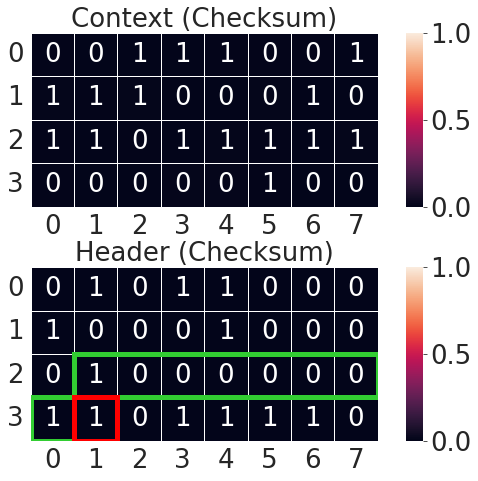

In [46]:
# Extract variables

if (MODE_DATASET == "checksum34"):
    mode_dataset = "Checksum"
else:
    mode_dataset = MODE_DATASET\
        .replace("_", " ")\
        .capitalize()
    
packet = arr_raw[index_packet]

if (index_packet >= LOOK_BACK_CONTEXT):
    context = arr_raw[index_packet-1]
else:
    context = np.zeros(packet.shape)
    
## Remove padding
if (LEFT_PADDING):
    packet = packet[LOOK_BACK_PACKET:]
    context = context[LOOK_BACK_PACKET:]
    
# Reshape packet and context
packet = packet.reshape((-1, 8))
context = context.reshape((-1, 8))

# Init figure
fig, axes = plt.subplots(
    2, 1, figsize=(10, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

# Functions to use
def highlight_cell(x, y, length=1, width=1,  ax=None, **kwargs):
    rect = plt.Rectangle(
        (x, y), length, width, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

# Plot context
sns.heatmap(arr_proba[:4, :], 
            annot=context, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[0],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})
cbar = axes[0].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[0].set_title(f"Context ({mode_dataset.capitalize()})", 
                  fontsize=TITLE_FONTSIZE)

# Plot packet
sns.heatmap(arr_proba[4: :], 
            annot=packet, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[1],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})

cbar = axes[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[1].set_title(f"Header ({mode_dataset.capitalize()})", 
                  fontsize=TITLE_FONTSIZE)

# Set sliding windows
highlight_cell(x=1, y=2, #x=4, y=1, 
               length=7, width=1,
               ax=axes[1], 
               color="limegreen", 
               linewidth=LINEWIDTH*1.25)
highlight_cell(x=0, y=3, #x=0, y=2, 
               length=1, width=1,
               ax=axes[1], 
               color="limegreen", 
               linewidth=LINEWIDTH*1.25)

# Set pixel to predict
highlight_cell(x=1, y=3, #x=4, y=2, 
               length=1, width=1,
               ax=axes[1], 
               color="red", 
               linewidth=LINEWIDTH*1.25)

# Set field name
for ax in axes.ravel():
    
    ax.tick_params(labelsize=TICK_FONTSIZE)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        
    # Rotation des label sur l'axe Y
    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(0)

### 4.8.5 Heatmap COMBINAISON

In [67]:
#############################################
# SET PARAMETERS
#############################################


RESULTS_DIR = "RESULTS/FIELDS/INTERPRETATION/PARTS/"
MODELS_DIR = "MODELS/INTERPRETATION/"
MAIN_DIR = "./DATA/"

# Set keras types
tf.keras.backend.set_floatx('float64')

# Context
LOOK_BACK_CONTEXT = 1 # On rajoute +1 car on prend le dernier paquet comme paquet à compresser...
LOOK_AHEAD_CONTEXT = 1 #TIMESTEPS
CONTEXT_SIZE = LOOK_BACK_CONTEXT # Nombre timesteps sur les contexts
CONTEXT_OUTPUT_SIZE = 30 # Size of contexte in model layer
# De preference < 128 car c'est la taille de la
# couche GRU avant

# Packet
LOOK_BACK_PACKET = 8
LOOK_AHEAD_PACKET = 1
NUM_SIN = 8
NUM_FEATS = NUM_SIN + 1

# Learning parameters
SHUFFLE = False # For test generator
ALPHABET_SIZE = 2
BATCH_SIZE = 1 # For test generator

# Size added to header_length IN BYTES
EXTRA_SIZE = 0
CUSTOM_SIZE = 100 # Take the lead if extra size is define
CHECKSUM = True # True = Keep Checksum

# For Occlusion Map
NUM_RANK_FIELDS = 32+8 # Num of rank used for occlusion
KEEP_POS = False # Keep Sinusoide as a field ?
QUANTITY_BATCH = None # Num of batch used in total 
# If None all batch in train set is used
START_IDX = 0
END_IDX = 500
RANGE_IDX = 2500

# Generated dataset parameters
MAX_PACKET_RANK = 3 # Max rank support for packet
NB_BITS = 16*2 # Multiple for field inversion
NB_ROWS = 4000*MAX_PACKET_RANK # Multiple for the flow id NB_ROWS = x * MAX_PACKET_RANK
MODE_DATASET = "combinaison" # "random", "checksum", "checksum34", "fixed", "inversion", 
                            # "counter", "fixed_flow", "combinaison"
LEFT_PADDING = True # Padding dataset


# Name
# min(LOOK_BACK_CONTEXT, CONTEXT_OUTPUT_SIZE) if CONTEXT_OUTPUT_SIZE == 0
# else LOOK_BACK_CONTEXT == 1 or 2 or 3 or 4...etc
# easy to set LOOK_BACK_CONTEXT == 0
FULL_NAME = f"LOSSLESS_CONTEXT{min(LOOK_BACK_CONTEXT, CONTEXT_OUTPUT_SIZE)}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}"


if (CHECKSUM):

    if (CUSTOM_SIZE is not None):
        EXT_NAME = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        EXT_NAME = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"

else:

    if (CUSTOM_SIZE is not None):
        EXT_NAME = f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}"
    else:
        EXT_NAME = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}"


# If padding on dataset
if (LEFT_PADDING):
    EXT_NAME += f"_LEFT_PADDING"


print(f"MODEL : {FULL_NAME}{EXT_NAME}")

# Set the Seed for numpy random choice
np.random.seed(42)

MODEL : LOSSLESS_CONTEXT1_PACKET8_SIN8_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_DATASETcombinaison_LEFT_PADDING


In [68]:
# PREPARE DATA





# For checksum AND combinaison !
# From : https://www.thegeekstuff.com/2012/05/ip-header-checksum/

def sum_checksum(
    array_bit_a, array_bit_b):
    
    # Array must have the same length
    assert len(array_bit_a) == len(array_bit_b)
    
    # Sum of array
    array_bit_sum = np.zeros(
        (len(array_bit_a)), dtype=int)
    
    # For addition
    carry = 0
    
    # For each bit
    for i in reversed(range(len(array_bit_a))):
        
        # Get value
        value_a = array_bit_a[i]
        value_b = array_bit_b[i]
        sum_value = value_a + value_b + carry
        
        # Apply sum
        if (sum_value == 0):
            carry = 0
            array_bit_sum[i] = 0
        elif (sum_value == 1):
            carry = 0
            array_bit_sum[i] = 1
        elif (sum_value == 2):
            carry = 1
            array_bit_sum[i] = 0
        elif (sum_value == 3):
            carry = 1
            array_bit_sum[i] = 1
            
    # If the result is above origianl length
    if (carry):
        array_bit_tmp = np.zeros(
            (len(array_bit_a)), dtype=int)
        array_bit_tmp[-1] = 1
        array_bit_sum = sum_checksum(
            array_bit_sum, array_bit_tmp)
            
    return array_bit_sum
    

def complement_chekcsum(array):
    array_complement = \
        (array - 1)*(-1)
    return array_complement

def checksum(array, size=8):
    
    # Check array size is above 
    # checksum field size
    assert array.size >= size
    
    # Reshape to good size
    multiple = array.size / size
    
    # multiple == 1 therefore array.size = size
    # So we add with 0 we need to pad
    if ((array.size % size == 0) and 
        (multiple != 1)):
        array_reshape = \
            array.reshape((-1, size))
    else:
        
        # Compute coeff and get 
        # missing bit
        if (multiple == 1):
            coeff = 2
        else:
            coeff = np.ceil(array.size / size)
            
        # Compute nb_bits
        nb_bit = int(coeff*size - array.size)
        
        # Add zeros for padding
        array_tmp = np.concatenate(
            (array, np.zeros((nb_bit,)))) 

        # Reshape array
        array_reshape = \
            array_tmp.reshape((-1, size))
        
    
    # For each bytes
    for i in range(
        0, array_reshape.shape[0], 2):
        
        # Get first value
        if (i == 0):
            array_bit_a = array_reshape[i]
            array_bit_b = array_reshape[i+1]
        else:
            array_bit_a = array_bit_sum
            array_bit_b = array_reshape[i]
        
        # Apply sum
        array_bit_sum = sum_checksum(
            array_bit_a=array_bit_a, 
            array_bit_b=array_bit_b)
        
    # Apply complement
    array_bit_checksum = \
        complement_chekcsum(
            array=array_bit_sum)
        
    return array_bit_checksum



## int_to_bin
def int_to_bin(x, size=8):
    val = str(bin(x))[2:]
    s = len(val)
    gap = size - s

    if (gap < 0):
        raise "Error size limit too short"
        #size = max(s, size)

    gap_val = '0'*gap
    return gap_val+val



# Generate with another seed ! (for evaluation)
# "random", "checksum", "fixed", "inversion", "counter"

if (MODE_DATASET == "random"):

    # Reset the seed
    np.random.seed(43)

    arr_raw = \
        np.random.randint(
            0, 2, size=(NB_ROWS, NB_BITS))


elif ("checksum" in MODE_DATASET):

    # Reset the seed
    np.random.seed(43)


    if (MODE_DATASET == "checksum34"):
        # Checksum over 3 bytes
        CHECKSUM_LENGTH = 8
        
        # Create array of int
        arr_raw = np.random.randint(
            0, 2, 
            size=(NB_ROWS, int(NB_BITS*(3/4))),
            dtype=int)
        
    else:
        # Checksum classic over 16 bits
        CHECKSUM_LENGTH = 16
        
        # Create array of int
        arr_raw = np.random.randint(
            0, 2, 
            size=(NB_ROWS, int(NB_BITS*(2/4))),
            dtype=int)


    # Compute checksum
    arr_checksums = np.apply_along_axis(
        checksum, axis=1, 
        size=CHECKSUM_LENGTH,
        arr=arr_raw)
    arr_checksums = arr_checksums.astype(int)

    # Concatenate array
    arr_raw = np.concatenate(
        (arr_raw, arr_checksums), 
        axis=1)
    arr_raw = arr_raw.astype(int)


elif (MODE_DATASET == "fixed"):

    arr_raw = \
        np.ones((NB_ROWS, NB_BITS))
    arr_raw = arr_raw * \
        np.random.randint(
            0, 2, size=(1, NB_BITS))


elif (MODE_DATASET == "inversion"):

    # Reset the seed
    np.random.seed(43)

    ## Define array
    arr_raw = \
        np.zeros((NB_ROWS, NB_BITS))

    ## For each flow define random values

    # For each flow
    for i in range(
        0, NB_ROWS, MAX_PACKET_RANK):
        
        arr_raw_tmp_a = \
            np.random.randint(
                0, 2, size=(1, int(NB_BITS/2)))
        arr_raw_tmp_b = \
            np.random.randint(
                0, 2, size=(1, int(NB_BITS/2)))
        
        for j in range(MAX_PACKET_RANK):
            
            # Invert for next round
            if (j % 2 == 0):
                arr_raw_tmp = np.concatenate(
                    (arr_raw_tmp_b, arr_raw_tmp_a), 
                    axis=1)
            else:
                arr_raw_tmp = np.concatenate(
                        (arr_raw_tmp_a, arr_raw_tmp_b), 
                        axis=1)
            
            # Set to array
            if (i+j < NB_ROWS):
                arr_raw[i+j, :] = arr_raw_tmp


elif (MODE_DATASET == "counter"):

    # Reset the seed
    np.random.seed(43)
    
    ## int_to_bin
    def int_to_bin(x, size=8):
        val = str(bin(x))[2:]
        s = len(val)
        gap = size - s
        
        if (gap < 0):
            raise "Error size limit too short"
            #size = max(s, size)
        
        gap_val = '0'*gap
        return gap_val+val


    ## Define array
    arr_raw = \
        np.zeros((NB_ROWS, NB_BITS))


    # For each flow
    for i in range(
        0, NB_ROWS, 
        MAX_PACKET_RANK):
        
        # Generate number
        value = \
            np.random.randint(
                0, (2**NB_BITS)-MAX_PACKET_RANK, 
                size=(1,))[0]
        
        # For each flow rank
        for j in range(
            MAX_PACKET_RANK):
        
            ## Convert number to binary
            value_bin = int_to_bin(
                value, size=NB_BITS)
        
            ## Create array from binary
            ## values
            value_bin_array = \
                [int(bit) for bit in value_bin]
            
            # Set to array
            if (i+j < NB_ROWS):
                arr_raw[i+j, :] = value_bin_array
            
            # Add + 1
            value = value + 1


elif (MODE_DATASET == "fixed_flow"):

    # Reset the seed
    np.random.seed(43)

    ## Define array
    arr_raw = \
        np.zeros((NB_ROWS, NB_BITS))


    ## For each flow define random values

    # For each flow
    for i in range(
        0, NB_ROWS, MAX_PACKET_RANK):

        arr_raw_tmp = \
            np.random.randint(
                0, 2, size=(1, NB_BITS))

        for j in range(MAX_PACKET_RANK):

            # Set to array
            if (i+j < NB_ROWS):
                arr_raw[i+j, :] = arr_raw_tmp


elif (MODE_DATASET == "combinaison"):

    # Checksum over 3 bytes
    CHECKSUM_LENGTH = 8

    ## Define array
    arr_raw = \
        np.zeros((NB_ROWS, NB_BITS))

    # Generate fixed values
    arr_raw_fixed_tmp = \
            np.random.randint(
                0, 2, size=(1, int(NB_BITS/8)))
    
    # Reset the seed
    np.random.seed(43)

    ## For each flow define random values

    # For each flow
    for i in range(
        0, NB_ROWS, MAX_PACKET_RANK):

        # Generate number for compteur
        value = \
            np.random.randint(
                0, (2**int(NB_BITS/4))-MAX_PACKET_RANK, 
                size=(1,))[0]

        #arr_raw_cmp_tmp = \
        #    np.random.randint(
        #        0, 2, size=(1, int(NB_BITS/4)))
        
        ## Generate fixed flow
        arr_raw_fixed_flow_tmp = \
            np.random.randint(
                0, 2, size=(1, int(NB_BITS/8)))

        for j in range(MAX_PACKET_RANK):

            ## Convert number to binary
            value_bin = int_to_bin(
                    value, size=int(NB_BITS/4))

            ## Create array from binary
            ## values
            value_bin_array = \
                [int(bit) for bit in value_bin]
            value_bin_array = \
                np.array(value_bin_array)\
                .reshape(-1, int(NB_BITS/4))

            # Set to array
            #if (i+j < NB_ROWS):
            #    arr_raw[i+j, :] = value_bin_array        

            # Generate random part
            arr_raw_random_tmp = \
                np.random.randint(
                    0, 2, size=(1, int(NB_BITS/4)))

            # Generate fixed et fixed flow

            ## Concat fixed bytes
            arr_raw_fixed_all_tmp = \
                np.concatenate(
                    (arr_raw_fixed_tmp, 
                     arr_raw_fixed_flow_tmp), 
                    axis=1)

            # Invert for next round
            if (j % 2 == 0):

                # Apply concatenation
                arr_raw_tmp = np.concatenate(
                    (arr_raw_random_tmp, 
                     arr_raw_fixed_all_tmp,
                     value_bin_array, #arr_raw_cmp_tmp
                    ), 
                    axis=1)

            else:

                # Apply concatenation
                arr_raw_tmp = np.concatenate(
                    (value_bin_array, #arr_raw_cmp_tmp,
                     arr_raw_fixed_all_tmp,
                     arr_raw_random_tmp), 
                    axis=1)

            #print("[DEBUG] arr_raw_tmp.shape: ", 
            #          arr_raw_tmp.shape)

            # Compute checkusm
            arr_raw_ckecksum_tmp = \
                np.apply_along_axis(
                    checksum, axis=1, 
                    size=CHECKSUM_LENGTH,
                    arr=arr_raw_tmp)

            #print("[DEBUG] arr_raw_ckecksum_tmp.shape: ", 
            #          arr_raw_ckecksum_tmp.shape)

            # Concat all bytes
            arr_raw_tmp = np.concatenate(
                (arr_raw_tmp, 
                 arr_raw_ckecksum_tmp), 
                axis=1)

            # Set to array
            if (i+j < NB_ROWS):
                arr_raw[i+j, :] = arr_raw_tmp

            # Add + 1
            value = value + 1

    # Convert to int
    arr_raw = arr_raw.astype(int)


# Print two lines to see similarity or not 
print("[DEBUG] arr_raw[:3]: ", arr_raw[:3])
print("[DEBUG] arr_raw.shape: ", arr_raw.shape)


# Add padding
if (LEFT_PADDING):

    arr_raw_padding = \
        np.zeros((NB_ROWS, LOOK_BACK_PACKET))

    arr_raw = np.concatenate(
        (arr_raw_padding, arr_raw), 
        axis=1)

[DEBUG] arr_raw[:3]:  [[0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0]
 [0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0]
 [1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0]]
[DEBUG] arr_raw.shape:  (12000, 32)


In [69]:
# DEFINE VARIABLES FOR GENERATOR



## Set packet_rank
packets_rank_tmp = np.arange(0, MAX_PACKET_RANK)
packets_rank = \
    np.repeat([packets_rank_tmp], 
              int(NB_ROWS/MAX_PACKET_RANK), axis=0).ravel()

## Set packets
packets = arr_raw

## Set headers 
if (LEFT_PADDING):
    headers_length = np.repeat(
        [(NB_BITS+LOOK_BACK_PACKET) / 8], 
        NB_ROWS, 
        axis=0)
else:
    headers_length = np.repeat(
        [NB_BITS/8], 
        NB_ROWS, 
        axis=0)

## Set max length
max_length = packets.shape[-1]

# Define block length
if (LEFT_PADDING):
    block_length = np.repeat(
        [NB_BITS], 
        NB_ROWS, axis=0)
else:
    block_length = np.repeat(
        [NB_BITS-LOOK_BACK_PACKET], 
        NB_ROWS, axis=0)

# Get the list of block
cumsum_block = np.cumsum(
    block_length)
max_block = cumsum_block.max()

# Set ranks for each packet
indexes_flow_packet = np.repeat(
    packets_rank, 
    (headers_length*8 - LOOK_BACK_PACKET).astype(int), axis=0)
    
# Set all indexes
list_IDs = np.arange(
    max_block, dtype=int)
indexes_packet = np.repeat(
    np.arange(0, block_length.size, dtype=int), 
    block_length, axis=0)

# Valuer du début de chaque bloc
#  de chaque paquet
cumsum_block_tmp = np.zeros(
    cumsum_block.size, dtype=int)
cumsum_block_tmp[1:] = cumsum_block[:-1]

indexes_block = np.repeat(
    cumsum_block_tmp, 
    block_length, axis=0)
indexes_block = list_IDs - indexes_block

In [70]:
# CREATE GENERATOR





# On shuffle pour etre sur que les adresses sont toutes couvertes
# étape de CHECK COVERAGE ne devitn plus nécessaire

idx = np.arange(0, list_IDs.size, dtype=int)
train_idx, val_idx, _, _ = sklearn.model_selection.train_test_split(
    idx, idx, random_state=42, 
    test_size=0.1, shuffle=SHUFFLE) # SHUFFLE

# indexes_flow_train_undersample

indexes_flow_packet_train = indexes_flow_packet[train_idx]
indexes_flow_packet_val = indexes_flow_packet[val_idx]

list_IDs_train = list_IDs[train_idx]
list_IDs_val = list_IDs[val_idx]

indexes_packet_train = indexes_packet[train_idx]
indexes_packet_val = indexes_packet[val_idx]

indexes_block_train = indexes_block[train_idx]
indexes_block_val = indexes_block[val_idx]

In [71]:
# LOAD MODEL




encoder_context = tf.keras.models.load_model(f"{MODELS_DIR}ENCODER_CONTEXT_{FULL_NAME}{EXT_NAME}.h5", 
                                              custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
ed_lossless = tf.keras.models.load_model(f"{MODELS_DIR}ED_{FULL_NAME}{EXT_NAME}.h5", 
                                          custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
embedder = tf.keras.models.load_model(f"{MODELS_DIR}EMBEDDER_{FULL_NAME}{EXT_NAME}.h5", 
                                      custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
model = CompressorLossless(encoder_context=encoder_context, 
                           ed_lossless=ed_lossless)

In [72]:
# SET PARAMETERS FOR OCCLUSION MAP




# Initialisation d'un array avec meme diension pour stocker :
# Le ranking de chaque field
columns_fields = [f"rank_{i}" for i in range(NUM_RANK_FIELDS)]
columns_probas = [f"proba_{i}" for i in range(NUM_RANK_FIELDS)]
df_fields = pd.DataFrame(
    columns=columns_fields+columns_probas)


# Get masks
block_length = int(LOOK_BACK_PACKET)
ctx_length = int(NB_BITS*LOOK_BACK_CONTEXT)    
pos_length = int(LOOK_BACK_PACKET)

total_length = int(block_length + \
    ctx_length + pos_length)
mask = np.eye(total_length)
idx_mask = np.arange(0, mask.shape[0])


# Batch to reach
if (QUANTITY_BATCH is None):
    QUANTITY_BATCH = int(list_IDs_train.size)
   
idx_batchs = np.arange(
    0, list_IDs_train.size) 
idx_batchs = np.random.choice(
    idx_batchs, QUANTITY_BATCH)

# Undersampling
indexes_flow_packet_train_undersample = \
    indexes_flow_packet_train#[idx_batchs]

list_IDs_train_undersample = \
    list_IDs_train#[idx_batchs]

indexes_packet_train_undersample = \
    indexes_packet_train#[idx_batchs]

indexes_block_train_undersample = \
    indexes_block_train#[idx_batchs]

In [73]:
# GENERATOR UPDATE pour prendre la notion d'index
# sans sequentialité !
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, 
                 list_IDs,
                 
                 look_back_context,
                 look_ahead_context,
                 look_back_packet,
                 look_ahead_packet,
                
                 packets_rank,
                 packets, 
                 headers_length,
                 max_length,
                 
                 indexes_packet,
                 indexes_block,
                 
                 left_padding=False,
                 batch_size=32,
                 num_sin=8,
                 alphabet_size=2, 
                 shuffle=True):
        'Initialization'
        self.left_padding = left_padding
        self.batch_size = batch_size
        # Liste des index des packets (peut etre que les vals ou trains...)
        self.list_IDs = list_IDs # Index de block !
        self.shuffle = shuffle
        self.on_epoch_end()
        
        # Identification data
        #self.flows_id = flows_id
        self.packets_rank = packets_rank
        self.packets = packets
        self.headers_length = headers_length
        
        # Parameters data
        self.num_sin = num_sin
        self.num_feats = self.num_sin + 1
        self.alphabet_size = alphabet_size
        self.max_length = max_length
        
        self.look_back_context = look_back_context
        self.look_ahead_context = look_ahead_context
        self.look_back_packet = look_back_packet
        self.look_ahead_packet = look_ahead_packet
        
        # Generation des indexes
        nb_batch_block_min = (((self.headers_length*8) - 
                              self.look_back_packet) // self.batch_size) * self.batch_size
        nb_batch_block_max = ((self.headers_length*8) - 
                             self.look_back_packet)
        nb_batch_block = np.maximum(nb_batch_block_min, nb_batch_block_max)
        self.indexes_max_packet = np.cumsum(nb_batch_block)
        self.indexes_min_packet = np.concatenate((np.zeros(1),
                                                  self.indexes_max_packet[0:-1]))
        self.indexes_max_packet = self.indexes_max_packet - 1
        
        # Indexes packet and block pre computed !
        self.indexes_packet = indexes_packet
        self.indexes_block = indexes_block
        
        # Generate sinusoide
        self.sin = np.empty((self.max_length, 0), dtype=np.float64)
        for j in range(1, self.num_sin+1):
            sin_tmp = self.__gen_sin(
                F=j, Fs=self.max_length, phi=0, A=1, 
                mean=0.5, period=j, center=0.5).reshape((self.max_length, 1))
            self.sin = np.concatenate((self.sin, sin_tmp), axis=-1)    
        self.sin_seq = create_windows(
            self.sin, window_shape=self.look_back_packet, 
            end_id=-self.look_ahead_packet)
        
        
    def __gen_sin(self, F, Fs, phi, A, mean, period, center):
        T = (1/F)*period # Period if 10/F = 10 cycles
        Ts = 1./Fs # Period sampling
        N = int(T/Ts) # Number of samples
        t = np.linspace(0, T, N)
        signal = A*np.sin(2*np.pi*F*t + phi) + center
        return signal

    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(
            (self.list_IDs.size /  self.batch_size)))

    
    # /!\ A adapter en fonction de la look_ahead_packet 
    # (par default on dit quel est a UN !)
    def __compute_batch_quantity(self, indexes_packet):
        #(self.headers_length[indexes_packet].sum() * 8)
        pkts_size = (self.headers_length[
            indexes_packet].sum() * 8)
        pkts_size_cut = pkts_size - \
            (indexes_packet.shape[0]*self.look_back_packet)
        return pkts_size_cut # / self.batch_size)
    

    def __getitem__(
        self, index):
        'Generate one batch of data'
        # On met à jour l'index avec le coté random !
        
        # Get index of block
        index_start = self.indexes[
            index] * self.batch_size
        index_end = index_start + self.batch_size
        
        # Get indexes packet and block
        indexes_packet = self.indexes_packet[
            index_start:index_end]
        indexes_block = self.indexes_block[
            index_start:index_end]
        
        # On prend le min et on ajoute !
        # On récupère les données
        ctx, pkt, y = self.__data_generation(
                indexes_packet, indexes_block)
        
        if (self.left_padding):
            return [ctx[:, :, self.look_back_packet:], pkt, y]
        else:
            return [ctx, pkt, y]

    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # On manipule des indexes de block !
        self.indexes = np.arange(
            np.floor(len(self.list_IDs)/self.batch_size)) \
            .astype(int)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def __get_context(
        self, indexes_packet):
        
        ctx = np.zeros(
            (indexes_packet.size, 
             self.look_back_context, 
             self.max_length))
        
        for i in range(ctx.shape[0]):
            rank = indexes_packet[i] #list_IDs[i]
            
            pad_size = max(0, self.look_back_context - \
                self.packets_rank[rank])
            
            pkt_size = self.look_back_context - \
                pad_size
            
            ctx_tmp = np.concatenate(
                    (np.zeros((pad_size, self.max_length)), 
                     self.packets[rank-pkt_size:rank]), axis=0)
            
            ctx_tmp = ctx_tmp.reshape(
                1, self.look_back_context, -1)
                
            ctx[i] = ctx_tmp
        
        # Repeat le contexte en fonction de la header length
        nbs_repeat = ((self.headers_length[indexes_packet]*8) - \
              self.look_back_packet).astype(int)
        ctx_seq = np.repeat(ctx, nbs_repeat, axis=0)
        
        return ctx_seq
    
    
    def __get_packet(self, 
                     indexes_packet, 
                     indexes_block):
        # En fonction de la taille de batch size il faut 
        # penser à recupere un ou plusieurs paquets !
        
        #nb_repeat = ((self.headers_length[indexes_packet]*8) - \
        #      self.look_back_packet).sum().astype(int) #[0]
        nb_repeat = indexes_block.size
        
        pkt_seq = np.zeros(
            (nb_repeat, self.look_back_packet, 
             self.num_feats))
        
        y_seq = np.zeros(
            (nb_repeat, self.alphabet_size))
        
        index_start = int(0)
        for idx_pkt, idx_block in zip(
            indexes_packet, indexes_block):
            
            idx_start = idx_block
            idx_end = idx_block + self.look_back_packet
            
            # Set packet
            pkt = self.packets[
                idx_pkt, :int(self.headers_length[idx_pkt]*8)]
            
            pkt_seq_tmp = pkt[idx_start:idx_end] \
                .reshape(-1, self.look_back_packet, 1)
            
            y_seq_tmp = pkt[idx_end]
            y_seq_tmp = tf.keras.utils.to_categorical(
                y=y_seq_tmp.ravel(), 
                num_classes=self.alphabet_size, 
                dtype='float64')
            
            # Set to packet sequence
            pkt_seq[index_start:index_start+1, :, 0:1] = pkt_seq_tmp
            pkt_seq[index_start:index_start+1, :, 1:] = self.sin_seq[
                idx_start:idx_start+1]
            y_seq[index_start:index_start+1] = y_seq_tmp
            
            index_start += 1
            
        return pkt_seq, y_seq

    
    def __data_generation(
        self, indexes_packet, indexes_block):
        'Generates data containing batch_size samples'      
        # Initialization
        ctx = self.__get_context(
            indexes_packet)
        
        pkt, y = self.__get_packet(
            indexes_packet, indexes_block) # On shuffle les packet et target
        
        # Correct context shape
        ctx = ctx[:pkt.shape[0]]
        
        # On prend des bloque alétoire parmis les paquet
        # pas forcement les blocks selectionné...
        # Moins propre mais + simple...
        indexes = np.arange(0, pkt.shape[0])\
                    .astype(int)
        
        # Shuffle to avoid to always keep the last block non learned !
        ctx = ctx[indexes]
        pkt = pkt[indexes]
        y = y[indexes]
        
        return ctx, pkt, y

In [74]:
# SET GENERATOR





# Set parameters
params = {'look_back_context': LOOK_BACK_CONTEXT,
          'look_ahead_context': LOOK_AHEAD_CONTEXT, # Par default on ne sais qu'avec 1
          'look_back_packet': LOOK_BACK_PACKET,
          'look_ahead_packet': LOOK_AHEAD_PACKET, # Par default on ne sais qu'avec 1
         
          'packets_rank': packets_rank,
          'packets': packets,
          'headers_length': headers_length,
          'max_length': max_length,
         
          'left_padding': LEFT_PADDING,
          'batch_size': 1, #BATCH_SIZE,
          'num_sin': NUM_SIN,
          'alphabet_size': ALPHABET_SIZE, 
          'shuffle': False} # SHUFFLE

# Generators
generator = DataGenerator(
    list_IDs=list_IDs_train_undersample,
    indexes_packet=indexes_packet_train_undersample,
    indexes_block=indexes_block_train_undersample,
    **params)

In [75]:
# APPLY OCCLUSION MAP



indexes = range(list_IDs_train_undersample.size)


# On parcours chaque batch ()
for i, ID, idx_pkt, idx_block, idx_flow_pkt in zip(
        indexes[START_IDX:END_IDX],
        list_IDs_train_undersample[START_IDX:END_IDX],
        indexes_packet_train_undersample[START_IDX:END_IDX],
        indexes_block_train_undersample[START_IDX:END_IDX],
        indexes_flow_packet_train_undersample[START_IDX:END_IDX]):

    # Mettre comme index de l'array le get item !
    ctx_seq, pkt_sin_seq, y_seq = generator.__getitem__(
        index=i)
    
    # Make standard prediction
    prob_normal = model.predict([ctx_seq,
                                 pkt_sin_seq,
                                 np.zeros((pkt_sin_seq.shape[0], 2))], batch_size=1)

    # Apply mask
    ## Re arange data
    ctx_seq_ravel = ctx_seq.ravel().reshape(1, -1)
    pkt_seq_ravel = pkt_sin_seq[:, :, 0].ravel().reshape(1, -1)
    sin_seq = pkt_sin_seq[:, :, 1:] #.ravel()
    y_seq_ravel = y_seq.ravel().reshape(1, -1)
    
    ## Apply mask
    idx_start = 0
    idx_end = ctx_seq_ravel.shape[-1]
    mask_ctx_seq = mask[:, idx_start:idx_end]
    idx_mask_ctx_seq_xaxis = idx_mask[idx_start:idx_end]
    
    #print("[DEBUG] idx_start: ", idx_start)
    #print("[DEBUG] idx_end: ", idx_end)
    #print("[DEBUG] mask.shape: ", mask.shape)
    #print("[DEBUG] mask_ctx_seq.shape: ", mask_ctx_seq.shape)

    
    idx_start = ctx_seq_ravel.shape[-1]
    idx_end = ctx_seq_ravel.shape[-1] + pkt_seq_ravel.shape[-1]
    mask_pkt_seq = mask[:, idx_start:idx_end]
    idx_mask_pkt_seq_xaxis = idx_mask[idx_start:idx_end]
    

    idx_start = ctx_seq_ravel.shape[-1]+pkt_seq_ravel.shape[-1]
    idx_end = ctx_seq_ravel.shape[-1] + \
        pkt_seq_ravel.shape[-1]+sin_seq.shape[1]
    mask_sin_seq_exp_dims = np.expand_dims(
        mask[:, idx_start:idx_end], axis=-1)
    mask_sin_seq = np.repeat(mask_sin_seq_exp_dims,
        repeats=sin_seq.shape[-1], axis=-1)
    idx_mask_sin_seq_xaxis = idx_mask[idx_start:idx_end]
    
    
    # Repeat array size
    ctx_seq_ravel_repeat = np.repeat(ctx_seq_ravel,
                                     repeats=mask_ctx_seq.shape[0],
                                     axis=0)
    pkt_seq_ravel_repeat = np.repeat(pkt_seq_ravel,
                                     repeats=mask_pkt_seq.shape[0],
                                     axis=0)
    sin_seq_ravel_repeat = np.repeat(sin_seq,
                                     repeats=mask_sin_seq.shape[0],
                                     axis=0)

    idx_mask_ctx_seq_yaxis = idx_mask_ctx_seq_xaxis - \
            idx_mask_ctx_seq_xaxis.min()
    idx_mask_pkt_seq_yaxis = idx_mask_pkt_seq_xaxis - \
            idx_mask_pkt_seq_xaxis.min()
    idx_mask_sin_seq_yaxis = idx_mask_sin_seq_xaxis - \
            idx_mask_sin_seq_xaxis.min()

    # Invertion des bits
    ctx_seq_ravel_repeat[idx_mask_ctx_seq_xaxis, idx_mask_ctx_seq_yaxis] = ctx_seq_ravel_repeat[
        idx_mask_ctx_seq_xaxis, idx_mask_ctx_seq_yaxis]*(-1) + 1
    pkt_seq_ravel_repeat[idx_mask_pkt_seq_xaxis, idx_mask_pkt_seq_yaxis] = pkt_seq_ravel_repeat[
        idx_mask_pkt_seq_xaxis, idx_mask_pkt_seq_yaxis]*(-1) + 1
    # On supprime pas d'invertion !
    sin_seq_ravel_repeat[idx_mask_sin_seq_xaxis, idx_mask_sin_seq_yaxis] = 0
    
    
    ## Re arange data
    ctx_seq_shape = (ctx_seq_ravel_repeat.shape[0],
                     *ctx_seq.shape[1:])
    ctx_seq_masked = ctx_seq_ravel_repeat.reshape(
        ctx_seq_shape)
    pkt_sin_seq_masked = np.concatenate(
        (np.expand_dims(pkt_seq_ravel_repeat, axis=-1),
         sin_seq_ravel_repeat), axis=-1)

    # Make new prediction
    prob_masked = model.predict([ctx_seq_masked,
                                 pkt_sin_seq_masked,
                                 np.zeros((pkt_sin_seq_masked.shape[0], 2))], batch_size=1)
    

    # Compute difference with proba normale
    diffs_proba = np.abs(
        prob_normal - prob_masked)
    
    # Déterminer le ranks des champs ayant le plus d'impact
    # On supprime les infos de positions car on sait
    # qu'elles sont importantes ! (i.e les sinusoide)
    pos_index_mask = []
    if (not KEEP_POS):
        idx_start = ctx_seq_ravel.shape[-1] + pkt_seq_ravel.shape[-1]
        idx_end = ctx_seq_ravel.shape[-1] + \
            pkt_seq_ravel.shape[-1]+sin_seq.shape[1]
        diffs_proba[idx_start:idx_end] = 0
        pos_index_mask = np.arange(idx_start, idx_end).tolist()
        
        #print("[DEBUG] diffs_proba BEFORE : ", diffs_proba)
        #print("[DEBUG] pos_index_mask: ", pos_index_mask)
        
        # Remove position from diff proba
        mask_diff_proba = np.ones(
            diffs_proba.shape[0], np.bool)
        mask_diff_proba[pos_index_mask] = 0
        diffs_proba = diffs_proba[mask_diff_proba]
        
        
    indexes_sort = np.argsort(
        diffs_proba[:, 0], axis=0)[-NUM_RANK_FIELDS:][::-1]    
    rank_diffs_proba = indexes_sort
    list_proba_0 = diffs_proba[indexes_sort, 0].ravel()
    
    # Save to dataframe
    df_fields.loc[i, 'pred_true'] = np.argmax(y_seq).astype(np.uint8)
    df_fields.loc[i, 'pred_pred'] = np.argmax(prob_normal).astype(np.uint8)
    df_fields.loc[i, columns_fields] = rank_diffs_proba 
    df_fields.loc[i, columns_probas] = list_proba_0.astype(np.float16)
    df_fields.loc[i, 'list_IDs'] = int(ID)
    df_fields.loc[i, 'index_packet'] = int(idx_pkt)
    df_fields.loc[i, 'index_flow_packet'] = int(idx_flow_pkt)
    df_fields.loc[i, 'index_block'] = int(idx_block)

In [76]:
# SELECT A PACKET


# index_packet to use
index_packet = 1

cond = (df_fields["index_packet"] == index_packet)
df_fields = \
    df_fields[cond].reset_index(drop=True)

In [77]:
# EXTRACT ALL PROBA



# Init col

cols_rank = [f"rank_{i}" for i in range(NUM_RANK_FIELDS)]
cols_proba = [f"proba_{i}" for i in range(NUM_RANK_FIELDS)]

# Generate dict of index
# for each index packet


unique_index_packet = \
    df_fields["index_flow_packet"]\
        .value_counts().index
dict_index_packet = {}
for i in unique_index_packet:
    
    dict_rank_proba = {}
    
    if (LEFT_PADDING):
        for j in range(
            (NB_BITS*LOOK_BACK_CONTEXT)+LOOK_BACK_PACKET+NB_BITS):
            dict_rank_proba[j] = []
    else:
        for j in range(
            (NB_BITS*LOOK_BACK_CONTEXT)+NB_BITS):
            dict_rank_proba[j] = []
    
    # Set dict to index
    dict_index_packet[i] = dict_rank_proba

# For each index packet

unique_index_packet = \
    df_fields["index_flow_packet"]\
        .value_counts().index
for idx_pkt in unique_index_packet:
    
    # Select index packet
    cond_idx_pkt = \
        (df_fields["index_flow_packet"] == idx_pkt)
    df_fields_tmp = df_fields[cond_idx_pkt]
    
    # For each proba rank
    for idx_df_fields in \
        range(df_fields_tmp.index.shape[0]):
        
        
        # Get fields and index block
        fields = df_fields[cols_rank]\
            .iloc[idx_df_fields]\
            .values
        index_block = df_fields["index_block"]\
            .iloc[idx_df_fields]
        
        #print("")
        #print("[DEBUG] fields BEFORE: ", fields)
        #print("[DEBUG] idx_df_fields: ", idx_df_fields)
        #print("[DEBUG] index_block: ", index_block)
        
        # Correst fields to get absolute postion
        def swenzel(a, val_old, val_new):
            return val_new[np.searchsorted(val_old,a)]
        
        val_old = np.arange(
            0, fields.shape[0]) 
        
        if (LEFT_PADDING):
            val_new = np.concatenate(
                (np.arange(0, NB_BITS),
                (np.arange(NB_BITS, 
                           fields.shape[0])))
            )
            #print("")
            #print("[DEBUG] val_new BEFORE : ", val_new)
            
            #print("")
            #print("[DEBUG][if(LEFT_PADDING)] index_block: ",
            #     index_block)
            #print("[DEBUG][if(LEFT_PADDING)] index_block - (LOOK_BACK_PACKET - 1): ",
            #     index_block - (LOOK_BACK_PACKET - 1))
            
            #if (index_block >= (LOOK_BACK_PACKET - 1)):
                
            val_new[NB_BITS:] = val_new[NB_BITS:] + \
                index_block #- (LOOK_BACK_PACKET - 1)
                
            #print("[DEBUG] val_new IN IF : ", val_new)

            fields = swenzel(
                fields, val_old, val_new)
        
        #print("[DEBUG] fields AFTER: ", fields.astype(int))
        
        # RESULTS:
        # 32 bits context vector + 32 bits data vector 
        # (good position inside)
        
        probas = df_fields_tmp[cols_proba]\
            .iloc[idx_df_fields]\
            .values
        
        # Add dict and proba
        for field, proba in zip(fields, probas):
            dict_index_packet[idx_pkt][field].append(proba)
    

#### 4.8.5.1 Heatmap COMBINAISON (Compteur)

In [78]:
# EXTRACT FOR ONE BLOCK



bit_rank = 6 #10 # > LOOK_BACK_PACKET for simplicity... => START FROM 0 !
size_context = 1

# Get nb rank bits
nb_ranks = int(np.sqrt(
    NB_BITS*LOOK_BACK_CONTEXT+NB_BITS))

# Save proba
context_proba = []
packet_proba = []
window_proba = []
#arr_proba = np.zeros((nb_ranks, nb_ranks)) \
#            .ravel()
#if (LEFT_PADDING):
#    arr_proba = np.zeros(
#        (NB_BITS*LOOK_BACK_CONTEXT+NB_BITS+LOOK_BACK_PACKET,))
#else:
arr_proba = np.zeros(
    (NB_BITS*LOOK_BACK_CONTEXT+NB_BITS,))

# Compteur for window
cmp_window = LOOK_BACK_PACKET

for key, value in dict_index_packet[
    size_context].items():
    
    # Get proba for context
    if (key < (NB_BITS*LOOK_BACK_CONTEXT)):
    
        # Extract value rank
        val_tmp = value[bit_rank]
        context_proba.append(val_tmp)
    
    # Get proba inside window
    elif ((key >= (NB_BITS*LOOK_BACK_CONTEXT) + max(0, (bit_rank-LOOK_BACK_PACKET))) and
          (key < (NB_BITS*LOOK_BACK_CONTEXT) + bit_rank)):
        
        # First bit equal to 0 (padding bit) in case of LEFT_PADDING
        if ((key >= (NB_BITS*LOOK_BACK_CONTEXT)) and 
            (key < (NB_BITS*LOOK_BACK_CONTEXT + LOOK_BACK_PACKET))):
            
            # Add proba
            val_tmp = value[
                max(0, (bit_rank-LOOK_BACK_PACKET))]
            window_proba.append(val_tmp) 
            
        else:
        
            # Update compteur
            cmp_window -= 1

            # Add proba
            val_tmp = value[cmp_window]
            window_proba.append(val_tmp) 

# Set context
idx_start = 0
idx_end = NB_BITS*LOOK_BACK_CONTEXT
arr_proba[idx_start:idx_end] = context_proba

# Set context
idx_start = (NB_BITS*LOOK_BACK_CONTEXT) + \
    max(0, (bit_rank-LOOK_BACK_PACKET))
idx_end = (NB_BITS*LOOK_BACK_CONTEXT) + bit_rank
arr_proba[idx_start:idx_end] = window_proba

# Remove padding part
'''if (LEFT_PADDING):
    arr_proba = np.concatenate(
        (arr_proba[:(NB_BITS*LOOK_BACK_CONTEXT)],
         arr_proba[(NB_BITS*LOOK_BACK_CONTEXT)+LOOK_BACK_PACKET:]))'''

# Reshape proba array
arr_proba = arr_proba.reshape((nb_ranks, nb_ranks))

# Normalize proba array
#arr_proba = (arr_proba - arr_proba.min()) / (arr_proba.max() - arr_proba.min())

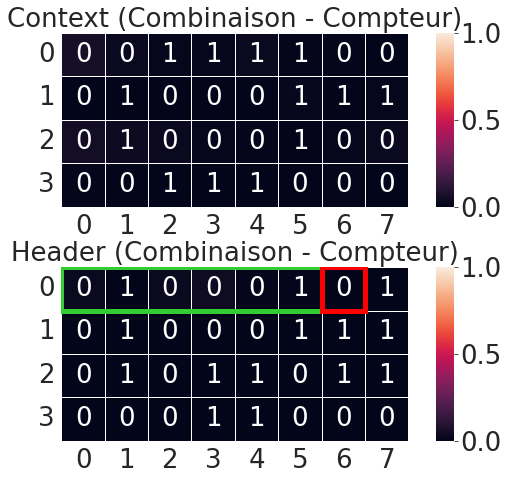

In [79]:
# Extract variables

if (MODE_DATASET == "checksum34"):
    mode_dataset = "Checksum"
else:
    mode_dataset = MODE_DATASET\
        .replace("_", " ")\
        .capitalize()
    
packet = arr_raw[index_packet]

if (index_packet >= LOOK_BACK_CONTEXT):
    context = arr_raw[index_packet-1]
else:
    context = np.zeros(packet.shape)
    
## Remove padding
if (LEFT_PADDING):
    packet = packet[LOOK_BACK_PACKET:]
    context = context[LOOK_BACK_PACKET:]
    
# Reshape packet and context
packet = packet.reshape((-1, 8))
context = context.reshape((-1, 8))

# Init figure
fig, axes = plt.subplots(
    2, 1, figsize=(10, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

# Functions to use
def highlight_cell(x, y, length=1, width=1,  ax=None, **kwargs):
    rect = plt.Rectangle(
        (x, y), length, width, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

# Plot context
sns.heatmap(arr_proba[:4, :], 
            annot=context, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[0],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})
cbar = axes[0].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[0].set_title(f"Context ({mode_dataset.capitalize()} - Compteur)", 
                  fontsize=TITLE_FONTSIZE)

# Plot packet
sns.heatmap(arr_proba[4: :], 
            annot=packet, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[1],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})

cbar = axes[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[1].set_title(f"Header ({mode_dataset.capitalize()} - Compteur)", 
                  fontsize=TITLE_FONTSIZE)

# Set sliding windows
highlight_cell(x=0, y=0, #x=4, y=1, 
               length=6, width=1,
               ax=axes[1], 
               color="limegreen", 
               linewidth=LINEWIDTH*1.25)
'''highlight_cell(x=0, y=3, #x=0, y=2, 
               length=1, width=1,
               ax=axes[1], 
               color="limegreen", 
               linewidth=LINEWIDTH*1.25)'''

# Set pixel to predict
highlight_cell(x=6, y=0, #x=4, y=2, 
               length=1, width=1,
               ax=axes[1], 
               color="red", 
               linewidth=LINEWIDTH*1.25)

# Set field name
for ax in axes.ravel():
    
    ax.tick_params(labelsize=TICK_FONTSIZE)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        
    # Rotation des label sur l'axe Y
    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(0)

#### 4.8.5.2 Heatmap COMBINAISON (Fixed)

In [80]:
# EXTRACT FOR ONE BLOCK



bit_rank = 10 #10 # > LOOK_BACK_PACKET for simplicity... => START FROM 0 !
size_context = 1

# Get nb rank bits
nb_ranks = int(np.sqrt(
    NB_BITS*LOOK_BACK_CONTEXT+NB_BITS))

# Save proba
context_proba = []
packet_proba = []
window_proba = []
#arr_proba = np.zeros((nb_ranks, nb_ranks)) \
#            .ravel()
#if (LEFT_PADDING):
#    arr_proba = np.zeros(
#        (NB_BITS*LOOK_BACK_CONTEXT+NB_BITS+LOOK_BACK_PACKET,))
#else:
arr_proba = np.zeros(
    (NB_BITS*LOOK_BACK_CONTEXT+NB_BITS,))

# Compteur for window
cmp_window = LOOK_BACK_PACKET

for key, value in dict_index_packet[
    size_context].items():
    
    # Get proba for context
    if (key < (NB_BITS*LOOK_BACK_CONTEXT)):
    
        # Extract value rank
        val_tmp = value[bit_rank]
        context_proba.append(val_tmp)
    
    # Get proba inside window
    elif ((key >= (NB_BITS*LOOK_BACK_CONTEXT) + max(0, (bit_rank-LOOK_BACK_PACKET))) and
          (key < (NB_BITS*LOOK_BACK_CONTEXT) + bit_rank)):
        
        # First bit equal to 0 (padding bit) in case of LEFT_PADDING
        if ((key >= (NB_BITS*LOOK_BACK_CONTEXT)) and 
            (key < (NB_BITS*LOOK_BACK_CONTEXT + LOOK_BACK_PACKET))):
            
            # Add proba
            val_tmp = value[
                max(0, (bit_rank-LOOK_BACK_PACKET))]
            window_proba.append(val_tmp) 
            
        else:
        
            # Update compteur
            cmp_window -= 1

            # Add proba
            val_tmp = value[cmp_window]
            window_proba.append(val_tmp) 

# Set context
idx_start = 0
idx_end = NB_BITS*LOOK_BACK_CONTEXT
arr_proba[idx_start:idx_end] = context_proba

# Set context
idx_start = (NB_BITS*LOOK_BACK_CONTEXT) + \
    max(0, (bit_rank-LOOK_BACK_PACKET))
idx_end = (NB_BITS*LOOK_BACK_CONTEXT) + bit_rank
arr_proba[idx_start:idx_end] = window_proba

# Remove padding part
'''if (LEFT_PADDING):
    arr_proba = np.concatenate(
        (arr_proba[:(NB_BITS*LOOK_BACK_CONTEXT)],
         arr_proba[(NB_BITS*LOOK_BACK_CONTEXT)+LOOK_BACK_PACKET:]))'''

# Reshape proba array
arr_proba = arr_proba.reshape((nb_ranks, nb_ranks))

# Normalize proba array
#arr_proba = (arr_proba - arr_proba.min()) / (arr_proba.max() - arr_proba.min())

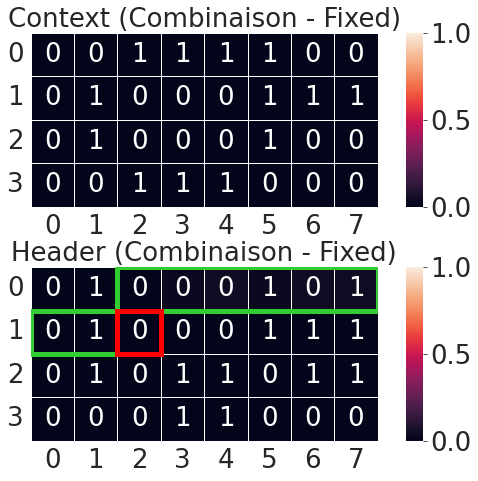

In [81]:
# Extract variables



if (MODE_DATASET == "checksum34"):
    mode_dataset = "Checksum"
else:
    mode_dataset = MODE_DATASET\
        .replace("_", " ")\
        .capitalize()
    
packet = arr_raw[index_packet]

if (index_packet >= LOOK_BACK_CONTEXT):
    context = arr_raw[index_packet-1]
else:
    context = np.zeros(packet.shape)
    
## Remove padding
if (LEFT_PADDING):
    packet = packet[LOOK_BACK_PACKET:]
    context = context[LOOK_BACK_PACKET:]
    
# Reshape packet and context
packet = packet.reshape((-1, 8))
context = context.reshape((-1, 8))

# Init figure
fig, axes = plt.subplots(
    2, 1, figsize=(10, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

# Functions to use
def highlight_cell(x, y, length=1, width=1,  ax=None, **kwargs):
    rect = plt.Rectangle(
        (x, y), length, width, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

# Plot context
sns.heatmap(arr_proba[:4, :], 
            annot=context, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[0],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})
cbar = axes[0].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[0].set_title(f"Context ({mode_dataset.capitalize()} - Fixed)", 
                  fontsize=TITLE_FONTSIZE)

# Plot packet
sns.heatmap(arr_proba[4: :], 
            annot=packet, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[1],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})

cbar = axes[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[1].set_title(f"Header ({mode_dataset.capitalize()} - Fixed)", 
                  fontsize=TITLE_FONTSIZE)

# Set sliding windows
highlight_cell(x=2, y=0, #x=4, y=1, 
               length=6, width=1,
               ax=axes[1], 
               color="limegreen", 
               linewidth=LINEWIDTH*1.25)
highlight_cell(x=0, y=1, #x=0, y=2, 
               length=2, width=1,
               ax=axes[1], 
               color="limegreen", 
               linewidth=LINEWIDTH*1.25)

# Set pixel to predict
highlight_cell(x=2, y=1, #x=4, y=2, 
               length=1, width=1,
               ax=axes[1], 
               color="red", 
               linewidth=LINEWIDTH*1.25)

# Set field name
for ax in axes.ravel():
    
    ax.tick_params(labelsize=TICK_FONTSIZE)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        
    # Rotation des label sur l'axe Y
    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(0)

#### 4.8.5.3 Heatmap COMBINAISON (Fixed Flow)

In [82]:
# EXTRACT FOR ONE BLOCK



bit_rank = 14 #10 # > LOOK_BACK_PACKET for simplicity... => START FROM 0 !
size_context = 1

# Get nb rank bits
nb_ranks = int(np.sqrt(
    NB_BITS*LOOK_BACK_CONTEXT+NB_BITS))

# Save proba
context_proba = []
packet_proba = []
window_proba = []
#arr_proba = np.zeros((nb_ranks, nb_ranks)) \
#            .ravel()
#if (LEFT_PADDING):
#    arr_proba = np.zeros(
#        (NB_BITS*LOOK_BACK_CONTEXT+NB_BITS+LOOK_BACK_PACKET,))
#else:
arr_proba = np.zeros(
    (NB_BITS*LOOK_BACK_CONTEXT+NB_BITS,))

# Compteur for window
cmp_window = LOOK_BACK_PACKET

for key, value in dict_index_packet[
    size_context].items():
    
    # Get proba for context
    if (key < (NB_BITS*LOOK_BACK_CONTEXT)):
    
        # Extract value rank
        val_tmp = value[bit_rank]
        context_proba.append(val_tmp)
    
    # Get proba inside window
    elif ((key >= (NB_BITS*LOOK_BACK_CONTEXT) + max(0, (bit_rank-LOOK_BACK_PACKET))) and
          (key < (NB_BITS*LOOK_BACK_CONTEXT) + bit_rank)):
        
        # First bit equal to 0 (padding bit) in case of LEFT_PADDING
        if ((key >= (NB_BITS*LOOK_BACK_CONTEXT)) and 
            (key < (NB_BITS*LOOK_BACK_CONTEXT + LOOK_BACK_PACKET))):
            
            # Add proba
            val_tmp = value[
                max(0, (bit_rank-LOOK_BACK_PACKET))]
            window_proba.append(val_tmp) 
            
        else:
        
            # Update compteur
            cmp_window -= 1

            # Add proba
            val_tmp = value[cmp_window]
            window_proba.append(val_tmp) 

# Set context
idx_start = 0
idx_end = NB_BITS*LOOK_BACK_CONTEXT
arr_proba[idx_start:idx_end] = context_proba

# Set context
idx_start = (NB_BITS*LOOK_BACK_CONTEXT) + \
    max(0, (bit_rank-LOOK_BACK_PACKET))
idx_end = (NB_BITS*LOOK_BACK_CONTEXT) + bit_rank
arr_proba[idx_start:idx_end] = window_proba

# Remove padding part
'''if (LEFT_PADDING):
    arr_proba = np.concatenate(
        (arr_proba[:(NB_BITS*LOOK_BACK_CONTEXT)],
         arr_proba[(NB_BITS*LOOK_BACK_CONTEXT)+LOOK_BACK_PACKET:]))'''

# Reshape proba array
arr_proba = arr_proba.reshape((nb_ranks, nb_ranks))

# Normalize proba array
#arr_proba = (arr_proba - arr_proba.min()) / (arr_proba.max() - arr_proba.min())

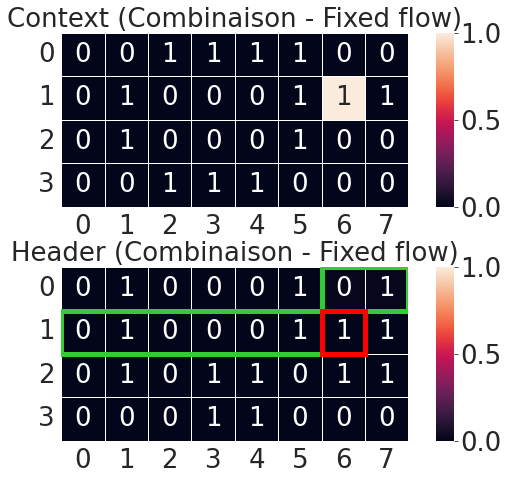

In [83]:
# Extract variables

if (MODE_DATASET == "checksum34"):
    mode_dataset = "Checksum"
else:
    mode_dataset = MODE_DATASET\
        .replace("_", " ")\
        .capitalize()
    
packet = arr_raw[index_packet]

if (index_packet >= LOOK_BACK_CONTEXT):
    context = arr_raw[index_packet-1]
else:
    context = np.zeros(packet.shape)
    
## Remove padding
if (LEFT_PADDING):
    packet = packet[LOOK_BACK_PACKET:]
    context = context[LOOK_BACK_PACKET:]
    
# Reshape packet and context
packet = packet.reshape((-1, 8))
context = context.reshape((-1, 8))

# Init figure
fig, axes = plt.subplots(
    2, 1, figsize=(10, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

# Functions to use
def highlight_cell(x, y, length=1, width=1,  ax=None, **kwargs):
    rect = plt.Rectangle(
        (x, y), length, width, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

# Plot context
sns.heatmap(arr_proba[:4, :], 
            annot=context, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[0],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})
cbar = axes[0].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[0].set_title(f"Context ({mode_dataset.capitalize()} - Fixed flow)", 
                  fontsize=TITLE_FONTSIZE)

# Plot packet
sns.heatmap(arr_proba[4: :], 
            annot=packet, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[1],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})

cbar = axes[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[1].set_title(f"Header ({mode_dataset.capitalize()} - Fixed flow)", 
                  fontsize=TITLE_FONTSIZE)

# Set sliding windows
highlight_cell(x=6, y=0, #x=4, y=1, 
               length=2, width=1,
               ax=axes[1], 
               color="limegreen", 
               linewidth=LINEWIDTH*1.25)
highlight_cell(x=0, y=1, #x=0, y=2, 
               length=6, width=1,
               ax=axes[1], 
               color="limegreen", 
               linewidth=LINEWIDTH*1.25)

# Set pixel to predict
highlight_cell(x=6, y=1, #x=4, y=2, 
               length=1, width=1,
               ax=axes[1], 
               color="red", 
               linewidth=LINEWIDTH*1.25)

# Set field name
for ax in axes.ravel():
    
    ax.tick_params(labelsize=TICK_FONTSIZE)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        
    # Rotation des label sur l'axe Y
    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(0)

#### 4.8.5.4 Heatmap COMBINAISON (Random)

In [156]:
# EXTRACT FOR ONE BLOCK



bit_rank = 22 #10 # > LOOK_BACK_PACKET for simplicity... => START FROM 0 !
size_context = 1

# Get nb rank bits
nb_ranks = int(np.sqrt(
    NB_BITS*LOOK_BACK_CONTEXT+NB_BITS))

# Save proba
context_proba = []
packet_proba = []
window_proba = []
#arr_proba = np.zeros((nb_ranks, nb_ranks)) \
#            .ravel()
#if (LEFT_PADDING):
#    arr_proba = np.zeros(
#        (NB_BITS*LOOK_BACK_CONTEXT+NB_BITS+LOOK_BACK_PACKET,))
#else:
arr_proba = np.zeros(
    (NB_BITS*LOOK_BACK_CONTEXT+NB_BITS,))

# Compteur for window
cmp_window = LOOK_BACK_PACKET

for key, value in dict_index_packet[
    size_context].items():
    
    # Get proba for context
    if (key < (NB_BITS*LOOK_BACK_CONTEXT)):
    
        # Extract value rank
        val_tmp = value[bit_rank]
        context_proba.append(val_tmp)
    
    # Get proba inside window
    elif ((key >= (NB_BITS*LOOK_BACK_CONTEXT) + max(0, (bit_rank-LOOK_BACK_PACKET))) and
          (key < (NB_BITS*LOOK_BACK_CONTEXT) + bit_rank)):
        
        # First bit equal to 0 (padding bit) in case of LEFT_PADDING
        if ((key >= (NB_BITS*LOOK_BACK_CONTEXT)) and 
            (key < (NB_BITS*LOOK_BACK_CONTEXT + LOOK_BACK_PACKET))):
            
            # Add proba
            val_tmp = value[
                max(0, (bit_rank-LOOK_BACK_PACKET))]
            window_proba.append(val_tmp) 
            
        else:
        
            # Update compteur
            cmp_window -= 1

            # Add proba
            val_tmp = value[cmp_window]
            window_proba.append(val_tmp) 

# Set context
idx_start = 0
idx_end = NB_BITS*LOOK_BACK_CONTEXT
arr_proba[idx_start:idx_end] = context_proba

# Set context
idx_start = (NB_BITS*LOOK_BACK_CONTEXT) + \
    max(0, (bit_rank-LOOK_BACK_PACKET))
idx_end = (NB_BITS*LOOK_BACK_CONTEXT) + bit_rank
arr_proba[idx_start:idx_end] = window_proba

# Remove padding part
'''if (LEFT_PADDING):
    arr_proba = np.concatenate(
        (arr_proba[:(NB_BITS*LOOK_BACK_CONTEXT)],
         arr_proba[(NB_BITS*LOOK_BACK_CONTEXT)+LOOK_BACK_PACKET:]))'''

# Reshape proba array
arr_proba = arr_proba.reshape((nb_ranks, nb_ranks))

# Normalize proba array
#arr_proba = (arr_proba - arr_proba.min()) / (arr_proba.max() - arr_proba.min())

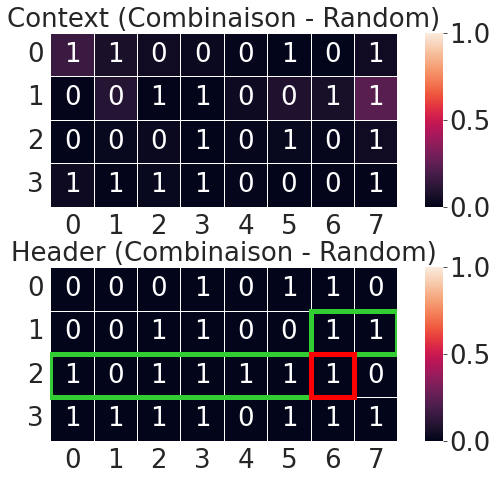

In [157]:
# Extract variables



if (MODE_DATASET == "checksum34"):
    mode_dataset = "Checksum"
else:
    mode_dataset = MODE_DATASET\
        .replace("_", " ")\
        .capitalize()
    
packet = arr_raw[index_packet]

if (index_packet >= LOOK_BACK_CONTEXT):
    context = arr_raw[index_packet-1]
else:
    context = np.zeros(packet.shape)
    
## Remove padding
if (LEFT_PADDING):
    packet = packet[LOOK_BACK_PACKET:]
    context = context[LOOK_BACK_PACKET:]
    
# Reshape packet and context
packet = packet.reshape((-1, 8))
context = context.reshape((-1, 8))

# Init figure
fig, axes = plt.subplots(
    2, 1, figsize=(10, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

# Functions to use
def highlight_cell(x, y, length=1, width=1,  ax=None, **kwargs):
    rect = plt.Rectangle(
        (x, y), length, width, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

# Plot context
sns.heatmap(arr_proba[:4, :], 
            annot=context, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[0],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})
cbar = axes[0].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[0].set_title(f"Context ({mode_dataset.capitalize()} - Random)", 
                  fontsize=TITLE_FONTSIZE)

# Plot packet
sns.heatmap(arr_proba[4: :], 
            annot=packet, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[1],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})

cbar = axes[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[1].set_title(f"Header ({mode_dataset.capitalize()} - Random)", 
                  fontsize=TITLE_FONTSIZE)

# Set sliding windows
highlight_cell(x=6, y=1, #x=4, y=1, 
               length=2, width=1,
               ax=axes[1], 
               color="limegreen", 
               linewidth=LINEWIDTH*1.25)
highlight_cell(x=0, y=2, #x=0, y=2, 
               length=6, width=1,
               ax=axes[1], 
               color="limegreen", 
               linewidth=LINEWIDTH*1.25)

# Set pixel to predict
highlight_cell(x=6, y=2, #x=4, y=2, 
               length=1, width=1,
               ax=axes[1], 
               color="red", 
               linewidth=LINEWIDTH*1.25)

# Set field name
for ax in axes.ravel():
    
    ax.tick_params(labelsize=TICK_FONTSIZE)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        
    # Rotation des label sur l'axe Y
    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(0)

#### 4.8.5.4 Heatmap COMBINAISON (Checksum)

In [158]:
# EXTRACT FOR ONE BLOCK



bit_rank = 30 #10 # > LOOK_BACK_PACKET for simplicity... => START FROM 0 !
size_context = 1

# Get nb rank bits
nb_ranks = int(np.sqrt(
    NB_BITS*LOOK_BACK_CONTEXT+NB_BITS))

# Save proba
context_proba = []
packet_proba = []
window_proba = []
#arr_proba = np.zeros((nb_ranks, nb_ranks)) \
#            .ravel()
#if (LEFT_PADDING):
#    arr_proba = np.zeros(
#        (NB_BITS*LOOK_BACK_CONTEXT+NB_BITS+LOOK_BACK_PACKET,))
#else:
arr_proba = np.zeros(
    (NB_BITS*LOOK_BACK_CONTEXT+NB_BITS,))

# Compteur for window
cmp_window = LOOK_BACK_PACKET

for key, value in dict_index_packet[
    size_context].items():
    
    # Get proba for context
    if (key < (NB_BITS*LOOK_BACK_CONTEXT)):
    
        # Extract value rank
        val_tmp = value[bit_rank]
        context_proba.append(val_tmp)
    
    # Get proba inside window
    elif ((key >= (NB_BITS*LOOK_BACK_CONTEXT) + max(0, (bit_rank-LOOK_BACK_PACKET))) and
          (key < (NB_BITS*LOOK_BACK_CONTEXT) + bit_rank)):
        
        # First bit equal to 0 (padding bit) in case of LEFT_PADDING
        if ((key >= (NB_BITS*LOOK_BACK_CONTEXT)) and 
            (key < (NB_BITS*LOOK_BACK_CONTEXT + LOOK_BACK_PACKET))):
            
            # Add proba
            val_tmp = value[
                max(0, (bit_rank-LOOK_BACK_PACKET))]
            window_proba.append(val_tmp) 
            
        else:
        
            # Update compteur
            cmp_window -= 1

            # Add proba
            val_tmp = value[cmp_window]
            window_proba.append(val_tmp) 

# Set context
idx_start = 0
idx_end = NB_BITS*LOOK_BACK_CONTEXT
arr_proba[idx_start:idx_end] = context_proba

# Set context
idx_start = (NB_BITS*LOOK_BACK_CONTEXT) + \
    max(0, (bit_rank-LOOK_BACK_PACKET))
idx_end = (NB_BITS*LOOK_BACK_CONTEXT) + bit_rank
arr_proba[idx_start:idx_end] = window_proba

# Remove padding part
'''if (LEFT_PADDING):
    arr_proba = np.concatenate(
        (arr_proba[:(NB_BITS*LOOK_BACK_CONTEXT)],
         arr_proba[(NB_BITS*LOOK_BACK_CONTEXT)+LOOK_BACK_PACKET:]))'''

# Reshape proba array
arr_proba = arr_proba.reshape((nb_ranks, nb_ranks))

# Normalize proba array
#arr_proba = (arr_proba - arr_proba.min()) / (arr_proba.max() - arr_proba.min())

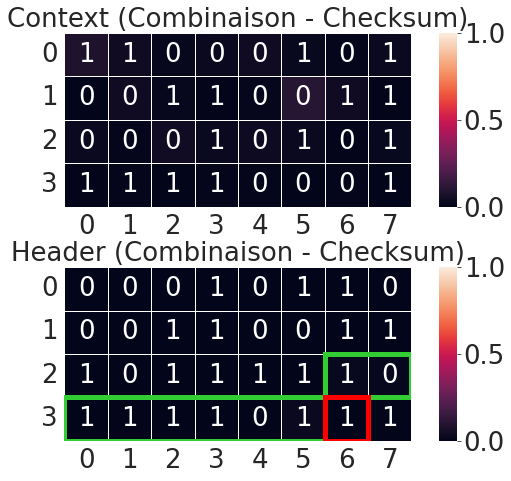

In [159]:
# Extract variables



if (MODE_DATASET == "checksum34"):
    mode_dataset = "Checksum"
else:
    mode_dataset = MODE_DATASET\
        .replace("_", " ")\
        .capitalize()
    
packet = arr_raw[index_packet]

if (index_packet >= LOOK_BACK_CONTEXT):
    context = arr_raw[index_packet-1]
else:
    context = np.zeros(packet.shape)
    
## Remove padding
if (LEFT_PADDING):
    packet = packet[LOOK_BACK_PACKET:]
    context = context[LOOK_BACK_PACKET:]
    
# Reshape packet and context
packet = packet.reshape((-1, 8))
context = context.reshape((-1, 8))

# Init figure
fig, axes = plt.subplots(
    2, 1, figsize=(10, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.35)

# Functions to use
def highlight_cell(x, y, length=1, width=1,  ax=None, **kwargs):
    rect = plt.Rectangle(
        (x, y), length, width, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

# Plot context
sns.heatmap(arr_proba[:4, :], 
            annot=context, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[0],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})
cbar = axes[0].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[0].set_title(f"Context ({mode_dataset.capitalize()} - Checksum)", 
                  fontsize=TITLE_FONTSIZE)

# Plot packet
sns.heatmap(arr_proba[4: :], 
            annot=packet, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[1],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})

cbar = axes[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[1].set_title(f"Header ({mode_dataset.capitalize()} - Checksum)", 
                  fontsize=TITLE_FONTSIZE)

# Set sliding windows
highlight_cell(x=0, y=3, #x=4, y=1, 
               length=6, width=1,
               ax=axes[1], 
               color="limegreen", 
               linewidth=LINEWIDTH*1.25)
highlight_cell(x=6, y=2, #x=0, y=2, 
               length=2, width=1,
               ax=axes[1], 
               color="limegreen", 
               linewidth=LINEWIDTH*1.25)

# Set pixel to predict
highlight_cell(x=6, y=3, #x=4, y=2, 
               length=1, width=1,
               ax=axes[1], 
               color="red", 
               linewidth=LINEWIDTH*1.25)

# Set field name
for ax in axes.ravel():
    
    ax.tick_params(labelsize=TICK_FONTSIZE)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        
    # Rotation des label sur l'axe Y
    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(0)

In [ ]:
# EXTRACT MEAN VALUES



unique_index_packet = \
    df_fields["index_flow_packet"]\
        .value_counts().index
dict_index_packet_count = {}

# For each packet
for i in unique_index_packet:
    
    dict_rank_count = {}
    dict_rank_proba = {}
    
    # For each bit rank in packet
    for j in range(
        (NB_BITS*LOOK_BACK_CONTEXT)+NB_BITS):
        
        dict_rank_proba[int(j)] = \
            np.max(dict_index_packet[i][j])
        dict_rank_count[int(j)] = 1
    
    # Set dict to index
    dict_index_packet_count[str(int(i))] = \
        dict_rank_proba
    dict_index_packet_count[f"count_{int(i)}"] = \
        dict_rank_count

In [103]:
# CREATE ARRAY for ploting


# Get dataframe with proba
# for each ranks
df_index_packet_count = \
    pd.DataFrame(
        dict_index_packet_count)
nb_ranks = int(np.sqrt(
    df_index_packet_count.shape[0]))


# Extract array 

# Array for proba
arr_proba = np.zeros(
    (LOOK_BACK_CONTEXT+1, nb_ranks, nb_ranks)
)

unique_index_packet = \
    df_fields["index_flow_packet"]\
        .value_counts().index.astype(int)
for i in unique_index_packet:
    
    # Context is full or not
    if (i >= LOOK_BACK_CONTEXT):
        
        # Max context size
        max_context_size = \
                int(df_index_packet_count \
                    .columns.shape[0] / 2)
        col_flows_rank = \
            np.arange(LOOK_BACK_CONTEXT, 
                      max_context_size+1, #MAX_PACKET_RANK, 
                      dtype=int).astype(str)
        col_flows_rank_count = \
            ["count_"+num for num in col_flows_rank] 
        
        # Extract values
        arr_proba_tmp = \
            df_index_packet_count[
                col_flows_rank].values
        arr_proba_count_tmp = \
            df_index_packet_count[
                col_flows_rank_count].values
        arr_proba_count_tmp = arr_proba_count_tmp / \
            arr_proba_count_tmp\
                .sum(axis=1)\
                .reshape(-1, 1)
        
        # Get values multiplication
        arr_proba_tmp = \
            (arr_proba_tmp * \
            arr_proba_count_tmp)\
                .sum(axis=1) \
                .reshape(1, nb_ranks, nb_ranks)
        
        # Set values
        arr_proba[-1:] = arr_proba_tmp
        
    else:
        arr_proba_tmp = \
            df_index_packet_count[str(i)] \
            .values \
            .reshape(1, nb_ranks, nb_ranks)
        arr_proba[i:i+1] = arr_proba_tmp
        
        #arr_proba = np.zeros(())
        #arr_proba[-2:-1] = arr_proba_tmp

In [274]:
# EXTRACT MEAN VALUES



unique_index_packet = \
    df_fields["index_flow_packet"]\
        .value_counts().index
dict_index_packet_count = {}

# For each packet
for i in unique_index_packet:
    
    dict_rank_count = {}
    dict_rank_proba = {}
    
    # For each bit rank in packet
    for j in range(
        (NB_BITS*LOOK_BACK_CONTEXT)+NB_BITS):
        
        dict_rank_proba[int(j)] = \
            np.mean(dict_index_packet[i][j])
        dict_rank_count[int(j)] = \
            len(dict_index_packet[i])
    
    # Set dict to index
    dict_index_packet_count[str(int(i))] = \
        dict_rank_proba
    dict_index_packet_count[f"count_{int(i)}"] = \
        dict_rank_count

In [275]:
# CREATE ARRAY for ploting


# Get dataframe with proba
# for each ranks
df_index_packet_count = \
    pd.DataFrame(
        dict_index_packet_count)
nb_ranks = int(np.sqrt(
    df_index_packet_count.shape[0]))


# Extract array 

# Array for proba
arr_proba = np.zeros(
    (LOOK_BACK_CONTEXT+1, nb_ranks, nb_ranks)
)

unique_index_packet = \
    df_fields["index_flow_packet"]\
        .value_counts().index.astype(int)
for i in unique_index_packet:
    
    # Context is full or not
    if (i >= LOOK_BACK_CONTEXT):
        
        # Max context size
        #max_context_size = \
        #        (df_index_packet_count \
        #            .columns.shape[0] / 2)
        col_flows_rank = \
            np.arange(LOOK_BACK_CONTEXT, 
                      MAX_PACKET_RANK, 
                      dtype=int).astype(str)
        col_flows_rank_count = \
            ["count_"+num for num in col_flows_rank] 
        
        # Extract values
        arr_proba_tmp = \
            df_index_packet_count[
                col_flows_rank].values
        arr_proba_count_tmp = \
            df_index_packet_count[
                col_flows_rank_count].values
        arr_proba_count_tmp = arr_proba_count_tmp / \
            arr_proba_count_tmp\
                .sum(axis=1)\
                .reshape(-1, 1)
        
        # Get values multiplication
        arr_proba_tmp = \
            (arr_proba_tmp * \
            arr_proba_count_tmp)\
                .sum(axis=1) \
                .reshape(1, nb_ranks, nb_ranks)
        
        # Set values
        arr_proba[-1:] = arr_proba_tmp
        
    else:
        arr_proba_tmp = \
            df_index_packet_count[str(i)] \
            .values \
            .reshape(1, nb_ranks, nb_ranks)
        arr_proba[i:i+1] = arr_proba_tmp
        
        #arr_proba = np.zeros(())
        #arr_proba[-2:-1] = arr_proba_tmp

### 4.9 Heatmap ALL PROTOCOLS

In [89]:
#############################################
# SET PARAMETERS
#############################################

RESULTS_DIR = "RESULTS/FIELDS/DEEP_LEARNING/PARTS/"
MODELS_DIR = "MODELS/DEEP_LEARNING/"
MAIN_DIR = "./DATA/"

PROTO = "HTTP"

# Set keras types
tf.keras.backend.set_floatx('float64')

# Context
LOOK_BACK_CONTEXT = 1 # On rajoute +1 car on prend le dernier paquet comme paquet à compresser...
LOOK_AHEAD_CONTEXT = 1 #TIMESTEPS
CONTEXT_SIZE = LOOK_BACK_CONTEXT # Nombre timesteps sur les contexts
CONTEXT_OUTPUT_SIZE = 30 # Size of contexte in model layer
# De preference < 128 car c'est la taille de la
# couche GRU avant

# Packet
LOOK_BACK_PACKET = 8
LOOK_AHEAD_PACKET = 1
QUANTITY_PACKET = 15000 # Check if similar to training !
NUM_SIN = 8
NUM_FEATS = NUM_SIN + 1

# Filter equipment
NB_EQUIP_MAX = 10 # Set to None if no equipment
NB_EQUIP_TRAIN = 5 # Set to None if no equipment
MODE_EQUIP = "train" #"train" # or "test" or None for both
NB_EQUIP_LIMIT = NB_EQUIP_MAX # Limit to check to 
# see if we select the right number
# of equipment

# Learning parameters
SHUFFLE = False # For test generator
ALPHABET_SIZE = 2
BATCH_SIZE = 1 # For test generator

# Size added to header_length IN BYTES
EXTRA_SIZE = 0
CUSTOM_SIZE = 100 # Take the lead if extra size is define
CHECKSUM = True # True = Keep Checksum

# For Occlusion Map
NUM_RANK_FIELDS = 29 # Num of rank used for occlusion
KEEP_POS = False # Keep Sinusoide as a field ?
QUANTITY_BATCH = None # Num of batch used in total 
# If None all batch in train set is used
START_IDX = 0
END_IDX = 820
RANGE_IDX = 2500

# Generated dataset parameters
LEFT_PADDING = True # Padding dataset


# Name
# min(LOOK_BACK_CONTEXT, CONTEXT_OUTPUT_SIZE) if CONTEXT_OUTPUT_SIZE == 0
# else LOOK_BACK_CONTEXT == 1 or 2 or 3 or 4...etc
# easy to set LOOK_BACK_CONTEXT == 0
FULL_NAME = f"LOSSLESS_CONTEXT{min(LOOK_BACK_CONTEXT, CONTEXT_OUTPUT_SIZE)}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}_{PROTO}"


if (CHECKSUM):

    if (CUSTOM_SIZE is not None):
        EXT_NAME = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{MODE_EQUIP}"
    else:
        EXT_NAME = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{MODE_EQUIP}"

else:

    if (CUSTOM_SIZE is not None):
        EXT_NAME = f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{MODE_EQUIP}"
    else:
        EXT_NAME = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{MODE_EQUIP}"


# If padding on dataset
if (LEFT_PADDING):
    EXT_NAME += f"_LEFT_PADDING"


print(f"MODEL : {FULL_NAME}{EXT_NAME}")

# Set the Seed for numpy random choice
np.random.seed(42)

MODEL : LOSSLESS_CONTEXT1_PACKET8_SIN8_HTTP_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_LEFT_PADDING


In [90]:
# PREPARE DATA




data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")
arr_raw = np.load(f"./DATA/PROCESS/arr_process_{PROTO}_bit.npy", mmap_mode='r')


if (QUANTITY_PACKET is None):
    QUANTITY_PACKET = data_raw.shape[0] #max_length

In [91]:
# PROCESSING DATA




df_raw = data_raw\
    .reset_index(drop=True)


# CUSTOM_SIZE is present when we fix the max size
# EXTRA_SIZE is relative to the header_length
if (CUSTOM_SIZE is not None):

    max_length = int(CUSTOM_SIZE*8)
    arr = arr_raw[:, :max_length]
    print("arr.shape : ", arr.shape)

    # Remove payload
    arr_mask = np.zeros(arr.shape, dtype=np.uint8)
    for i in range(arr_mask.shape[0]):
        header_length = int(CUSTOM_SIZE*8)
        length_total = int(
            df_raw["length_total"].iloc[i] * 8)
        header_length = min(
            header_length, length_total)
        arr_mask[i, :header_length] = np.ones((1, header_length))

else:

    max_length = int(
       (df_raw["header_length"].max() + EXTRA_SIZE) * 8)
    arr = arr_raw[:, :max_length]
    print("arr.shape : ", arr.shape)

    # Remove payload
    arr_mask = np.zeros(arr.shape, dtype=np.uint8)
    for i in range(arr_mask.shape[0]):
        header_length = int(
            (df_raw["header_length"].iloc[i] + EXTRA_SIZE) * 8)
        length_total = int(
            df_raw["length_total"].iloc[i] * 8)
        header_length = min(
            header_length, length_total)
        arr_mask[i, :header_length] = np.ones((1, header_length))
    

arr = arr * arr_mask
print("arr.shape AFTER MASK : ", arr.shape)

arr.shape :  (461603, 800)
arr.shape AFTER MASK :  (461603, 800)


In [92]:
# EXTRACT FLOWS





# Extraction d'un dictonnaire avec flux -> taille
df_new = df_raw[['flow_id', 'timestamps']].groupby(
                ['flow_id']).min().rename(
                columns={'timestamps': 'flow_id_count'})

# Utilisation de map function pour flux -> taille
dict_map = df_new.to_dict()['flow_id_count']
df_raw['flow_count'] = df_raw['flow_id'].map(dict_map)

# Utilisation de map function pour timestamps + nombre de jour qui correpsond à l'ID
df_min = df_raw[['flow_id', 'timestamps']].groupby(
    ['flow_id']).min().rename(columns={'timestamps': 'min'})
df_min['pad'] = df_min.index.values*10000000
    #'min'].map(lambda x : np.random.randint(0, 5000, size=(1,))[0])
dict_pad = df_min.to_dict()['pad']

def some_func(a, b):
    #print(dict_pad[a])
    return b+dict_pad[a]

df_raw['timestamps_update'] = df_raw[['flow_id', 'timestamps']].apply(
    lambda x: some_func(a=x['flow_id'], b=x['timestamps']), axis=1)

# On sort en fonction de la timestamps (les flux sont autamiquement groupe)
df_raw = df_raw.sort_values(by=['timestamps_update'], ascending=True)
indexes_update = df_raw.index.values 

# J'applique l'insertion pour récuperer les index proprement
# Mettre les la numerotation des index
df_raw = df_raw.reset_index(drop=True)
arr_update = arr[indexes_update]

## On extrait les index max de chaque flux (voir index result)
indexes = df_raw.duplicated(subset=['flow_id'], keep='first')
index_val = df_raw.index[~indexes].values
index_min = index_val.copy()

## On créer les index min de chaque flux (voir index result) ET on fait la diff
indexes = df_raw.duplicated(subset=['flow_id'], keep='last')
index_val = df_raw.index[~indexes].values
index_max = index_val.copy()

## On attribue les index_min et les index_max
df_new = df_raw[['flow_id']].drop_duplicates(
    subset=['flow_id'], keep='first')
df_new['index_min'] = index_min
df_new['index_max'] = index_max
df_new = df_new.set_index('flow_id')

dict_index_min = df_new[["index_min"]].to_dict()['index_min']
dict_index_max = df_new[["index_max"]].to_dict()['index_max']
df_raw['index_min'] = df_raw['flow_id'].map(dict_index_min)
df_raw['index_max'] = df_raw['flow_id'].map(dict_index_max)

In [93]:
# EXTRACT DATA




if (CUSTOM_SIZE is not None):
    headers_length = np.fmin(CUSTOM_SIZE,
                             df_raw['length_total'].values)
else:
    headers_length = np.fmin(df_raw['header_length'].values + EXTRA_SIZE,
                             df_raw['length_total'].values)

# We add padding
if (LEFT_PADDING):

    # Update max_length
    max_length = \
        max_length + LOOK_BACK_PACKET

    # Add padding to header length
    headers_length = headers_length + \
        (LOOK_BACK_PACKET / 8) # in bytes

    ## Define padding
    arr_update_padding = \
        np.zeros((arr_update.shape[0], 
                  LOOK_BACK_PACKET))
    arr_update = np.concatenate(
        (arr_update_padding, arr_update), 
        axis=1)


packets_rank = (df_raw.index.values - df_raw['index_min']).values
packets = arr_update
block_length = (headers_length*8 - \
                LOOK_BACK_PACKET).astype(int)

# Filter unique paquet
_, idx_unique = np.unique(packets, 
                          return_index=True,  
                          axis=0)
idx_unique = np.sort(idx_unique, axis=-1, 
            kind=None, order=None)

# Remove packet where block length
# if negative
# If size is less than the idx its
# useless to compress !!!
idx_unique_positive = np.where(
    block_length > 0)
idx_unique = np.intersect1d(
    idx_unique, idx_unique_positive)
idx_unique = np.sort(idx_unique, axis=-1, 
            kind=None, order=None)

In [94]:
# SELECTION EQUIPMENT 




if ("LORA" in PROTO):
    col = "device_address"
else:
    col = "ip_src"


if ((NB_EQUIP_MAX is None) or
    (NB_EQUIP_TRAIN is None)):


    idx_unique = \
        np.random.choice(idx_unique, 
                         QUANTITY_PACKET, 
                         replace=False)
    #idx_unique = idx_unique[
    #    :QUANTITY_PACKET]
    idx_unique = np.sort(idx_unique, axis=-1, 
                kind=None, order=None)

else:

    if ("LORA" in PROTO):

        list_device_address = []
        list_gateway = []

        flows_id_mac = df_raw[
            "device_address"].value_counts().index

        for f_mac in flows_id_mac:

            cond = (df_raw[
               "device_address"] == f_mac)

            device_address_tmp = df_raw[
                cond].iloc[0]['device_address']
            gateway_tmp = df_raw[
                cond].iloc[0]['gateway']

            # Verifier que les IP ne sont pas deja présentes
            # parmis l'IP src
            if (device_address_tmp in list_device_address):
                pass
            else:
                list_device_address.append(
                    device_address_tmp)
                list_gateway.append(
                    gateway_tmp)

        # Select equipement
        if (MODE_EQUIP == "train"):
            list_device_address = list_device_address[:NB_EQUIP_TRAIN]
            list_gateway = list_gateway[:NB_EQUIP_TRAIN]
            NB_EQUIP_LIMIT = NB_EQUIP_TRAIN
        elif (MODE_EQUIP == "test"):
            list_device_address = list_device_address[
                NB_EQUIP_TRAIN:NB_EQUIP_MAX]
            list_gateway = list_gateway[
                NB_EQUIP_TRAIN:NB_EQUIP_MAX]
            NB_EQUIP_LIMIT = NB_EQUIP_MAX - NB_EQUIP_TRAIN
        else:
            list_device_address = list_device_address[:NB_EQUIP_MAX]
            list_gateway = list_gateway[:NB_EQUIP_MAX]
            NB_EQUIP_LIMIT = NB_EQUIP_MAX

        print("[DEBUG] list_device_address: ", list_device_address)
        print("[DEBUG] list_gateway: ", list_gateway)

        # Parmis les equipement selectionner prendre les flow_ids un pour chaque
        # jusqu'a que le nombre max de paquet soit atteint !
        cond = ((df_raw["device_address"].isin(list_device_address)) &
                (df_raw["gateway"].isin(list_gateway)))

        flows_id = df_raw[cond]['flow_id']\
                        .value_counts(ascending=True)\
                        .index

        # For uniformisation
        nb_device_address = len(list_device_address)

    else:

        # Trouver les flow_id_ip a prendre (cinq equipement avec des adress ip_src différente)
        list_ip_src = []
        list_ip_dst = []

        flows_id_mac = df_raw[
            "flow_id_ip"].value_counts().index

        for f_mac in flows_id_mac:
            
            cond = (df_raw[
                "flow_id_ip"] == f_mac)

            ip_src_tmp = df_raw[
                cond].iloc[0]['ip_src']
            ip_dst_tmp = df_raw[
                cond].iloc[0]['ip_dst']
            
            # Verifier que les IP ne sont pas deja présentes
            # parmis l'IP src
            if (ip_src_tmp in list_ip_src):
                pass
            else:
                list_ip_src.append(ip_src_tmp)
                list_ip_dst.append(ip_dst_tmp)

        # Select equipement
        if (MODE_EQUIP == "train"):
            list_ip_src = list_ip_src[:NB_EQUIP_TRAIN]
            list_ip_dst = list_ip_dst[:NB_EQUIP_TRAIN]
            NB_EQUIP_LIMIT = NB_EQUIP_TRAIN
        elif (MODE_EQUIP == "test"):
            list_ip_src = list_ip_src[
                NB_EQUIP_TRAIN:NB_EQUIP_MAX]
            list_ip_dst = list_ip_dst[
                NB_EQUIP_TRAIN:NB_EQUIP_MAX]
            NB_EQUIP_LIMIT = NB_EQUIP_MAX - NB_EQUIP_TRAIN
        else:
            list_ip_src = list_ip_src[:NB_EQUIP_MAX]
            list_ip_dst = list_ip_dst[:NB_EQUIP_MAX]
            NB_EQUIP_LIMIT = NB_EQUIP_MAX

        print("[DEBUG] list_ip_src: ", list_ip_src)
        print("[DEBUG] list_ip_dst: ", list_ip_dst)

        # Parmis les equipement selectionner prendre les flow_ids un pour chaque
        # jusqu'a que le nombre max de paquet soit atteint !
        cond = ((df_raw["ip_src"].isin(list_ip_src)) &
                (df_raw["ip_dst"].isin(list_ip_dst)))

        flows_id = df_raw[cond]['flow_id']\
                        .value_counts(ascending=True)\
                        .index

        # For uniformisation
        nb_device_address = len(list_ip_src)


nb_pkt = 0
i = 0
nb_equipment = 0
list_flows_id = []

# On collecte un certains nombre de paquet
# mais il faut que des paquets de tous les equipements 
# selectionné soit pris. Sinon on echantillonne
# avec le dernier if
cond_while = (((nb_pkt < QUANTITY_PACKET) or 
              (nb_equipment < nb_device_address)) and 
              (i < len(flows_id)-1))
while (cond_while):
    
    cond_while = (((nb_pkt < QUANTITY_PACKET) or 
                  (nb_equipment < nb_device_address)) and 
                  (i < len(flows_id)-1))

    list_flows_id.append(flows_id[i])
    cond = (df_raw[
        'flow_id'] == flows_id[i])

    nb_pkt += df_raw[
        cond].shape[0]
    i += 1
    
    # Count number of device address
    cond = (df_raw['flow_id'].isin(list_flows_id))
    nb_equipment = df_raw[cond][
        col].value_counts().shape[0]


# Collect indexes
cond = (df_raw['flow_id'].isin(list_flows_id))
idx_unique_equipment = df_raw[cond].index
idx_unique = np.intersect1d(
    idx_unique, idx_unique_equipment)
idx_unique = np.sort(idx_unique, axis=-1, 
            kind=None, order=None)
    
# Apply correction !
# Si le nb de paquet est supérieur ou égale
# alors on a du en pendre plus pour pouvoir
# couvrir tous les equipements
print("[DEBUG] len(idx_unique) : ", len(idx_unique))
print("[DEBUG] QUANTITY_PACKET : ", QUANTITY_PACKET)

if (len(idx_unique) >= QUANTITY_PACKET):
    print("[DEBUG][nb_pkt >= QUANTITY_PACKET] Apply undersampling !")
    
    idx_unique = \
        np.random.choice(idx_unique, 
                         QUANTITY_PACKET, 
                         replace=False)
    idx_unique = np.sort(idx_unique, axis=-1, 
            kind=None, order=None)


nb_equipment = df_raw.iloc[
    idx_unique][col] \
    .value_counts().shape[0]

# Verifier que le nombre de equipements sont couvert
if (nb_equipment < nb_device_address):
    print("[DEBUG][WARNING !] Le nombre d'équiment choisi n'est pas présent !")
    raise Exception
    
if (nb_equipment < NB_EQUIP_LIMIT):
    print("[DEBUG][WARNING !] Le nombre d'équiment choisi est inférieur à NB_EQUIP_MAX !")
    raise Exception

[DEBUG] list_ip_src:  ['172.16.116.201', '172.16.116.44', '172.16.114.148', '172.16.113.84', '172.16.115.87']
[DEBUG] list_ip_dst:  ['209.67.29.11', '205.181.112.65', '205.181.112.65', '209.67.29.11', '209.67.29.11']
[DEBUG] len(idx_unique) :  15014
[DEBUG] QUANTITY_PACKET :  15000
[DEBUG][nb_pkt >= QUANTITY_PACKET] Apply undersampling !


In [95]:
# SELECT UNIQUE PACKET AND SPLIT WITH TEST




# Remove packets will be used for test
# compression
# It's useless to split test data in case 
# of test mode (equipement)
if (MODE_EQUIP != "test"):
    idx_unique_test = df_raw.iloc[idx_unique].sample(
        frac=0.1, weights='flow_id', 
        replace=False, random_state=42).index.values
    idx_unique_test = np.sort(idx_unique_test)
    print("[DEBUG] idx_unique_test: ", idx_unique_test)
    idx_unique = np.setdiff1d(
        idx_unique, idx_unique_test)
    idx_unique = np.sort(idx_unique)


# Get the list of block
cumsum_block = np.cumsum(
    block_length)
max_block = cumsum_block.max()

# Set ranks for each packet
indexes_flow_packet = np.repeat(
    packets_rank, 
    (headers_length*8 - LOOK_BACK_PACKET).astype(int), axis=0)

# Set all indexes
list_IDs = np.arange(
    max_block, dtype=int)
indexes_packet = np.repeat(
    np.arange(0, block_length.size, dtype=int), 
    block_length, axis=0)

# Valuer du début de chaque bloc
#  de chaque paquet
cumsum_block_tmp = np.zeros(
    cumsum_block.size, dtype=int)
cumsum_block_tmp[1:] = cumsum_block[:-1]

indexes_block = np.repeat(
    cumsum_block_tmp, 
    block_length, axis=0)
indexes_block = list_IDs - indexes_block

[DEBUG] idx_unique_test:  [201112 201154 201157 ... 443646 443665 443669]


In [96]:
# WE TAKE NEW LIST ID WITH UNIQUE ELEMENT (and without TEST data)




print("[DEBUG] BEFORE list_IDs.shape: ", list_IDs.shape)
print("[DEBUG] BEFORE indexes_packet.shape: ", indexes_packet.shape)
print("[DEBUG] BEFORE indexes_block.shape: ", indexes_block.shape)


# Get index for min and max element
# idx_unique is ordonned !
max_range = cumsum_block[idx_unique]
min_range = cumsum_block[idx_unique-1]

if (idx_unique[0] == 0):
    min_range[0] = 0


# New list ID
list_IDs_update = np.zeros(
    list_IDs.shape, dtype=int)
indexes_packet_update = np.zeros(
    indexes_packet.shape, dtype=int)
indexes_block_update = np.zeros(
    indexes_block.shape, dtype=int)
indexes_flow_packet_update = np.zeros(
    indexes_block.shape, dtype=int)

index_start = 0
index_end = 0

for idx_start, idx_end in zip(
    min_range, max_range):
    
    # Update index
    block_size = (idx_end - idx_start)
    index_end = index_start + block_size
    
    list_IDs_update[index_start:index_end] = \
        list_IDs[idx_start:idx_end]
    indexes_packet_update[index_start:index_end] = \
        indexes_packet[idx_start:idx_end]
    indexes_block_update[index_start:index_end] = \
        indexes_block[idx_start:idx_end]
    indexes_flow_packet_update[index_start:index_end] = \
        indexes_flow_packet[idx_start:idx_end]

    index_start = index_end

    
list_IDs_update = list_IDs_update[
    :index_end].astype(int)
indexes_packet_update = indexes_packet_update[
    :index_end].astype(int)
indexes_block_update = indexes_block_update[
    :index_end].astype(int)
indexes_flow_packet_update = indexes_flow_packet_update[
    :index_end].astype(int)


print("[DEBUG] AFTER list_IDs_update.shape: ", list_IDs_update.shape)
print("[DEBUG] AFTER indexes_packet_update.shape: ", indexes_packet_update.shape)
print("[DEBUG] AFTER indexes_block_update.shape: ", indexes_block_update.shape)

[DEBUG] BEFORE list_IDs.shape:  (241577912,)
[DEBUG] BEFORE indexes_packet.shape:  (241577912,)
[DEBUG] BEFORE indexes_block.shape:  (241577912,)
[DEBUG] AFTER list_IDs_update.shape:  (6341416,)
[DEBUG] AFTER indexes_packet_update.shape:  (6341416,)
[DEBUG] AFTER indexes_block_update.shape:  (6341416,)


In [97]:
# CREATE GENERATOR




# On shuffle pour etre sur que les adresses sont toutes couvertes
# étape de CHECK COVERAGE ne devitn plus nécessaire

idx = np.arange(0, list_IDs_update.size, dtype=int)
train_idx, val_idx, _, _ = sklearn.model_selection.train_test_split(
    idx, idx, random_state=42, 
    test_size=0.1, shuffle=SHUFFLE) # SHUFFLE


list_IDs_train = list_IDs_update[train_idx]
list_IDs_val = list_IDs_update[val_idx]

indexes_packet_train = indexes_packet_update[train_idx]
indexes_packet_val = indexes_packet_update[val_idx]

indexes_block_train = indexes_block_update[train_idx]
indexes_block_val = indexes_block_update[val_idx]

indexes_flow_packet_train = indexes_flow_packet_update[train_idx]
indexes_flow_packet_val = indexes_flow_packet_update[val_idx]

In [98]:
# LOAD MODEL




encoder_context = tf.keras.models.load_model(f"{MODELS_DIR}ENCODER_CONTEXT_{FULL_NAME}{EXT_NAME}.h5", 
                                              custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
ed_lossless = tf.keras.models.load_model(f"{MODELS_DIR}ED_{FULL_NAME}{EXT_NAME}.h5", 
                                          custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
embedder = tf.keras.models.load_model(f"{MODELS_DIR}EMBEDDER_{FULL_NAME}{EXT_NAME}.h5", 
                                      custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
model = CompressorLossless(encoder_context=encoder_context, 
                           ed_lossless=ed_lossless)

In [99]:
# SET PARAMETERS FOR OCCLUSION MAP




# Initialisation d'un array avec meme diension pour stocker :
# Le ranking de chaque field
columns_fields = [f"rank_{i}" for i in range(NUM_RANK_FIELDS)]
columns_probas = [f"proba_{i}" for i in range(NUM_RANK_FIELDS)]
df_fields = pd.DataFrame(
    columns=columns_fields+columns_probas)


# Get masks
block_length = int(LOOK_BACK_PACKET)

if (LEFT_PADDING):
    ctx_length = int((max_length-LOOK_BACK_PACKET)*LOOK_BACK_CONTEXT) #int(max_length*LOOK_BACK_CONTEXT)
else:
    ctx_length = int(max_length*LOOK_BACK_CONTEXT)  

pos_length = int(LOOK_BACK_PACKET)

total_length = int(block_length + \
    ctx_length + pos_length)
mask = np.eye(total_length)
idx_mask = np.arange(0, mask.shape[0])


# Batch to reach
if (QUANTITY_BATCH is None):
    QUANTITY_BATCH = int(list_IDs_train.size)
   
idx_batchs = np.arange(
    0, list_IDs_train.size) 
idx_batchs = np.random.choice(
    idx_batchs, QUANTITY_BATCH)

# Undersampling
indexes_flow_packet_train_undersample = \
    indexes_flow_packet_train#[idx_batchs]

list_IDs_train_undersample = \
    list_IDs_train#[idx_batchs]

indexes_packet_train_undersample = \
    indexes_packet_train#[idx_batchs]

indexes_block_train_undersample = \
    indexes_block_train#[idx_batchs]

In [100]:
# GENERATOR UPDATE pour prendre la notion d'index
# sans sequentialité !
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, 
                 list_IDs,
                 
                 look_back_context,
                 look_ahead_context,
                 look_back_packet,
                 look_ahead_packet,
                
                 packets_rank,
                 packets, 
                 headers_length,
                 max_length,
                 
                 indexes_packet,
                 indexes_block,
                 
                 left_padding=False,
                 batch_size=32,
                 num_sin=8,
                 alphabet_size=2, 
                 shuffle=True):
        'Initialization'
        self.left_padding = left_padding
        self.batch_size = batch_size
        # Liste des index des packets (peut etre que les vals ou trains...)
        self.list_IDs = list_IDs # Index de block !
        self.shuffle = shuffle
        self.on_epoch_end()
        
        # Identification data
        #self.flows_id = flows_id
        self.packets_rank = packets_rank
        self.packets = packets
        self.headers_length = headers_length
        
        # Parameters data
        self.num_sin = num_sin
        self.num_feats = self.num_sin + 1
        self.alphabet_size = alphabet_size
        self.max_length = max_length
        
        self.look_back_context = look_back_context
        self.look_ahead_context = look_ahead_context
        self.look_back_packet = look_back_packet
        self.look_ahead_packet = look_ahead_packet
        
        # Generation des indexes
        nb_batch_block_min = (((self.headers_length*8) - 
                              self.look_back_packet) // self.batch_size) * self.batch_size
        nb_batch_block_max = ((self.headers_length*8) - 
                             self.look_back_packet)
        nb_batch_block = np.maximum(nb_batch_block_min, nb_batch_block_max)
        self.indexes_max_packet = np.cumsum(nb_batch_block)
        self.indexes_min_packet = np.concatenate((np.zeros(1),
                                                  self.indexes_max_packet[0:-1]))
        self.indexes_max_packet = self.indexes_max_packet - 1
        
        # Indexes packet and block pre computed !
        self.indexes_packet = indexes_packet
        self.indexes_block = indexes_block
        
        # Generate sinusoide
        self.sin = np.empty((self.max_length, 0), dtype=np.float64)
        for j in range(1, self.num_sin+1):
            sin_tmp = self.__gen_sin(
                F=j, Fs=self.max_length, phi=0, A=1, 
                mean=0.5, period=j, center=0.5).reshape((self.max_length, 1))
            self.sin = np.concatenate((self.sin, sin_tmp), axis=-1)    
        self.sin_seq = create_windows(
            self.sin, window_shape=self.look_back_packet, 
            end_id=-self.look_ahead_packet)
        
        
    def __gen_sin(self, F, Fs, phi, A, mean, period, center):
        T = (1/F)*period # Period if 10/F = 10 cycles
        Ts = 1./Fs # Period sampling
        N = int(T/Ts) # Number of samples
        t = np.linspace(0, T, N)
        signal = A*np.sin(2*np.pi*F*t + phi) + center
        return signal

    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(
            (self.list_IDs.size /  self.batch_size)))

    
    # /!\ A adapter en fonction de la look_ahead_packet 
    # (par default on dit quel est a UN !)
    def __compute_batch_quantity(self, indexes_packet):
        #(self.headers_length[indexes_packet].sum() * 8)
        pkts_size = (self.headers_length[
            indexes_packet].sum() * 8)
        pkts_size_cut = pkts_size - \
            (indexes_packet.shape[0]*self.look_back_packet)
        return pkts_size_cut # / self.batch_size)
    

    def __getitem__(
        self, index):
        'Generate one batch of data'
        # On met à jour l'index avec le coté random !
        
        # Get index of block
        index_start = self.indexes[
            index] * self.batch_size
        index_end = index_start + self.batch_size
        
        # Get indexes packet and block
        indexes_packet = self.indexes_packet[
            index_start:index_end]
        indexes_block = self.indexes_block[
            index_start:index_end]
        
        # On prend le min et on ajoute !
        # On récupère les données
        ctx, pkt, y = self.__data_generation(
                indexes_packet, indexes_block)
        
        if (self.left_padding):
            return [ctx[:, :, self.look_back_packet:], pkt, y]
        else:
            return [ctx, pkt, y]

    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # On manipule des indexes de block !
        self.indexes = np.arange(
            np.floor(len(self.list_IDs)/self.batch_size)) \
            .astype(int)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def __get_context(
        self, indexes_packet):
        
        ctx = np.zeros(
            (indexes_packet.size, 
             self.look_back_context, 
             self.max_length))
        
        for i in range(ctx.shape[0]):
            rank = indexes_packet[i] #list_IDs[i]
            
            pad_size = max(0, self.look_back_context - \
                self.packets_rank[rank])
            
            pkt_size = self.look_back_context - \
                pad_size
            
            ctx_tmp = np.concatenate(
                    (np.zeros((pad_size, self.max_length)), 
                     self.packets[rank-pkt_size:rank]), axis=0)
            
            ctx_tmp = ctx_tmp.reshape(
                1, self.look_back_context, -1)
                
            ctx[i] = ctx_tmp
        
        # Repeat le contexte en fonction de la header length
        nbs_repeat = ((self.headers_length[indexes_packet]*8) - \
              self.look_back_packet).astype(int)
        ctx_seq = np.repeat(ctx, nbs_repeat, axis=0)
        
        return ctx_seq
    
    
    def __get_packet(self, 
                     indexes_packet, 
                     indexes_block):
        # En fonction de la taille de batch size il faut 
        # penser à recupere un ou plusieurs paquets !
        
        #nb_repeat = ((self.headers_length[indexes_packet]*8) - \
        #      self.look_back_packet).sum().astype(int) #[0]
        nb_repeat = indexes_block.size
        
        pkt_seq = np.zeros(
            (nb_repeat, self.look_back_packet, 
             self.num_feats))
        
        y_seq = np.zeros(
            (nb_repeat, self.alphabet_size))
        
        index_start = int(0)
        for idx_pkt, idx_block in zip(
            indexes_packet, indexes_block):
            
            idx_start = idx_block
            idx_end = idx_block + self.look_back_packet
            
            # Set packet
            pkt = self.packets[
                idx_pkt, :int(self.headers_length[idx_pkt]*8)]
            
            pkt_seq_tmp = pkt[idx_start:idx_end] \
                .reshape(-1, self.look_back_packet, 1)
            
            y_seq_tmp = pkt[idx_end]
            y_seq_tmp = tf.keras.utils.to_categorical(
                y=y_seq_tmp.ravel(), 
                num_classes=self.alphabet_size, 
                dtype='float64')
            
            # Set to packet sequence
            pkt_seq[index_start:index_start+1, :, 0:1] = pkt_seq_tmp
            pkt_seq[index_start:index_start+1, :, 1:] = self.sin_seq[
                idx_start:idx_start+1]
            y_seq[index_start:index_start+1] = y_seq_tmp
            
            index_start += 1
            
        return pkt_seq, y_seq

    
    def __data_generation(
        self, indexes_packet, indexes_block):
        'Generates data containing batch_size samples'      
        # Initialization
        ctx = self.__get_context(
            indexes_packet)
        
        pkt, y = self.__get_packet(
            indexes_packet, indexes_block) # On shuffle les packet et target
        
        # Correct context shape
        ctx = ctx[:pkt.shape[0]]
        
        # On prend des bloque alétoire parmis les paquet
        # pas forcement les blocks selectionné...
        # Moins propre mais + simple...
        indexes = np.arange(0, pkt.shape[0])\
                    .astype(int)
        
        # Shuffle to avoid to always keep the last block non learned !
        ctx = ctx[indexes]
        pkt = pkt[indexes]
        y = y[indexes]
        
        return ctx, pkt, y

In [101]:
# SET GENERATOR





# Set parameters
params = {'look_back_context': LOOK_BACK_CONTEXT,
          'look_ahead_context': LOOK_AHEAD_CONTEXT, # Par default on ne sais qu'avec 1
          'look_back_packet': LOOK_BACK_PACKET,
          'look_ahead_packet': LOOK_AHEAD_PACKET, # Par default on ne sais qu'avec 1
         
          'packets_rank': packets_rank,
          'packets': packets,
          'headers_length': headers_length,
          'max_length': max_length,
         
          'left_padding': LEFT_PADDING,
          'batch_size': 1, #BATCH_SIZE,
          'num_sin': NUM_SIN,
          'alphabet_size': ALPHABET_SIZE, 
          'shuffle': False} # SHUFFLE

# Generators
generator = DataGenerator(
    list_IDs=list_IDs_train_undersample,
    indexes_packet=indexes_packet_train_undersample,
    indexes_block=indexes_block_train_undersample,
    **params)

In [102]:
# APPLY OCCLUSION MAP



indexes = range(list_IDs_train_undersample.size)


# On parcours chaque batch ()
for i, ID, idx_pkt, idx_block, idx_flow_pkt in tqdm(zip(
        indexes[START_IDX:END_IDX],
        list_IDs_train_undersample[START_IDX:END_IDX],
        indexes_packet_train_undersample[START_IDX:END_IDX],
        indexes_block_train_undersample[START_IDX:END_IDX],
        indexes_flow_packet_train_undersample[START_IDX:END_IDX])):

    # Mettre comme index de l'array le get item !
    ctx_seq, pkt_sin_seq, y_seq = generator.__getitem__(
        index=i)
    
    # Make standard prediction
    prob_normal = model.predict([ctx_seq,
                                 pkt_sin_seq,
                                 np.zeros((pkt_sin_seq.shape[0], 2))], batch_size=1)

    # Apply mask
    ## Re arange data
    ctx_seq_ravel = ctx_seq.ravel().reshape(1, -1)
    pkt_seq_ravel = pkt_sin_seq[:, :, 0].ravel().reshape(1, -1)
    sin_seq = pkt_sin_seq[:, :, 1:] #.ravel()
    y_seq_ravel = y_seq.ravel().reshape(1, -1)
    
    ## Apply mask
    idx_start = 0
    idx_end = ctx_seq_ravel.shape[-1]
    mask_ctx_seq = mask[:, idx_start:idx_end]
    idx_mask_ctx_seq_xaxis = idx_mask[idx_start:idx_end]
    
    #print("[DEBUG] idx_start: ", idx_start)
    #print("[DEBUG] idx_end: ", idx_end)
    #print("[DEBUG] mask.shape: ", mask.shape)
    #print("[DEBUG] mask_ctx_seq.shape: ", mask_ctx_seq.shape)

    
    idx_start = ctx_seq_ravel.shape[-1]
    idx_end = ctx_seq_ravel.shape[-1] + pkt_seq_ravel.shape[-1]
    mask_pkt_seq = mask[:, idx_start:idx_end]
    idx_mask_pkt_seq_xaxis = idx_mask[idx_start:idx_end]
    

    idx_start = ctx_seq_ravel.shape[-1]+pkt_seq_ravel.shape[-1]
    idx_end = ctx_seq_ravel.shape[-1] + \
        pkt_seq_ravel.shape[-1]+sin_seq.shape[1]
    mask_sin_seq_exp_dims = np.expand_dims(
        mask[:, idx_start:idx_end], axis=-1)
    mask_sin_seq = np.repeat(mask_sin_seq_exp_dims,
        repeats=sin_seq.shape[-1], axis=-1)
    idx_mask_sin_seq_xaxis = idx_mask[idx_start:idx_end]
    
    
    # Repeat array size
    ctx_seq_ravel_repeat = np.repeat(ctx_seq_ravel,
                                     repeats=mask_ctx_seq.shape[0],
                                     axis=0)
    pkt_seq_ravel_repeat = np.repeat(pkt_seq_ravel,
                                     repeats=mask_pkt_seq.shape[0],
                                     axis=0)
    sin_seq_ravel_repeat = np.repeat(sin_seq,
                                     repeats=mask_sin_seq.shape[0],
                                     axis=0)

    idx_mask_ctx_seq_yaxis = idx_mask_ctx_seq_xaxis - \
            idx_mask_ctx_seq_xaxis.min()
    idx_mask_pkt_seq_yaxis = idx_mask_pkt_seq_xaxis - \
            idx_mask_pkt_seq_xaxis.min()
    idx_mask_sin_seq_yaxis = idx_mask_sin_seq_xaxis - \
            idx_mask_sin_seq_xaxis.min()

    # Invertion des bits
    ctx_seq_ravel_repeat[idx_mask_ctx_seq_xaxis, idx_mask_ctx_seq_yaxis] = ctx_seq_ravel_repeat[
        idx_mask_ctx_seq_xaxis, idx_mask_ctx_seq_yaxis]*(-1) + 1
    pkt_seq_ravel_repeat[idx_mask_pkt_seq_xaxis, idx_mask_pkt_seq_yaxis] = pkt_seq_ravel_repeat[
        idx_mask_pkt_seq_xaxis, idx_mask_pkt_seq_yaxis]*(-1) + 1
    # On supprime pas d'invertion !
    sin_seq_ravel_repeat[idx_mask_sin_seq_xaxis, idx_mask_sin_seq_yaxis] = 0
    
    
    ## Re arange data
    ctx_seq_shape = (ctx_seq_ravel_repeat.shape[0],
                     *ctx_seq.shape[1:])
    ctx_seq_masked = ctx_seq_ravel_repeat.reshape(
        ctx_seq_shape)
    pkt_sin_seq_masked = np.concatenate(
        (np.expand_dims(pkt_seq_ravel_repeat, axis=-1),
         sin_seq_ravel_repeat), axis=-1)

    # Make new prediction
    prob_masked = model.predict([ctx_seq_masked,
                                 pkt_sin_seq_masked,
                                 np.zeros((pkt_sin_seq_masked.shape[0], 2))], batch_size=1)
    

    # Compute difference with proba normale
    diffs_proba = np.abs(
        prob_normal - prob_masked)
    
    # Déterminer le ranks des champs ayant le plus d'impact
    # On supprime les infos de positions car on sait
    # qu'elles sont importantes ! (i.e les sinusoide)
    pos_index_mask = []
    if (not KEEP_POS):
        idx_start = ctx_seq_ravel.shape[-1] + pkt_seq_ravel.shape[-1]
        idx_end = ctx_seq_ravel.shape[-1] + \
            pkt_seq_ravel.shape[-1]+sin_seq.shape[1]
        diffs_proba[idx_start:idx_end] = 0
        pos_index_mask = np.arange(idx_start, idx_end).tolist()
        
        #print("[DEBUG] diffs_proba BEFORE : ", diffs_proba)
        #print("[DEBUG] pos_index_mask: ", pos_index_mask)
        
        # Remove position from diff proba
        mask_diff_proba = np.ones(
            diffs_proba.shape[0], np.bool)
        mask_diff_proba[pos_index_mask] = 0
        diffs_proba = diffs_proba[mask_diff_proba]
        
        
    indexes_sort = np.argsort(
        diffs_proba[:, 0], axis=0)[-NUM_RANK_FIELDS:][::-1]    
    rank_diffs_proba = indexes_sort
    list_proba_0 = diffs_proba[indexes_sort, 0].ravel()
    
    # Save to dataframe
    df_fields.loc[i, 'pred_true'] = np.argmax(y_seq).astype(np.uint8)
    df_fields.loc[i, 'pred_pred'] = np.argmax(prob_normal).astype(np.uint8)
    df_fields.loc[i, columns_fields] = rank_diffs_proba 
    df_fields.loc[i, columns_probas] = list_proba_0.astype(np.float16)
    df_fields.loc[i, 'list_IDs'] = int(ID)
    df_fields.loc[i, 'index_packet'] = int(idx_pkt)
    df_fields.loc[i, 'index_flow_packet'] = int(idx_flow_pkt)
    df_fields.loc[i, 'index_block'] = int(idx_block)

820it [10:05,  1.35it/s]


In [185]:
# SELECT A PACKET


# index_packet to use
index_flow_packet = 1

# Get packet with choosen position in flow
cond = (df_fields["index_flow_packet"] == index_flow_packet)
df_fields = \
    df_fields[cond].reset_index(drop=True)

# Select one packet
index_packet = int(df_fields['index_packet']\
    .value_counts().index[0])
cond = (df_fields["index_packet"] == index_packet)
df_fields = \
    df_fields[cond].reset_index(drop=True)

In [186]:
# EXTRACT ALL PROBA



# Init col

cols_rank = [f"rank_{i}" for i in range(NUM_RANK_FIELDS)]
cols_proba = [f"proba_{i}" for i in range(NUM_RANK_FIELDS)]

# Generate dict of index
# for each index packet


unique_index_packet = \
    df_fields["index_flow_packet"]\
        .value_counts().index
dict_index_packet = {}
for i in unique_index_packet:
    
    dict_rank_proba = {}
    
    for j in range(
        ctx_length+max_length):
        dict_rank_proba[j] = []
    
    # Set dict to index
    dict_index_packet[i] = dict_rank_proba

# For each index packet

unique_index_packet = \
    df_fields["index_flow_packet"]\
        .value_counts().index
for idx_pkt in unique_index_packet:
    
    # Select index packet
    cond_idx_pkt = \
        (df_fields["index_flow_packet"] == idx_pkt)
    df_fields_tmp = df_fields[cond_idx_pkt]
    
    # For each proba rank
    for idx_df_fields in \
        range(df_fields_tmp.index.shape[0]):
        
        # Get fields and index block
        fields = df_fields[cols_rank]\
            .iloc[idx_df_fields]\
            .values
        index_block = df_fields["index_block"]\
            .iloc[idx_df_fields]
        
        
        #print("")
        #print("[DEBUG] fields BEFORE: ", fields)
        #print("[DEBUG] idx_df_fields: ", idx_df_fields)
        #print("[DEBUG] index_block: ", index_block)
        
        # Add more fields linked to prceding values
        fields_all = np.arange(0, max_length+idx_df_fields)
        #print("[DEBUG] fields_all: ", fields_all)
        fields_diff = np.setdiff1d(
            fields_all, fields)
        #print("[DEBUG] fields_diff: ", fields_diff)
        fields = np.concatenate(
            (fields, fields_diff), axis=0)
        #print("[DEBUG] fields: ", fields)
        
        # Correst fields to get absolute postion
        def swenzel(a, val_old, val_new):
            return val_new[np.searchsorted(val_old,a)]
        
        val_old = np.arange(
            0, fields.shape[0]) 
        
        if (LEFT_PADDING):
            val_new = np.concatenate(
                (np.arange(0, max_length-LOOK_BACK_PACKET),
                (np.arange(max_length-LOOK_BACK_PACKET, 
                           fields.shape[0])))
            )
            #print("")
            #print("[DEBUG] val_new BEFORE : ", val_new)
            
            #print("")
            #print("[DEBUG][if(LEFT_PADDING)] index_block: ",
            #     index_block)
            #print("[DEBUG][if(LEFT_PADDING)] index_block - (LOOK_BACK_PACKET - 1): ",
            #     index_block - (LOOK_BACK_PACKET - 1))
            
            #if (index_block >= (LOOK_BACK_PACKET - 1)):
                
            val_new[max_length-LOOK_BACK_PACKET:] = \
                val_new[max_length-LOOK_BACK_PACKET:] + \
                    index_block #- (LOOK_BACK_PACKET - 1)
                
            #print("[DEBUG] val_new IN IF : ", val_new)

            fields = swenzel(
                fields, val_old, val_new)
        
        #print("[DEBUG] fields AFTER: ", fields.astype(int))
        
        # RESULTS:
        # 32 bits context vector + 32 bits data vector 
        # (good position inside)
        
        probas = df_fields_tmp[cols_proba]\
            .iloc[idx_df_fields]\
            .values
        
        # Set other probas to 0
        probas_diff = np.zeros(
            (fields.size-probas.size,))
        probas = np.concatenate(
            (probas, probas_diff))
        
        # Add dict and proba
        for field, proba in zip(fields, probas):
            dict_index_packet[idx_pkt][field].append(proba)
    

In [188]:
# EXTRACT FOR ONE BLOCK



bit_rank = 20 #10 # > LOOK_BACK_PACKET for simplicity... => START FROM 0 !
size_context = 1

# Get nb rank bits
if (LEFT_PADDING):
    nb_ranks = int(np.sqrt(
        ctx_length+max_length-LOOK_BACK_PACKET))
else:
    nb_ranks = int(np.sqrt(
        ctx_length+max_length))

# Save proba
context_proba = []
packet_proba = []
window_proba = []
#arr_proba = np.zeros((nb_ranks, nb_ranks)) \
#            .ravel()
#if (LEFT_PADDING):
#    arr_proba = np.zeros(
#        (NB_BITS*LOOK_BACK_CONTEXT+NB_BITS+LOOK_BACK_PACKET,))
#else:
if (LEFT_PADDING):
    arr_proba = np.zeros(
        (ctx_length+max_length-LOOK_BACK_PACKET,))
else:
    arr_proba = np.zeros(
        (ctx_length+max_length,))

# Compteur for window
cmp_window = LOOK_BACK_PACKET

for key, value in dict_index_packet[
    size_context].items():
    
    # Get proba for context
    if (key < (ctx_length)):
        
        #print("[DEBUG] bit_rank: ", bit_rank)
    
        # Extract value rank
        val_tmp = value[bit_rank]
        context_proba.append(val_tmp)

    # Get proba inside window
    elif ((key >= (ctx_length) + max(0, (bit_rank-LOOK_BACK_PACKET))) and
          (key < (ctx_length) + bit_rank)):
        
        # First bit equal to 0 (padding bit) in case of LEFT_PADDING
        if ((key >= ctx_length) and 
            (key < (ctx_length + LOOK_BACK_PACKET))):
            
            # Add proba
            val_tmp = value[
                max(0, (bit_rank-LOOK_BACK_PACKET))]
            window_proba.append(val_tmp) 
            
        else:
        
            # Update compteur
            cmp_window -= 1

            # Add proba
            val_tmp = value[cmp_window]
            window_proba.append(val_tmp) 

# Set context
idx_start = 0
idx_end = ctx_length
arr_proba[idx_start:idx_end] = context_proba

# Set context
idx_start = (ctx_length) + \
    max(0, (bit_rank-LOOK_BACK_PACKET))
idx_end = (ctx_length) + bit_rank
arr_proba[idx_start:idx_end] = window_proba

# Remove padding part
'''if (LEFT_PADDING):
    arr_proba = np.concatenate(
        (arr_proba[:(NB_BITS*LOOK_BACK_CONTEXT)],
         arr_proba[(NB_BITS*LOOK_BACK_CONTEXT)+LOOK_BACK_PACKET:]))'''

# Reshape proba array
arr_proba = arr_proba.reshape(
    (nb_ranks, nb_ranks))

# Normalize proba array
#arr_proba = (arr_proba - arr_proba.min()) / (arr_proba.max() - arr_proba.min())

IndexError: list index out of range

In [123]:
# Extract variables

    
packet = arr_raw[index_packet, :int(CUSTOM_SIZE*8)]

if (index_flow_packet >= LOOK_BACK_CONTEXT):
    # /!\ WE SUPPOSE ONLY USING CUSTOM SIZE !!!
    context = arr_raw[index_packet-1, 
                      :int(CUSTOM_SIZE*8)]
else:
    context = np.zeros(packet.shape)
    
# Reshape packet and context

## Packet
packet_shape_rest = \
    int(packet.size%arr_proba.shape[-1])
print("[DEBUG] packet_shape_rest: ", 
      packet_shape_rest)

## Add padding to round
if (packet_shape_rest != 0):
    
    ## Add padding
    packet_padding = \
        np.zeros(
            (int(arr_proba.shape[-1]-packet.size),))*np.NaN
    packet = np.concatenate(
        (packet, packet_padding))
    
## Reshape
packet = packet.reshape(
    -1, arr_proba.shape[-1])
    
# Context

context_shape_rest = \
    int(context.size%arr_proba.shape[-1])
print("[DEBUG] context_shape_rest: ", 
      context_shape_rest)

# Add padding to round
if (context_shape_rest != 0):
    
    # Add padding
    context_padding = \
        np.zeros(
            (arr_proba.shape[-1]-context.size,))*np.NaN
    context = np.concatenate(
        (context, context_padding))
    
## Reshape
context = context.reshape(
    -1, arr_proba.shape[-1])

'''## Extract indexes
index_packet_x = int(np.floor(np.sqrt(ctx_length)))
index_packet_y = int((ctx_length - \
    (index_packet_x**2)))

## Get packet and set NaN to other parts
#packet_shape_div = \
#    int(np.floor(packet.size/arr_proba.shape[-1]))
packet_shape_rest = \
    int(packet.size%arr_proba.shape[-1])

# Get nan padding
packet_padding = \
    np.zeros((packet_shape_rest,))*np.NaN
packet = np.concatenate(
    (packet, packet_padding))'''

# Concatenate context and packet
arr_plot = np.concatenate(
    (context, packet), axis=0)

[DEBUG] packet_shape_rest:  0
[DEBUG] context_shape_rest:  0


In [111]:
index_flow_packet

1

In [116]:
context_shape_rest

0

In [127]:
arr_proba.shape

(40, 40)

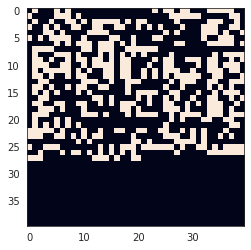

In [125]:
plt.imshow(arr_plot)

'# Plot packet\nsns.heatmap(arr_proba[4: :], \n            annot=packet, \n            linewidth=.5,\n            square=True,\n            vmin=0, vmax=1,\n            ax=axes[1],\n            cbar_kws={"shrink": 1, "aspect": 10},\n            annot_kws={"fontsize": LABEL_FONTSIZE})\n\ncbar = axes[1].collections[0].colorbar\ncbar.ax.tick_params(labelsize=LABEL_FONTSIZE)\naxes[1].set_title(f"Header ({mode_dataset.capitalize()} - Compteur)", \n                  fontsize=TITLE_FONTSIZE)\n\n# Set sliding windows\nhighlight_cell(x=0, y=0, #x=4, y=1, \n               length=6, width=1,\n               ax=axes[1], \n               color="limegreen", \n               linewidth=LINEWIDTH*1.25)\n\n# Set pixel to predict\nhighlight_cell(x=6, y=0, #x=4, y=2, \n               length=1, width=1,\n               ax=axes[1], \n               color="red", \n               linewidth=LINEWIDTH*1.25)\n\n# Set field name\nfor ax in axes.ravel():\n    \n    ax.tick_params(labelsize=TICK_FONTSIZE)\n\n    fo

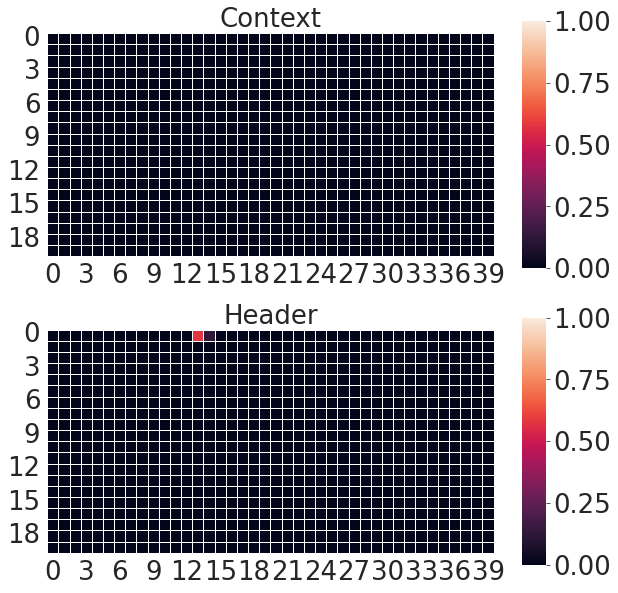

In [180]:
# Extract variables



# Init figure
fig, axes = plt.subplots(
    2, 1, figsize=(10, 10))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
#fig.subplots_adjust(wspace=0.25, 
#                    hspace=0.35)

# Functions to use
def highlight_cell(x, y, length=1, width=1,  ax=None, **kwargs):
    rect = plt.Rectangle(
        (x, y), length, width, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

# Plot context
sns.heatmap(arr_proba[:int(context.shape[0])], 
            #annot=context, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[0],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})
cbar = axes[0].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[0].set_title(f"Context", 
                  fontsize=TITLE_FONTSIZE)

sns.heatmap(arr_proba[int(packet.shape[0]):], 
            #annot=packet, 
            linewidth=.5,
            square=True,
            vmin=0, vmax=1,
            ax=axes[1],
            cbar_kws={"shrink": 1, "aspect": 10},
            annot_kws={"fontsize": LABEL_FONTSIZE})
cbar = axes[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)
axes[1].set_title(f"Header", 
                  fontsize=TITLE_FONTSIZE)


# Set field name
for ax in axes.ravel():
    
    ax.tick_params(labelsize=TICK_FONTSIZE)

    for i, item in enumerate(ax.get_xticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(0)
        
    # Set one label over X
    labels = [item.get_text() for item in ax.get_xticklabels()]
    for i in range(0, len(labels)):
        if (i % 3 != 0):
            labels[i] = ''
    ax.set_xticklabels(labels)
        
    # Rotation des label sur l'axe Y
    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(0)
        
    # Set one label over X
    labels = [item.get_text() for item in ax.get_yticklabels()]
    for i in range(0, len(labels)):
        if (i % 3 != 0):
            labels[i] = ''
    ax.set_yticklabels(labels)

### 4.5 Context t-SNE projection

In [16]:
MODE_EQUIP = "test"
PROTO = "DNS"

In [17]:
# PREPARE DATA

data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")
arr_raw = np.load(f"./DATA/PROCESS/arr_process_{PROTO}_bit.npy", mmap_mode='r')


if (QUANTITY_PACKET is None):
    QUANTITY_PACKET = data_raw.shape[0] #max_length

In [18]:
# PROCESSING DATA


df_raw = data_raw\
    .reset_index(drop=True)


# CUSTOM_SIZE is present when we fix the max size
# EXTRA_SIZE is relative to the header_length
if (CUSTOM_SIZE is not None):

    max_length = int(CUSTOM_SIZE*8)
    arr = arr_raw[:, :max_length]
    print("arr.shape : ", arr.shape)

    # Remove payload
    arr_mask = np.zeros(arr.shape, dtype=np.uint8)
    for i in range(arr_mask.shape[0]):
        header_length = int(CUSTOM_SIZE*8)
        length_total = int(
            df_raw["length_total"].iloc[i] * 8)
        header_length = min(
            header_length, length_total)
        arr_mask[i, :header_length] = np.ones((1, header_length))

else:

    max_length = int(
       (df_raw["header_length"].max() + EXTRA_SIZE) * 8)
    arr = arr_raw[:, :max_length]
    print("arr.shape : ", arr.shape)

    # Remove payload
    arr_mask = np.zeros(arr.shape, dtype=np.uint8)
    for i in range(arr_mask.shape[0]):
        header_length = int(
            (df_raw["header_length"].iloc[i] + EXTRA_SIZE) * 8)
        length_total = int(
            df_raw["length_total"].iloc[i] * 8)
        header_length = min(
            header_length, length_total)
        arr_mask[i, :header_length] = np.ones((1, header_length))
    

arr = arr * arr_mask
print("arr.shape AFTER MASK : ", arr.shape)

arr.shape :  (77811, 800)
arr.shape AFTER MASK :  (77811, 800)


In [19]:
# EXTRACT FLOWS


# Extraction d'un dictonnaire avec flux -> taille
df_new = df_raw[['flow_id', 'timestamps']].groupby(
                ['flow_id']).min().rename(
                columns={'timestamps': 'flow_id_count'})

# Utilisation de map function pour flux -> taille
dict_map = df_new.to_dict()['flow_id_count']
df_raw['flow_count'] = df_raw['flow_id'].map(dict_map)

# Utilisation de map function pour timestamps + nombre de jour qui correpsond à l'ID
df_min = df_raw[['flow_id', 'timestamps']].groupby(
    ['flow_id']).min().rename(columns={'timestamps': 'min'})
df_min['pad'] = df_min.index.values*10000000
    #'min'].map(lambda x : np.random.randint(0, 5000, size=(1,))[0])
dict_pad = df_min.to_dict()['pad']

def some_func(a, b):
    #print(dict_pad[a])
    return b+dict_pad[a]

df_raw['timestamps_update'] = df_raw[['flow_id', 'timestamps']].apply(
    lambda x: some_func(a=x['flow_id'], b=x['timestamps']), axis=1)

# On sort en fonction de la timestamps (les flux sont autamiquement groupe)
df_raw = df_raw.sort_values(by=['timestamps_update'], ascending=True)
indexes_update = df_raw.index.values 

# J'applique l'insertion pour récuperer les index proprement
# Mettre les la numerotation des index
df_raw = df_raw.reset_index(drop=True)
arr_update = arr[indexes_update]

## On extrait les index max de chaque flux (voir index result)
indexes = df_raw.duplicated(subset=['flow_id'], keep='first')
index_val = df_raw.index[~indexes].values
index_min = index_val.copy()

## On créer les index min de chaque flux (voir index result) ET on fait la diff
indexes = df_raw.duplicated(subset=['flow_id'], keep='last')
index_val = df_raw.index[~indexes].values
index_max = index_val.copy()

## On attribue les index_min et les index_max
df_new = df_raw[['flow_id']].drop_duplicates(
    subset=['flow_id'], keep='first')
df_new['index_min'] = index_min
df_new['index_max'] = index_max
df_new = df_new.set_index('flow_id')

dict_index_min = df_new[["index_min"]].to_dict()['index_min']
dict_index_max = df_new[["index_max"]].to_dict()['index_max']
df_raw['index_min'] = df_raw['flow_id'].map(dict_index_min)
df_raw['index_max'] = df_raw['flow_id'].map(dict_index_max)

In [50]:
# EXTRACT DATA


if (CUSTOM_SIZE is not None):
    headers_length = np.fmin(CUSTOM_SIZE,
                             df_raw['length_total'].values)
else:
    headers_length = np.fmin(df_raw['header_length'].values + EXTRA_SIZE,
                             df_raw['length_total'].values)

packets_rank = (df_raw.index.values - df_raw['index_min']).values
packets = arr_update
block_length = (headers_length*8 - \
                LOOK_BACK_PACKET).astype(int)

# Filter unique paquet
_, idx_unique = np.unique(packets, 
                          return_index=True,  
                          axis=0)
idx_unique = np.sort(idx_unique, axis=-1, 
            kind=None, order=None)

# Remove packet where block length
# if negative
# If size is less than the idx its
# useless to compress !!!
idx_unique_positive = np.where(
    block_length > 0)
idx_unique = np.intersect1d(
    idx_unique, idx_unique_positive)
idx_unique = np.sort(idx_unique, axis=-1, 
            kind=None, order=None)

In [117]:
# Select equipement
'''if (MODE_EQUIP == "train"):
    list_ip_src = list_ip_src[:NB_EQUIP_TRAIN]
    list_ip_dst = list_ip_dst[:NB_EQUIP_TRAIN]
    NB_EQUIP_LIMIT = NB_EQUIP_TRAIN
elif (MODE_EQUIP == "test"):
    list_ip_src = list_ip_src[
        NB_EQUIP_TRAIN:NB_EQUIP_MAX]
    list_ip_dst = list_ip_dst[
        NB_EQUIP_TRAIN:NB_EQUIP_MAX]
    NB_EQUIP_LIMIT = NB_EQUIP_MAX - NB_EQUIP_TRAIN
else:
    list_ip_src = list_ip_src[:NB_EQUIP_MAX]
    list_ip_dst = list_ip_dst[:NB_EQUIP_MAX]
    NB_EQUIP_LIMIT = NB_EQUIP_MAX

print("[DEBUG] list_ip_src: ", list_ip_src)
print("[DEBUG] list_ip_dst: ", list_ip_dst)'''

[DEBUG] list_ip_src:  ['172.16.117.132', '172.16.114.148', '172.16.116.201', '172.16.117.52', '172.16.112.207']
[DEBUG] list_ip_dst:  ['192.168.1.10', '192.168.1.10', '192.168.1.10', '192.168.1.10', '192.168.1.10']


In [51]:
# SELECTION EQUIPMENT 



if ("LORA" in PROTO):
    col = "device_address"
else:
    col = "ip_src"


if ((NB_EQUIP_MAX is None) or
    (NB_EQUIP_TRAIN is None)):


    idx_unique = \
        np.random.choice(idx_unique, 
                         QUANTITY_PACKET, 
                         replace=False)
    #idx_unique = idx_unique[
    #    :QUANTITY_PACKET]
    idx_unique = np.sort(idx_unique, axis=-1, 
                kind=None, order=None)

else:

    if ("LORA" in PROTO):

        list_device_address = []
        list_gateway = []

        flows_id_mac = df_raw[
            "device_address"].value_counts().index

        for f_mac in flows_id_mac:

            cond = (df_raw[
               "device_address"] == f_mac)

            device_address_tmp = df_raw[
                cond].iloc[0]['device_address']
            gateway_tmp = df_raw[
                cond].iloc[0]['gateway']

            # Verifier que les IP ne sont pas deja présentes
            # parmis l'IP src
            if (device_address_tmp in list_device_address):
                pass
            else:
                list_device_address.append(
                    device_address_tmp)
                list_gateway.append(
                    gateway_tmp)

        # Select equipement
        if (MODE_EQUIP == "train"):
            list_device_address = list_device_address[:NB_EQUIP_TRAIN]
            list_gateway = list_gateway[:NB_EQUIP_TRAIN]
            NB_EQUIP_LIMIT = NB_EQUIP_TRAIN
        elif (MODE_EQUIP == "test"):
            list_device_address = list_device_address[
                NB_EQUIP_TRAIN:NB_EQUIP_MAX]
            list_gateway = list_gateway[
                NB_EQUIP_TRAIN:NB_EQUIP_MAX]
            NB_EQUIP_LIMIT = NB_EQUIP_MAX - NB_EQUIP_TRAIN
        else:
            list_device_address = list_device_address[:NB_EQUIP_MAX]
            list_gateway = list_gateway[:NB_EQUIP_MAX]
            NB_EQUIP_LIMIT = NB_EQUIP_MAX

        #print("[DEBUG] list_device_address: ", list_device_address)
        #print("[DEBUG] list_gateway: ", list_gateway)

        # Parmis les equipement selectionner prendre les flow_ids un pour chaque
        # jusqu'a que le nombre max de paquet soit atteint !
        cond = ((df_raw["device_address"].isin(list_device_address)) &
                (df_raw["gateway"].isin(list_gateway)))

        flows_id = df_raw[cond]['flow_id']\
                        .value_counts(ascending=True)\
                        .index

        # For uniformisation
        nb_device_address = len(list_device_address)

    else:

        # Trouver les flow_id_ip a prendre (cinq equipement avec des adress ip_src différente)
        #list_ip_src = []
        #list_ip_dst = []
        
        dict_ip_src_dst = {}

        flows_id_mac = df_raw[
            "flow_id_ip"].value_counts().index

        for f_mac in flows_id_mac:
            
            cond = (df_raw[
                "flow_id_ip"] == f_mac)

            ip_src_tmp = df_raw[
                cond].iloc[0]['ip_src']
            ip_dst_tmp = df_raw[
                cond].iloc[0]['ip_dst']
            
            # Verifier que les IP ne sont pas deja présentes
            # parmis l'IP src
            if (ip_src_tmp in dict_ip_src_dst.keys()):
                dict_ip_src_dst[ip_src_tmp]\
                    .append(ip_dst_tmp)
            else:
                dict_ip_src_dst[ip_src_tmp] = [ip_dst_tmp]
                #list_ip_src.append(ip_src_tmp)
                #list_ip_dst.append(ip_dst_tmp)
        
        list_ip_dst = []
        list_ip_src = list(dict_ip_src_dst.keys())
        #print("[DEBUG] BEFORE list_ip_src: ", list_ip_src)
        #print("[DEBUG] BEFORE list_ip_dst: ", list_ip_dst)

        # Select equipement
        if (MODE_EQUIP == "train"):
            list_ip_src = list_ip_src[:NB_EQUIP_TRAIN]
            
            for ip_src in list_ip_src:
                ip_dst_tmp = \
                    dict_ip_src_dst[ip_src]
                list_ip_dst.extend(ip_dst_tmp)
            #list_ip_dst = list_ip_dst[:NB_EQUIP_TRAIN]
            NB_EQUIP_LIMIT = NB_EQUIP_TRAIN
            
        elif (MODE_EQUIP == "test"):
            
            list_ip_src = list_ip_src[
                NB_EQUIP_TRAIN:NB_EQUIP_MAX]
            
            for ip_src in list_ip_src:
                ip_dst_tmp = \
                    dict_ip_src_dst[ip_src]
                list_ip_dst.extend(ip_dst_tmp)
            
            #list_ip_dst = list_ip_dst[
            #    NB_EQUIP_TRAIN:NB_EQUIP_MAX]
            NB_EQUIP_LIMIT = NB_EQUIP_MAX - NB_EQUIP_TRAIN
            
        else:
            
            list_ip_src = list_ip_src[:NB_EQUIP_MAX]
            
            for ip_src in list_ip_src:
                ip_dst_tmp = \
                    dict_ip_src_dst[ip_src]
                list_ip_dst.extend(ip_dst_tmp)
            
            #list_ip_dst = list_ip_dst[:NB_EQUIP_MAX]
            NB_EQUIP_LIMIT = NB_EQUIP_MAX

        print("[DEBUG] list_ip_src: ", list_ip_src)
        print("[DEBUG] list_ip_dst: ", list_ip_dst)

        # Parmis les equipement selectionner prendre les flow_ids un pour chaque
        # jusqu'a que le nombre max de paquet soit atteint !
        cond = ((df_raw["ip_src"].isin(list_ip_src)) &
                (df_raw["ip_dst"].isin(list_ip_dst)))

        flows_id = df_raw[cond]['flow_id']\
                        .value_counts(ascending=True)\
                        .index

        # For uniformisation
        nb_device_address = len(list_ip_src)


nb_pkt = 0
i = 0
nb_equipment = 0
list_flows_id = []

# On collecte un certains nombre de paquet
# mais il faut que des paquets de tous les equipements 
# selectionné soit pris. Sinon on echantillonne
# avec le dernier if
cond_while = (((nb_pkt < QUANTITY_PACKET) or 
              (nb_equipment < nb_device_address)) and 
              (i < len(flows_id)-1))
while (cond_while):
    
    cond_while = (((nb_pkt < QUANTITY_PACKET) or 
                  (nb_equipment < nb_device_address)) and 
                  (i < len(flows_id)-1))

    list_flows_id.append(flows_id[i])
    cond = (df_raw[
        'flow_id'] == flows_id[i])

    nb_pkt += df_raw[
        cond].shape[0]
    #print("[DEBUG] nb_pkt: ", nb_pkt)
    i += 1
    
    # Count number of device address
    cond = (df_raw['flow_id'].isin(list_flows_id))
    nb_equipment = df_raw[cond][
        col].value_counts().shape[0]


# Collect indexes
cond = (df_raw['flow_id'].isin(list_flows_id))
idx_unique_equipment = df_raw[cond].index
idx_unique = np.intersect1d(
    idx_unique, idx_unique_equipment)
idx_unique = np.sort(idx_unique, axis=-1, 
            kind=None, order=None)
    
# Apply correction !
# Si le nb de paquet est supérieur ou égale
# alors on a du en pendre plus pour pouvoir
# couvrir tous les equipements
print("[DEBUG] len(idx_unique) : ", len(idx_unique))
print("[DEBUG] QUANTITY_PACKET : ", QUANTITY_PACKET)

if (len(idx_unique) >= QUANTITY_PACKET):
    print("[DEBUG][nb_pkt >= QUANTITY_PACKET] Apply undersampling !")
    
    idx_unique = \
        np.random.choice(idx_unique, 
                         QUANTITY_PACKET, 
                         replace=False)
    idx_unique = np.sort(idx_unique, axis=-1, 
            kind=None, order=None)


nb_equipment = df_raw.iloc[
    idx_unique][col] \
    .value_counts().shape[0]

# Verifier que le nombre de equipements sont couvert
if (nb_equipment < nb_device_address):
    print("[DEBUG][WARNING !] Le nombre d'équiment choisi n'est pas présent !")
    raise Exception
    
if (nb_equipment < NB_EQUIP_LIMIT):
    print("[DEBUG][WARNING !] Le nombre d'équiment choisi est inférieur à NB_EQUIP_MAX !")
    raise Exception

[DEBUG] BEFORE list_ip_src:  ['172.16.112.20', '192.168.1.10', '172.16.115.234', '192.168.1.90', '172.16.114.50', '172.16.117.132', '172.16.114.148', '172.16.116.201', '172.16.117.52', '172.16.112.207', '172.16.114.207', '172.16.113.84', '172.16.117.103', '172.16.114.169', '172.16.115.87', '172.16.114.168', '172.16.117.111', '172.16.112.149', '172.16.116.44', '172.16.113.105', '172.16.113.204', '172.16.116.194', '172.16.112.194', '172.16.115.5']
[DEBUG] BEFORE list_ip_dst:  []
[DEBUG] list_ip_src:  ['172.16.117.132', '172.16.114.148', '172.16.116.201', '172.16.117.52', '172.16.112.207']
[DEBUG] list_ip_dst:  ['192.168.1.10', '192.168.1.10', '192.168.1.10', '192.168.1.10', '192.168.1.10']
[DEBUG] nb_pkt:  2
[DEBUG] nb_pkt:  4
[DEBUG] nb_pkt:  6
[DEBUG] nb_pkt:  8
[DEBUG] nb_pkt:  10
[DEBUG] nb_pkt:  12
[DEBUG] nb_pkt:  14
[DEBUG] nb_pkt:  16
[DEBUG] nb_pkt:  18
[DEBUG] nb_pkt:  20
[DEBUG] nb_pkt:  22
[DEBUG] nb_pkt:  24
[DEBUG] nb_pkt:  26
[DEBUG] nb_pkt:  28
[DEBUG] nb_pkt:  30
[DEBUG]

In [59]:
# SELECT UNIQUE PACKET AND SPLIT WITH TEST



# Remove packets will be used for test
# compression
# It's useless to split test data in case 
# of test mode (equipement)
if (MODE_EQUIP == "train"):
    # We use equipment in train data
    idx_unique_test = df_raw.iloc[idx_unique].sample(
        frac=0.1, weights='flow_id', 
        replace=False, random_state=42).index.values
    idx_unique_test = np.sort(idx_unique_test)
    print("[DEBUG] idx_unique_test: ", idx_unique_test)
    idx_unique = np.setdiff1d(
        idx_unique, idx_unique_test)
    idx_unique = np.sort(idx_unique)
elif (MODE_EQUIP == "test"):
    # We use equipment in test data
    idx_unique_test = \
        np.random.choice(idx_unique, 
                         int(0.1*len(idx_unique)), 
                         replace=False)
    idx_unique_test = np.sort(
            idx_unique_test, axis=-1, 
            kind=None, order=None)
else:
    # We use equipment in both
    idx_unique_test = idx_unique

# Get the list of block
cumsum_block = np.cumsum(
    block_length)
max_block = cumsum_block.max()

# Set all indexes
list_IDs = np.arange(
    max_block, dtype=int)
indexes_packet = np.repeat(
    np.arange(0, block_length.size, dtype=int), 
    block_length, axis=0)

# Valuer du début de chaque bloc
#  de chaque paquet
cumsum_block_tmp = np.zeros(
    cumsum_block.size, dtype=int)
cumsum_block_tmp[1:] = cumsum_block[:-1]

indexes_block = np.repeat(
    cumsum_block_tmp, 
    block_length, axis=0)
indexes_block = list_IDs - indexes_block

In [50]:
# WE TAKE NEW LIST ID WITH UNIQUE ELEMENT (and without TEST data)



print("[DEBUG] BEFORE list_IDs.shape: ", list_IDs.shape)
print("[DEBUG] BEFORE indexes_packet.shape: ", indexes_packet.shape)
print("[DEBUG] BEFORE indexes_block.shape: ", indexes_block.shape)


# Get index for min and max element
# idx_unique is ordonned !
max_range = cumsum_block[idx_unique]
min_range = cumsum_block[idx_unique-1]

if (idx_unique[0] == 0):
    min_range[0] = 0


# New list ID
list_IDs_update = np.zeros(
    list_IDs.shape, dtype=int)
indexes_packet_update = np.zeros(
    indexes_packet.shape, dtype=int)
indexes_block_update = np.zeros(
    indexes_block.shape, dtype=int)

index_start = 0
index_end = 0

for idx_start, idx_end in zip(
    min_range, max_range):
    
    # Update index
    block_size = (idx_end - idx_start)
    index_end = index_start + block_size
    
    list_IDs_update[index_start:index_end] = \
        list_IDs[idx_start:idx_end]
    indexes_packet_update[index_start:index_end] = \
        indexes_packet[idx_start:idx_end]
    indexes_block_update[index_start:index_end] = \
        indexes_block[idx_start:idx_end]

    index_start = index_end

    
list_IDs_update = list_IDs_update[
    :index_end].astype(int)
indexes_packet_update = indexes_packet_update[
    :index_end].astype(int)
indexes_block_update = indexes_block_update[
    :index_end].astype(int)


print("[DEBUG] AFTER list_IDs_update.shape: ", list_IDs_update.shape)
print("[DEBUG] AFTER indexes_packet_update.shape: ", indexes_packet_update.shape)
print("[DEBUG] AFTER indexes_block_update.shape: ", indexes_block_update.shape)

[DEBUG] BEFORE list_IDs.shape:  (49586976,)
[DEBUG] BEFORE indexes_packet.shape:  (49586976,)
[DEBUG] BEFORE indexes_block.shape:  (49586976,)
[DEBUG] AFTER list_IDs_update.shape:  (52720,)
[DEBUG] AFTER indexes_packet_update.shape:  (52720,)
[DEBUG] AFTER indexes_block_update.shape:  (52720,)


In [51]:
# GENERATOR UPDATE pour prendre la notion d'index
# sans sequentialité !
class DataGeneratorContext(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,
                 
                 look_back_context,
                 look_ahead_context,
                
                 packets_rank,
                 packets, 
                 headers_length,
                 max_length,
                 
                 indexes_packet,
                 
                 batch_size=32,
                 alphabet_size=2, 
                 shuffle=True):
        'Initialization'
        # Indexes packet and block pre computed !
        self.indexes_packet = indexes_packet
        self.batch_size = batch_size
        self.max_length = max_length
        # Liste des index des packets (peut etre que les vals ou trains...)
        self.shuffle = shuffle
        self.on_epoch_end()
        
        # Identification data
        self.packets_rank = packets_rank
        self.packets = packets
        self.headers_length = headers_length
        
        # Set parameters
        self.look_back_context = look_back_context
        self.look_ahead_context = look_ahead_context

    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(
            (self.indexes_packet.size /  self.batch_size)))
    

    def __getitem__(
        self, index):
        'Generate one batch of data'
        # On met à jour l'index avec le coté random !
        
        # Get index of block
        index_start = self.indexes[
            index] * self.batch_size
        index_end = index_start + self.batch_size
        
        # Get indexes packet and block
        indexes_packet = self.indexes_packet[
            index_start:index_end]
        
        # On prend le min et on ajoute !
        # On récupère les données
        ctx = self.__data_generation(
                indexes_packet) #, indexes_block)

        #return [ctx, pkt, y]
        return ctx

    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # On manipule des indexes de block !
        self.indexes = np.arange(
            np.floor(len(self.indexes_packet)/self.batch_size)) \
            .astype(int)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def __get_context(
        self, indexes_packet):
        
        ctx = np.zeros(
            (indexes_packet.size, 
             self.look_back_context, 
             self.max_length))
        
        for i in range(ctx.shape[0]):
            rank = indexes_packet[i] #list_IDs[i]
            
            pad_size = max(0, self.look_back_context - \
                self.packets_rank[rank])
            
            pkt_size = self.look_back_context - \
                pad_size
            
            ctx_tmp = np.concatenate(
                    (np.zeros((pad_size, self.max_length)), 
                     self.packets[rank-pkt_size:rank]), axis=0)
            
            ctx_tmp = ctx_tmp.reshape(
                1, self.look_back_context, -1)
                
            ctx[i] = ctx_tmp
        
        ctx_seq = ctx.astype(int)
        return ctx_seq

    
    def __data_generation(
        self, indexes_packet):
        'Generates data containing batch_size samples'      
        # Initialization
        ctx = self.__get_context(
            indexes_packet)
        
        # On prend des bloque alétoire parmis les paquet
        # pas forcement les blocks selectionné...
        # Moins propre mais + simple...
        indexes = np.arange(0, ctx.shape[0])\
                    .astype(int)
        
        # Shuffle to avoid to always keep the last block non learned !
        ctx = ctx[indexes]
        #pkt = pkt[indexes]
        #y = y[indexes]
        
        return ctx #, pkt, y

In [52]:
# CREATE GENERATOR



# On shuffle pour etre sur que les adresses sont toutes couvertes
# étape de CHECK COVERAGE ne devitn plus nécessaire

idx = np.arange(0, list_IDs_update.size, dtype=int)
train_idx, val_idx, _, _ = sklearn.model_selection.train_test_split(
    idx, idx, random_state=42, 
    test_size=0.1, shuffle=SHUFFLE) # SHUFFLE

indexes_packet_update_train = np.unique(
    indexes_packet_update[train_idx])
indexes_packet_update_val = np.unique(
    indexes_packet_update[val_idx])



params = {'look_back_context': LOOK_BACK_CONTEXT,
          'look_ahead_context': LOOK_AHEAD_CONTEXT, # Par default on ne sais qu'avec 1
         
          'packets_rank': packets_rank,
          'packets': packets,
          'headers_length': headers_length,
          'max_length': max_length,
         
          'batch_size': BATCH_SIZE,
          'alphabet_size': ALPHABET_SIZE, 
          'shuffle': False #SHUFFLE
         }

'''params = {'look_back_context': LOOK_BACK_CONTEXT,
          'look_ahead_context': LOOK_AHEAD_CONTEXT, # Par default on ne sais qu'avec 1
          'look_back_packet': LOOK_BACK_PACKET,
          'look_ahead_packet': LOOK_AHEAD_PACKET, # Par default on ne sais qu'avec 1

          'packets_rank': packets_rank,
          'packets': packets,
          'headers_length': headers_length,
          'max_length': max_length,

          'batch_size': BATCH_SIZE,
          'num_sin': NUM_SIN,
          'alphabet_size': ALPHABET_SIZE,
          'shuffle': SHUFFLE}'''


# Generators
# Index = index de bloc de batch !
# Example:
# Si len(listID) = 264
# alors index MAX = 132 si BATCH_SIZE = 2
generator_train = DataGeneratorContext(
    indexes_packet=indexes_packet_update_train,
    **params) # list_IDs_update_train
generator_val = DataGeneratorContext(
    indexes_packet=indexes_packet_update_val,
    **params)

'''generator_train = DataGenerator(
    list_IDs=list_IDs_update_train, 
    indexes_packet=indexes_packet_update_train,
    indexes_block=indexes_block_update_train,
    **params) # list_IDs_update_train
generator_val = DataGenerator(
    list_IDs=list_IDs_update_val, 
    indexes_packet=indexes_packet_update_val,
    indexes_block=indexes_block_update_val,
    **params)
    
ctx, pkt, y = generator_train.__getitem__(index=0)
print(ctx.shape) => (8 (batch size), 2, 800)'''

'generator_train = DataGenerator(\n    list_IDs=list_IDs_update_train, \n    indexes_packet=indexes_packet_update_train,\n    indexes_block=indexes_block_update_train,\n    **params) # list_IDs_update_train\ngenerator_val = DataGenerator(\n    list_IDs=list_IDs_update_val, \n    indexes_packet=indexes_packet_update_val,\n    indexes_block=indexes_block_update_val,\n    **params)\n    \nctx, pkt, y = generator_train.__getitem__(index=0)\nprint(ctx.shape) => (8 (batch size), 2, 800)'

In [55]:
# Name
if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        EXT_NAME_MODEL = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{MODEL_MODE_EQUIP}"
    else:
        EXT_NAME_MODEL = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{MODEL_MODE_EQUIP}"

else:
    if (CUSTOM_SIZE is not None):
        EXT_NAME_MODEL = f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_EQUIP{MODEL_MODE_EQUIP}"
    else:
	    EXT_NAME_MODEL = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_EQUIP{MODEL_MODE_EQUIP}"


encoder_context = tf.keras.models.load_model(f"{MODELS_DIR}ENCODER_CONTEXT_{FULL_NAME}{EXT_NAME_MODEL}.h5", 
                                              custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
ed_lossless = tf.keras.models.load_model(f"{MODELS_DIR}ED_{FULL_NAME}{EXT_NAME_MODEL}.h5", 
                                          custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
embedder = tf.keras.models.load_model(f"{MODELS_DIR}EMBEDDER_{FULL_NAME}{EXT_NAME_MODEL}.h5", 
                                      custom_objects={"LeakyReLU": tf.keras.layers.LeakyReLU})
model = CompressorLossless(encoder_context=encoder_context, 
                           ed_lossless=ed_lossless)

In [121]:
%%time
# Get context encoded
context_encoded = encoder_context.predict_generator(
    generator_train) steps=None#, steps=10000)

CPU times: user 6.43 s, sys: 566 ms, total: 7 s
Wall time: 2.65 s


In [122]:
%%time
from sklearn.manifold import TSNE
X = context_encoded
X_embedded = TSNE(n_components=2,
                  init='random',
                  n_jobs=-1).fit_transform(X)

CPU times: user 3min 29s, sys: 6.43 s, total: 3min 36s
Wall time: 24.9 s


In [145]:
# Create DataFrame for plotting
idx_df_raw = indexes_packet_update_train[
    :X_embedded.shape[0]]

df_plot = pd.DataFrame()
df_plot["Z_1"] = X_embedded[:, 0]
df_plot["Z_2"] = X_embedded[:, 1]
df_plot['packet_rank'] = (df_raw.iloc[idx_df_raw].index.values - \
                            df_raw.iloc[idx_df_raw]['index_min']).values

# Set number of packet in context
cond = (df_plot['packet_rank'] >= LOOK_BACK_CONTEXT)
df_plot.loc[cond, 'context_size'] = LOOK_BACK_CONTEXT
cond = (df_plot['packet_rank'] < LOOK_BACK_CONTEXT)
df_plot.loc[cond, 'context_size'] = df_plot[
    cond]['packet_rank']
df_plot['context_size'] = \
        df_plot['context_size'].astype(int)


# Compute 'direction' and packet rank (i.e. context size)

# Build columns
columns = ['layers_0', 
           'layers_1', 'layers_2',
           'layers_3', 'layers_4']

if ("LORA" not in PROTO):
    
    columns = columns + ['sport', 'dport']
                         
    if (PROTO in ['HTTP', 'SMTP', 'MQTT_IEEE']):
        columns = columns + ['flags']

# Set columns to plot
for col in columns:
    df_plot[col] = df_raw.iloc[
        idx_df_raw][col].values
 
 # Set direction
# WORK ONLY FOR HTTP !!
df_plot['direction'] = 0
cond = (df_plot['sport'] == 80)
df_plot.loc[cond, 'direction'] = 1

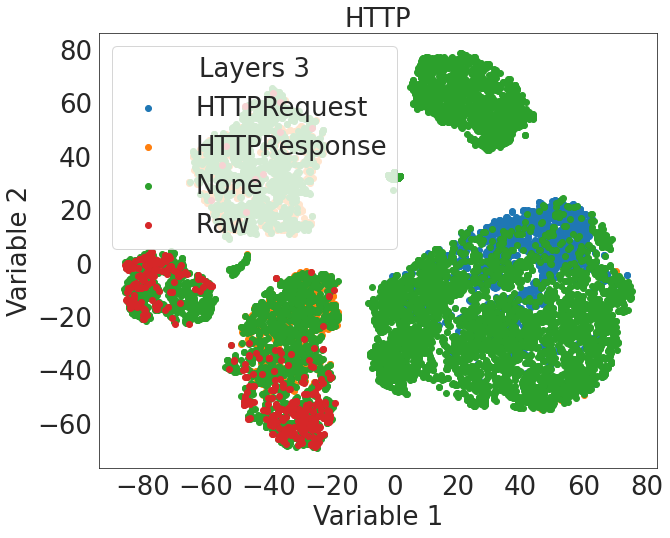

In [164]:
fig, ax = plt.subplots(
    1, 1, figsize=(10, 8))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=1.1)

# Set rank 
col = 'layers_3' #'direction' #'context_size'
unique_values = df_plot[col] \
                    .value_counts()\
                    .sort_index()\
                    .index

# Parcourir les axes


# En fonction de si c'est rank 0, rank 1, 2...etc (nombrede paquet)
# En focntion de la layer de niveau X (HTTP_reponse, REquest...etc)

# Define label
if (col == "packet_rank"):
    label = "Packet rank"
else:
    label = col

    
for val in unique_values:
    
    cond = (df_plot[col] == val)
    idx_cond = df_plot[cond].index

    ax.scatter(x=X_embedded[idx_cond, 0], 
               y=X_embedded[idx_cond, 1],
               marker='o',
               label=f"{val}",
               #c=color
              )

# Increase fontsize
for item in ax.get_yticklabels():
    item.set_fontsize(LABEL_FONTSIZE)
    #item.set_rotation(40)

for item in ax.get_xticklabels():
    item.set_fontsize(LABEL_FONTSIZE)
    #item.set_rotation(40)

# Set label  
ax.set_xlabel("Variable 1", 
              fontsize=LABEL_FONTSIZE)
ax.set_ylabel("Variable 2", 
              fontsize=LABEL_FONTSIZE)

# Set title
# 't-SNE projection'
if ("MQTT" in PROTO):
    ax.set_title(f"MQTT", 
              fontsize=TITLE_FONTSIZE)
elif ("COAP" in PROTO):
    ax.set_title(f"CoAP", 
              fontsize=TITLE_FONTSIZE)
elif ("LORA" in PROTO):
    ax.set_title(f"LoRaWAN", 
              fontsize=TITLE_FONTSIZE)
else:
    ax.set_title(f"{PROTO}", 
                  fontsize=TITLE_FONTSIZE)

# Set legend
if (col == 'context_size'):
    legend_title = "Packets in context"
    legend = ax.legend(fontsize=LEGEND_FONTSIZE,
                       loc='lower left')
elif (col == 'direction'):
    legend_title = "Direction"
    legend = ax.legend(['Client to server', 
                        "Server to client"],
                   fontsize=LEGEND_FONTSIZE,
                   loc='lower left')
elif ('layers' in col):
    num_layer = int(col.split("_")[-1])
    legend_title = f"Layers {num_layer}"
    legend = ax.legend(
                   fontsize=LEGEND_FONTSIZE)
else:
    legend = ax.legend(
                   fontsize=LEGEND_FONTSIZE,
                   loc='lower left')

legend.set_title(legend_title, 
                 prop={'size':LEGEND_FONTSIZE})

#### 4.6 Huffman table analysis (Bonus)

In [ ]:
df_huffman_groupby = pd.read_csv(f"{HUFFMAN_DIR}df_HUFFMAN_{FULL_NAME}{EXT_NAME_HUFFMAN}.csv")

### 4.3 Implementation

#### 4.3.1 Compression performance for number of decimals for proba value (only for Huffman ! if for DL we need to explore quantitazation for embedded Deep Learning)
*Note: We fix cutting value and check performance for np.uint8 proba*

In [ ]:
ERROR_BAR = True
DECIMALS_LIST = [1, 2, 4, 9] #, 64, 128]

data_results = pd.DataFrame()
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")
c_val = 8

for k_e in [True]:
    for d_val in DECIMALS_LIST:
        
        # Change extension name        
        if (k_e):
            ext_name_huffman =  "_HUFFMAN" + EXT_NAME + f"_KEEP_ERROR_{c_val}_DECIMALS{d_val}"
            filename = (f"{RESULTS_DIR}df_{FULL_NAME}{ext_name_huffman}"
                        f"_COMPRESSION.csv")
        else:
            ext_name_huffman = "_HUFFMAN" + EXT_NAME + f"_{c_val}_DECIMALS{d_val}"
            filename = (f"{RESULTS_DIR}df_{FULL_NAME}{ext_name_huffman}"
                        f"_COMPRESSION.csv")

        data_results_tmp = pd.read_csv(filename)
        
        data_results_tmp = features_extraction(
            data_raw=data_raw, 
            data_results=data_results_tmp)
        
        # Set values specific to huffman
        data_results_tmp["cut_values"] = int(c_val)
        data_results_tmp["dec_values"] = int(d_val)
        data_results_tmp["keep_error"] = k_e
        
        # Concat to array
        data_results = pd.concat(
            [data_results, 
             data_results_tmp], axis=0)

In [ ]:
# Change linewidth lengend 
from matplotlib.legend_handler import HandlerLine2D

# Plot MEAN and STD
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7.5))
alpha=0.95

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.28, 
                    hspace=0.35)

# Parcourir les axes

for ax, col, title in zip(
    axes.ravel(),
    ['compression_ratio', 'space_saving'],
    [f"Compression ratio", f"Space saving"]): #[f"compression ratio (U/C)", f"space saving [1-(C/U)]"]
    
    for k_e in [True]:
        
        # Get MEAN
    
        df_plot_mean = data_results[cond]\
            .groupby(["cut_values"])\
             .mean().reset_index()
        
        # Create ERROR BAR
        
        cond = (data_results["keep_error"] == k_e)
    
        p = ((1.0-alpha)/2.0) 
        df_plot_low_yerror = data_results[cond]\
                .groupby(["cut_values"])\
                 .quantile(p)\
                 .reset_index()[col]
        
        p = (alpha+((1.0-alpha)/2.0))
        df_plot_high_yerror = data_results[cond]\
                 .groupby(["cut_values"])\
                 .quantile(p) \
                 .reset_index()[col]
        err_bar = [(df_plot_mean[col]-df_plot_low_yerror).abs(), 
                   (df_plot_high_yerror-df_plot_mean[col]).abs()]
        
        # Plot error 
        
        if (ERROR_BAR):
            ax.errorbar(df_plot_mean['cut_values'], 
                        df_plot_mean[col],
                        linewidth=LINEWIDTH,
                        markersize=MARKERSIZE, # Size of point
                        fmt='o-', yerr=err_bar)
        else:
            ax1.scatter(df_plot_mean['cut_values'], 
                         df_plot_mean[col],
                         linewidth=LINEWIDTH)
        
    ax.set_ylabel(f"Mean {title}",
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel("Number of bits",
                  fontsize=LABEL_FONTSIZE)
    ax.tick_params(labelsize=TICK_FONTSIZE)
    ax.set_title(f"{PROTO}", #"Mean compression ratio in function of bit for huffman table",
                fontsize=TITLE_FONTSIZE)

def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(LINEWIDTH)
    
for ax in axes.ravel():
    
    # Set legend
    legend = ax.legend(
        ["True", "False"],
        fontsize=LEGEND_FONTSIZE,
        handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
    legend.set_title('Keep error', 
                     prop={'size':LEGEND_FONTSIZE})

#### 4.3.2 Consommation Mémoire

In [55]:
# Load results data
# MAX value are in bytes
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

data_results = pd.DataFrame()
data_results['rank_bit'] = [i for i in range(0, 100, 10)]
data_results['max_sketch_utilization'] = [294912]*10
data_results['max_ram_utilization'] = [1310720]*10

# HTTP
if (PROTO == "HTTP"):
    '''data_results['sketch_utilization'] = np.random.randint(0, 294912, 10) #[] 
    data_results['ram_utilization'] = np.random.randint(0, 1310720, 10) #[] '''
    data_results['proba_compress'] = np.random.randint(0, 1000, 10) #[] 
    data_results['proba_uncompress'] = np.random.randint(0, 1000, 10)

# SMTP
elif (PROTO == "SMTP"):
    '''data_results['sketch_utilization'] = np.random.randint(0, 294912, 10) #[] 
    data_results['ram_utilization'] = np.random.randint(0, 1310720, 10) #[] '''
    data_results['proba_compress'] = np.random.randint(0, 1000, 10) #[] 
    data_results['proba_uncompress'] = np.random.randint(0, 1000, 10) 

# DNS
elif (PROTO == "DNS"):
    '''data_results['sketch_utilization'] = np.random.randint(0, 294912, 10) #[] 
    data_results['ram_utilization'] = np.random.randint(0, 1310720, 10) #[] '''
    data_results['proba_compress'] = np.random.randint(0, 1000, 10) #[] 
    data_results['proba_uncompress'] = np.random.randint(0, 1000, 10)

# LORA_20
elif (PROTO == "LORA_20"):
    '''data_results['sketch_utilization'] = np.random.randint(0, 294912, 10) #[] 
    data_results['ram_utilization'] = np.random.randint(0, 1310720, 10) #[] '''
    data_results['proba_compress'] = np.random.randint(0, 1000, 10) #[] 
    data_results['proba_uncompress'] = np.random.randint(0, 1000, 10) 

# COAP
elif (PROTO == "COAP"):
    '''data_results['sketch_utilization'] = np.random.randint(0, 294912, 10) #[] 
    data_results['ram_utilization'] = np.random.randint(0, 1310720, 10) #[] '''
    data_results['proba_compress'] = np.random.randint(0, 1000, 10) #[] 
    data_results['proba_uncompress'] = np.random.randint(0, 1000, 10)  

# MQTT_IEEE
elif (PROTO == "MQTT_IEEE"):
    '''data_results['sketch_utilization'] = np.random.randint(0, 294912, 10) #[] 
    data_results['ram_utilization'] = np.random.randint(0, 1310720, 10) #[] '''
    data_results['proba_compress'] = np.random.randint(0, 1000, 10) #[] 
    data_results['proba_uncompress'] = np.random.randint(0, 1000, 10) 

NameError: name 'rank_bit' is not defined

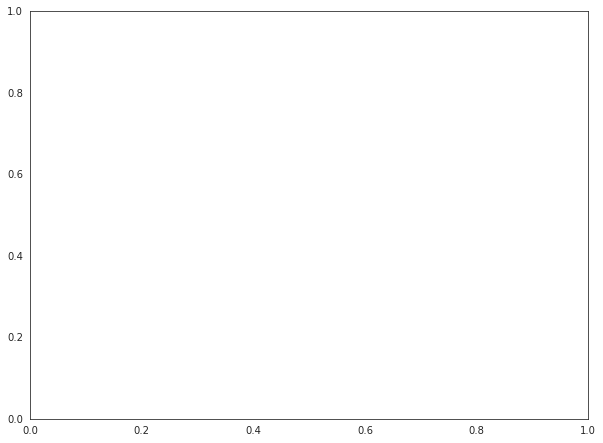

In [56]:
fig, ax = plt.subplots(
    1, 1, figsize=(10, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)

# Dataframe to plot
df_plot = pd.DataFrame()

## Compute ratio
'''sketch_ratio =  (data_results['sketch_utilization'] / \
        data_results['max_sketch_utilization']).values
ram_ratio =  (data_results['ram_utilization'] / \
        data_results['max_ram_utilization']).values
rank_bit = data_results['rank_bit'].values'''

## Set to df
df_plot['type_ratio'] = ["HDD"]*10 + ["RAM"]*10
df_plot['rank_bit'] = np.concatenate(
    (rank_bit, rank_bit), axis=-1)
df_plot['ratio'] = np.concatenate(
    (sketch_ratio, ram_ratio), axis=-1)

# Plot values
sns.barplot(x="rank_bit", y="ratio", 
            hue="type_ratio", data=df_plot,
            ax=ax)

# Set legend
legend = ax.legend(fontsize=LEGEND_FONTSIZE)
legend.set_title('Type', 
                 prop={'size':LEGEND_FONTSIZE})
        
for item in ax.get_yticklabels():
    item.set_fontsize(LABEL_FONTSIZE)

for item in ax.get_xticklabels():
    item.set_fontsize(LABEL_FONTSIZE)

# Set label  
ax.set_ylabel("Percentage of utilization", 
              fontsize=LABEL_FONTSIZE)
ax.set_xlabel(f"Max rank bit to compress", 
               fontsize=LABEL_FONTSIZE)

# Set title
if ("MQTT" in PROTO):
    ax.set_title(f"MQTT", 
              fontsize=TITLE_FONTSIZE)
elif ("COAP" in PROTO):
    ax.set_title(f"CoAP", 
              fontsize=TITLE_FONTSIZE)
elif ("LORA" in PROTO):
    ax.set_title(f"LoRaWAN", 
              fontsize=TITLE_FONTSIZE)
else:
    ax.set_title(f"{PROTO}", 
                  fontsize=TITLE_FONTSIZE)

In [ ]:
# Load results data
# MAX value are in bytes
PROTO = 'HTTP'
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

key_size = 8
key_range = (key_size**8)

data_results = pd.DataFrame()
data_results['bit_ranks'] = [i for i in range(100, 900, 100)]

# Si toute les proba était écrite
data_results['freqs_array_ref'] = \
        [i*(LOOK_BACK_CONTEXT+1)*key_range for i in range(100, 900, 100)]

data_results['position_array'] = \
        [i*(LOOK_BACK_CONTEXT+1)*key_size for i in range(100, 900, 100)]

# Give beginning 
data_results['freqs_count_array'] = \
        [i*(LOOK_BACK_CONTEXT+1) for i in range(100, 900, 100)]
data_results['freqs_count_context_array'] = \
        [(LOOK_BACK_CONTEXT+1) for i in range(100, 900, 100)] 

# HTTP
if (PROTO == "HTTP"):
    # Nombre de valeur de df_huffman_grouby
    # donc que si les proba de l'array etait ecrite 
    # [100, 200, 300, 400, 500, 600, 700, 800]
    data_results['huffman_table'] = [13860, 26243, 34604, 40734, 45582, 49901, 53730, 56189] 
    data_results['freqs_array_compress'] = [21180, 40181, 53015, 63139, 71954, 79847, 87011, 91720]

# SMTP
elif (PROTO == "SMTP"):
    data_results['huffman_table'] = np.random.randint(0, 56189, 8)
    data_results['freqs_array_compress'] = np.random.randint(0, 91720, 8)

# DNS
elif (PROTO == "DNS"):
    data_results['huffman_table'] = np.random.randint(0, 56189, 8)
    data_results['freqs_array_compress'] = np.random.randint(0, 91720, 8) 

# LORA_20
elif (PROTO == "LORA_20"):
    data_results['huffman_table'] = np.random.randint(0, 56189, 8)
    data_results['freqs_array_compress'] = np.random.randint(0, 91720, 8) 

# COAP
elif (PROTO == "COAP"):
    data_results['huffman_table'] = np.random.randint(0, 56189, 8)
    data_results['freqs_array_compress'] = np.random.randint(0, 91720, 8)

# MQTT_IEEE
elif (PROTO == "MQTT_IEEE"):
    data_results['huffman_table'] = np.random.randint(0, 56189, 8)
    data_results['freqs_array_compress'] = np.random.randint(0, 91720, 8)
    
# Extract relative values

## Combien de valeurs (en pourcentage) l'espace des valeurs etudiés
## par rapport à l'espace des possibilité
## Une valeur représente le % de valuer capture par rapport à l'espace
## des possibilitée !
data_results['huffman_table_norm'] = \
    data_results['huffman_table'] / data_results['freqs_array_ref']

## Combien de % de compression je perds
data_results['freqs_array_compress_norm'] = \
    data_results['freqs_array_compress'] / data_results['huffman_table']

In [17]:
# Load results data
# MAX value are in bytes
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

key_size = 8
key_range = (key_size**8)

data_results = pd.DataFrame()

# HTTP

# Nombre de valeur de df_huffman_grouby
# donc que si les proba de l'array etait ecrite 
# [100, 200, 300, 400, 500, 600, 700, 800]
data_results_tmp = pd.DataFrame()
data_results_tmp['huffman_table'] = [13860, 26243, 34604, 40734, 45582, 49901, 53730, 56189] 
data_results_tmp['freqs_array_compress'] = [21180, 40181, 53015, 63139, 71954, 79847, 87011, 91720]
data_results_tmp['proto'] = ['HTTP']*8
data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

# SMTP

data_results_tmp = pd.DataFrame()
data_results_tmp['huffman_table'] = [12867, 24216, 33895, 42039, 48965, 53929, 56841, 58045]
data_results_tmp['freqs_array_compress'] = [18549, 35416, 50958, 64437, 76273, 84934, 90108, 92233]
data_results_tmp['proto'] = ['SMTP']*8
data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

# DNS

data_results_tmp = pd.DataFrame()
data_results_tmp['huffman_table'] = [8826, 16968, 24750, 32305, 38787, 44114, 48889, 52257]
data_results_tmp['freqs_array_compress'] = [14181, 27247, 39910, 52528, 63552, 72748, 81180, 87163]
data_results_tmp['proto'] = ['DNS']*8
data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

# LORA_20

data_results_tmp = pd.DataFrame()
data_results_tmp['huffman_table'] = [17792, 28565, 31504, 31504, 31504, 31504, 31504, 31504]
data_results_tmp['freqs_array_compress'] = [24207, 40917, 46065, 46065, 46065, 46065, 46065, 46065]
data_results_tmp['proto'] = ['LoRaWAN']*8
data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

# COAP

data_results_tmp = pd.DataFrame()
data_results_tmp['huffman_table'] = [7725, 14996, 23081, 31566, 38909, 43228, 45742, 45961]
data_results_tmp['freqs_array_compress'] = [11706, 22757, 35175, 48442, 60222, 67824, 72313, 72699]
data_results_tmp['proto'] = ['CoAP']*8
data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

# MQTT_IEEE

data_results_tmp = pd.DataFrame()
data_results_tmp['huffman_table'] = [10384, 19480, 28805, 37393, 41700, 44402, 46337, 47390]
data_results_tmp['freqs_array_compress'] = [16136, 30206, 44791, 59067, 66278, 71238, 74935, 76908]
data_results_tmp['proto'] = ['MQTT']*8
data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)


# FOR ALL PROTOCOLS


data_results['bit_ranks'] = [i for i in range(100, 900, 100)] * 6

# Si toute les proba était écrite
data_results['freqs_array_ref'] = \
        [i*(LOOK_BACK_CONTEXT+1)*key_range for i in range(100, 900, 100)] * 6
data_results['position_array'] = \
        [i*(LOOK_BACK_CONTEXT+1)*key_size for i in range(100, 900, 100)] * 6

# Give beginning 
data_results['freqs_count_array'] = \
        [i*(LOOK_BACK_CONTEXT+1) for i in range(100, 900, 100)] * 6
data_results['freqs_count_context_array'] = \
        [(LOOK_BACK_CONTEXT+1) for i in range(100, 900, 100)] * 6
    
# Extract relative values

## Combien de valeurs (en pourcentage) l'espace des valeurs etudiés
## par rapport à l'espace des possibilité
## Une valeur représente le % de valuer capture par rapport à l'espace
## des possibilitée !
data_results['huffman_table_norm'] = \
    data_results['huffman_table'] / data_results['freqs_array_ref']

## Combien de % de compression je perds
data_results['freqs_array_compress_norm'] = \
    data_results['freqs_array_compress'] / data_results['huffman_table']

# Set to Kb ?
#data_results['huffman_table'] = \
#    data_results['huffman_table']*
#data_results['freqs_array_compress'] = 

In [18]:
# Setthe dict field
DICT_FIELDS = {}

if ('LORA' in PROTO):
    
    # LoRaWAN
    
    ## Mtype
    idx_start = 0
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Mtype"
            
    ## RFU
    idx_start = idx_end
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "RFU"
    
    ## Major
    idx_start = idx_end
    idx_end = idx_start + 2
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Major"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "DevAddr"
        
    ## Fctrl
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Fctrl"
        
    ## FCnt
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FCnt"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FOpts"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"


elif (PROTO in ['HTTP', 'SMTP', 'SSH', 'DNS']):
    
    # IPv4
    
    ## Set IP/HL/ToS
    idx_start = 0
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "IP/HL/ToS"
        
    ## Total length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Total length"
        
    ## Identification
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Identification"
        
    ## Indicator/FO
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Indicator/FO"
        
    ## TTL/Protocol
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "TTL/Protocol"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Source address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Destination address"
        
        
    # data_raw['length_0'] - data_raw['length_1']
    ip_header_length = (data_raw['length_0'] - \
                        data_raw['length_1']) \
                            .value_counts() \
                            .index.max()
    
    if (ip_header_length > 20):
        
        ## Options
        idx_start = idx_end
        idx_end = idx_start + 32
        for i in range(idx_start, idx_end):
            DICT_FIELDS[i] = "Options"
        
    
    print("[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end: ", 
          idx_end)
   # DICT_FIELDS = {v: k for k, v in enumerate(range(500))}
    
elif (PROTO in ["COAP", "MQTT_IEEE"]):
    
    # IPv6
    
    ## Version
    idx_start = 0
    idx_end = idx_start + 4
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Version"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Traffic class"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 20
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Flow label"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Payload length"
        
    ## Next header
    idx_start =  idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Next header"
        
    ## Hop limit
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Hop limit"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Source address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Destination address"


# Mettre champs TCP / UDP

if (PROTO in ['HTTP', 'SMTP', 'SSH', 'MQTT_IEEE']):
    
    # TCP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Source port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Destination port"
            
    ## Sequence number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Sequence number"
        
    ## ACK number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "ACK number"
        
    ## HL/Flags
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "HL/Flags"
        
    ## Windows
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Windows"
        
    ## CRC
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "CRC"
        
    ## Urgent pointer
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Urgent pointer"
        
    ## Option/Padding
    #idx_start = idx_end
    #idx_end = idx_start + 32
    #for i in range(idx_start, idx_end):
    #    DICT_FIELDS[i] = "Option/Padding"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"
        
    
elif (PROTO in ["DNS", 'COAP']):
    
    # UDP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Source port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Destination port"
        
    ## Length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Length"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"

[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end:  160


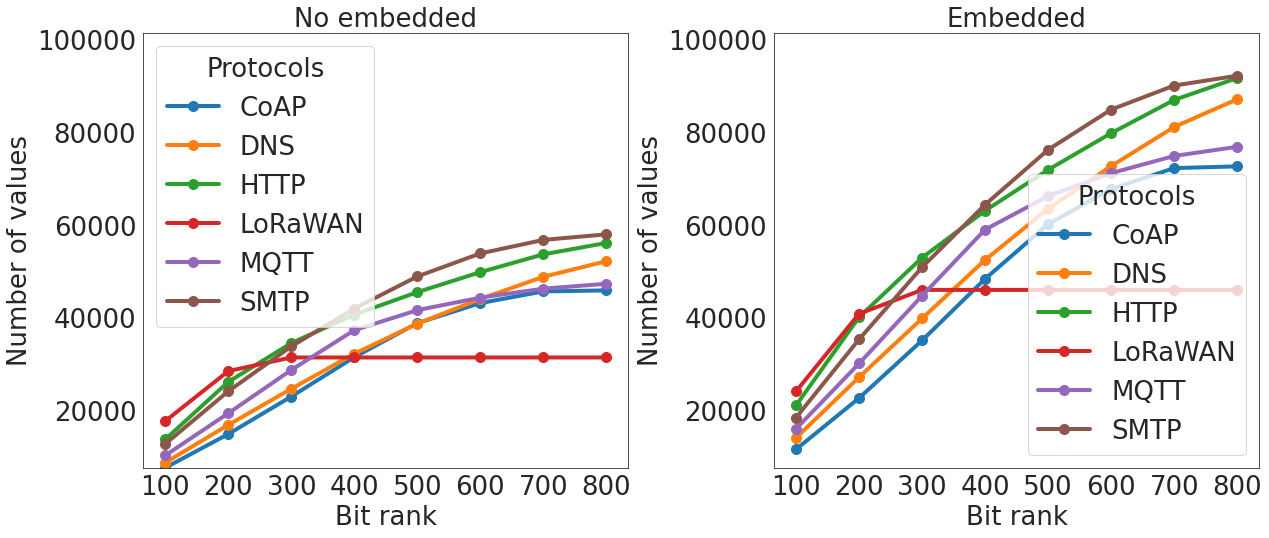

In [19]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 8))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.3, 
                    hspace=1.1)

df_plot = data_results.copy()

# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(),
    ["proto"]*2,
    ['huffman_table', 'freqs_array_compress'],
    ['No embedded', 'Embedded']):

    #ax1 = ax
    #ax2 = ax1.twiny()

    
    # SET FIRST AXIS
    
    # Set rank 
    unique_values = df_plot[hue] \
                        .value_counts() \
                        .sort_index() \
                        .index

    for val in unique_values:
        cond = (df_plot[hue] == val)

        # Set rank 
        ax.plot(df_plot[cond]['bit_ranks'], 
                 df_plot[cond][col].astype(int),
                 linewidth=LINEWIDTH,
                 markersize=MARKERSIZE, # Size of point
                 alpha=1,
                 label=f"{val}",
                 marker='o',
                 #linestyle="--",
                )

    # Set legend
    legend = ax.legend(fontsize=LEGEND_FONTSIZE)
    legend.set_title('Protocols', 
                     prop={'size':LEGEND_FONTSIZE})
        

    for item in ax.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax.set_ylabel('Number of values', 
                   fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)
    
    # Set axis limit
    lower_ylimit = df_plot[
        ['huffman_table', 
         'freqs_array_compress']].min().min()
    upper_ylimit = df_plot[
        ['huffman_table', 
         'freqs_array_compress']].max().max()
    upper_ylimit = upper_ylimit + \
        upper_ylimit*0.1
    
    #print("[DEBUG] lower_ylimit: ", lower_ylimit)
    #print("[DEBUG] upper_ylimit: ", upper_ylimit)
    
    ax.set_ylim([lower_ylimit, 
                 upper_ylimit])

    # Set title
    ax.set_title(f"{title}", 
                  fontsize=TITLE_FONTSIZE)

    # SET SECOND AXIS


    '''def tick_function(ranks_bit):
        values = []
        for val in ranks_bit:
            values.append(
                DICT_FIELDS[val])
        return values

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    #if (hue is None):
    new_tick_locations = [i for i in range(
        0, idx_end, 64)]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(
        tick_function(new_tick_locations))

    # Set field name
    #ax2 = ax1.twiny()
    ax2.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax2.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(70)

    ax2.grid(False)'''

Text(0.5, 1.0, 'SMTP')

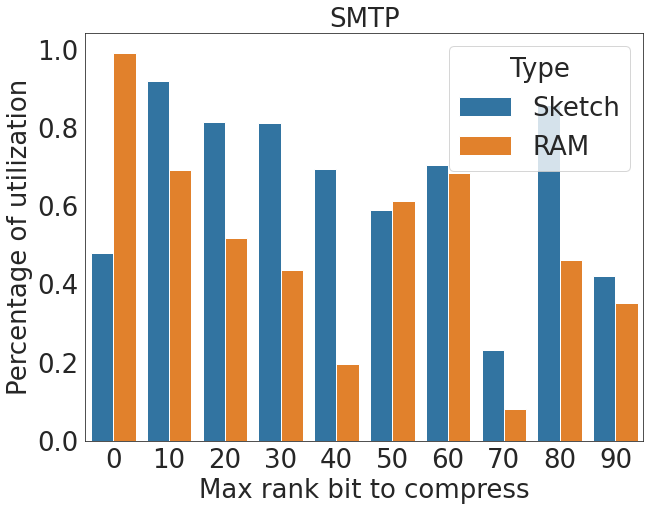

In [37]:
fig, ax = plt.subplots(
    1, 1, figsize=(10, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)

# Dataframe to plot
df_plot = pd.DataFrame()

## Compute ratio
'''sketch_ratio =  (data_results['sketch_utilization'] / \
        data_results['max_sketch_utilization']).values
ram_ratio =  (data_results['ram_utilization'] / \
        data_results['max_ram_utilization']).values
rank_bit = data_results['rank_bit'].values'''

## Set to df
df_plot['type_ratio'] = ["HDD"]*10 + ["RAM"]*10
df_plot['rank_bit'] = np.concatenate(
    (rank_bit, rank_bit), axis=-1)
df_plot['ratio'] = np.concatenate(
    (sketch_ratio, ram_ratio), axis=-1)

# Plot values
sns.barplot(x="rank_bit", y="ratio", 
            hue="type_ratio", data=df_plot,
            ax=ax)

# Set legend
legend = ax.legend(fontsize=LEGEND_FONTSIZE)
legend.set_title('Type', 
                 prop={'size':LEGEND_FONTSIZE})
        
for item in ax.get_yticklabels():
    item.set_fontsize(LABEL_FONTSIZE)

for item in ax.get_xticklabels():
    item.set_fontsize(LABEL_FONTSIZE)

# Set label  
ax.set_ylabel("Percentage of utilization", 
              fontsize=LABEL_FONTSIZE)
ax.set_xlabel(f"Max rank bit to compress", 
               fontsize=LABEL_FONTSIZE)

# Set title
if ("MQTT" in PROTO):
    ax.set_title(f"MQTT", 
              fontsize=TITLE_FONTSIZE)
elif ("COAP" in PROTO):
    ax.set_title(f"CoAP", 
              fontsize=TITLE_FONTSIZE)
elif ("LORA" in PROTO):
    ax.set_title(f"LoRaWAN", 
              fontsize=TITLE_FONTSIZE)
else:
    ax.set_title(f"{PROTO}", 
                  fontsize=TITLE_FONTSIZE)

#### 4.3.2 Consommation temps

In [46]:
# Load results data
# MAX value are in bytes
ERROR_BAR = True
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

# Set df results
data_results = pd.DataFrame()
max_length = data_raw['length_total'].max()
data_results['max_packet_size'] = [max_length]*10
data_results['packet_size'] = \
        [int((max_length/10)*i) for i in range(10)]

# HTTP
if (PROTO == "HTTP"):
    data_results['time_mean'] = np.random.randint(5, 10, 10) #[] 
    data_results['time_std'] = np.random.randint(0, 3, 10)

# SMTP
elif (PROTO == "SMTP"):
    data_results['time_mean'] = np.random.randint(5, 10, 10) #[] 
    data_results['time_std'] = np.random.randint(0, 3, 10)

# DNS
elif (PROTO == "DNS"):
    data_results['time_mean'] = np.random.randint(5, 10, 10) #[] 
    data_results['time_std'] = np.random.randint(0, 3, 10)

# LORA_20
elif (PROTO == "LORA_20"):
    data_results['time_mean'] = np.random.randint(5, 10, 10) #[] 
    data_results['time_std'] = np.random.randint(0, 3, 10)

# COAP
elif (PROTO == "COAP"):
    data_results['time_mean'] = np.random.randint(5, 10, 10) #[] 
    data_results['time_std'] = np.random.randint(0, 3, 10)

# MQTT_IEEE
elif (PROTO == "MQTT_IEEE"):
    data_results['time_mean'] = np.random.randint(5, 10, 10) #[] 
    data_results['time_std'] = np.random.randint(0, 3, 10)

In [ ]:
# Load results data
# MAX value are in bytes
ERROR_BAR = True
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

# Set df results
data_results = pd.DataFrame()
max_length = data_raw['length_total'].max()
data_results['max_packet_size'] = [max_length]*10

# HTTP
    
data_results_tmp = pd.DataFrame()
data_results_tmp['time'] = []
data_results_tmp['packet_size'] = []
data_results_tmp['proto'] = ['HTTP']*8
data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

# SMTP

data_results_tmp = pd.DataFrame()
data_results_tmp['time'] = []
data_results_tmp['packet_size'] = []
data_results_tmp['proto'] = ['SMTP']*8
data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

# DNS

data_results_tmp = pd.DataFrame()
data_results_tmp['time'] = []
data_results_tmp['packet_size'] = []
data_results_tmp['proto'] = ['DNS']*8
data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

# LORA_20

data_results_tmp = pd.DataFrame()
data_results_tmp['time'] = []
data_results_tmp['packet_size'] = []
data_results_tmp['proto'] = ['LORA_20']*8
data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

# COAP

data_results_tmp = pd.DataFrame()
data_results_tmp['time'] = []
data_results_tmp['packet_size'] = []
data_results_tmp['proto'] = ['COAP']*8
data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

# MQTT_IEEE

data_results_tmp = pd.DataFrame()
data_results_tmp['time'] = []
data_results_tmp['packet_size'] = []
data_results_tmp['proto'] = ['MQTT_IEEE']*8
data_results = pd.concat(
    [data_results, data_results_tmp], axis=0)

# Théotiquement on devrait voir un lien
# entre la taille de la table et le temps
# de compression

Text(0.5, 1.0, 'SMTP')

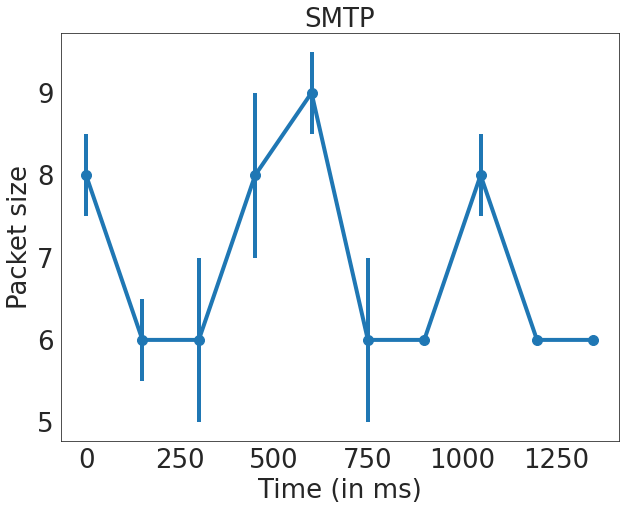

In [53]:
# Change linewidth lengend 
from matplotlib.legend_handler import HandlerLine2D

# Plot MEAN and STD
fig, ax = plt.subplots(
    1, 1, figsize=(10, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.28, 
                    hspace=0.35)


# Set dataframe

df_plot = data_results.copy()

# Create ERROR BAR

err_bar = [(df_plot['time_std']).abs()/2, 
           (df_plot['time_std']).abs()/2]

# Plot error 

if (ERROR_BAR):
    ax.errorbar(df_plot['packet_size'], 
                df_plot['time_mean'],
                linewidth=LINEWIDTH,
                markersize=MARKERSIZE, # Size of point
                fmt='o-', yerr=err_bar)
else:
    ax1.scatter(df_plot['packet_size'], 
                df_plot['time_mean'],
                linewidth=LINEWIDTH)

ax.set_ylabel(f"Packet size",
              fontsize=LABEL_FONTSIZE)
ax.set_xlabel("Time (in ms)",
              fontsize=LABEL_FONTSIZE)
ax.tick_params(labelsize=TICK_FONTSIZE)

# Set title
if ("MQTT" in PROTO):
    ax.set_title(f"MQTT", 
              fontsize=TITLE_FONTSIZE)
elif ("COAP" in PROTO):
    ax.set_title(f"CoAP", 
              fontsize=TITLE_FONTSIZE)
elif ("LORA" in PROTO):
    ax.set_title(f"LoRaWAN", 
              fontsize=TITLE_FONTSIZE)
else:
    ax.set_title(f"{PROTO}", 
                  fontsize=TITLE_FONTSIZE)

#### 4.3.3 Consommation batterie

In [92]:
# Load results data
# MAX value are in bytes
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

data_results = pd.DataFrame()
data_results_tmp = pd.DataFrame()

# HTTP
proto = 'HTTP'
data_results_tmp[f'mAh_compression_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mWh_compression_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mAh_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mWh_{proto}'] = np.random.rand(10) #[] 

# SMTP
proto = 'SMTP'
data_results_tmp[f'mAh_compression_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mWh_compression_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mAh_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mWh_{proto}'] = np.random.rand(10) #[] 

# DNS
proto = 'DNS'
data_results_tmp[f'mAh_compression_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mWh_compression_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mAh_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mWh_{proto}'] = np.random.rand(10) #[] 

# LORA_20
proto = 'LORA_20'
data_results_tmp[f'mAh_compression_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mWh_compression_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mAh_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mWh_{proto}'] = np.random.rand(10) #[]  

# COAP
proto = 'COAP'
data_results_tmp[f'mAh_compression_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mWh_compression_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mAh_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mWh_{proto}'] = np.random.rand(10) #[] 

# MQTT_IEEE
proto = 'MQTT_IEEE'
data_results_tmp[f'mAh_compression_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mWh_compression_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mAh_{proto}'] = np.random.rand(10) #[] 
data_results_tmp[f'mWh_{proto}'] = np.random.rand(10) #[] 

In [93]:
for col in ['mAh_compression', 
            'mWh_compression', 
            'mAh', 'mWh']:
    
    values = np.array([])
    protos = np.array([])
    
    for proto in ["HTTP", 'SMTP', 'DNS', 
                  'LORA_20', "COAP", 'MQTT_IEEE']:
    
        column = col + '_' + proto
        
        # Add values
        values_tmp = data_results_tmp[column].values
        values = np.concatenate(
            (values, values_tmp), axis=-1)
        
        # Add proto
        protos_tmp = [proto]*values_tmp.size
        protos = np.concatenate(
            (protos, protos_tmp), axis=-1)
        
    data_results[col] = values
    data_results["proto"] = protos

In [107]:
data_results_new = pd.DataFrame()

data_results_new['mAh'] = np.concatenate((data_results['mAh_compression'].values,
                                          data_results['mAh'].values))
data_results_new['mWh'] = np.concatenate((data_results['mWh_compression'].values,
                                          data_results['mWh'].values))
data_results_new['Mode'] = np.concatenate((["Compression"]*data_results.shape[0],
                                                  ["No compression"]*data_results.shape[0]))
data_results_new['proto'] = np.concatenate((data_results['proto'].values,
                                            data_results['proto'].values))

[Text(0, 0, 'HTTP'),
 Text(1, 0, 'SMTP'),
 Text(2, 0, 'DNS'),
 Text(3, 0, 'LoraWAN'),
 Text(4, 0, 'CoAP'),
 Text(5, 0, 'MQTT')]

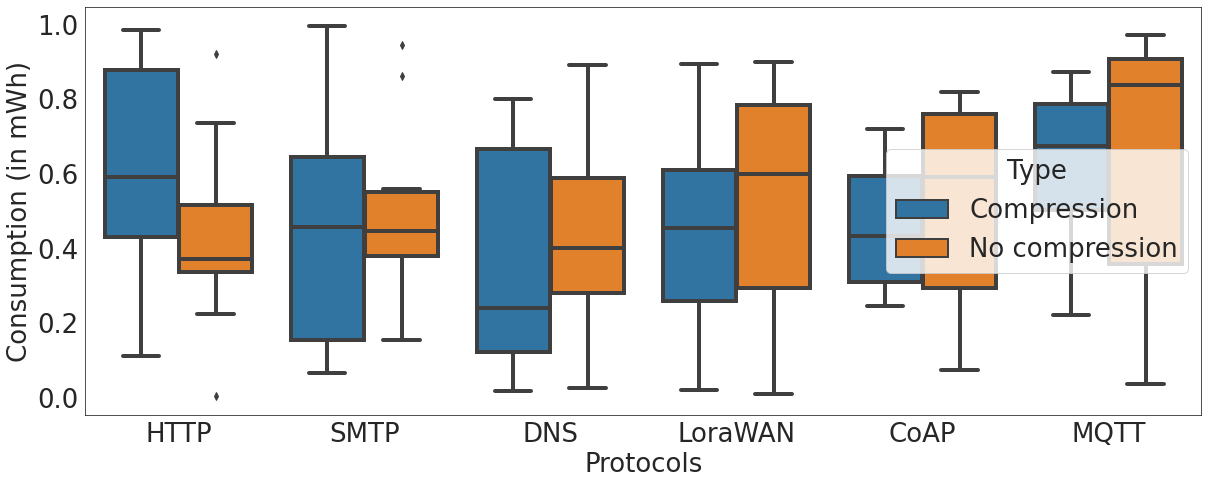

In [115]:
fig, ax = plt.subplots(
    1, 1, figsize=(20, 7.5))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)

# Dataframe to plot
df_plot = data_results_new.copy()

# Plot values
sns.boxplot(x="proto", y="mWh", 
            linewidth=LINEWIDTH,
            hue="Mode", data=df_plot, 
            ax=ax)

# Set legend
legend = ax.legend(fontsize=LEGEND_FONTSIZE)
legend.set_title('Type', 
                 prop={'size':LEGEND_FONTSIZE})
        
for item in ax.get_yticklabels():
    item.set_fontsize(LABEL_FONTSIZE)

for item in ax.get_xticklabels():
    item.set_fontsize(LABEL_FONTSIZE)

# Set label  
ax.set_ylabel("Consumption (in mWh)", 
              fontsize=LABEL_FONTSIZE)
ax.set_xlabel(f"Protocols", 
               fontsize=LABEL_FONTSIZE)

# Change label name
xticklabels = ['HTTP', 'SMTP', 'DNS', 
               'LoraWAN', 'CoAP', 'MQTT']
ax.set_xticklabels(
    xticklabels)

In [15]:
arr_test = np.load("MODELS/HUFFMAN/arr_index_pos_HUFFMAN_LOSSLESS_CONTEXT2_PACKET16_SIN8_LORA_20_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_20.npy")

In [16]:
df_test = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_MQTT_IEEE.csv")

In [17]:
df_test['length_total'].max() / 8

168.0

In [18]:
168*2+16

352

In [21]:
df_huffman_groupby = pd.read_csv(f"{HUFFMAN_DIR}df_HUFFMAN_LOSSLESS_CONTEXT2_PACKET16_SIN8_MQTT_IEEE_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_20.csv")
array_index_pos = np.load(f"{HUFFMAN_DIR}arr_index_pos_HUFFMAN_LOSSLESS_CONTEXT2_PACKET16_SIN8_MQTT_IEEE_WITH_CHECKSUM_CUSTOM_SIZE100_MODE_EQUIPtrain_20.npy")


# CHANGE DATAFRAME FORMAT 
def my_func(x, max_length=8):
    value = str(x)
    length = len(value)
    value_extend = "0"*(max_length-length)
    value = value_extend + value
    return value 


df_huffman_groupby['key'] = df_huffman_groupby['key'].map(
    lambda x : my_func(x, max_length=CUT_VALUE))
df_huffman_groupby = df_huffman_groupby.groupby(
    ['ctx', 'pos', 'key']).mean()

In [22]:
array_index_pos.shape

(3, 778, 20)

In [29]:
df_huffman_groupby.loc[0, 731]

proba
key                                                      
00000000000000000000000000000000000000000000000...    1.0

## 5. Interpretation

### 5.1 Code

In [ ]:
def extract_flows(data_raw,
                  arr_raw):

    # EXTRACT FLOWS

    df_raw = data_raw.copy()

    # Extraction d'un dictonnaire avec flux -> taille
    df_new = df_raw[['flow_id', 'timestamps']].groupby(
                    ['flow_id']).min().rename(
                    columns={'timestamps': 'flow_id_count'})

    # Utilisation de map function pour flux -> taille
    dict_map = df_new.to_dict()['flow_id_count']
    df_raw['flow_count'] = df_raw['flow_id'].map(dict_map)

    # Utilisation de map function pour timestamps + nombre de jour qui correpsond à l'ID
    df_min = df_raw[['flow_id', 'timestamps']].groupby(
        ['flow_id']).min().rename(columns={'timestamps': 'min'})
    df_min['pad'] = df_min.index.values*10000000
        #'min'].map(lambda x : np.random.randint(0, 5000, size=(1,))[0])
    dict_pad = df_min.to_dict()['pad']

    def some_func(a, b):
        #print(dict_pad[a])
        return b+dict_pad[a]

    df_raw['timestamps_update'] = df_raw[['flow_id', 'timestamps']].apply(
        lambda x: some_func(a=x['flow_id'], b=x['timestamps']), axis=1)

    # On sort en fonction de la timestamps (les flux sont autamiquement groupe)
    df_raw = df_raw.sort_values(by=['timestamps_update'], ascending=True)
    indexes_update = df_raw.index.values 

    # J'applique l'insertion pour récuperer les index proprement
    # Mettre les la numerotation des index
    df_raw = df_raw.reset_index(drop=True)
    arr_update = arr_raw[indexes_update]

    ## On extrait les index max de chaque flux (voir index result)
    indexes = df_raw.duplicated(subset=['flow_id'], keep='first')
    index_val = df_raw.index[~indexes].values
    index_min = index_val.copy()

    ## On créer les index min de chaque flux (voir index result) ET on fait la diff
    indexes = df_raw.duplicated(subset=['flow_id'], keep='last')
    index_val = df_raw.index[~indexes].values
    index_max = index_val.copy()

    ## On attribue les index_min et les index_max
    df_new = df_raw[['flow_id']].drop_duplicates(
        subset=['flow_id'], keep='first')
    df_new['index_min'] = index_min
    df_new['index_max'] = index_max
    df_new = df_new.set_index('flow_id')

    dict_index_min = df_new[["index_min"]].to_dict()['index_min']
    dict_index_max = df_new[["index_max"]].to_dict()['index_max']
    df_raw['index_min'] = df_raw['flow_id'].map(dict_index_min)
    df_raw['index_max'] = df_raw['flow_id'].map(dict_index_max)
    
    # Extract relative position of packet
    df_raw['index_rltv_flow'] = df_raw.index - \
                    df_raw['index_min']
    
    return df_raw, arr_update

In [ ]:
def get_idx_unique(
    df_raw, arr_update):
    
    # EXTRACT DATA

    if (CUSTOM_SIZE is not None):
        headers_length = np.fmin(CUSTOM_SIZE,
                                 df_raw['length_total'].values)
    else:
        headers_length = np.fmin(df_raw['header_length'].values + EXTRA_SIZE,
                                 df_raw['length_total'].values)

    packets_rank = (df_raw.index.values - df_raw['index_min']).values
    packets = arr_update
    block_length = (headers_length*8 - \
                    LOOK_BACK_PACKET).astype(int)

    # Filter unique paquet
    _, idx_unique = np.unique(packets, 
                              return_index=True,  
                              axis=0)
    idx_unique = np.sort(idx_unique, axis=-1, 
                kind=None, order=None)

    # Remove packet where block length
    # if negative
    # If size is less than the idx its
    # useless to compress !!!
    idx_unique_positive = np.where(
        block_length > 0)
    idx_unique = np.intersect1d(
        idx_unique, idx_unique_positive)
    idx_unique = np.sort(idx_unique, axis=-1, 
                kind=None, order=None)
    
    return idx_unique

In [ ]:
def get_idx_equipment(
    df_raw, idx_unique):
    
    # SELECTION EQUIPMENT 

    if ("LORA" in PROTO):
        col = "device_address"
    else:
        col = "ip_src"


    if ((NB_EQUIP_MAX is None) or
        (NB_EQUIP_TRAIN is None)):

        np.random.seed(np.random.randint(0, 3000))
        idx_unique = \
            np.random.choice(idx_unique, 
                             QUANTITY_PACKET, 
                             replace=False)
        #idx_unique = idx_unique[
        #    :QUANTITY_PACKET]
        idx_unique = np.sort(idx_unique, axis=-1, 
                    kind=None, order=None)

    else:

        if ("LORA" in PROTO):

            list_device_address = []
            list_gateway = []

            flows_id_mac = df_raw[
                "device_address"].value_counts().index

            for f_mac in flows_id_mac:

                cond = (df_raw[
                   "device_address"] == f_mac)

                device_address_tmp = df_raw[
                    cond].iloc[0]['device_address']
                gateway_tmp = df_raw[
                    cond].iloc[0]['gateway']

                # Verifier que les IP ne sont pas deja présentes
                # parmis l'IP src
                if (device_address_tmp in list_device_address):
                    pass
                else:
                    list_device_address.append(
                        device_address_tmp)
                    list_gateway.append(
                        gateway_tmp)

            # Select equipement
            if (MODE_EQUIP == "train"):
                list_device_address = list_device_address[:NB_EQUIP_TRAIN]
                list_gateway = list_gateway[:NB_EQUIP_TRAIN]
                NB_EQUIP_LIMIT = NB_EQUIP_TRAIN
            elif (MODE_EQUIP == "test"):
                list_device_address = list_device_address[
                    NB_EQUIP_TRAIN:NB_EQUIP_MAX]
                list_gateway = list_gateway[
                    NB_EQUIP_TRAIN:NB_EQUIP_MAX]
                NB_EQUIP_LIMIT = NB_EQUIP_MAX - NB_EQUIP_TRAIN
            else:
                list_device_address = list_device_address[:NB_EQUIP_MAX]
                list_gateway = list_gateway[:NB_EQUIP_MAX]
                NB_EQUIP_LIMIT = NB_EQUIP_MAX

            print("[DEBUG] list_device_address: ", list_device_address)
            print("[DEBUG] list_gateway: ", list_gateway)

            # Parmis les equipement selectionner prendre les flow_ids un pour chaque
            # jusqu'a que le nombre max de paquet soit atteint !
            cond = ((df_raw["device_address"].isin(list_device_address)) &
                    (df_raw["gateway"].isin(list_gateway)))

            flows_id = df_raw[cond]['flow_id']\
                            .value_counts(ascending=True)\
                            .index

            # For uniformisation
            nb_device_address = len(list_device_address)

        else:

            # Trouver les flow_id_ip a prendre (cinq equipement avec des adress ip_src différente)
            list_ip_src = []
            list_ip_dst = []

            flows_id_mac = df_raw[
                "flow_id_ip"].value_counts().index

            for f_mac in flows_id_mac:

                cond = (df_raw[
                    "flow_id_ip"] == f_mac)

                ip_src_tmp = df_raw[
                    cond].iloc[0]['ip_src']
                ip_dst_tmp = df_raw[
                    cond].iloc[0]['ip_dst']

                # Verifier que les IP ne sont pas deja présentes
                # parmis l'IP src
                if (ip_src_tmp in list_ip_src):
                    pass
                else:
                    list_ip_src.append(ip_src_tmp)
                    list_ip_dst.append(ip_dst_tmp)

            # Select equipement
            if (MODE_EQUIP == "train"):
                list_ip_src = list_ip_src[:NB_EQUIP_TRAIN]
                list_ip_dst = list_ip_dst[:NB_EQUIP_TRAIN]
                NB_EQUIP_LIMIT = NB_EQUIP_TRAIN
            elif (MODE_EQUIP == "test"):
                list_ip_src = list_ip_src[
                    NB_EQUIP_TRAIN:NB_EQUIP_MAX]
                list_ip_dst = list_ip_dst[
                    NB_EQUIP_TRAIN:NB_EQUIP_MAX]
                NB_EQUIP_LIMIT = NB_EQUIP_MAX - NB_EQUIP_TRAIN
            else:
                list_ip_src = list_ip_src[:NB_EQUIP_MAX]
                list_ip_dst = list_ip_dst[:NB_EQUIP_MAX]
                NB_EQUIP_LIMIT = NB_EQUIP_MAX

            print("[DEBUG] list_ip_src: ", list_ip_src)
            print("[DEBUG] list_ip_dst: ", list_ip_dst)

            # Parmis les equipement selectionner prendre les flow_ids un pour chaque
            # jusqu'a que le nombre max de paquet soit atteint !
            cond = ((df_raw["ip_src"].isin(list_ip_src)) &
                    (df_raw["ip_dst"].isin(list_ip_dst)))

            flows_id = df_raw[cond]['flow_id']\
                            .value_counts(ascending=True)\
                            .index

            # For uniformisation
            nb_device_address = len(list_ip_src)


    nb_pkt = 0
    i = 0
    nb_equipment = 0
    list_flows_id = []

    # On collecte un certains nombre de paquet
    # mais il faut que des paquets de tous les equipements 
    # selectionné soit pris. Sinon on echantillonne
    # avec le dernier if
    cond_while = (((nb_pkt < QUANTITY_PACKET) or 
                  (nb_equipment < nb_device_address)) and 
                  (i < len(flows_id)-1))
    while (cond_while):

        cond_while = (((nb_pkt < QUANTITY_PACKET) or 
                      (nb_equipment < nb_device_address)) and 
                      (i < len(flows_id)-1))

        list_flows_id.append(flows_id[i])
        cond = (df_raw[
            'flow_id'] == flows_id[i])

        nb_pkt += df_raw[
            cond].shape[0]
        i += 1

        # Count number of device address
        cond = (df_raw['flow_id'].isin(list_flows_id))
        nb_equipment = df_raw[cond][
            col].value_counts().shape[0]


    # Collect indexes
    cond = (df_raw['flow_id'].isin(list_flows_id))
    idx_unique_equipment = df_raw[cond].index
    idx_unique = np.intersect1d(
        idx_unique, idx_unique_equipment)
    idx_unique = np.sort(idx_unique, axis=-1, 
                kind=None, order=None)

    # Apply correction !
    # Si le nb de paquet est supérieur ou égale
    # alors on a du en pendre plus pour pouvoir
    # couvrir tous les equipements
    print("[DEBUG] len(idx_unique) : ", len(idx_unique))
    print("[DEBUG] QUANTITY_PACKET : ", QUANTITY_PACKET)

    if (len(idx_unique) >= QUANTITY_PACKET):
        print("[DEBUG][nb_pkt >= QUANTITY_PACKET] Apply undersampling !")

        idx_unique = \
            np.random.choice(idx_unique, 
                             QUANTITY_PACKET, 
                             replace=False)
        idx_unique = np.sort(idx_unique, axis=-1, 
                kind=None, order=None)


    nb_equipment = df_raw.iloc[
        idx_unique][col] \
        .value_counts().shape[0]

    # Verifier que le nombre de equipements sont couvert
    if (nb_equipment < nb_device_address):
        print("[DEBUG][WARNING !] Le nombre d'équiment choisi n'est pas présent !")
        raise Exception

    if (nb_equipment < NB_EQUIP_LIMIT):
        print("[DEBUG][WARNING !] Le nombre d'équiment choisi est inférieur à NB_EQUIP_MAX !")
        raise Exception
        
    return idx_unique

In [ ]:
def get_split_idx_unique(
    df_raw, idx_unique):
    
    # SELECT UNIQUE PACKET AND SPLIT WITH TEST

    # Remove packets will be used for test
    # compression
    # It's useless to split test data in case 
    # of test mode (equipement)
    idx_unique_test = df_raw.iloc[idx_unique].sample(
        frac=0.1, weights='flow_id', 
        replace=False, random_state=42).index.values
    idx_unique_test = np.sort(idx_unique_test)
    print("[DEBUG] idx_unique_test.shape: ", idx_unique_test.shape)
    idx_unique = np.setdiff1d(
        idx_unique, idx_unique_test)
    idx_unique = np.sort(idx_unique)

    return idx_unique, idx_unique_test

#### 4.2.1 Compression performance (lineplot over bit rank)

In [72]:
# Explain the burst we see throw dataERROR_BAR = True
data_results = pd.read_csv(f"./RESULTS/df_{FULL_NAME}{EXT_NAME}_COMPRESSION.csv")
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

In [73]:
data_results = features_extraction(
        data_raw=data_raw, 
        data_results=data_results)

In [74]:
# Setthe dict field
DICT_FIELDS = {}

if ('LORA' in PROTO):
    
    # LoRaWAN
    
    ## Mtype
    idx_start = 0
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Mtype"
            
    ## RFU
    idx_start = idx_end
    idx_end = idx_start + 3
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "RFU"
    
    ## Major
    idx_start = idx_end
    idx_end = idx_start + 2
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Major"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "DevAddr"
        
    ## Fctrl
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Fctrl"
        
    ## FCnt
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FCnt"
        
    ## DevAddr
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "FOpts"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"


elif (PROTO in ['HTTP', 'SMTP', 'SSH', 'DNS']):
    
    # IPv4
    
    ## Set IP/HL/ToS
    idx_start = 0
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "IP/HL/ToS"
        
    ## Total length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Total length"
        
    ## Identification
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Identification"
        
    ## Indicator/FO
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Indicator/FO"
        
    ## TTL/Protocol
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "TTL/Protocol"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Source address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Destination address"
        
        
    # data_raw['length_0'] - data_raw['length_1']
    ip_header_length = (data_raw['length_0'] - \
                        data_raw['length_1']) \
                            .value_counts() \
                            .index.max()
    
    if (ip_header_length > 20):
        
        ## Options
        idx_start = idx_end
        idx_end = idx_start + 32
        for i in range(idx_start, idx_end):
            DICT_FIELDS[i] = "Options"
        
    
    print("[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end: ", 
          idx_end)
   # DICT_FIELDS = {v: k for k, v in enumerate(range(500))}
    
elif (PROTO in ["COAP", "MQTT_IEEE"]):
    
    # IPv6
    
    ## Version
    idx_start = 0
    idx_end = idx_start + 4
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Version"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Traffic class"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 20
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Flow label"
        
    ## Traffic class
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Payload length"
        
    ## Next header
    idx_start =  idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Next header"
        
    ## Hop limit
    idx_start = idx_end
    idx_end = idx_start + 8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Hop limit"
        
    ## Source address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Source address"
        
    ## Destination address
    idx_start = idx_end
    idx_end = idx_start + 16*8
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Destination address"


# Mettre champs TCP / UDP

if (PROTO in ['HTTP', 'SMTP', 'SSH', 'MQTT_IEEE']):
    
    # TCP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Source port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Destination port"
            
    ## Sequence number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Sequence number"
        
    ## ACK number
    idx_start = idx_end
    idx_end = idx_start + 32
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "ACK number"
        
    ## HL/Flags
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "HL/Flags"
        
    ## Windows
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Windows"
        
    ## CRC
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "CRC"
        
    ## Urgent pointer
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Urgent pointer"
        
    ## Option/Padding
    #idx_start = idx_end
    #idx_end = idx_start + 32
    #for i in range(idx_start, idx_end):
    #    DICT_FIELDS[i] = "Option/Padding"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"
        
    
elif (PROTO in ["DNS", 'COAP']):
    
    # UDP
    
    ## Source port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Source port"
        
    ## Destination port
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Destination port"
        
    ## Length
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Length"
        
    ## Checksum
    idx_start = idx_end
    idx_end = idx_start + 16
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Checksum"
        
    ## Data
    idx_start = idx_end
    if (CUSTOM_SIZE is not None):
        idx_end = min(CUSTOM_SIZE*8, 
            data_raw['length_total'].max()*8)
    else:
        idx_end = int(min((data_raw['header_length'].max()+EXTRA_SIZE)*8, 
            data_raw['length_total'].max()*8))
    for i in range(idx_start, idx_end):
        DICT_FIELDS[i] = "Data"

[DEBUG][elif (PROTO in ['HTTP', 'SMTP', 'SSH'])] idx_end:  160


In [78]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
sizes_context = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []


for i in [0]: #range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    # IF l'array is empty
    if (data_results_tmp.shape[0] != 0):
        
        # Init first steps
        
        bit_ranks.append(0)
        compression_ratio.append(0)
        space_saving.append(0)
        sizes_context.append(i)
        
        low_yerror_compression_ratio.append(0)
        high_yerror_compression_ratio.append(0)
        
        low_yerror_space_saving.append(0)
        high_yerror_space_saving.append(0)
        
        # Compute each compress level

        for col in data_results.columns:
            if ("level_compress" in col):

                # Add context size info
                sizes_context.append(i)

                # Extract bit rank
                bit_rank = int(col.split("_")[-1])+1
                bit_ranks.append(
                    bit_rank)
                
                print("[DEBUG] col: ", col)
                print("[DEBUG] bit_rank: ", bit_rank)
                print("[DEBUG] bit_ranks: ", bit_ranks)

                # Compute mean compresssion ratio
                # Compression ratio = uncompressed / compressed
                # for rank k
                df_tmp_compression_ratio = bit_rank / \
                    data_results_tmp[col]
                df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                bit_rank)

                ## Remove -1
                cond = (data_results_tmp[col] != -1)
                df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                df_tmp_space_saving = df_tmp_space_saving[cond]

                compression_ratio.append(
                    df_tmp_compression_ratio.mean())
                space_saving.append(
                    df_tmp_space_saving.mean())
                
                if (df_tmp_compression_ratio.shape[0] != 0):

                    # Compute std compression ratio
                    p = ((1.0-alpha)/2.0)
                    lower_compression_ratio = np.percentile(
                            df_tmp_compression_ratio.values, p)
                    p = (alpha+((1.0-alpha)/2.0))
                    upper_compression_ratio = np.percentile(
                             df_tmp_compression_ratio.values, p)
                    
                    # Compute std space saving
                    p = ((1.0-alpha)/2.0)
                    lower_space_saving = np.percentile(
                            df_tmp_space_saving.values, p)
                    p = (alpha+((1.0-alpha)/2.0))
                    upper_space_saving = np.percentile(
                             df_tmp_space_saving.values, p)
                    
                else:
                    # Compression ratio
                    lower_compression_ratio = 0
                    upper_compression_ratio = 0
                    
                    # Space saving
                    lower_space_saving = 0
                    upper_space_saving = 0

                low_yerror_compression_ratio\
                    .append(lower_compression_ratio)
                high_yerror_compression_ratio\
                    .append(upper_compression_ratio)
                
                low_yerror_space_saving\
                    .append(lower_space_saving)
                high_yerror_space_saving\
                    .append(upper_space_saving)
                

# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['size_context'] = sizes_context

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

# Extract difference

df_plot_diff = df_plot[
    ['compression_ratio', 
     'space_saving']] \
        .diff(1).fillna(0) \
        .rename(columns={'compression_ratio':'compression_ratio_diff',
                         'space_saving':'space_saving_diff'})
df_plot = pd.concat(
    [df_plot, df_plot_diff], axis=1)

[DEBUG] col:  level_compress_31
[DEBUG] bit_rank:  32
[DEBUG] bit_ranks:  [0, 32]
[DEBUG] col:  level_compress_47
[DEBUG] bit_rank:  48
[DEBUG] bit_ranks:  [0, 32, 48]
[DEBUG] col:  level_compress_63
[DEBUG] bit_rank:  64
[DEBUG] bit_ranks:  [0, 32, 48, 64]
[DEBUG] col:  level_compress_79
[DEBUG] bit_rank:  80
[DEBUG] bit_ranks:  [0, 32, 48, 64, 80]
[DEBUG] col:  level_compress_95
[DEBUG] bit_rank:  96
[DEBUG] bit_ranks:  [0, 32, 48, 64, 80, 96]
[DEBUG] col:  level_compress_111
[DEBUG] bit_rank:  112
[DEBUG] bit_ranks:  [0, 32, 48, 64, 80, 96, 112]
[DEBUG] col:  level_compress_127
[DEBUG] bit_rank:  128
[DEBUG] bit_ranks:  [0, 32, 48, 64, 80, 96, 112, 128]
[DEBUG] col:  level_compress_143
[DEBUG] bit_rank:  144
[DEBUG] bit_ranks:  [0, 32, 48, 64, 80, 96, 112, 128, 144]
[DEBUG] col:  level_compress_159
[DEBUG] bit_rank:  160
[DEBUG] bit_ranks:  [0, 32, 48, 64, 80, 96, 112, 128, 144, 160]
[DEBUG] col:  level_compress_175
[DEBUG] bit_rank:  176
[DEBUG] bit_ranks:  [0, 32, 48, 64, 80, 96, 

In [34]:
cond = (df_plot['bit_ranks'] == 96)
df_plot[cond]

bit_ranks  compression_ratio  space_saving  size_context  \
15         96           1.756573      0.413564             2   
16         96           1.798876      0.429373             0   
17         96           1.727263      0.405340             1   

    low_yerror_compression_ratio  high_yerror_compression_ratio  \
15                      0.893864                       1.142857   
16                      1.170732                       1.170732   
17                      1.120024                       1.262350   

    low_yerror_space_saving  high_yerror_space_saving  compression_ratio_diff  \
15                -0.122487                  0.125000                0.026394   
16                 0.145833                  0.145833                0.042303   
17                 0.106823                  0.207760               -0.071613   

    space_saving_diff  
15           0.011296  
16           0.015809  
17          -0.024033

#### 4.2.2 Compression performance HISTOGRAM PER packet (field not threaten)

In [185]:
data_results = pd.read_csv(f"./RESULTS/df_{FULL_NAME}{EXT_NAME}_COMPRESSION.csv")
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

In [183]:
data_results

size_compress  headers_length  packets_rank  level_compress_31  \
0               213             368             2                 27   
1               184             368             7                 21   
2               175             368             0                 25   
3               218             368             8                 24   
4               162             368             2                 35   
...             ...             ...           ...                ...   
1495            203             368             1                 21   
1496            198             368             4                 21   
1497            187             368             4                 20   
1498            177             368             2                 22   
1499            199             368             6                 25   

      level_compress_47  level_compress_63  level_compress_79  \
0                    36                 50                 62   
1                    30                 34                 40   
2                    31                 34                 43   
3                    35                 48                 67   
4                    40                 48                 54   
...                 ...                ...                ...   
1495                 32                 40                 43   
1496                 25                 36                 50   
1497                 23                 31                 49   
1498                 27                 34                 39   
1499                 33                 42                 44   

      level_compress_95  level_compress_111  level_compress_127  ...  \
0                    76                  83                  93  ...   
1                    47                  54                  59  ...   
2                    47                  47                  53  ...   
3                    80                  84                  94  ...   
4                    63                  67                  70  ...   
...                 ...                 ...                 ...  ...   
1495                 47                  54                  65  ...   
1496                 59                  62                  68  ...   
1497                 53                  54                  55  ...   
1498                 49                  54                  58  ...   
1499                 51                  60                  67  ...   

      level_compress_735  level_compress_751  level_compress_767  \
0                     -1                  -1                  -1   
1                     -1                  -1                  -1   
2                     -1                  -1                  -1   
3                     -1                  -1                  -1   
4                     -1                  -1                  -1   
...                  ...                 ...                 ...   
1495                  -1                  -1                  -1   
1496                  -1                  -1                  -1   
1497                  -1                  -1                  -1   
1498                  -1                  -1                  -1   
1499                  -1                  -1                  -1   

      level_compress_783  idx_unique  idx_rltv_flow  size_uncompress  \
0                     -1      200831             10               46   
1                     -1      200836              4               46   
2                     -1      200838              6               46   
3                     -1      200846              4               46   
4                     -1      200850              8               46   
...                  ...         ...            ...              ...   
1495                  -1      443523              5              100   
1496                  -1      443526              8               46   
1497                  -1      

In [186]:
data_results, df_raw = features_extraction(
        data_raw=data_raw, 
        data_results=data_results)

In [245]:
cond = (data_results['compression_ratio'] < 1.1)
indexes = data_results[cond]['idx_unique'].values
print(data_results[cond]['size_uncompress'].value_counts())
print(data_results[cond]['size_context'].value_counts())

46    204
Name: size_uncompress, dtype: int64
2    151
0     29
1     24
Name: size_context, dtype: int64


In [248]:
df_raw.iloc[indexes]['layers_3'].value_counts()

HTTPResponse    104
HTTPRequest      74
Raw              26
Name: layers_3, dtype: int64

In [ ]:
#[DEBUG] list_ip_src:  ['172.16.116.201', '172.16.116.44', '172.16.114.148', '172.16.113.84', '172.16.115.87']
#[DEBUG] list_ip_dst:  ['209.67.29.11', '205.181.112.65', '205.181.112.65', '209.67.29.11', '209.67.29.11']

In [216]:
df_raw.iloc[indexes][['ip_src', 'ip_dst']].value_counts()

ip_src          ip_dst        
205.181.112.65  172.16.114.148    23
209.67.29.11    172.16.116.201    22
                172.16.113.84     20
205.181.112.65  172.16.116.44     18
209.67.29.11    172.16.115.87     18
172.16.116.201  209.67.29.11      18
205.181.112.65  172.16.115.87     15
172.16.114.148  205.181.112.65    14
209.67.29.11    172.16.114.148    12
172.16.116.44   205.181.112.65    11
172.16.113.84   209.67.29.11       9
172.16.115.87   209.67.29.11       8
                205.181.112.65     7
172.16.114.148  209.67.29.11       4
172.16.116.44   209.67.29.11       2
205.181.112.65  172.16.113.84      2
172.16.113.84   205.181.112.65     1
dtype: int64

In [218]:
cond = ((data_results['compression_ratio'] < 3) & 
        (data_results['compression_ratio'] > 1.25))
indexes = data_results[cond]['idx_unique'].values
print(data_results[cond]['size_uncompress'].value_counts())
print(data_results[cond]['size_context'].value_counts())

46     706
100    141
83       1
63       1
Name: size_uncompress, dtype: int64
2    708
1     79
0     62
Name: size_context, dtype: int64


In [221]:
df_raw.iloc[indexes]['length_0'].value_counts() #[['ip_src', 'ip_dst']].value_counts()

46      706
1064     11
1500      6
362       6
261       4
       ... 
396       1
417       1
428       1
434       1
1034      1
Name: length_0, Length: 97, dtype: int64

In [182]:
cond = (data_results['compression_ratio'] > 3)
print(data_results[cond]['size_uncompress'].value_counts())
print(data_results[cond]['size_context'].value_counts())

100    446
90       1
Name: size_uncompress, dtype: int64
2    447
Name: size_context, dtype: int64


In [107]:
data_results[cond]['size_uncompress']

0       100
1       100
2       100
3       100
4       100
       ... 
1495    100
1496    100
1497    100
1498    100
1499    100
Name: size_uncompress, Length: 1154, dtype: int64

In [109]:
data_results.columns

Index(['size_compress', 'headers_length', 'packets_rank', 'level_compress_31',
       'level_compress_47', 'level_compress_63', 'level_compress_79',
       'level_compress_95', 'level_compress_111', 'level_compress_127',
       'level_compress_143', 'level_compress_159', 'level_compress_175',
       'level_compress_191', 'level_compress_207', 'level_compress_223',
       'level_compress_239', 'level_compress_255', 'level_compress_271',
       'level_compress_287', 'level_compress_303', 'level_compress_319',
       'level_compress_335', 'level_compress_351', 'level_compress_367',
       'level_compress_383', 'level_compress_399', 'level_compress_415',
       'level_compress_431', 'level_compress_447', 'level_compress_463',
       'level_compress_479', 'level_compress_495', 'level_compress_511',
       'level_compress_527', 'level_compress_543', 'level_compress_559',
       'level_compress_575', 'level_compress_591', 'level_compress_607',
       'level_compress_623', 'level_compress_639'

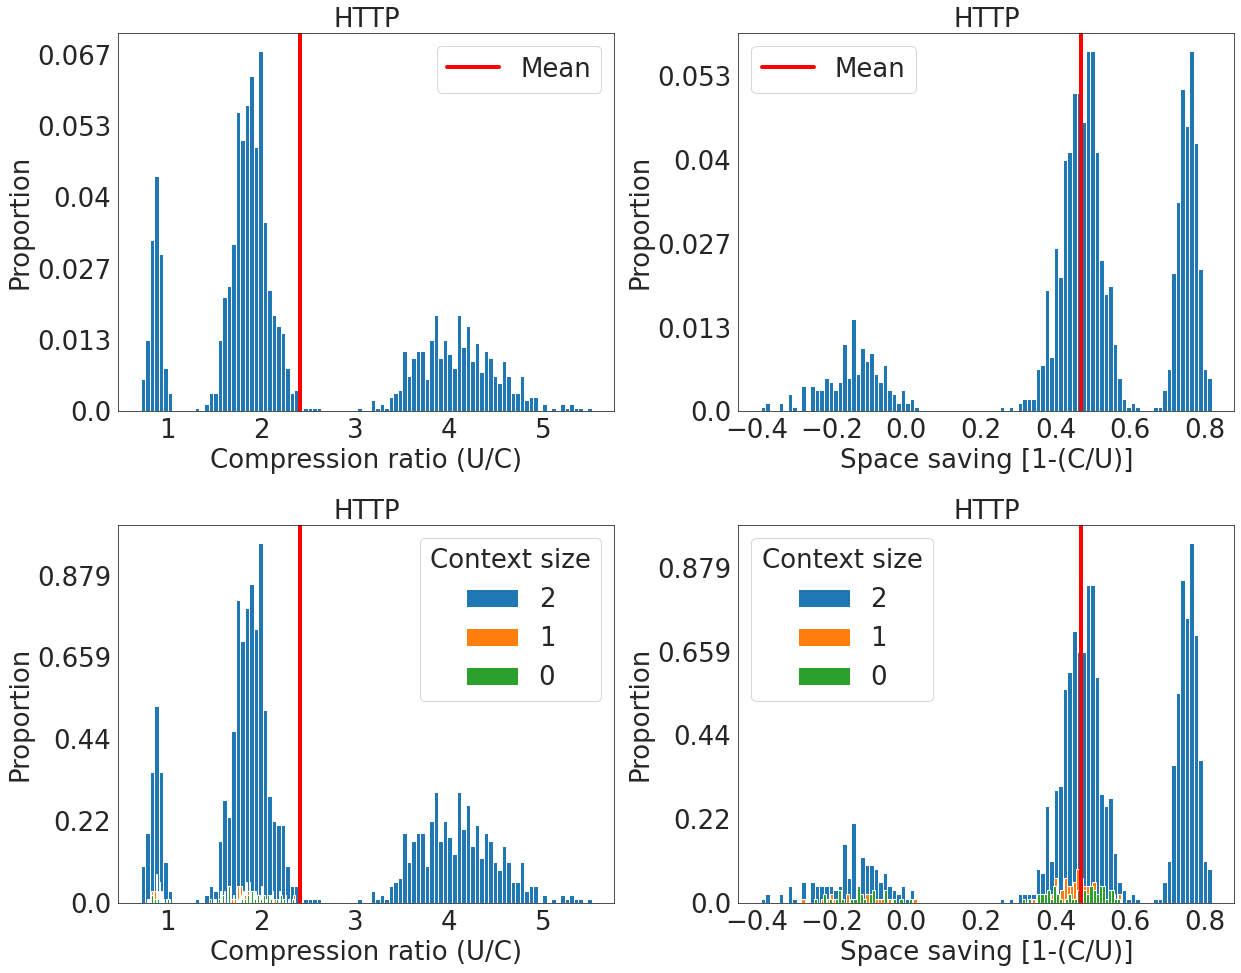

In [153]:
fig, axes = plt.subplots(
    2, 2, figsize=(20, 16))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=0.3)


# Parcourir les axes

df_plot = data_results.copy()

for ax, hue, col, title in zip(
    axes.ravel(), 
    [None, None, "size_context", "size_context"],
    ['compression_ratio', 'space_saving']*2,
    [f"Compression ratio (U/C)", f"Space saving [1-(C/U)]"]*2):
    
    # SET FIRST AXIS

    
    # Set rank 
    if (hue is None):
        ax.axvline(x=df_plot[col].mean(), 
                   linewidth=LINEWIDTH,
                   color='red',
                   label='Mean')
        ax.hist(df_plot[col],
                density=False, # Not working...
                #linewidth=LINEWIDTH,
                bins=100)
        
        # Set legend
        ax.legend(fontsize=LEGEND_FONTSIZE)
        
        # Normalize axis
        yticklabels = ax.get_yticks() 
        yticklabels_update = np.round(
            yticklabels/df_plot[col].shape[0], 3)
        
    else:
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .index
        
        for val in unique_values:
            cond = (df_plot[hue] == val)
            
            ax.hist(df_plot[cond][col],
                    density=False, # Not working...
                    #linewidth=LINEWIDTH,
                    bins=100)
            
            # Set legend
            legend = ax.legend(unique_values, 
                      fontsize=LEGEND_FONTSIZE)
            legend.set_title('Context size', 
                             prop={'size':LEGEND_FONTSIZE})
            
        ax.axvline(x=df_plot[col].mean(), 
                   linewidth=LINEWIDTH,
                   color='red')
        
        # Normalize axis
        yticklabels = ax.get_yticks() 
        yticklabels_update = np.round(
            yticklabels/df_plot[cond][col].shape[0], 3)
        
        
    for i, item in enumerate(ax.get_yticklabels()):
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_text(str(yticklabels_update[i]))
        #item.set_rotation(40)
        
    # Set normalized labels
    ax.set_yticklabels(ax.get_yticklabels())

    for item in ax.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)
        

    # Set label  
    ax.set_ylabel("Proportion", 
                  fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(f"{title}", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

In [237]:
data_results = pd.read_csv(f"./RESULTS/df_{FULL_NAME}{EXT_NAME}_COMPRESSION.csv")
data_raw = pd.read_csv(f"{MAIN_DIR}PROCESS/df_process_{PROTO}.csv")

In [238]:
data_results, df_raw = features_extraction(
        data_raw=data_raw, 
        data_results=data_results)

In [239]:
#cond = ((data_results['compression_ratio'] < 3) & 
#        (data_results['compression_ratio'] > 1.25))
cond = (data_results['compression_ratio'] < 1.15)
data_results = data_results[cond].reset_index(drop=True)

In [240]:
# Compute compression ratio at various size
# https://en.wikipedia.org/wiki/Data_compression_ratio

alpha=0.95

bit_ranks = []
compression_ratio = []
space_saving = []
sizes_context = []

low_yerror_compression_ratio = []
high_yerror_compression_ratio = []

low_yerror_space_saving = []
high_yerror_space_saving = []


for i in range(CONTEXT_SIZE+1):
    
    cond_ctx_size = (data_results[
        'size_context'] == i)
    data_results_tmp = data_results[
        cond_ctx_size]
    
    # IF l'array is empty
    if (data_results_tmp.shape[0] != 0):
        
        # Init first steps
        
        bit_ranks.append(0)
        compression_ratio.append(0)
        space_saving.append(0)
        sizes_context.append(i)
        
        low_yerror_compression_ratio.append(0)
        high_yerror_compression_ratio.append(0)
        
        low_yerror_space_saving.append(0)
        high_yerror_space_saving.append(0)
        
    
        # Compute each compress level

        for col in data_results.columns:
            if ("level_compress" in col):

                # Add context size info
                sizes_context.append(i)

                # Extract bit rank
                bit_rank = int(col.split("_")[-1])+1
                bit_ranks.append(
                    bit_rank)

                # Compute mean compresssion ratio
                # Compression ratio = uncompressed / compressed
                # for rank k
                df_tmp_compression_ratio = bit_rank / \
                    data_results_tmp[col]
                df_tmp_space_saving = 1 - (data_results_tmp[col] / \
                                                bit_rank)

                ## Remove -1
                cond = (data_results_tmp[col] != -1)
                df_tmp_compression_ratio = df_tmp_compression_ratio[cond]
                df_tmp_space_saving = df_tmp_space_saving[cond]

                compression_ratio.append(
                    df_tmp_compression_ratio.mean())
                space_saving.append(
                    df_tmp_space_saving.mean())
                
                if (df_tmp_compression_ratio.shape[0] != 0):

                    # Compute std compression ratio
                    p = ((1.0-alpha)/2.0)
                    lower_compression_ratio = np.percentile(
                            df_tmp_compression_ratio.values, p)
                    p = (alpha+((1.0-alpha)/2.0))
                    upper_compression_ratio = np.percentile(
                             df_tmp_compression_ratio.values, p)
                    
                    # Compute std space saving
                    p = ((1.0-alpha)/2.0)
                    lower_space_saving = np.percentile(
                            df_tmp_space_saving.values, p)
                    p = (alpha+((1.0-alpha)/2.0))
                    upper_space_saving = np.percentile(
                             df_tmp_space_saving.values, p)
                    
                else:
                    # Compression ratio
                    lower_compression_ratio = 0
                    upper_compression_ratio = 0
                    
                    # Space saving
                    lower_space_saving = 0
                    upper_space_saving = 0

                low_yerror_compression_ratio\
                    .append(lower_compression_ratio)
                high_yerror_compression_ratio\
                    .append(upper_compression_ratio)
                
                low_yerror_space_saving\
                    .append(lower_space_saving)
                high_yerror_space_saving\
                    .append(upper_space_saving)


# Set dataframe

df_plot = pd.DataFrame()

df_plot['bit_ranks'] = bit_ranks
df_plot['compression_ratio'] = compression_ratio
df_plot['space_saving'] = space_saving
df_plot['size_context'] = sizes_context

df_plot['low_yerror_compression_ratio'] = \
    low_yerror_compression_ratio
df_plot['high_yerror_compression_ratio'] = \
    high_yerror_compression_ratio
df_plot['low_yerror_space_saving'] = \
    low_yerror_space_saving
df_plot['high_yerror_space_saving'] = \
    high_yerror_space_saving

## Set order by bit_ranks

df_plot['bit_ranks'] = df_plot[
        'bit_ranks'].astype(int)
df_plot = df_plot.sort_values(
        by='bit_ranks').reset_index(drop=True)

# Extract difference

df_plot_diff = df_plot[
    ['compression_ratio', 
     'space_saving']] \
        .diff(1).fillna(0) \
        .rename(columns={'compression_ratio':'compression_ratio_diff',
                         'space_saving':'space_saving_diff'})
df_plot = pd.concat(
    [df_plot, df_plot_diff], axis=1)

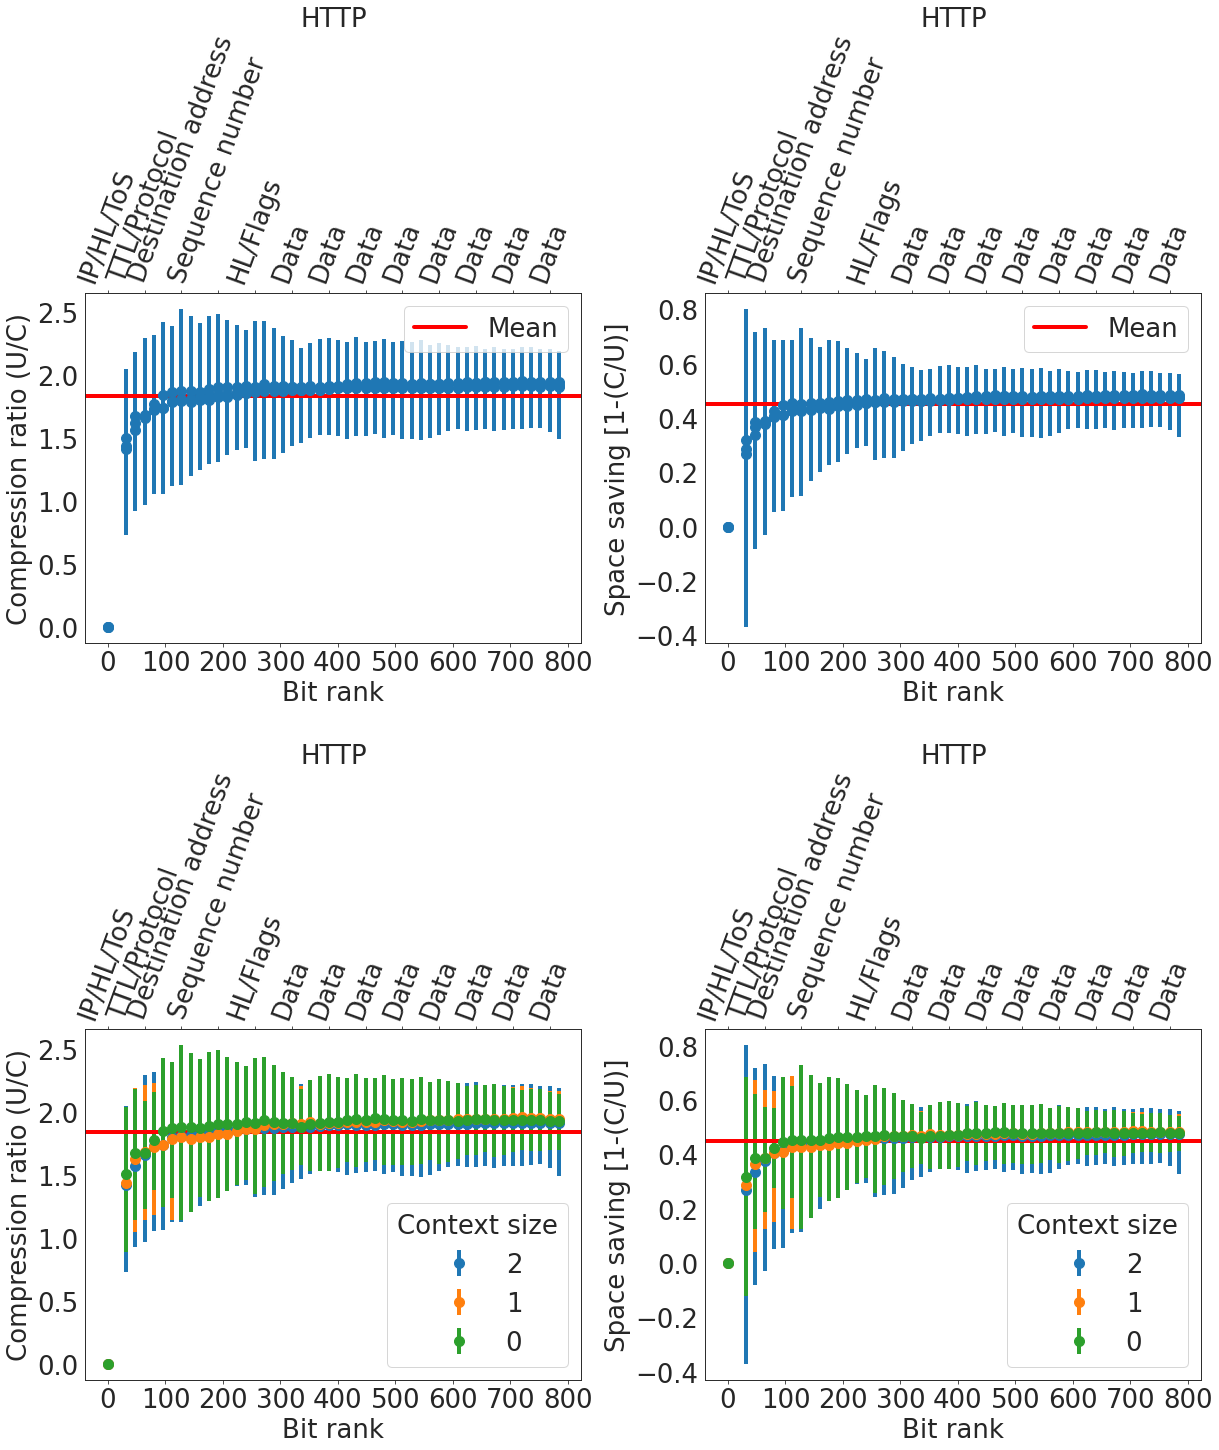

In [241]:
fig, axes = plt.subplots(
    2, 2, figsize=(20, 20))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=1.1)


# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    [None, None, "size_context", "size_context"],
    ['compression_ratio', 'space_saving']*2,
    [f"Compression ratio (U/C)", f"Space saving [1-(C/U)]"]*2):

    ax1 = ax
    ax2 = ax1.twiny()

    lower = (df_plot[col]-\
        df_plot['low_yerror_'+col]).abs()
    upper = (df_plot['high_yerror_'+col]-\
        df_plot[col]).abs()
    err_bar = [lower, 
               upper]
    #err_bar = [(df_plot[col]-df_plot['low_yerror'+col]).abs(), 
    #           (df_plot['high_yerror'+col]-df_plot[col]).abs()]
    #err_bar = [df_plot['low_yerror'], 
    #           df_plot['high_yerror']]
    #err_bar = [[0]*df_plot.shape[0], 
    #           [0]*df_plot.shape[0]]

    
    # SET FIRST AXIS

    
    # Set rank 
    if (hue is None):
        ax1.axhline(y=df_plot[col].mean(), 
                       linewidth=LINEWIDTH,
                       color='red',
                       label='Mean')
        if (ERROR_BAR):
            ax1.errorbar(df_plot['bit_ranks'], 
                         df_plot[col],
                         linewidth=LINEWIDTH,
                         markersize=MARKERSIZE, # Size of point
                         fmt='o', yerr=err_bar)
        else:
            ax1.scatter(df_plot['bit_ranks'], 
                         df_plot[col],
                         linewidth=LINEWIDTH)
        
        # Set legend
        ax1.legend(fontsize=LEGEND_FONTSIZE)
        
    else:
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .index
        
        for val in unique_values:
            cond = (df_plot[hue] == val)
            
            if (ERROR_BAR):

                lower = (df_plot[cond][col]-\
                    df_plot[cond]['low_yerror_'+col]).abs()
                upper = (df_plot[cond]['high_yerror_'+col]-\
                    df_plot[cond][col]).abs()
                err_bar = [lower, 
                           upper]
                #err_bar = [[0]*df_plot[cond].shape[0], 
                #           [0]*df_plot[cond].shape[0]]
                ax1.errorbar(df_plot[cond]['bit_ranks'], 
                             df_plot[cond][col],
                             linewidth=LINEWIDTH,
                             markersize=MARKERSIZE, # Size of point
                             fmt='o', yerr=err_bar)
            else:
                ax1.scatter(df_plot[cond]['bit_ranks'], 
                            df_plot[cond][col],
                            linewidth=LINEWIDTH)
            
            # Set legend
            legend = ax1.legend(unique_values,
                       fontsize=LEGEND_FONTSIZE)
            legend.set_title('Context size', 
                             prop={'size':LEGEND_FONTSIZE})
            
        ax1.axhline(y=df_plot[col].mean(), 
                    linewidth=LINEWIDTH,
                    color='red')
        

    for item in ax1.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax1.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax1.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax1.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax1.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax1.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax1.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax1.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

    # SET SECOND AXIS


    def tick_function(ranks_bit):
        values = []
        for val in ranks_bit:
            values.append(
                DICT_FIELDS[val])
        return values

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    #if (hue is None):
    new_tick_locations = [i for i in range(
        0, idx_end, 64)]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(
        tick_function(new_tick_locations))

    # Set field name
    #ax2 = ax1.twiny()
    ax2.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax2.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(70)

    ax2.grid(False)

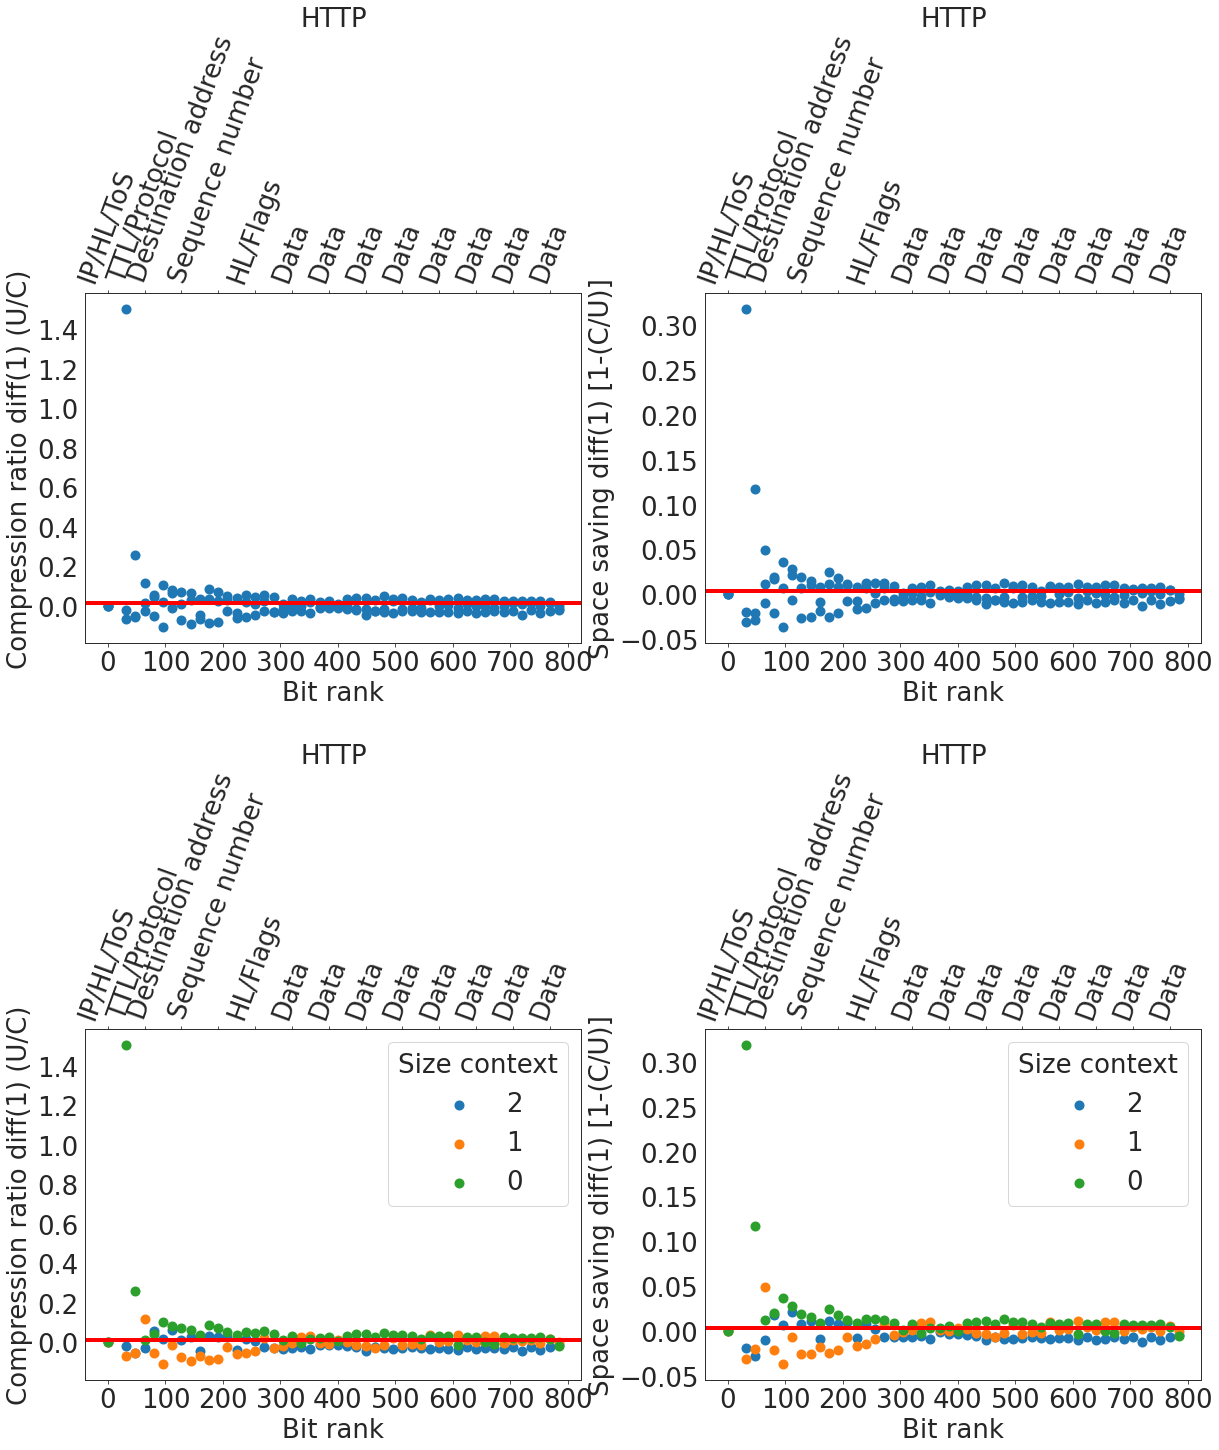

In [242]:
fig, axes = plt.subplots(
    2, 2, figsize=(20, 20))

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
fig.subplots_adjust(wspace=0.25, 
                    hspace=1.1)

# Parcourir les axes

for ax, hue, col, title in zip(
    axes.ravel(), 
    [None, None, "size_context", "size_context"],
    ['compression_ratio_diff', 'space_saving_diff']*2,
    [f"Compression ratio diff(1) (U/C)", f"Space saving diff(1) [1-(C/U)]"]*2):

    ax1 = ax
    ax2 = ax1.twiny()

    
    # SET FIRST AXIS

    
    # Set rank 
    if (hue is None):
        ax1.axhline(y=df_plot[col].mean(), 
                       linewidth=LINEWIDTH,
                       color='red',
                       label='Mean')

        ax1.scatter(df_plot['bit_ranks'], 
                    df_plot[col],
                    linewidth=LINEWIDTH)
    else:
        unique_values = df_plot[hue] \
                            .value_counts()\
                            .index
        for val in unique_values:
            cond = (df_plot[hue] == val)
            
            ax1.scatter(df_plot[cond]['bit_ranks'], 
                        df_plot[cond][col],
                        linewidth=LINEWIDTH)
            
            # Set legend
            legend = ax1.legend(unique_values, 
                       fontsize=LEGEND_FONTSIZE)
            legend.set_title('Size context', 
                             prop={'size':LEGEND_FONTSIZE})
            
        ax1.axhline(y=df_plot[col].mean(), 
                       linewidth=LINEWIDTH,
                       color='red')
        

    for item in ax1.get_yticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)

    for item in ax1.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        #item.set_rotation(40)


    # Set label  
    ax1.set_ylabel(title, 
                   fontsize=LABEL_FONTSIZE)
    ax1.set_xlabel(f"Bit rank", 
                   fontsize=LABEL_FONTSIZE)

    # Set title
    if ("MQTT" in PROTO):
        ax1.set_title(f"MQTT", 
                  fontsize=TITLE_FONTSIZE)
    elif ("COAP" in PROTO):
        ax1.set_title(f"CoAP", 
                  fontsize=TITLE_FONTSIZE)
    elif ("LORA" in PROTO):
        ax1.set_title(f"LoRaWAN", 
                  fontsize=TITLE_FONTSIZE)
    else:
        ax1.set_title(f"{PROTO}", 
                      fontsize=TITLE_FONTSIZE)

    # SET SECOND AXIS


    def tick_function(ranks_bit):
        values = []
        for val in ranks_bit:
            values.append(
                DICT_FIELDS[val])
        return values

    # We fix position and set the bit rank to 32 bit gap
    # We can set it manually
    #if (hue is None):
    new_tick_locations = [i for i in range(
        0, idx_end, 64)]
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(
        tick_function(new_tick_locations))

    # Set field name
    #ax2 = ax1.twiny()
    ax2.tick_params(labelsize=TICK_FONTSIZE)
    #ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

    for item in ax2.get_xticklabels():
        item.set_fontsize(LABEL_FONTSIZE)
        item.set_rotation(70)

    ax2.grid(False)

#### TEST

In [ ]:
%%time
df_raw, arr_update = extract_flows(
    data_raw=data_raw, 
    arr_raw=arr_raw)

In [ ]:
%%time
idx_unique = get_idx_unique(
    df_raw=df_raw, 
    arr_update=arr_update)

In [ ]:
%%time
idx_unique = get_idx_equipment(
    df_raw=df_raw, 
    idx_unique=idx_unique)

In [ ]:
# Useless to split idx_unique
if (MODE_EQUIP != "test"):
    idx_unique_train, idx_unique_test = \
        get_split_idx_unique(
            df_raw=df_raw, 
            idx_unique=idx_unique)

## 6. Others

In [ ]:
# Options for huffman table
# construction
OPTIMAL = True
SELECTIVE = True

MODE_DATASET = "counter"
cut_value = 20

# Load HUFFMAN

if (CHECKSUM):
    if (CUSTOM_SIZE is not None):
        ext_name = f"_WITH_CHECKSUM_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}_KEEP_ERROR_{cut_value}"
    else:
        ext_name = f"_WITH_CHECKSUM_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}_KEEP_ERROR_{cut_value}"
else:
    if (CUSTOM_SIZE is not None):
        ext_name= f"_CUSTOM_SIZE{CUSTOM_SIZE}_MODE_DATASET{MODE_DATASET}_KEEP_ERROR_{cut_value}"
    else:
        ext_name = f"_EXTRA_SIZE{EXTRA_SIZE}_MODE_DATASET{MODE_DATASET}_KEEP_ERROR_{cut_value}"

if (SELECTIVE):
    ext_name = ext_name + "_SELECTIVE"

if (OPTIMAL):
    ext_name = ext_name + "_OPTIMAL"

if (LEFT_PADDING):
    ext_name = ext_name + "_LEFT_PADDING"

full_name = f"HUFFMAN_LOSSLESS_CONTEXT{LOOK_BACK_CONTEXT}_PACKET{LOOK_BACK_PACKET}_SIN{NUM_SIN}"
df_huffman_tmp = pd.read_csv(f"./MODELS/HUFFMAN/INTERPRETATION/df_{full_name}{ext_name}.csv",
                             dtype={"key": str})

df_baseline_groupby = df_huffman_tmp.copy()


# CHANGE DATAFRAME FORMAT 
def my_func(x, max_length=8):
    value = str(x)
    length = len(value)
    value_extend = "0"*(max_length-length)
    value = value_extend + value
    return value

df_baseline_groupby['key'] = df_huffman_tmp['key'].map(
    lambda x : my_func(x, max_length=cut_value))
df_baseline_groupby = df_baseline_groupby.groupby(
    ['ctx', 'pos', 'key']).mean()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

X = np.linspace(0,1,1000)
Y = np.cos(X*20)

ax1.plot(X,Y)
ax1.set_xlabel(r"Original x-axis: $X$")

new_tick_locations = np.array([.2, .5, .9])

def tick_function(X):
    V = 1/(1+X)
    return ["%.3f" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
plt.show()

In [ ]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 7))



# Parcourir 
for ax in axes.ravel():

ax1 = ax
ax2 = ax1.twiny()


#err_bar = [df_plot['low_yerror'], 
#           df_plot['low_yerror']]
err_bar = [[0]*df_plot.shape[0], [0]*df_plot.shape[0]]

# Setthe dict field
if ('LORA' in PROTO):
    pass # Mettre les noms des fields associées
elif (PROTO in ['HTTP', 'SMTP', 'SSH', 'MQTT']):
    #DICT_FIELDS = {31: "Checksum"}
    DICT_FIELDS = {v: k for k, v in enumerate(range(500))}
elif (PROTO in ["COAP", 'SNMP']):
    pass # For udp


# SET FIRST AXIS


# Set rank 

ax1.errorbar(df_plot['bit_ranks'], 
             df_plot['compression_ratio'],
             linewidth=LINEWIDTH,
             markersize=10, # Size of point
             fmt='o-', yerr=err_bar)
#ax1.set_xticklabels(df_plot['bit_ranks'].astype(int), 
#                    fontsize=LABEL_FONTSIZE, 
#                    rotation=0)

for item in ax1.get_yticklabels():
    item.set_fontsize(LABEL_FONTSIZE)
    #item.set_rotation(40)
    
for item in ax1.get_xticklabels():
    item.set_fontsize(LABEL_FONTSIZE)
    #item.set_rotation(40)
    
    
# Set label  
ax1.set_ylabel(f"Compression ratio (U/C)", 
               fontsize=LABEL_FONTSIZE)
ax1.set_xlabel(f"Bit rank", 
               fontsize=LABEL_FONTSIZE)
    
# Set title
ax1.set_title(f"{PROTO}", 
              fontsize=TITLE_FONTSIZE)


# SET SECOND AXIS



def tick_function(ranks_bit):
    values = []
    for val in ranks_bit:
        values.append(
            DICT_FIELDS[val])
    return values

# We fix position and set the bit rank to 32 bit gap
# We can set it manually
new_tick_locations = [i for i in range(
    0, df_plot['bit_ranks'].max(), 32)]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(
    tick_function(new_tick_locations))

# Set field name
#ax2 = ax1.twiny()
ax2.tick_params(labelsize=TICK_FONTSIZE)
#ax2.set_xlabel("Fields", fontsize=LABEL_FONTSIZE)

for item in ax2.get_xticklabels():
    item.set_fontsize(LABEL_FONTSIZE)
    item.set_rotation(70)
    
ax2.grid(False)

In [ ]:
MAX_RANK = 40
cols = [f"rank_{i}" for i in range(MAX_RANK)]
indexes_rltv_pkt = data_fields[
    "index_rltv_pkt"].value_counts().index.astype(int)
#indexes_rltv_flow = df_fields[
#    "index_rltv_flow"].value_counts().index.astype(int)

index_df = 0
df_results = pd.DataFrame(columns=["index_rltv_pkt",
                                   "index_rltv_flow",
                                   "count_unique",
                                   "field_rank",
                                   "coeff"])

cols_ranks = [f"field_rank_{i}" for i in range(MAX_RANK)]
df_ranks = pd.DataFrame(columns=cols_ranks+[
    "index_rltv_pkt", "index_rltv_flow", "rank"])

# Pour chaque position relatif du block
for i in tqdm(
    indexes_rltv_pkt[0:1]):
    
    for z in range(1):
        #params['look_back_context']+1):
        if (z == LOOK_BACK_CONTEXT):
            cond_rltv_flow = (
                data_fields["index_rltv_flow"] >= z)
        else:
            cond_rltv_flow = (
                data_fields["index_rltv_flow"] == z)
            
        #print("[DEBUG] i // j : ", i, " // ", z)
            
        data_fields_flow = data_fields[cond_rltv_flow]
        cond_rltv_pkt = (data_fields_flow["index_rltv_pkt"] == i)
        #print("[DEBUG] df_fields_flow shape", df_fields_flow.shape)
    
        # Pour chaque columns de la position relative
        for j, col in enumerate(cols):
            values = data_fields_flow[
                cond_rltv_pkt][col].values
            unique_values, count = np.unique(
                values, return_counts=True)
            count_sort_ind = np.argsort(-count)
            
            #print("[DEBUG] unique_values : ", unique_values)

            # Extract unique values
            unique_values = unique_values[
                count_sort_ind]
            count = count[count_sort_ind]
            
            #print("[DEBUG] unique_values : ", unique_values)

            # Get all unique values since last rank
            cols_tmp = [f"rank_{k}" for k in range(j+1)]
            values_tmp = data_fields_flow[
                cond_rltv_pkt][cols_tmp].values.ravel()
            print("[DEBUG] values_tmp : ", values_tmp)
            unique_values_tmp, count_tmp = np.unique(
                values_tmp, return_counts=True)
            print("[DEBUG] count_tmp.sum() : ", 
                  count_tmp.sum(), " : ", unique_values_tmp)
            coeff_unique_rank = (
                (min(count_tmp.sum(), MAX_RANK) - \
                 unique_values_tmp.size) / min(
                    count_tmp.sum(), MAX_RANK))
                
            # Save results for coeff unique 
            df_results.loc[index_df] = [i, # index_rltv_pkt
                                        z, # index_rltv_flow
                                        unique_values.size,
                                        j,
                                        coeff_unique_rank]

            # Extract rank
            #diff_size = max_rank - unique_values[0:max_rank].size
            #list_unique_values = unique_values[
            #    0:max_rank].tolist() + [None]*diff_size
            #df_ranks.loc[index_df] = list_unique_values + [i, z, j]

            # Update coeff
            index_df += 1
        

        #print("unique_values : ", unique_values, 
        #      " counts : ", count,
        #      " unique_values_tmp.size : ", unique_values_tmp)